In [30]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import shutil

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
import logging
from skimage.io import imread
from torchviz import make_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from torch.autograd import Variable
from torch.optim import *
from scipy.io import loadmat
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, ConcatDataset, DataLoader, SubsetRandomSampler
import torchio as tio
from torch.utils.tensorboard import SummaryWriter

import matplotlib.cm as cm
import matplotlib.animation as animation
#import plotly.graph_objects as go
#import plotly.io as pio
#pio.renderers.default = "notebook"
import math

from utils.dataset_utils import *
from utils.classifier_utils import *
from utils.neural_networks import *

logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s - %(message)s', datefmt="%Y-%m-%d %H:%M:%S")

In [31]:
info = {}
info["ext"] = "mat"
#info["ext"] = "nii"
dir_path = "../RSNA-BTC-Datasets/train_"+info["ext"]
test_dir_path = "../RSNA-BTC-Datasets/test_"+info["ext"]
ext_test_1_dir_path = "../RSNA-BTC-Datasets/brats18_"+info["ext"]
ext_test_0_dir_path = "../RSNA-BTC-Datasets/OpenNeuroDS000221_ss_"+info["ext"]
#info["mri_types"] = ["FLAIR", "T2w"]
#info["mri_types"] = ["FLAIR", "T1w"]
#info["mri_types"] = ["T1wCE", "T2w"]
#info["mri_types"] = ["FLAIR"]
#info["mri_types"] = ["T1wCE"]
#info["mri_types"] = ["T1w"]

chosen_net  = "sim" #3du
info["dims"] = 3
info["mri_types"] = ["KLF"]
info["batch_size"] = 2#8
info["is_depth_wise"] = True
info["is_transformed"] = False
transform = None
info["output_size"] = 1
info["is_multistep"] = True
info["lr"] = 0.0005
info["is_adam"] = True
info["momentum"] = 0.9
info["is_10_fold"] = False
info["val_total_ratio"] = 0.3
info["is_internal_dataset"] = True
size = len(info["mri_types"])
sel_slices = None

print(info)

{'ext': 'mat', 'dims': 3, 'mri_types': ['KLF'], 'batch_size': 2, 'is_depth_wise': True, 'is_transformed': False, 'output_size': 1, 'is_multistep': True, 'lr': 0.0005, 'is_adam': True, 'momentum': 0.9, 'is_10_fold': False, 'val_total_ratio': 0.3, 'is_internal_dataset': True}


In [32]:
# Competition Train + Val + Test
m_dataset_0 = Dataset(dir_path, info["mri_types"], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

logging.info("Train/Val datasets size: {}".format(len(m_dataset_0)))

m_dataset_1 = Dataset(dir_path, info["mri_types"], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

logging.info("Train/Val datasets size: {}".format(len(m_dataset_1)))

# External Train + Val + Test
t_dataset_0 = Dataset(ext_test_0_dir_path, info["mri_types"], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

logging.info("Train/Val datasets size: {}".format(len(t_dataset_0)))

t_dataset_1 = Dataset(ext_test_1_dir_path, info["mri_types"], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

logging.info("Train/Val datasets size: {}".format(len(t_dataset_1)))

2022-07-06 15:22:06 - Train/Val datasets size: 270
2022-07-06 15:22:06 - Train/Val datasets size: 303
2022-07-06 15:22:06 - Train/Val datasets size: 231
2022-07-06 15:22:06 - Train/Val datasets size: 285


In [33]:
print(len(m_dataset_0.samples_dict[info['mri_types'][0]]))
print(len(m_dataset_1.samples_dict[info['mri_types'][0]]))
print(len(t_dataset_0.samples_dict[info['mri_types'][0]]))
print(len(t_dataset_1.samples_dict[info['mri_types'][0]]))

270
303
231
285


In [34]:
m_dataset_merged = Dataset().concat_datasets(m_dataset_0, m_dataset_1)
m_dataset_merged_no_tr = Dataset().concat_datasets(m_dataset_0, m_dataset_1, import_transform=False)

m_splits = get_splits(m_dataset_0, m_dataset_1, info["val_total_ratio"], info["is_10_fold"], 0.1)

g_cpu = torch.Generator()
m_train_folds_idx = m_splits[0][0]
m_valid_folds_idx = m_splits[0][1]
m_test_folds_idx = m_splits[0][2]
# Test for 
m_idxs = m_train_folds_idx + m_valid_folds_idx
print(m_idxs)
m_sampler = SubsetRandomSampler(m_idxs, g_cpu)
m_loader = DataLoader(dataset=m_dataset_merged, batch_size=info["batch_size"], sampler=m_sampler, num_workers=2, worker_init_fn=np.random.seed(0))



Length of concatenated dataset: 606
Length of concatenated dataset: 606
Train Idx:
[118, 60, 159, 282, 110, 21, 29, 150, 16, 75, 109, 179, 283, 4, 96, 229, 61, 67, 295, 266, 171, 281, 40, 189, 13, 107, 200, 3, 161, 125, 24, 30, 77, 279, 190, 19, 257, 235, 268, 80, 51, 2, 239, 104, 262, 86, 10, 224, 58, 41, 14, 155, 50, 215, 237, 123, 220, 62, 191, 230, 130, 213, 187, 43, 114, 138, 199, 222, 149, 112, 298, 98, 221, 93, 208, 162, 36, 178, 113, 0, 94, 294, 95, 299, 263, 256, 69, 49, 48, 85, 300, 141, 207, 23, 250, 148, 143, 78, 180, 100, 204, 131, 269, 301, 196, 6, 68, 203, 84, 170, 121, 140, 258, 276, 142, 259, 91, 82, 285, 11, 119, 102, 35, 57, 169, 231, 65, 1, 120, 267, 186, 42, 105, 132, 79, 17, 271, 38, 53, 260, 128, 28, 183, 163, 151, 244, 202, 31, 32, 127, 185, 280, 273, 147, 278, 177, 99, 197, 243, 115, 265, 72, 25, 165, 289, 174, 291, 39, 193, 88, 70, 87, 292, 242, 277, 211, 9, 195, 251, 192, 117, 47, 172, 401, 505, 471, 392, 543, 561, 550, 435, 349, 500, 410, 473, 303, 542, 374,

In [35]:
t_dataset_merged = Dataset().concat_datasets(t_dataset_0, t_dataset_1)
t_dataset_merged_no_tr = Dataset().concat_datasets(t_dataset_0, t_dataset_1, import_transform=False)

t_splits = get_splits(t_dataset_0, t_dataset_1, info["val_total_ratio"], info["is_10_fold"])

Length of concatenated dataset: 570
Length of concatenated dataset: 570
Train Idx:
[109, 122, 4, 96, 157, 61, 108, 67, 52, 229, 66, 26, 144, 187, 216, 265, 40, 175, 13, 107, 262, 3, 160, 125, 24, 30, 77, 264, 176, 19, 238, 217, 254, 80, 51, 2, 221, 104, 189, 86, 10, 182, 58, 41, 14, 155, 50, 198, 219, 123, 62, 260, 212, 130, 206, 173, 43, 247, 138, 256, 204, 149, 112, 237, 98, 209, 93, 281, 162, 36, 178, 113, 0, 94, 95, 249, 226, 69, 49, 48, 85, 282, 141, 23, 231, 148, 143, 78, 180, 100, 131, 255, 283, 196, 6, 68, 248, 84, 170, 121, 140, 240, 261, 142, 276, 91, 82, 269, 11, 119, 102, 35, 57, 169, 65, 1, 120, 253, 186, 42, 105, 132, 79, 17, 232, 38, 133, 53, 164, 259, 128, 34, 28, 183, 114, 203, 163, 151, 244, 202, 31, 32, 127, 185, 258, 147, 263, 177, 99, 197, 243, 115, 72, 25, 165, 273, 174, 275, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 383, 517, 398, 481, 361, 508, 320, 567, 414, 460, 294, 467, 419, 316, 552, 560, 566, 389, 397, 516, 321, 471, 350, 327, 411, 288

In [36]:
m_dataloader = get_all_split_loaders(m_dataset_merged, m_dataset_merged_no_tr, m_splits, info["batch_size"])
m_dataloaders = m_dataloader
logging.info("(M) Train validation test splitted: {} {} {}".format(len(m_splits[0][0]),len(m_splits[0][1]),len(m_splits[0][2])))

t_dataloader = get_all_split_loaders(t_dataset_merged, t_dataset_merged_no_tr, t_splits, info["batch_size"])
t_dataloaders = t_dataloader
logging.info("(T) Train validation test splitted: {} {} {}".format(len(t_splits[0][0]),len(t_splits[0][1]),len(t_splits[0][2])))

2022-07-06 15:22:08 - (M) Train validation test splitted: 366 180 60
2022-07-06 15:22:08 - (T) Train validation test splitted: 344 170 56


In [37]:
# Model check
model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
print(count_parameters(model))
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info("Using CUDA...")

182732
RSNAClassifierSingle3D(
  (part1): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): Conv3d(1, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=4, bias=False)
      (1): Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=8, bias=False)
      (1): Conv3d(8, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )


In [38]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

m_dataloader = m_dataloaders[0]
# Competition Train
m_train_loader = m_dataloader[0]
# Competition Val
m_val_loader = m_dataloader[1]
# External Train + Val
m_train_val_loader = m_loader
# Competition Test
m_test_loader = m_dataloader[2]

t_dataloader = t_dataloaders[0]
# External Train
t_train_loader = t_dataloader[0]
# External Val
t_val_loader = t_dataloader[1]
# External Test
t_test_loader = t_dataloader[2]

t_model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])

In [39]:
# Tumor Detector
#t_modelfile = train_mri_type(t_model, device, info, epochs=10, pat=10, 
#                       train_loader=t_train_loader, valid_loader=t_val_loader)

In [40]:
#print(t_modelfile)

In [41]:
# E+E
#ee_test_pred = predict(t_model, device, t_modelfile, t_test_loader, size)

In [42]:
#print(ee_test_pred)

In [48]:
# E+C
#t_modelfile = "../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul05_00-01-47/RSNAClassifierSingle3D-DW-SO-KLF-e10-loss0.017-acc0.982-auc1.000.pth"
#ec_test_pred = predict(t_model, device, t_modelfile, m_loader, size)
ids = []
y_all = []
outputs_all = []

list_tumor = [18, 19, 21, 22, 30, 36, 53, 64, 72, 84, 88, 90, 95, 97, 99, 116, 121, 122, 124, 130, 133, 142, 150, 
             154, 157, 158, 165, 167, 169, 172, 176, 183, 184, 191, 192, 194, 195, 201, 206, 209, 211, 214, 216, 
             221, 231, 237, 238, 239, 242, 247, 249, 259, 261, 266, 267, 283, 289, 290, 297, 300, 301, 309, 310, 
             312, 316, 320, 324, 325, 327, 336, 347, 351, 356, 373, 382, 388, 391, 392, 395, 397, 399, 401, 402, 
             414, 417, 421, 430, 433, 445, 446, 452, 455, 477, 481, 495, 498, 512, 538, 563, 565, 568, 569, 587, 
             588, 589, 591, 596, 601, 605, 616, 641, 649, 651, 654, 663, 668, 682, 683, 685, 686, 687, 706, 724, 
             727, 730, 733, 742, 747, 751, 756, 759, 764, 767, 774, 780, 792, 796, 797, 800, 803, 804, 810, 814, 
             818, 830, 1004, 1009]

for i in m_loader:
    for j in range(info["batch_size"]):
        print(i[0][0][j], i[2][j].numpy())
        ids.append(i[0][0][j][:5])
        y_all.append(i[2][j].numpy())
        if i[2][j].numpy() == 1 or int(i[0][0][j][:5]) in list_tumor:
            outputs_all.append(1)
        else:
            outputs_all.append(0)
        
# y_all contains all methylation original values
# outputs_all is a tumor list, indeed it contains:
# - 1s when the patient has originally methylation (so he has a tumor) or the patient has tumor
# - 0s when the patient has neither methylation nor tumor
ec_test_pred = pd.DataFrame({"BraTS21ID": ids, "MGMT_real_value": y_all, "MGMT_value": outputs_all}) 
ec_test_pred = ec_test_pred.sort_values(by="BraTS21ID")

00621_KLF.mat 1
00768_KLF.mat 1
00533_KLF.mat 0
00772_KLF.mat 1
00640_KLF.mat 1
00472_KLF.mat 1
00325_KLF.mat 0
00426_KLF.mat 1
00739_KLF.mat 1
00218_KLF.mat 0
00196_KLF.mat 1
00289_KLF.mat 0
00344_KLF.mat 1
00274_KLF.mat 0
00516_KLF.mat 1
00290_KLF.mat 0
00267_KLF.mat 0
00370_KLF.mat 1
00564_KLF.mat 1
00341_KLF.mat 0
00228_KLF.mat 0
00188_KLF.mat 1
01009_KLF.mat 0
00379_KLF.mat 0
00390_KLF.mat 0
00320_KLF.mat 0
00641_KLF.mat 0
00160_KLF.mat 1
00518_KLF.mat 0
00210_KLF.mat 1
00554_KLF.mat 1
00679_KLF.mat 1
00431_KLF.mat 1
00095_KLF.mat 0
00259_KLF.mat 0
00096_KLF.mat 1
00130_KLF.mat 0
00081_KLF.mat 0
00746_KLF.mat 1
00242_KLF.mat 0
00656_KLF.mat 1
00301_KLF.mat 0
00231_KLF.mat 0
00576_KLF.mat 1
00500_KLF.mat 1
00359_KLF.mat 1
00725_KLF.mat 1
00645_KLF.mat 0
00247_KLF.mat 0
00316_KLF.mat 0
00642_KLF.mat 0
00425_KLF.mat 1
00247_KLF.mat 0
00737_KLF.mat 1
00328_KLF.mat 1
00401_KLF.mat 0
00332_KLF.mat 1
00239_KLF.mat 0
00241_KLF.mat 0
00456_KLF.mat 1
00014_KLF.mat 1
00675_KLF.mat 1
00618_KL

00578_KLF.mat 0
00054_KLF.mat 1
00110_KLF.mat 0
00819_KLF.mat 1
00767_KLF.mat 0
00109_KLF.mat 1
00377_KLF.mat 0
00021_KLF.mat 0
00197_KLF.mat 1
00807_KLF.mat 1
00133_KLF.mat 0
00336_KLF.mat 0
00308_KLF.mat 0
00058_KLF.mat 1
00400_KLF.mat 1
00306_KLF.mat 1
00340_KLF.mat 1
00429_KLF.mat 1
00703_KLF.mat 0
00494_KLF.mat 1
00391_KLF.mat 0
00498_KLF.mat 0
00606_KLF.mat 1
00810_KLF.mat 0
00557_KLF.mat 1
00285_KLF.mat 1
00540_KLF.mat 0
00654_KLF.mat 0
00563_KLF.mat 0
00441_KLF.mat 0


In [49]:
print(ec_test_pred)

    BraTS21ID MGMT_real_value  MGMT_value
463     00000               1           1
312     00002               1           1
217     00005               1           1
253     00006               1           1
95      00008               1           1
328     00009               0           0
232     00011               1           1
85      00012               1           1
60      00014               1           1
397     00017               0           0
263     00018               0           1
323     00019               0           1
462     00020               1           1
523     00021               0           1
240     00022               0           1
401     00024               0           0
234     00025               1           1
311     00026               1           1
326     00028               1           1
410     00030               0           1
154     00031               1           1
500     00032               0           0
405     00033               1     

In [50]:
# Predicted == 1 (all tumor patients)
ec_1_test_pred = ec_test_pred[ec_test_pred["MGMT_value"] == 1]
print(len(ec_1_test_pred))
print(ec_1_test_pred)

420
    BraTS21ID MGMT_real_value  MGMT_value
463     00000               1           1
312     00002               1           1
217     00005               1           1
253     00006               1           1
95      00008               1           1
232     00011               1           1
85      00012               1           1
60      00014               1           1
263     00018               0           1
323     00019               0           1
462     00020               1           1
523     00021               0           1
240     00022               0           1
234     00025               1           1
311     00026               1           1
326     00028               1           1
410     00030               0           1
154     00031               1           1
405     00033               1           1
427     00035               1           1
94      00036               0           1
350     00043               1           1
245     00046               1 

In [51]:
out_path = "../RSNA-BTC-Datasets/ec_train_"+info["ext"]
if os.path.exists(out_path):
    shutil.rmtree(out_path)
if not os.path.exists(out_path):
    os.mkdir(out_path)
if not os.path.exists(out_path+"/KLF"):
    os.mkdir(out_path+"/KLF")
if not os.path.exists(out_path+"/KLF/0"):
    os.mkdir(out_path+"/KLF/0")
if not os.path.exists(out_path+"/KLF/1"):
    os.mkdir(out_path+"/KLF/1")
"""
if not os.path.exists(out_path+"/FLAIR"):
    os.mkdir(out_path+"/FLAIR")
if not os.path.exists(out_path+"/FLAIR/0"):
    os.mkdir(out_path+"/FLAIR/0")
if not os.path.exists(out_path+"/FLAIR/1"):
    os.mkdir(out_path+"/FLAIR/1")
"""
for name, c_id in zip(ec_1_test_pred["BraTS21ID"],ec_1_test_pred["MGMT_real_value"]):
    original = dir_path+"/KLF/"+str(c_id)+"/"+str(name)+"_KLF.mat"
    target = out_path+"/KLF/"+str(c_id)+"/"+str(name)+"_KLF.mat"
    print(target)
    shutil.copyfile(original, target)
    #original_f = dir_path+"/FLAIR/"+str(c_id)+"/"+str(name)+"_FLAIR.mat"
    #target_f = out_path+"/FLAIR/"+str(c_id)+"/"+str(name)+"_FLAIR.mat"
    #print(target_f)
    #shutil.copyfile(original_f, target_f)

../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00000_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00002_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00005_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00006_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00008_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00011_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00012_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00014_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/0/00018_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/0/00019_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00020_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/0/00021_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/0/00022_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00025_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00026_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00028_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/0/00030_KLF.mat
../RSNA-BTC-Datasets/ec_train_mat/KLF/1/00031_KLF.mat
../RSNA-BTC-Datasets/ec_trai

00457_KLF.mat 1
00808_KLF.mat 1
00466_KLF.mat 1
00591_KLF.mat 0
00408_KLF.mat 1
00123_KLF.mat 0
00299_KLF.mat 1
00199_KLF.mat 1
00694_KLF.mat 1
00192_KLF.mat 0
00240_KLF.mat 1
00414_KLF.mat 0
00502_KLF.mat 1
00714_KLF.mat 1
00685_KLF.mat 0
00735_KLF.mat 0
00680_KLF.mat 1
00187_KLF.mat 1
00646_KLF.mat 1
00399_KLF.mat 0
00245_KLF.mat 1
00089_KLF.mat 1
00144_KLF.mat 1
00318_KLF.mat 0
00577_KLF.mat 1
00048_KLF.mat 1
00565_KLF.mat 0
00154_KLF.mat 0
00638_KLF.mat 1
00416_KLF.mat 1
00538_KLF.mat 0
00651_KLF.mat 0
00796_KLF.mat 0
00446_KLF.mat 0
00171_KLF.mat 1
00610_KLF.mat 1
00800_KLF.mat 0
00636_KLF.mat 0
00397_KLF.mat 0
00219_KLF.mat 0
00611_KLF.mat 1
00803_KLF.mat 0
00194_KLF.mat 0
00649_KLF.mat 0
00568_KLF.mat 0
00658_KLF.mat 1
00692_KLF.mat 1
00078_KLF.mat 1
00236_KLF.mat 0
00454_KLF.mat 0
00402_KLF.mat 0
00707_KLF.mat 1
00751_KLF.mat 0
00162_KLF.mat 0
00261_KLF.mat 0
00788_KLF.mat 0
00549_KLF.mat 1
00552_KLF.mat 1
00084_KLF.mat 0
00134_KLF.mat 1
   BraTS21ID MGMT_real_value  MGMT_value

  0%|                                                   | 0/150 [00:00<?, ?it/s]

2022-07-06 15:51:55 - EPOCH: 1
2022-07-06 15:52:10 - Train Step 10/28, train_loss: 0.6924
2022-07-06 15:52:23 - Train Step 20/28, train_loss: 0.6886
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:52:40 - Valid Step 5/7, valid_loss: 0.6932
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
94      00028                1           0
45      00043                1           0
78      00052                1           0
23      00062                1           0
0       00064                0           0
2       00064                0           0
34      00072                0           0
27      00121                0           0
87      00121                0           0
6       00140                1           0
15      00142                0           0
5       00146                1           0
92      00150                0           0
88      00160                1           0
43      00167                0           0
10      00169                0        

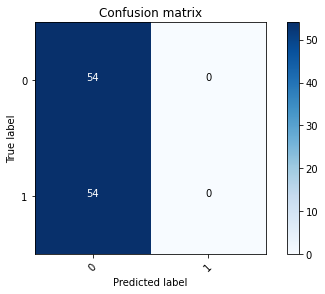

2022-07-06 15:52:42 - [Epoch Train: 1] loss: 0.6841, auc: 0.5848, acc: 0.5023, time: 36.00 s            
2022-07-06 15:52:42 - [Epoch Valid: 1] loss: 0.6932, auc: 0.5038, acc: 0.5000, time: 10.00 s
2022-07-06 15:52:42 - acc improved from 0.0000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e1-loss0.693-acc0.500-auc0.504.pth'


  1%|▎                                        | 1/150 [00:47<1:57:03, 47.14s/it]

2022-07-06 15:52:42 - EPOCH: 2
2022-07-06 15:52:55 - Train Step 10/28, train_loss: 0.6356
2022-07-06 15:53:08 - Train Step 20/28, train_loss: 0.6294
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:53:25 - Valid Step 5/7, valid_loss: 0.7024
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
1       00028                1           0
71      00043                1           0
13      00052                1           0
96      00062                1           0
56      00064                0           0
59      00064                0           0
51      00072                0           0
34      00121                0           0
44      00121                0           0
105     00140                1           0
68      00142                0           0
58      00146                1           0
26      00150                0           0
41      00160                1           0
42      00167                0           0
39      00169                0        

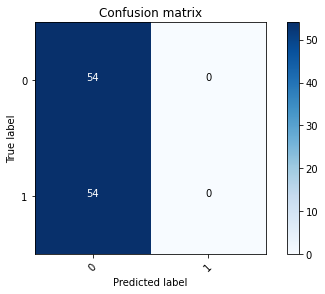

2022-07-06 15:53:27 - [Epoch Train: 2] loss: 0.6301, auc: 0.7802, acc: 0.6164, time: 34.00 s            
2022-07-06 15:53:27 - [Epoch Valid: 2] loss: 0.6986, auc: 0.5120, acc: 0.5000, time: 9.00 s
2022-07-06 15:53:27 - acc improved from 0.5000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e2-loss0.699-acc0.500-auc0.512.pth'


  1%|▌                                        | 2/150 [01:31<1:52:09, 45.47s/it]

2022-07-06 15:53:27 - EPOCH: 3
2022-07-06 15:53:40 - Train Step 10/28, train_loss: 0.5905
2022-07-06 15:53:54 - Train Step 20/28, train_loss: 0.5854
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:54:10 - Valid Step 5/7, valid_loss: 0.6518
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
17      00028                1           0
75      00043                1           0
4       00052                1           0
61      00062                1           0
58      00064                0           0
72      00064                0           0
57      00072                0           0
2       00121                0           0
95      00121                0           0
7       00140                1           0
104     00142                0           0
94      00146                1           0
20      00150                0           0
69      00160                1           0
49      00167                0           0
48      00169                0        

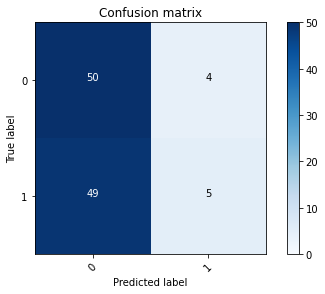

2022-07-06 15:54:12 - [Epoch Train: 3] loss: 0.5856, auc: 0.8552, acc: 0.6164, time: 36.00 s            
2022-07-06 15:54:12 - [Epoch Valid: 3] loss: 0.6589, auc: 0.6852, acc: 0.5093, time: 9.00 s
2022-07-06 15:54:12 - acc improved from 0.5000 to 0.5093. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e3-loss0.659-acc0.509-auc0.685.pth'


  2%|▊                                        | 3/150 [02:16<1:51:03, 45.33s/it]

2022-07-06 15:54:12 - EPOCH: 4
2022-07-06 15:54:25 - Train Step 10/28, train_loss: 0.5331
2022-07-06 15:54:38 - Train Step 20/28, train_loss: 0.5360
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:54:54 - Valid Step 5/7, valid_loss: 0.6573
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
58      00028                1           1
20      00043                1           0
106     00052                1           0
78      00062                1           0
8       00064                0           0
34      00064                0           0
26      00072                0           0
43      00121                0           0
5       00121                0           0
91      00140                1           1
54      00142                0           0
29      00146                1           0
38      00150                0           0
36      00160                1           0
32      00167                0           0
83      00169                0        

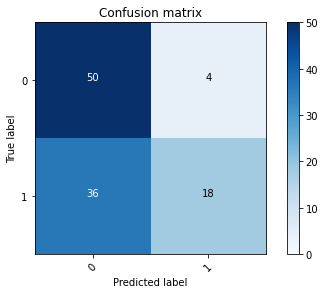

2022-07-06 15:54:56 - [Epoch Train: 4] loss: 0.5300, auc: 0.8898, acc: 0.7260, time: 34.00 s            
2022-07-06 15:54:56 - [Epoch Valid: 4] loss: 0.6371, auc: 0.7027, acc: 0.6296, time: 9.00 s
2022-07-06 15:54:56 - acc improved from 0.5093 to 0.6296. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e4-loss0.637-acc0.630-auc0.703.pth'


  3%|█                                        | 4/150 [03:00<1:49:06, 44.84s/it]

2022-07-06 15:54:56 - EPOCH: 5
2022-07-06 15:55:09 - Train Step 10/28, train_loss: 0.4729
2022-07-06 15:55:21 - Train Step 20/28, train_loss: 0.4683
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:55:38 - Valid Step 5/7, valid_loss: 0.6141
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
76      00028                1           1
63      00043                1           0
26      00052                1           1
95      00062                1           1
79      00064                0           1
34      00064                0           1
100     00072                0           1
39      00121                0           0
44      00121                0           0
72      00140                1           1
54      00142                0           0
106     00146                1           1
51      00150                0           0
33      00160                1           0
87      00167                0           0
11      00169                0        

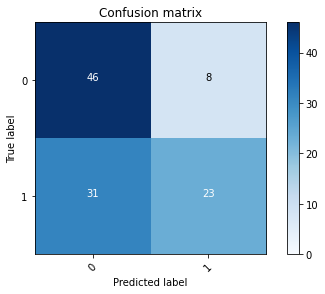

2022-07-06 15:55:40 - [Epoch Train: 5] loss: 0.4746, auc: 0.9296, acc: 0.7511, time: 34.00 s            
2022-07-06 15:55:40 - [Epoch Valid: 5] loss: 0.6267, auc: 0.7184, acc: 0.6389, time: 9.00 s
2022-07-06 15:55:40 - acc improved from 0.6296 to 0.6389. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e5-loss0.627-acc0.639-auc0.718.pth'


  3%|█▎                                       | 5/150 [03:44<1:47:38, 44.54s/it]

2022-07-06 15:55:40 - EPOCH: 6
2022-07-06 15:55:54 - Train Step 10/28, train_loss: 0.4097
2022-07-06 15:56:06 - Train Step 20/28, train_loss: 0.4044
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:56:24 - Valid Step 5/7, valid_loss: 0.6196
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
66      00028                1           1
29      00043                1           0
55      00052                1           0
51      00062                1           1
102     00064                0           0
0       00064                0           0
32      00072                0           0
39      00121                0           0
104     00121                0           0
16      00140                1           1
82      00142                0           0
83      00146                1           1
93      00150                0           0
31      00160                1           0
19      00167                0           0
86      00169                0        

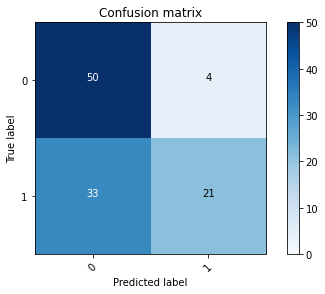

2022-07-06 15:56:26 - [Epoch Train: 6] loss: 0.4022, auc: 0.9670, acc: 0.8151, time: 36.00 s            
2022-07-06 15:56:26 - [Epoch Valid: 6] loss: 0.6027, auc: 0.7524, acc: 0.6574, time: 9.00 s
2022-07-06 15:56:26 - acc improved from 0.6389 to 0.6574. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e6-loss0.603-acc0.657-auc0.752.pth'


  4%|█▋                                       | 6/150 [04:30<1:48:11, 45.08s/it]

2022-07-06 15:56:26 - EPOCH: 7
2022-07-06 15:56:39 - Train Step 10/28, train_loss: 0.3580
2022-07-06 15:56:51 - Train Step 20/28, train_loss: 0.3427
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:57:07 - Valid Step 5/7, valid_loss: 0.5960
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
75      00028                1           1
11      00043                1           0
30      00052                1           0
94      00062                1           0
91      00064                0           0
28      00064                0           0
18      00072                0           0
66      00121                0           0
12      00121                0           0
101     00140                1           1
53      00142                0           0
15      00146                1           1
56      00150                0           0
86      00160                1           0
52      00167                0           0
72      00169                0        

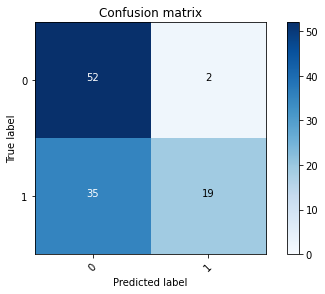

2022-07-06 15:57:09 - [Epoch Train: 7] loss: 0.3436, auc: 0.9763, acc: 0.8356, time: 33.00 s            
2022-07-06 15:57:09 - [Epoch Valid: 7] loss: 0.5927, auc: 0.7754, acc: 0.6574, time: 9.00 s
2022-07-06 15:57:09 - acc improved from 0.6574 to 0.6574. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e7-loss0.593-acc0.657-auc0.775.pth'


  5%|█▉                                       | 7/150 [05:13<1:45:51, 44.42s/it]

2022-07-06 15:57:09 - EPOCH: 8
2022-07-06 15:57:26 - Train Step 10/28, train_loss: 0.2829
2022-07-06 15:57:38 - Train Step 20/28, train_loss: 0.2859
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:57:54 - Valid Step 5/7, valid_loss: 0.5779
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
14      00028                1           1
36      00043                1           0
34      00052                1           0
43      00062                1           1
103     00064                0           1
5       00064                0           1
52      00072                0           0
25      00121                0           0
9       00121                0           0
32      00140                1           1
31      00142                0           0
95      00146                1           1
73      00150                0           0
53      00160                1           0
24      00167                0           0
59      00169                0        

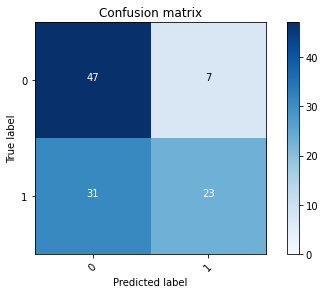

2022-07-06 15:57:56 - [Epoch Train: 8] loss: 0.2794, auc: 0.9920, acc: 0.8790, time: 37.00 s            
2022-07-06 15:57:56 - [Epoch Valid: 8] loss: 0.5721, auc: 0.8011, acc: 0.6481, time: 9.00 s


  5%|██▏                                      | 8/150 [06:00<1:46:57, 45.19s/it]

2022-07-06 15:57:56 - EPOCH: 9
2022-07-06 15:58:09 - Train Step 10/28, train_loss: 0.2258
2022-07-06 15:58:22 - Train Step 20/28, train_loss: 0.2227
Adjusting learning rate of group 0 to 1.0000e-04.
2022-07-06 15:58:38 - Valid Step 5/7, valid_loss: 0.6294
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
68      00028                1           1
54      00043                1           0
93      00052                1           0
52      00062                1           1
67      00064                0           1
15      00064                0           1
80      00072                0           0
50      00121                0           0
98      00121                0           0
70      00140                1           1
99      00142                0           0
12      00146                1           1
72      00150                0           0
21      00160                1           0
73      00167                0           0
101     00169                0        

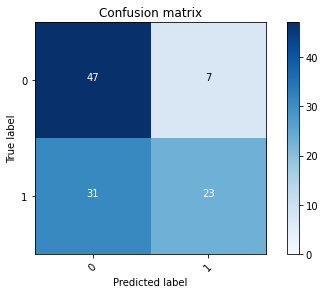

2022-07-06 15:58:40 - [Epoch Train: 9] loss: 0.2169, auc: 0.9971, acc: 0.9178, time: 34.00 s            
2022-07-06 15:58:40 - [Epoch Valid: 9] loss: 0.5756, auc: 0.8134, acc: 0.6481, time: 9.00 s


  6%|██▍                                      | 9/150 [06:44<1:45:24, 44.86s/it]

2022-07-06 15:58:40 - EPOCH: 10
2022-07-06 15:58:53 - Train Step 10/28, train_loss: 0.1772
2022-07-06 15:59:05 - Train Step 20/28, train_loss: 0.1720
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 15:59:23 - Valid Step 5/7, valid_loss: 0.5566
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
93      00028                1           1
0       00043                1           0
102     00052                1           0
20      00062                1           1
96      00064                0           1
3       00064                0           1
19      00072                0           0
8       00121                0           0
69      00121                0           0
65      00140                1           1
42      00142                0           0
34      00146                1           1
50      00150                0           0
63      00160                1           0
105     00167                0           0
2       00169                0       

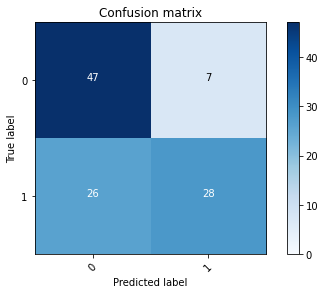

2022-07-06 15:59:24 - [Epoch Train: 10] loss: 0.1702, auc: 0.9988, acc: 0.9452, time: 34.00 s            
2022-07-06 15:59:24 - [Epoch Valid: 10] loss: 0.5531, auc: 0.8292, acc: 0.6944, time: 9.00 s
2022-07-06 15:59:24 - acc improved from 0.6574 to 0.6944. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e10-loss0.553-acc0.694-auc0.829.pth'


  7%|██▋                                     | 10/150 [07:29<1:44:20, 44.72s/it]

2022-07-06 15:59:24 - EPOCH: 11
2022-07-06 15:59:37 - Train Step 10/28, train_loss: 0.1386
2022-07-06 15:59:49 - Train Step 20/28, train_loss: 0.1328
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:00:06 - Valid Step 5/7, valid_loss: 0.5346
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
47      00028                1           1
25      00043                1           0
29      00052                1           0
76      00062                1           1
101     00064                0           1
75      00064                0           1
53      00072                0           0
88      00121                0           0
44      00121                0           0
52      00140                1           1
70      00142                0           0
19      00146                1           1
20      00150                0           0
37      00160                1           0
38      00167                0           0
107     00169                0       

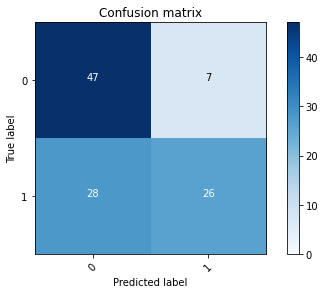

2022-07-06 16:00:08 - [Epoch Train: 11] loss: 0.1330, auc: 0.9998, acc: 0.9658, time: 34.00 s            
2022-07-06 16:00:08 - [Epoch Valid: 11] loss: 0.5625, auc: 0.8309, acc: 0.6759, time: 9.00 s


  7%|██▉                                     | 11/150 [08:12<1:42:46, 44.36s/it]

2022-07-06 16:00:08 - EPOCH: 12
2022-07-06 16:00:21 - Train Step 10/28, train_loss: 0.1331
2022-07-06 16:00:34 - Train Step 20/28, train_loss: 0.1217
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:00:50 - Valid Step 5/7, valid_loss: 0.5884
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
51      00028                1           1
3       00043                1           0
48      00052                1           0
16      00062                1           1
72      00064                0           1
32      00064                0           1
93      00072                0           0
91      00121                0           0
27      00121                0           0
47      00140                1           1
10      00142                0           0
90      00146                1           1
7       00150                0           0
43      00160                1           0
26      00167                0           0
95      00169                0       

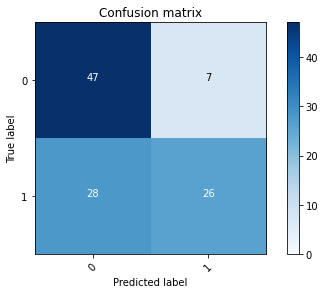

2022-07-06 16:00:52 - [Epoch Train: 12] loss: 0.1178, auc: 0.9997, acc: 0.9817, time: 34.00 s            
2022-07-06 16:00:52 - [Epoch Valid: 12] loss: 0.5697, auc: 0.8316, acc: 0.6759, time: 9.00 s


  8%|███▏                                    | 12/150 [08:56<1:41:26, 44.11s/it]

2022-07-06 16:00:52 - EPOCH: 13
2022-07-06 16:01:05 - Train Step 10/28, train_loss: 0.0959
2022-07-06 16:01:18 - Train Step 20/28, train_loss: 0.1011
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:01:35 - Valid Step 5/7, valid_loss: 0.5531
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
12      00028                1           1
105     00043                1           0
35      00052                1           0
86      00062                1           1
70      00064                0           1
9       00064                0           1
32      00072                0           0
2       00121                0           0
54      00121                0           0
31      00140                1           1
63      00142                0           0
37      00146                1           1
3       00150                0           0
61      00160                1           0
100     00167                0           0
83      00169                0       

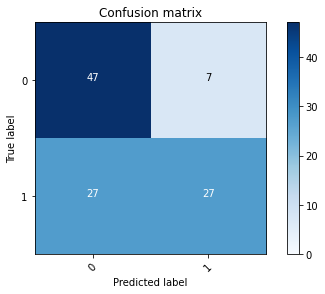

2022-07-06 16:01:37 - [Epoch Train: 13] loss: 0.1030, auc: 0.9999, acc: 0.9772, time: 35.00 s            
2022-07-06 16:01:37 - [Epoch Valid: 13] loss: 0.5666, auc: 0.8337, acc: 0.6852, time: 9.00 s


  9%|███▍                                    | 13/150 [09:41<1:41:41, 44.54s/it]

2022-07-06 16:01:37 - EPOCH: 14
2022-07-06 16:01:50 - Train Step 10/28, train_loss: 0.1018
2022-07-06 16:02:03 - Train Step 20/28, train_loss: 0.0928
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:02:19 - Valid Step 5/7, valid_loss: 0.5811
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
106     00028                1           1
86      00043                1           0
85      00052                1           0
53      00062                1           1
93      00064                0           1
55      00064                0           1
21      00072                0           0
44      00121                0           0
70      00121                0           0
84      00140                1           1
72      00142                0           0
88      00146                1           1
87      00150                0           0
51      00160                1           0
58      00167                0           0
16      00169                0       

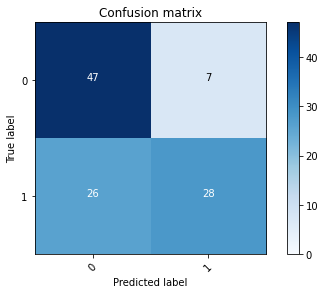

2022-07-06 16:02:21 - [Epoch Train: 14] loss: 0.0923, auc: 1.0000, acc: 0.9840, time: 34.00 s            
2022-07-06 16:02:21 - [Epoch Valid: 14] loss: 0.5745, auc: 0.8364, acc: 0.6944, time: 9.00 s
2022-07-06 16:02:21 - acc improved from 0.6944 to 0.6944. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e14-loss0.575-acc0.694-auc0.836.pth'


  9%|███▋                                    | 14/150 [10:25<1:40:35, 44.38s/it]

2022-07-06 16:02:21 - EPOCH: 15
2022-07-06 16:02:34 - Train Step 10/28, train_loss: 0.0814
2022-07-06 16:02:46 - Train Step 20/28, train_loss: 0.0784
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:03:03 - Valid Step 5/7, valid_loss: 0.5691
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
2       00028                1           1
85      00043                1           0
82      00052                1           0
88      00062                1           1
48      00064                0           1
76      00064                0           1
38      00072                0           0
31      00121                0           0
21      00121                0           0
22      00140                1           1
101     00142                0           0
104     00146                1           1
13      00150                0           0
32      00160                1           0
47      00167                0           0
60      00169                0       

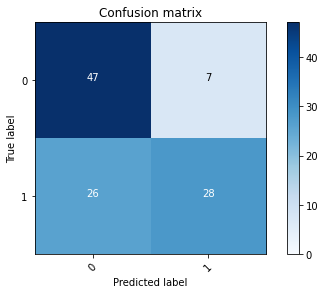

2022-07-06 16:03:05 - [Epoch Train: 15] loss: 0.0764, auc: 1.0000, acc: 0.9886, time: 34.00 s            
2022-07-06 16:03:05 - [Epoch Valid: 15] loss: 0.5855, auc: 0.8371, acc: 0.6944, time: 9.00 s
2022-07-06 16:03:05 - acc improved from 0.6944 to 0.6944. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e15-loss0.586-acc0.694-auc0.837.pth'


 10%|████                                    | 15/150 [11:09<1:39:32, 44.24s/it]

2022-07-06 16:03:05 - EPOCH: 16
2022-07-06 16:03:18 - Train Step 10/28, train_loss: 0.0627
2022-07-06 16:03:30 - Train Step 20/28, train_loss: 0.0677
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:03:47 - Valid Step 5/7, valid_loss: 0.6062
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
39      00028                1           1
37      00043                1           0
91      00052                1           0
53      00062                1           0
60      00064                0           1
61      00064                0           1
28      00072                0           0
89      00121                0           0
48      00121                0           0
2       00140                1           1
42      00142                0           0
9       00146                1           1
7       00150                0           0
64      00160                1           0
67      00167                0           0
92      00169                0       

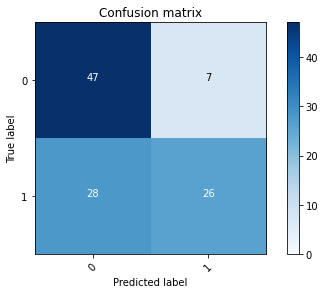

2022-07-06 16:03:49 - [Epoch Train: 16] loss: 0.0649, auc: 1.0000, acc: 0.9932, time: 34.00 s            
2022-07-06 16:03:49 - [Epoch Valid: 16] loss: 0.5970, auc: 0.8374, acc: 0.6759, time: 9.00 s


 11%|████▎                                   | 16/150 [11:53<1:38:42, 44.20s/it]

2022-07-06 16:03:49 - EPOCH: 17
2022-07-06 16:04:02 - Train Step 10/28, train_loss: 0.0631
2022-07-06 16:04:15 - Train Step 20/28, train_loss: 0.0610
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:04:32 - Valid Step 5/7, valid_loss: 0.6411
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
15      00028                1           1
5       00043                1           0
102     00052                1           0
86      00062                1           1
55      00064                0           1
79      00064                0           1
87      00072                0           0
66      00121                0           0
42      00121                0           0
0       00140                1           1
26      00142                0           0
43      00146                1           1
88      00150                0           0
36      00160                1           0
27      00167                0           0
33      00169                0       

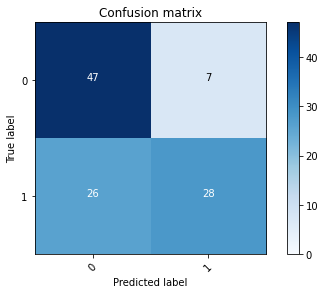

2022-07-06 16:04:34 - [Epoch Train: 17] loss: 0.0590, auc: 1.0000, acc: 0.9954, time: 34.00 s            
2022-07-06 16:04:34 - [Epoch Valid: 17] loss: 0.5956, auc: 0.8395, acc: 0.6944, time: 9.00 s
2022-07-06 16:04:34 - acc improved from 0.6944 to 0.6944. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e17-loss0.596-acc0.694-auc0.840.pth'


 11%|████▌                                   | 17/150 [12:38<1:38:05, 44.26s/it]

2022-07-06 16:04:34 - EPOCH: 18
2022-07-06 16:04:47 - Train Step 10/28, train_loss: 0.0501
2022-07-06 16:05:00 - Train Step 20/28, train_loss: 0.0498
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:05:17 - Valid Step 5/7, valid_loss: 0.4742
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
80      00028                1           1
4       00043                1           0
5       00052                1           0
43      00062                1           0
9       00064                0           1
10      00064                0           1
79      00072                0           0
107     00121                0           0
2       00121                0           0
77      00140                1           1
97      00142                0           0
53      00146                1           1
41      00150                0           0
0       00160                1           0
12      00167                0           0
20      00169                0       

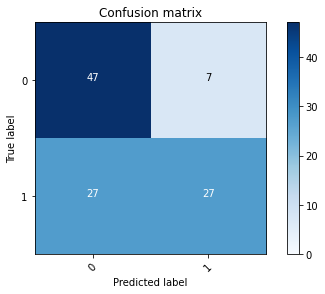

2022-07-06 16:05:19 - [Epoch Train: 18] loss: 0.0502, auc: 1.0000, acc: 0.9977, time: 35.00 s            
2022-07-06 16:05:19 - [Epoch Valid: 18] loss: 0.6073, auc: 0.8409, acc: 0.6852, time: 9.00 s


 12%|████▊                                   | 18/150 [13:23<1:37:59, 44.54s/it]

2022-07-06 16:05:19 - EPOCH: 19
2022-07-06 16:05:32 - Train Step 10/28, train_loss: 0.0493
2022-07-06 16:05:45 - Train Step 20/28, train_loss: 0.0430
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:06:02 - Valid Step 5/7, valid_loss: 0.6614
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
9       00028                1           1
78      00043                1           0
95      00052                1           0
69      00062                1           0
55      00064                0           1
81      00064                0           1
37      00072                0           0
103     00121                0           0
79      00121                0           0
38      00140                1           1
86      00142                0           0
51      00146                1           1
94      00150                0           0
93      00160                1           0
92      00167                0           0
35      00169                0       

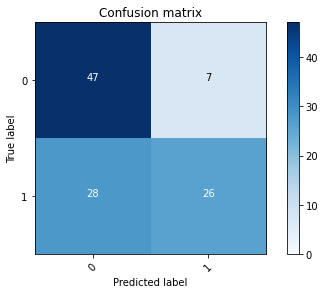

2022-07-06 16:06:04 - [Epoch Train: 19] loss: 0.0431, auc: 1.0000, acc: 0.9977, time: 35.00 s            
2022-07-06 16:06:04 - [Epoch Valid: 19] loss: 0.6207, auc: 0.8426, acc: 0.6759, time: 9.00 s


 13%|█████                                   | 19/150 [14:08<1:37:30, 44.66s/it]

2022-07-06 16:06:04 - EPOCH: 20
2022-07-06 16:06:17 - Train Step 10/28, train_loss: 0.0382
2022-07-06 16:06:30 - Train Step 20/28, train_loss: 0.0392
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:06:48 - Valid Step 5/7, valid_loss: 0.5243
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
6       00028                1           1
55      00043                1           0
45      00052                1           0
102     00062                1           0
57      00064                0           1
41      00064                0           1
58      00072                0           0
89      00121                0           0
5       00121                0           0
29      00140                1           1
100     00142                0           0
4       00146                1           1
18      00150                0           0
51      00160                1           0
25      00167                0           0
72      00169                0       

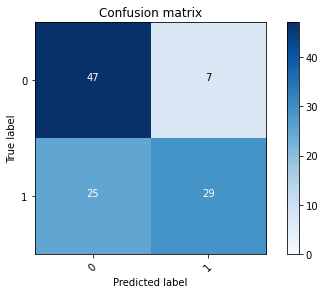

2022-07-06 16:06:50 - [Epoch Train: 20] loss: 0.0380, auc: 1.0000, acc: 0.9977, time: 36.00 s            
2022-07-06 16:06:50 - [Epoch Valid: 20] loss: 0.6155, auc: 0.8436, acc: 0.7037, time: 9.00 s
2022-07-06 16:06:50 - acc improved from 0.6944 to 0.7037. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e20-loss0.615-acc0.704-auc0.844.pth'


 13%|█████▎                                  | 20/150 [14:54<1:37:35, 45.04s/it]

2022-07-06 16:06:50 - EPOCH: 21
2022-07-06 16:07:03 - Train Step 10/28, train_loss: 0.0348
2022-07-06 16:07:16 - Train Step 20/28, train_loss: 0.0321
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:07:33 - Valid Step 5/7, valid_loss: 0.7332
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
103     00028                1           1
19      00043                1           0
46      00052                1           0
95      00062                1           0
96      00064                0           1
72      00064                0           1
51      00072                0           0
49      00121                0           0
77      00121                0           0
14      00140                1           1
45      00142                0           0
30      00146                1           1
22      00150                0           0
42      00160                1           0
41      00167                0           0
23      00169                0       

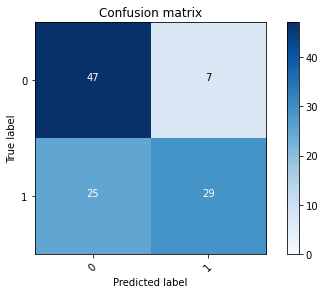

2022-07-06 16:07:35 - [Epoch Train: 21] loss: 0.0336, auc: 1.0000, acc: 0.9977, time: 35.00 s            
2022-07-06 16:07:35 - [Epoch Valid: 21] loss: 0.6281, auc: 0.8457, acc: 0.7037, time: 9.00 s
2022-07-06 16:07:35 - acc improved from 0.7037 to 0.7037. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e21-loss0.628-acc0.704-auc0.846.pth'


 14%|█████▌                                  | 21/150 [15:39<1:37:06, 45.17s/it]

2022-07-06 16:07:35 - EPOCH: 22
2022-07-06 16:07:49 - Train Step 10/28, train_loss: 0.0281
2022-07-06 16:08:01 - Train Step 20/28, train_loss: 0.0287
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:08:18 - Valid Step 5/7, valid_loss: 0.5917
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
70      00028                1           1
29      00043                1           0
43      00052                1           0
84      00062                1           0
106     00064                0           1
73      00064                0           1
40      00072                0           0
1       00121                0           0
30      00121                0           0
107     00140                1           1
21      00142                0           0
94      00146                1           1
66      00150                0           0
2       00160                1           0
49      00167                0           0
18      00169                0       

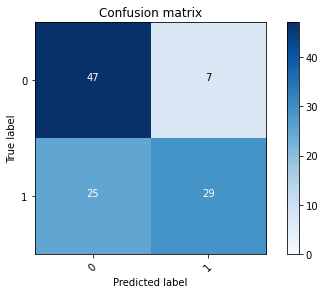

2022-07-06 16:08:20 - [Epoch Train: 22] loss: 0.0296, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:08:20 - [Epoch Valid: 22] loss: 0.6406, auc: 0.8460, acc: 0.7037, time: 9.00 s
2022-07-06 16:08:20 - acc improved from 0.7037 to 0.7037. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e22-loss0.641-acc0.704-auc0.846.pth'


 15%|█████▊                                  | 22/150 [16:24<1:35:57, 44.98s/it]

2022-07-06 16:08:20 - EPOCH: 23
2022-07-06 16:08:33 - Train Step 10/28, train_loss: 0.0238
2022-07-06 16:08:46 - Train Step 20/28, train_loss: 0.0237
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:09:03 - Valid Step 5/7, valid_loss: 0.5727
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
105     00028                1           1
56      00043                1           0
76      00052                1           0
54      00062                1           0
72      00064                0           1
79      00064                0           1
77      00072                0           0
32      00121                0           0
30      00121                0           0
1       00140                1           1
64      00142                0           0
28      00146                1           1
71      00150                0           0
3       00160                1           0
53      00167                0           0
86      00169                0       

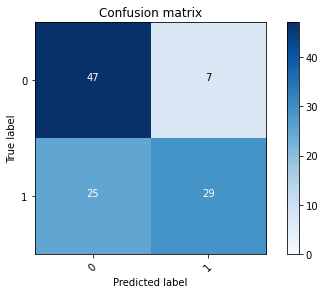

2022-07-06 16:09:05 - [Epoch Train: 23] loss: 0.0245, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:09:05 - [Epoch Valid: 23] loss: 0.6583, auc: 0.8491, acc: 0.7037, time: 9.00 s
2022-07-06 16:09:05 - acc improved from 0.7037 to 0.7037. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e23-loss0.658-acc0.704-auc0.849.pth'


 15%|██████▏                                 | 23/150 [17:09<1:35:33, 45.14s/it]

2022-07-06 16:09:05 - EPOCH: 24
2022-07-06 16:09:18 - Train Step 10/28, train_loss: 0.0239
2022-07-06 16:09:31 - Train Step 20/28, train_loss: 0.0235
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:09:47 - Valid Step 5/7, valid_loss: 0.6260
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
24      00028                1           1
59      00043                1           0
26      00052                1           0
2       00062                1           0
92      00064                0           1
89      00064                0           1
78      00072                0           0
102     00121                0           0
81      00121                0           0
96      00140                1           1
75      00142                0           0
74      00146                1           1
95      00150                0           0
31      00160                1           0
32      00167                0           0
22      00169                0       

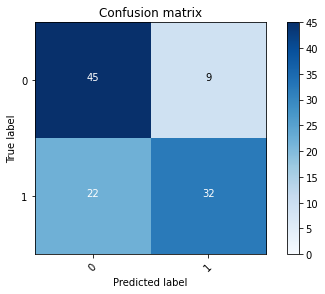

2022-07-06 16:09:49 - [Epoch Train: 24] loss: 0.0226, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:09:49 - [Epoch Valid: 24] loss: 0.6549, auc: 0.8484, acc: 0.7130, time: 9.00 s
2022-07-06 16:09:49 - acc improved from 0.7037 to 0.7130. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e24-loss0.655-acc0.713-auc0.848.pth'


 16%|██████▍                                 | 24/150 [17:53<1:33:55, 44.73s/it]

2022-07-06 16:09:49 - EPOCH: 25
2022-07-06 16:10:02 - Train Step 10/28, train_loss: 0.0226
2022-07-06 16:10:15 - Train Step 20/28, train_loss: 0.0201
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:10:32 - Valid Step 5/7, valid_loss: 0.5227
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
94      00028                1           1
107     00043                1           0
21      00052                1           0
64      00062                1           0
105     00064                0           1
24      00064                0           1
6       00072                0           0
8       00121                0           0
17      00121                0           0
47      00140                1           1
62      00142                0           0
18      00146                1           1
50      00150                0           0
44      00160                1           0
46      00167                0           0
0       00169                0       

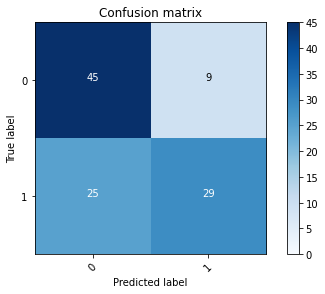

2022-07-06 16:10:34 - [Epoch Train: 25] loss: 0.0200, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:10:34 - [Epoch Valid: 25] loss: 0.6808, auc: 0.8495, acc: 0.6852, time: 9.00 s


 17%|██████▋                                 | 25/150 [18:39<1:33:35, 44.92s/it]

2022-07-06 16:10:34 - EPOCH: 26
2022-07-06 16:10:47 - Train Step 10/28, train_loss: 0.0228
2022-07-06 16:11:00 - Train Step 20/28, train_loss: 0.0212
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:11:17 - Valid Step 5/7, valid_loss: 0.5983
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
19      00028                1           1
85      00043                1           0
92      00052                1           0
73      00062                1           0
0       00064                0           1
53      00064                0           1
11      00072                0           0
17      00121                0           0
50      00121                0           0
64      00140                1           1
45      00142                0           0
68      00146                1           1
66      00150                0           0
23      00160                1           0
81      00167                0           0
96      00169                0       

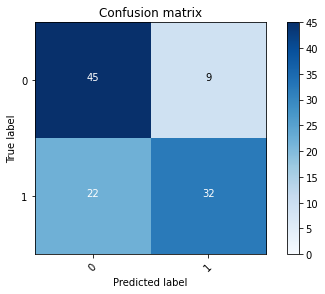

2022-07-06 16:11:19 - [Epoch Train: 26] loss: 0.0200, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:11:19 - [Epoch Valid: 26] loss: 0.6768, auc: 0.8522, acc: 0.7130, time: 9.00 s
2022-07-06 16:11:19 - acc improved from 0.7130 to 0.7130. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e26-loss0.677-acc0.713-auc0.852.pth'


 17%|██████▉                                 | 26/150 [19:23<1:32:27, 44.74s/it]

2022-07-06 16:11:19 - EPOCH: 27
2022-07-06 16:11:32 - Train Step 10/28, train_loss: 0.0166
2022-07-06 16:11:45 - Train Step 20/28, train_loss: 0.0146
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:12:02 - Valid Step 5/7, valid_loss: 0.7165
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
91      00028                1           1
63      00043                1           0
85      00052                1           0
39      00062                1           0
26      00064                0           1
11      00064                0           1
4       00072                0           0
80      00121                0           0
93      00121                0           0
61      00140                1           1
41      00142                0           0
3       00146                1           1
56      00150                0           0
21      00160                1           0
57      00167                0           0
88      00169                0       

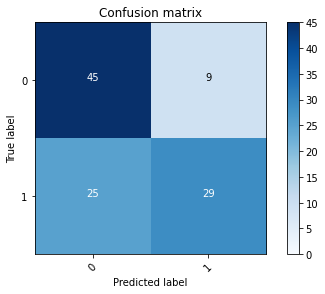

2022-07-06 16:12:04 - [Epoch Train: 27] loss: 0.0159, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:12:04 - [Epoch Valid: 27] loss: 0.7002, auc: 0.8495, acc: 0.6852, time: 9.00 s


 18%|███████▏                                | 27/150 [20:08<1:31:54, 44.83s/it]

2022-07-06 16:12:04 - EPOCH: 28
2022-07-06 16:12:17 - Train Step 10/28, train_loss: 0.0172
2022-07-06 16:12:30 - Train Step 20/28, train_loss: 0.0157
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:12:46 - Valid Step 5/7, valid_loss: 0.6612
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
60      00028                1           1
24      00043                1           0
1       00052                1           0
101     00062                1           0
82      00064                0           1
25      00064                0           1
3       00072                0           0
49      00121                0           0
80      00121                0           0
75      00140                1           1
15      00142                0           0
43      00146                1           1
85      00150                0           0
56      00160                1           0
76      00167                0           0
13      00169                0       

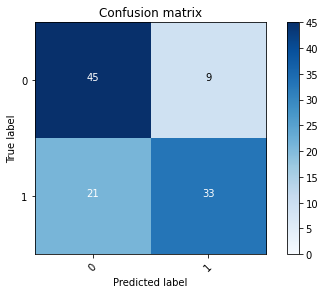

2022-07-06 16:12:48 - [Epoch Train: 28] loss: 0.0156, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:12:48 - [Epoch Valid: 28] loss: 0.6935, auc: 0.8501, acc: 0.7222, time: 9.00 s
2022-07-06 16:12:48 - acc improved from 0.7130 to 0.7222. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e28-loss0.693-acc0.722-auc0.850.pth'


 19%|███████▍                                | 28/150 [20:52<1:30:42, 44.61s/it]

2022-07-06 16:12:48 - EPOCH: 29
2022-07-06 16:13:01 - Train Step 10/28, train_loss: 0.0125
2022-07-06 16:13:13 - Train Step 20/28, train_loss: 0.0130
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:13:30 - Valid Step 5/7, valid_loss: 0.7150
First 64 results:
   BraTS21ID  MGMT_real_value  MGMT_value
20     00028                1           1
37     00043                1           0
42     00052                1           0
0      00062                1           0
62     00064                0           1
98     00064                0           1
55     00072                0           0
4      00121                0           0
23     00121                0           0
58     00140                1           1
17     00142                0           0
7      00146                1           1
12     00150                0           0
80     00160                1           0
24     00167                0           0
67     00169                0           0
95     0017

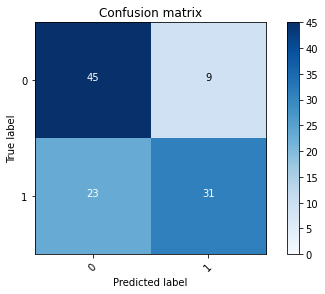

2022-07-06 16:13:32 - [Epoch Train: 29] loss: 0.0133, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:13:32 - [Epoch Valid: 29] loss: 0.7172, auc: 0.8481, acc: 0.7037, time: 9.00 s


 19%|███████▋                                | 29/150 [21:36<1:29:39, 44.46s/it]

2022-07-06 16:13:32 - EPOCH: 30
2022-07-06 16:13:45 - Train Step 10/28, train_loss: 0.0113
2022-07-06 16:13:58 - Train Step 20/28, train_loss: 0.0123
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:14:14 - Valid Step 5/7, valid_loss: 0.6373
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
7       00028                1           1
19      00043                1           0
57      00052                1           0
27      00062                1           0
54      00064                0           1
36      00064                0           1
58      00072                0           0
29      00121                0           0
51      00121                0           0
70      00140                1           1
93      00142                0           0
33      00146                1           1
15      00150                0           0
6       00160                1           0
101     00167                0           0
47      00169                0       

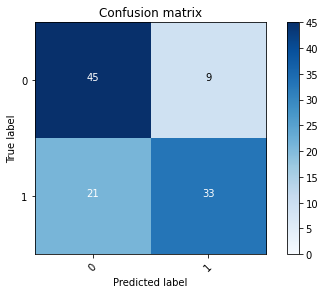

2022-07-06 16:14:16 - [Epoch Train: 30] loss: 0.0124, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:14:16 - [Epoch Valid: 30] loss: 0.7092, auc: 0.8481, acc: 0.7222, time: 9.00 s
2022-07-06 16:14:16 - acc improved from 0.7222 to 0.7222. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e30-loss0.709-acc0.722-auc0.848.pth'


 20%|████████                                | 30/150 [22:21<1:28:55, 44.46s/it]

2022-07-06 16:14:16 - EPOCH: 31
2022-07-06 16:14:30 - Train Step 10/28, train_loss: 0.0140
2022-07-06 16:14:42 - Train Step 20/28, train_loss: 0.0126
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:15:00 - Valid Step 5/7, valid_loss: 0.6466
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
25      00028                1           1
34      00043                1           0
28      00052                1           0
64      00062                1           0
58      00064                0           1
27      00064                0           1
63      00072                0           0
5       00121                0           0
82      00121                0           0
61      00140                1           1
54      00142                0           0
15      00146                1           1
35      00150                0           0
67      00160                1           0
1       00167                0           0
84      00169                0       

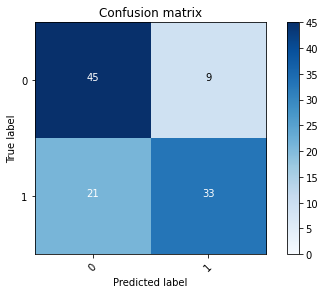

2022-07-06 16:15:02 - [Epoch Train: 31] loss: 0.0118, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:15:02 - [Epoch Valid: 31] loss: 0.7316, auc: 0.8484, acc: 0.7222, time: 9.00 s
2022-07-06 16:15:02 - acc improved from 0.7222 to 0.7222. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e31-loss0.732-acc0.722-auc0.848.pth'


 21%|████████▎                               | 31/150 [23:06<1:28:46, 44.76s/it]

2022-07-06 16:15:02 - EPOCH: 32
2022-07-06 16:15:15 - Train Step 10/28, train_loss: 0.0093
2022-07-06 16:15:27 - Train Step 20/28, train_loss: 0.0107
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:15:44 - Valid Step 5/7, valid_loss: 0.7120
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
11      00028                1           1
100     00043                1           0
7       00052                1           0
36      00062                1           0
8       00064                0           1
45      00064                0           1
95      00072                0           0
93      00121                0           0
77      00121                0           0
55      00140                1           1
13      00142                0           0
89      00146                1           1
65      00150                0           0
17      00160                1           0
60      00167                0           0
30      00169                0       

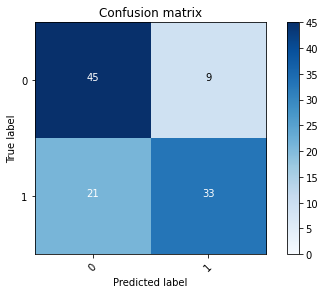

2022-07-06 16:15:46 - [Epoch Train: 32] loss: 0.0103, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:15:46 - [Epoch Valid: 32] loss: 0.7398, auc: 0.8488, acc: 0.7222, time: 9.00 s
2022-07-06 16:15:46 - acc improved from 0.7222 to 0.7222. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e32-loss0.740-acc0.722-auc0.849.pth'


 21%|████████▌                               | 32/150 [23:51<1:27:53, 44.69s/it]

2022-07-06 16:15:46 - EPOCH: 33
2022-07-06 16:15:59 - Train Step 10/28, train_loss: 0.0091
2022-07-06 16:16:12 - Train Step 20/28, train_loss: 0.0092
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:16:29 - Valid Step 5/7, valid_loss: 0.8059
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
98      00028                1           1
29      00043                1           0
102     00052                1           0
31      00062                1           0
19      00064                0           1
69      00064                0           1
106     00072                0           0
4       00121                0           0
51      00121                0           0
57      00140                1           1
85      00142                0           0
26      00146                1           1
66      00150                0           0
93      00160                1           0
40      00167                0           0
54      00169                0       

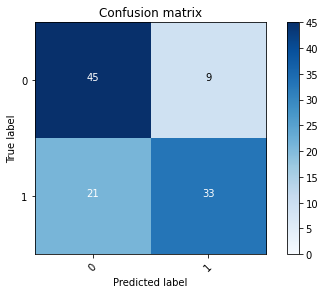

2022-07-06 16:16:30 - [Epoch Train: 33] loss: 0.0094, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:16:30 - [Epoch Valid: 33] loss: 0.7587, auc: 0.8488, acc: 0.7222, time: 9.00 s
2022-07-06 16:16:30 - acc improved from 0.7222 to 0.7222. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e33-loss0.759-acc0.722-auc0.849.pth'


 22%|████████▊                               | 33/150 [24:35<1:26:46, 44.50s/it]

2022-07-06 16:16:30 - EPOCH: 34
2022-07-06 16:16:43 - Train Step 10/28, train_loss: 0.0105
2022-07-06 16:16:56 - Train Step 20/28, train_loss: 0.0088
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:17:13 - Valid Step 5/7, valid_loss: 0.7286
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
32      00028                1           1
75      00043                1           0
49      00052                1           0
28      00062                1           0
37      00064                0           1
101     00064                0           1
94      00072                0           0
64      00121                0           0
23      00121                0           0
82      00140                1           1
34      00142                0           0
41      00146                1           1
68      00150                0           0
52      00160                1           0
27      00167                0           0
67      00169                0       

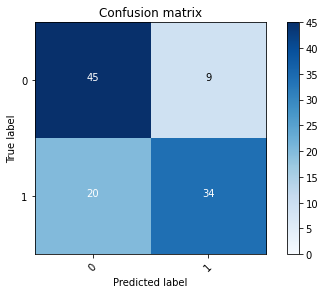

2022-07-06 16:17:15 - [Epoch Train: 34] loss: 0.0085, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:17:15 - [Epoch Valid: 34] loss: 0.7637, auc: 0.8495, acc: 0.7315, time: 9.00 s
2022-07-06 16:17:15 - acc improved from 0.7222 to 0.7315. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e34-loss0.764-acc0.731-auc0.849.pth'


 23%|█████████                               | 34/150 [25:19<1:25:51, 44.41s/it]

2022-07-06 16:17:15 - EPOCH: 35
2022-07-06 16:17:28 - Train Step 10/28, train_loss: 0.0065
2022-07-06 16:17:41 - Train Step 20/28, train_loss: 0.0078
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:17:58 - Valid Step 5/7, valid_loss: 0.6491
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
47      00028                1           1
58      00043                1           0
14      00052                1           0
34      00062                1           0
15      00064                0           1
70      00064                0           1
5       00072                0           0
48      00121                0           0
30      00121                0           0
89      00140                1           1
86      00142                0           0
103     00146                1           1
25      00150                0           0
83      00160                1           0
93      00167                0           0
85      00169                0       

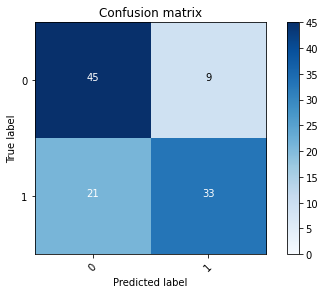

2022-07-06 16:18:00 - [Epoch Train: 35] loss: 0.0076, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:18:00 - [Epoch Valid: 35] loss: 0.7836, auc: 0.8495, acc: 0.7222, time: 9.00 s


 23%|█████████▎                              | 35/150 [26:04<1:25:42, 44.72s/it]

2022-07-06 16:18:00 - EPOCH: 36
2022-07-06 16:18:13 - Train Step 10/28, train_loss: 0.0071
2022-07-06 16:18:26 - Train Step 20/28, train_loss: 0.0072
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:18:43 - Valid Step 5/7, valid_loss: 0.9561
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
102     00028                1           1
6       00043                1           0
11      00052                1           0
89      00062                1           0
86      00064                0           1
52      00064                0           1
34      00072                0           0
77      00121                0           0
39      00121                0           0
84      00140                1           1
21      00142                0           0
67      00146                1           1
7       00150                0           0
60      00160                1           0
38      00167                0           0
65      00169                0       

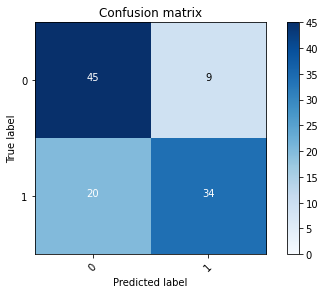

2022-07-06 16:18:45 - [Epoch Train: 36] loss: 0.0069, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:18:45 - [Epoch Valid: 36] loss: 0.7813, auc: 0.8488, acc: 0.7315, time: 9.00 s
2022-07-06 16:18:45 - acc improved from 0.7315 to 0.7315. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e36-loss0.781-acc0.731-auc0.849.pth'


 24%|█████████▌                              | 36/150 [26:49<1:25:09, 44.82s/it]

2022-07-06 16:18:45 - EPOCH: 37
2022-07-06 16:18:58 - Train Step 10/28, train_loss: 0.0063
2022-07-06 16:19:11 - Train Step 20/28, train_loss: 0.0064
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:19:27 - Valid Step 5/7, valid_loss: 0.8420
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
54      00028                1           1
94      00043                1           0
21      00052                1           0
4       00062                1           0
2       00064                0           1
72      00064                0           1
58      00072                0           0
105     00121                0           0
45      00121                0           0
59      00140                1           1
66      00142                0           0
13      00146                1           1
78      00150                0           0
63      00160                1           0
89      00167                0           0
101     00169                0       

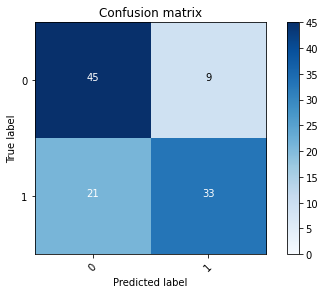

2022-07-06 16:19:29 - [Epoch Train: 37] loss: 0.0065, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:19:29 - [Epoch Valid: 37] loss: 0.7930, auc: 0.8484, acc: 0.7222, time: 9.00 s


 25%|█████████▊                              | 37/150 [27:33<1:23:41, 44.44s/it]

2022-07-06 16:19:29 - EPOCH: 38
2022-07-06 16:19:42 - Train Step 10/28, train_loss: 0.0070
2022-07-06 16:19:54 - Train Step 20/28, train_loss: 0.0060
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:20:11 - Valid Step 5/7, valid_loss: 0.9133
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
14      00028                1           1
102     00043                1           0
85      00052                1           0
95      00062                1           0
82      00064                0           1
54      00064                0           1
3       00072                0           0
93      00121                0           0
48      00121                0           0
5       00140                1           1
68      00142                0           0
33      00146                1           1
31      00150                0           0
24      00160                1           0
100     00167                0           0
11      00169                0       

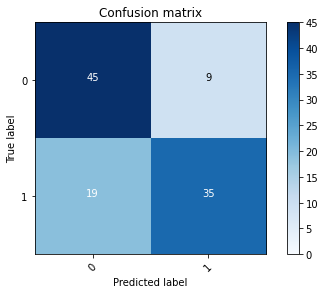

2022-07-06 16:20:13 - [Epoch Train: 38] loss: 0.0059, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:20:13 - [Epoch Valid: 38] loss: 0.7834, auc: 0.8505, acc: 0.7407, time: 9.00 s
2022-07-06 16:20:13 - acc improved from 0.7315 to 0.7407. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e38-loss0.783-acc0.741-auc0.850.pth'


 25%|██████████▏                             | 38/150 [28:17<1:22:44, 44.33s/it]

2022-07-06 16:20:13 - EPOCH: 39
2022-07-06 16:20:26 - Train Step 10/28, train_loss: 0.0060
2022-07-06 16:20:39 - Train Step 20/28, train_loss: 0.0058
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:20:56 - Valid Step 5/7, valid_loss: 0.7416
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
38      00028                1           1
11      00043                1           0
61      00052                1           0
92      00062                1           0
60      00064                0           1
42      00064                0           1
30      00072                0           0
27      00121                0           0
13      00121                0           0
36      00140                1           1
45      00142                0           0
91      00146                1           1
71      00150                0           0
47      00160                1           0
35      00167                0           0
37      00169                0       

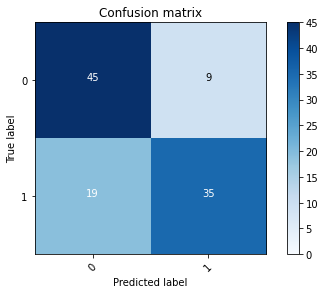

2022-07-06 16:20:58 - [Epoch Train: 39] loss: 0.0054, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:20:58 - [Epoch Valid: 39] loss: 0.8250, auc: 0.8512, acc: 0.7407, time: 9.00 s
2022-07-06 16:20:58 - acc improved from 0.7407 to 0.7407. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e39-loss0.825-acc0.741-auc0.851.pth'


 26%|██████████▍                             | 39/150 [29:02<1:22:23, 44.53s/it]

2022-07-06 16:20:58 - EPOCH: 40
2022-07-06 16:21:11 - Train Step 10/28, train_loss: 0.0041
2022-07-06 16:21:24 - Train Step 20/28, train_loss: 0.0052
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:21:41 - Valid Step 5/7, valid_loss: 0.7770
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
29      00028                1           1
38      00043                1           0
89      00052                1           0
85      00062                1           0
102     00064                0           1
42      00064                0           1
68      00072                0           0
103     00121                0           0
61      00121                0           0
82      00140                1           1
40      00142                0           0
67      00146                1           1
30      00150                0           0
5       00160                1           0
72      00167                0           0
106     00169                0       

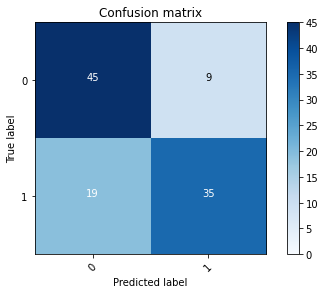

2022-07-06 16:21:43 - [Epoch Train: 40] loss: 0.0052, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:21:43 - [Epoch Valid: 40] loss: 0.8088, auc: 0.8508, acc: 0.7407, time: 9.00 s
2022-07-06 16:21:43 - acc improved from 0.7407 to 0.7407. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e40-loss0.809-acc0.741-auc0.851.pth'


 27%|██████████▋                             | 40/150 [29:48<1:22:18, 44.90s/it]

2022-07-06 16:21:43 - EPOCH: 41
2022-07-06 16:21:57 - Train Step 10/28, train_loss: 0.0057
2022-07-06 16:22:09 - Train Step 20/28, train_loss: 0.0050
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:22:25 - Valid Step 5/7, valid_loss: 0.8104
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
89      00028                1           1
31      00043                1           0
24      00052                1           0
100     00062                1           0
73      00064                0           1
70      00064                0           1
74      00072                0           0
61      00121                0           0
103     00121                0           0
77      00140                1           1
102     00142                0           0
12      00146                1           1
30      00150                0           0
54      00160                1           0
9       00167                0           0
81      00169                0       

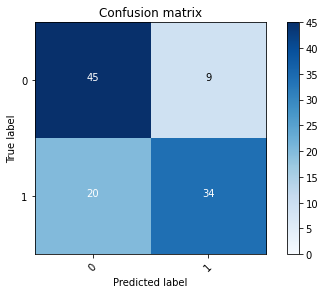

2022-07-06 16:22:27 - [Epoch Train: 41] loss: 0.0048, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:22:27 - [Epoch Valid: 41] loss: 0.8318, auc: 0.8484, acc: 0.7315, time: 9.00 s


 27%|██████████▉                             | 41/150 [30:31<1:20:58, 44.58s/it]

2022-07-06 16:22:27 - EPOCH: 42
2022-07-06 16:22:40 - Train Step 10/28, train_loss: 0.0041
2022-07-06 16:22:53 - Train Step 20/28, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:23:10 - Valid Step 5/7, valid_loss: 0.8235
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
107     00028                1           1
103     00043                1           0
37      00052                1           0
99      00062                1           0
55      00064                0           1
26      00064                0           1
13      00072                0           0
58      00121                0           0
41      00121                0           0
79      00140                1           1
8       00142                0           0
54      00146                1           1
39      00150                0           0
82      00160                1           0
51      00167                0           0
15      00169                0       

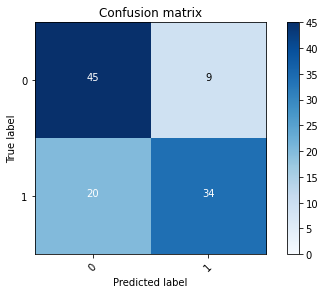

2022-07-06 16:23:12 - [Epoch Train: 42] loss: 0.0041, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:23:12 - [Epoch Valid: 42] loss: 0.8281, auc: 0.8501, acc: 0.7315, time: 9.00 s


 28%|███████████▏                            | 42/150 [31:16<1:20:08, 44.52s/it]

2022-07-06 16:23:12 - EPOCH: 43
2022-07-06 16:23:25 - Train Step 10/28, train_loss: 0.0046
2022-07-06 16:23:37 - Train Step 20/28, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:23:54 - Valid Step 5/7, valid_loss: 0.8032
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
15      00028                1           1
91      00043                1           0
60      00052                1           0
32      00062                1           0
13      00064                0           1
75      00064                0           1
30      00072                0           0
65      00121                0           0
74      00121                0           0
61      00140                1           1
92      00142                0           0
4       00146                1           1
39      00150                0           0
7       00160                1           0
81      00167                0           0
63      00169                0       

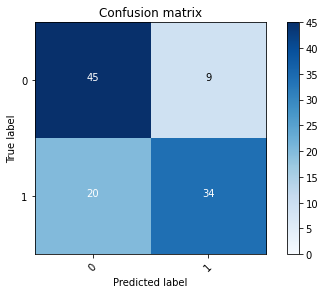

2022-07-06 16:23:56 - [Epoch Train: 43] loss: 0.0040, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:23:56 - [Epoch Valid: 43] loss: 0.8632, auc: 0.8495, acc: 0.7315, time: 9.00 s


 29%|███████████▍                            | 43/150 [32:00<1:19:22, 44.51s/it]

2022-07-06 16:23:56 - EPOCH: 44
2022-07-06 16:24:09 - Train Step 10/28, train_loss: 0.0035
2022-07-06 16:24:22 - Train Step 20/28, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:24:38 - Valid Step 5/7, valid_loss: 0.9510
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
57      00028                1           1
17      00043                1           0
16      00052                1           0
27      00062                1           0
39      00064                0           1
54      00064                0           1
29      00072                0           0
52      00121                0           0
50      00121                0           0
37      00140                1           1
46      00142                0           0
47      00146                1           1
5       00150                0           0
94      00160                1           0
101     00167                0           0
21      00169                0       

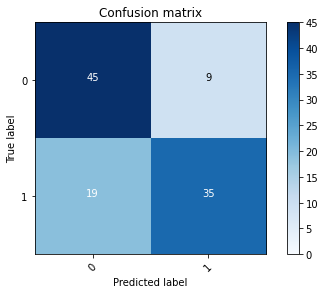

2022-07-06 16:24:40 - [Epoch Train: 44] loss: 0.0041, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:24:40 - [Epoch Valid: 44] loss: 0.8492, auc: 0.8495, acc: 0.7407, time: 9.00 s
2022-07-06 16:24:40 - acc improved from 0.7407 to 0.7407. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e44-loss0.849-acc0.741-auc0.849.pth'


 29%|███████████▋                            | 44/150 [32:45<1:18:28, 44.42s/it]

2022-07-06 16:24:40 - EPOCH: 45
2022-07-06 16:24:54 - Train Step 10/28, train_loss: 0.0031
2022-07-06 16:25:07 - Train Step 20/28, train_loss: 0.0035
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:25:25 - Valid Step 5/7, valid_loss: 0.8662
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
97      00028                1           1
51      00043                1           0
67      00052                1           0
7       00062                1           0
80      00064                0           1
54      00064                0           1
13      00072                0           0
34      00121                0           0
94      00121                0           0
43      00140                1           1
79      00142                0           0
14      00146                1           1
20      00150                0           0
48      00160                1           0
89      00167                0           0
33      00169                0       

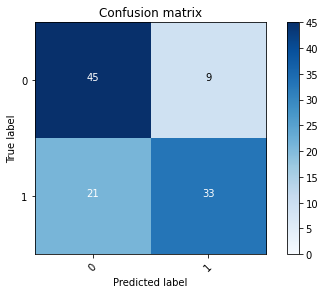

2022-07-06 16:25:26 - [Epoch Train: 45] loss: 0.0036, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:25:26 - [Epoch Valid: 45] loss: 0.8675, auc: 0.8495, acc: 0.7222, time: 9.00 s


 30%|████████████                            | 45/150 [33:31<1:18:39, 44.94s/it]

2022-07-06 16:25:26 - EPOCH: 46
2022-07-06 16:25:39 - Train Step 10/28, train_loss: 0.0029
2022-07-06 16:25:52 - Train Step 20/28, train_loss: 0.0032
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:26:08 - Valid Step 5/7, valid_loss: 0.7249
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
99      00028                1           1
83      00043                1           0
74      00052                1           0
49      00062                1           0
5       00064                0           1
38      00064                0           1
72      00072                0           0
65      00121                0           0
94      00121                0           0
95      00140                1           1
4       00142                0           0
44      00146                1           1
56      00150                0           0
20      00160                1           0
60      00167                0           0
18      00169                0       

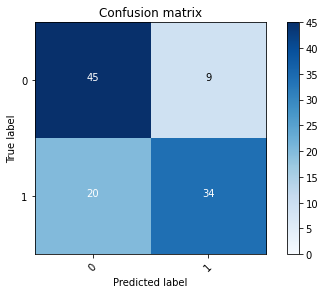

2022-07-06 16:26:10 - [Epoch Train: 46] loss: 0.0035, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:26:10 - [Epoch Valid: 46] loss: 0.8710, auc: 0.8498, acc: 0.7315, time: 9.00 s


 31%|████████████▎                           | 46/150 [34:15<1:17:22, 44.64s/it]

2022-07-06 16:26:10 - EPOCH: 47
2022-07-06 16:26:23 - Train Step 10/28, train_loss: 0.0031
2022-07-06 16:26:36 - Train Step 20/28, train_loss: 0.0031
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:26:52 - Valid Step 5/7, valid_loss: 0.7805
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
80      00028                1           1
69      00043                1           0
102     00052                1           0
62      00062                1           0
95      00064                0           1
90      00064                0           1
46      00072                0           0
107     00121                0           0
8       00121                0           0
89      00140                1           1
83      00142                0           0
44      00146                1           1
51      00150                0           0
106     00160                1           0
88      00167                0           0
94      00169                0       

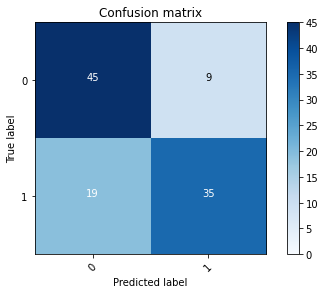

2022-07-06 16:26:54 - [Epoch Train: 47] loss: 0.0030, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:26:54 - [Epoch Valid: 47] loss: 0.8873, auc: 0.8501, acc: 0.7407, time: 9.00 s
2022-07-06 16:26:54 - acc improved from 0.7407 to 0.7407. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e47-loss0.887-acc0.741-auc0.850.pth'


 31%|████████████▌                           | 47/150 [34:59<1:16:15, 44.42s/it]

2022-07-06 16:26:54 - EPOCH: 48
2022-07-06 16:27:08 - Train Step 10/28, train_loss: 0.0040
2022-07-06 16:27:21 - Train Step 20/28, train_loss: 0.0032
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:27:38 - Valid Step 5/7, valid_loss: 1.0462
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
107     00028                1           1
45      00043                1           0
13      00052                1           0
1       00062                1           0
27      00064                0           1
32      00064                0           1
103     00072                0           0
46      00121                0           0
14      00121                0           0
52      00140                1           1
23      00142                0           0
41      00146                1           1
61      00150                0           0
29      00160                1           0
64      00167                0           0
56      00169                0       

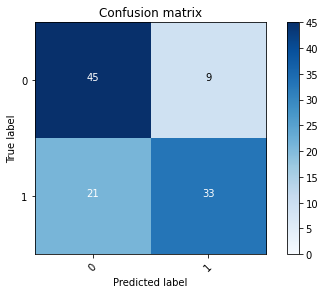

2022-07-06 16:27:40 - [Epoch Train: 48] loss: 0.0030, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:27:40 - [Epoch Valid: 48] loss: 0.9043, auc: 0.8498, acc: 0.7222, time: 9.00 s


 32%|████████████▊                           | 48/150 [35:44<1:16:07, 44.78s/it]

2022-07-06 16:27:40 - EPOCH: 49
2022-07-06 16:27:54 - Train Step 10/28, train_loss: 0.0026
2022-07-06 16:28:07 - Train Step 20/28, train_loss: 0.0025
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:28:24 - Valid Step 5/7, valid_loss: 0.9724
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
51      00028                1           1
26      00043                1           0
95      00052                1           0
39      00062                1           0
89      00064                0           1
8       00064                0           1
58      00072                0           0
66      00121                0           0
41      00121                0           0
69      00140                1           1
55      00142                0           0
93      00146                1           1
7       00150                0           0
23      00160                1           0
52      00167                0           0
9       00169                0       

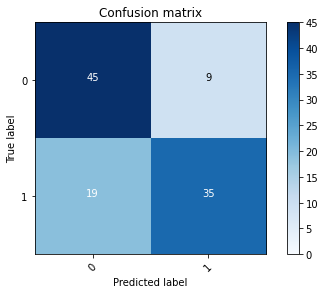

2022-07-06 16:28:26 - [Epoch Train: 49] loss: 0.0028, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:28:26 - [Epoch Valid: 49] loss: 0.8686, auc: 0.8501, acc: 0.7407, time: 9.00 s
2022-07-06 16:28:26 - acc improved from 0.7407 to 0.7407. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e49-loss0.869-acc0.741-auc0.850.pth'


 33%|█████████████                           | 49/150 [36:31<1:16:10, 45.25s/it]

2022-07-06 16:28:26 - EPOCH: 50
2022-07-06 16:28:40 - Train Step 10/28, train_loss: 0.0028
2022-07-06 16:28:53 - Train Step 20/28, train_loss: 0.0025
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:29:10 - Valid Step 5/7, valid_loss: 0.9933
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
0       00028                1           1
31      00043                1           0
53      00052                1           0
59      00062                1           0
16      00064                0           1
84      00064                0           1
81      00072                0           0
102     00121                0           0
18      00121                0           0
66      00140                1           1
54      00142                0           0
28      00146                1           1
32      00150                0           0
76      00160                1           0
34      00167                0           0
3       00169                0       

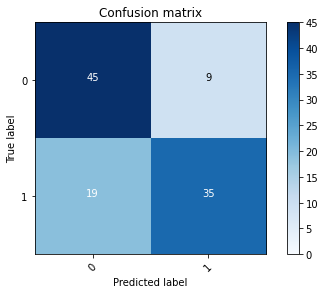

2022-07-06 16:29:12 - [Epoch Train: 50] loss: 0.0026, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:29:12 - [Epoch Valid: 50] loss: 0.9034, auc: 0.8508, acc: 0.7407, time: 9.00 s
2022-07-06 16:29:12 - acc improved from 0.7407 to 0.7407. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e50-loss0.903-acc0.741-auc0.851.pth'


 33%|█████████████▎                          | 50/150 [37:17<1:15:47, 45.48s/it]

2022-07-06 16:29:12 - EPOCH: 51
2022-07-06 16:29:25 - Train Step 10/28, train_loss: 0.0020
2022-07-06 16:29:38 - Train Step 20/28, train_loss: 0.0021
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:29:55 - Valid Step 5/7, valid_loss: 0.9012
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
102     00028                1           1
35      00043                1           0
94      00052                1           0
51      00062                1           0
97      00064                0           1
34      00064                0           1
17      00072                0           0
91      00121                0           0
89      00121                0           0
57      00140                1           1
43      00142                0           0
30      00146                1           1
83      00150                0           0
106     00160                1           0
71      00167                0           0
78      00169                0       

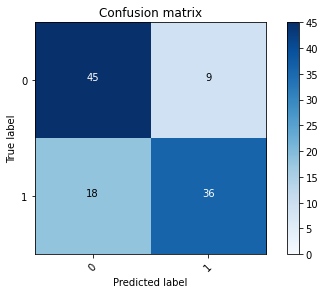

2022-07-06 16:29:57 - [Epoch Train: 51] loss: 0.0024, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:29:57 - [Epoch Valid: 51] loss: 0.8996, auc: 0.8488, acc: 0.7500, time: 9.00 s
2022-07-06 16:29:57 - acc improved from 0.7407 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e51-loss0.900-acc0.750-auc0.849.pth'


 34%|█████████████▌                          | 51/150 [38:01<1:14:35, 45.21s/it]

2022-07-06 16:29:57 - EPOCH: 52
2022-07-06 16:30:10 - Train Step 10/28, train_loss: 0.0019
2022-07-06 16:30:22 - Train Step 20/28, train_loss: 0.0022
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:30:38 - Valid Step 5/7, valid_loss: 0.8698
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
79      00028                1           1
7       00043                1           0
52      00052                1           0
107     00062                1           0
89      00064                0           1
34      00064                0           1
67      00072                0           0
3       00121                0           0
11      00121                0           0
0       00140                1           1
63      00142                0           0
92      00146                1           1
86      00150                0           0
97      00160                1           0
73      00167                0           0
47      00169                0       

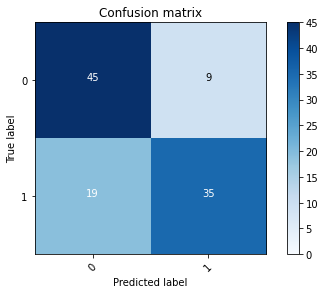

2022-07-06 16:30:40 - [Epoch Train: 52] loss: 0.0023, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 16:30:40 - [Epoch Valid: 52] loss: 0.9043, auc: 0.8501, acc: 0.7407, time: 9.00 s


 35%|█████████████▊                          | 52/150 [38:44<1:12:43, 44.52s/it]

2022-07-06 16:30:40 - EPOCH: 53
2022-07-06 16:30:54 - Train Step 10/28, train_loss: 0.0026
2022-07-06 16:31:09 - Train Step 20/28, train_loss: 0.0022
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:31:26 - Valid Step 5/7, valid_loss: 0.8473
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
15      00028                1           1
38      00043                1           0
22      00052                1           0
70      00062                1           0
107     00064                0           1
45      00064                0           1
5       00072                0           0
69      00121                0           0
30      00121                0           0
20      00140                1           1
12      00142                0           0
61      00146                1           1
66      00150                0           0
2       00160                1           0
98      00167                0           0
63      00169                0       

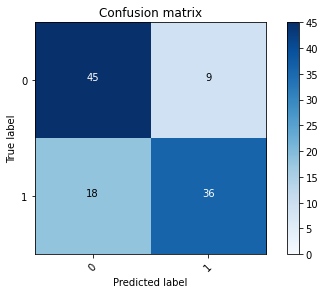

2022-07-06 16:31:28 - [Epoch Train: 53] loss: 0.0022, auc: 1.0000, acc: 1.0000, time: 38.00 s            
2022-07-06 16:31:28 - [Epoch Valid: 53] loss: 0.9150, auc: 0.8501, acc: 0.7500, time: 10.00 s
2022-07-06 16:31:28 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e53-loss0.915-acc0.750-auc0.850.pth'


 35%|██████████████▏                         | 53/150 [39:33<1:13:57, 45.75s/it]

2022-07-06 16:31:28 - EPOCH: 54
2022-07-06 16:31:42 - Train Step 10/28, train_loss: 0.0021
2022-07-06 16:31:54 - Train Step 20/28, train_loss: 0.0021
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:32:11 - Valid Step 5/7, valid_loss: 0.9191
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
48      00028                1           1
89      00043                1           0
67      00052                1           0
4       00062                1           0
86      00064                0           1
10      00064                0           1
35      00072                0           0
33      00121                0           0
18      00121                0           0
77      00140                1           1
15      00142                0           0
3       00146                1           1
37      00150                0           0
107     00160                1           0
52      00167                0           0
75      00169                0       

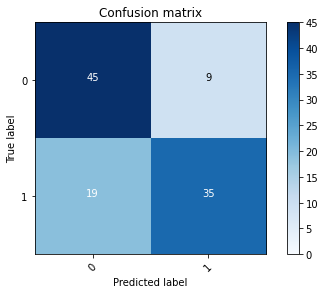

2022-07-06 16:32:13 - [Epoch Train: 54] loss: 0.0021, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:32:13 - [Epoch Valid: 54] loss: 0.9173, auc: 0.8512, acc: 0.7407, time: 9.00 s


 36%|██████████████▍                         | 54/150 [40:18<1:12:46, 45.48s/it]

2022-07-06 16:32:13 - EPOCH: 55
2022-07-06 16:32:27 - Train Step 10/28, train_loss: 0.0021
2022-07-06 16:32:40 - Train Step 20/28, train_loss: 0.0020
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:32:56 - Valid Step 5/7, valid_loss: 0.8682
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
39      00028                1           1
54      00043                1           0
2       00052                1           0
13      00062                1           0
65      00064                0           1
104     00064                0           1
49      00072                0           0
98      00121                0           0
67      00121                0           0
79      00140                1           1
9       00142                0           0
71      00146                1           1
60      00150                0           0
102     00160                1           0
75      00167                0           0
40      00169                0       

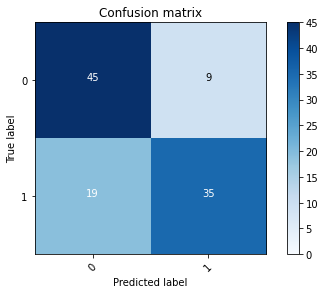

2022-07-06 16:32:58 - [Epoch Train: 55] loss: 0.0019, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:32:58 - [Epoch Valid: 55] loss: 0.9285, auc: 0.8505, acc: 0.7407, time: 9.00 s


 37%|██████████████▋                         | 55/150 [41:02<1:11:45, 45.32s/it]

2022-07-06 16:32:58 - EPOCH: 56
2022-07-06 16:33:12 - Train Step 10/28, train_loss: 0.0020
2022-07-06 16:33:24 - Train Step 20/28, train_loss: 0.0019
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:33:41 - Valid Step 5/7, valid_loss: 0.8440
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
29      00028                1           1
0       00043                1           0
62      00052                1           0
8       00062                1           0
103     00064                0           1
94      00064                0           1
68      00072                0           0
41      00121                0           0
30      00121                0           0
74      00140                1           1
88      00142                0           0
7       00146                1           1
52      00150                0           0
70      00160                1           0
45      00167                0           0
37      00169                0       

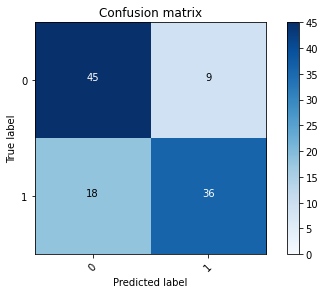

2022-07-06 16:33:43 - [Epoch Train: 56] loss: 0.0018, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:33:43 - [Epoch Valid: 56] loss: 0.9428, auc: 0.8525, acc: 0.7500, time: 9.00 s
2022-07-06 16:33:43 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e56-loss0.943-acc0.750-auc0.853.pth'


 37%|██████████████▉                         | 56/150 [41:47<1:10:45, 45.17s/it]

2022-07-06 16:33:43 - EPOCH: 57
2022-07-06 16:33:56 - Train Step 10/28, train_loss: 0.0020
2022-07-06 16:34:09 - Train Step 20/28, train_loss: 0.0017
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:34:26 - Valid Step 5/7, valid_loss: 0.9290
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
93      00028                1           1
16      00043                1           0
9       00052                1           0
33      00062                1           0
79      00064                0           1
5       00064                0           1
19      00072                0           0
3       00121                0           0
15      00121                0           0
63      00140                1           1
8       00142                0           0
99      00146                1           1
74      00150                0           0
6       00160                1           0
34      00167                0           0
59      00169                0       

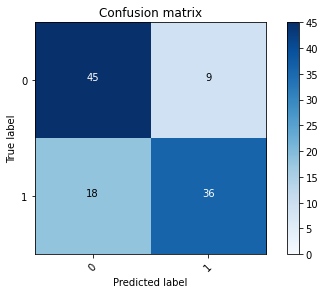

2022-07-06 16:34:28 - [Epoch Train: 57] loss: 0.0017, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:34:28 - [Epoch Valid: 57] loss: 0.9455, auc: 0.8515, acc: 0.7500, time: 9.00 s
2022-07-06 16:34:28 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e57-loss0.946-acc0.750-auc0.852.pth'


 38%|███████████████▏                        | 57/150 [42:32<1:09:50, 45.06s/it]

2022-07-06 16:34:28 - EPOCH: 58
2022-07-06 16:34:41 - Train Step 10/28, train_loss: 0.0018
2022-07-06 16:34:54 - Train Step 20/28, train_loss: 0.0017
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:35:11 - Valid Step 5/7, valid_loss: 0.9044
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
40      00028                1           1
17      00043                1           0
14      00052                1           0
21      00062                1           0
101     00064                0           1
32      00064                0           1
41      00072                0           0
99      00121                0           0
53      00121                0           0
52      00140                1           1
20      00142                0           0
37      00146                1           1
7       00150                0           0
70      00160                1           0
93      00167                0           0
22      00169                0       

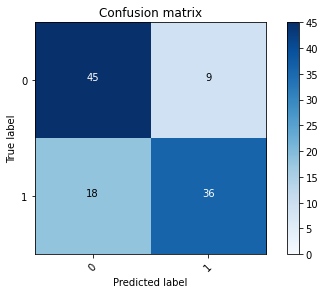

2022-07-06 16:35:13 - [Epoch Train: 58] loss: 0.0016, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:35:13 - [Epoch Valid: 58] loss: 0.9244, auc: 0.8512, acc: 0.7500, time: 9.00 s
2022-07-06 16:35:13 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e58-loss0.924-acc0.750-auc0.851.pth'


 39%|███████████████▍                        | 58/150 [43:17<1:09:15, 45.16s/it]

2022-07-06 16:35:13 - EPOCH: 59
2022-07-06 16:35:27 - Train Step 10/28, train_loss: 0.0015
2022-07-06 16:35:39 - Train Step 20/28, train_loss: 0.0015
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:35:57 - Valid Step 5/7, valid_loss: 1.0200
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
86      00028                1           1
37      00043                1           0
48      00052                1           0
19      00062                1           0
104     00064                0           1
77      00064                0           1
101     00072                0           0
83      00121                0           0
44      00121                0           0
63      00140                1           1
71      00142                0           0
78      00146                1           1
84      00150                0           0
39      00160                1           0
17      00167                0           0
12      00169                0       

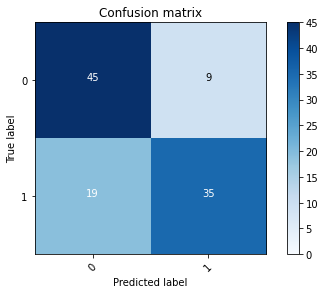

2022-07-06 16:35:58 - [Epoch Train: 59] loss: 0.0015, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:35:58 - [Epoch Valid: 59] loss: 0.9598, auc: 0.8498, acc: 0.7407, time: 9.00 s


 39%|███████████████▋                        | 59/150 [44:03<1:08:30, 45.17s/it]

2022-07-06 16:35:58 - EPOCH: 60
2022-07-06 16:36:12 - Train Step 10/28, train_loss: 0.0015
2022-07-06 16:36:24 - Train Step 20/28, train_loss: 0.0013
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:36:41 - Valid Step 5/7, valid_loss: 0.8673
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
2       00028                1           1
66      00043                1           0
89      00052                1           0
67      00062                1           0
64      00064                0           1
13      00064                0           1
78      00072                0           0
10      00121                0           0
96      00121                0           0
95      00140                1           1
21      00142                0           0
12      00146                1           1
50      00150                0           0
70      00160                1           0
28      00167                0           0
26      00169                0       

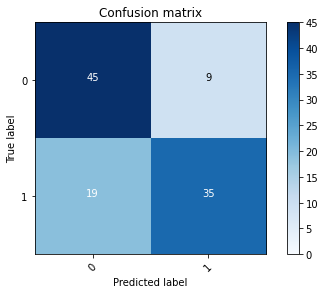

2022-07-06 16:36:43 - [Epoch Train: 60] loss: 0.0013, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:36:43 - [Epoch Valid: 60] loss: 0.9781, auc: 0.8515, acc: 0.7407, time: 9.00 s


 40%|████████████████                        | 60/150 [44:48<1:07:37, 45.08s/it]

2022-07-06 16:36:43 - EPOCH: 61
2022-07-06 16:36:57 - Train Step 10/28, train_loss: 0.0013
2022-07-06 16:37:09 - Train Step 20/28, train_loss: 0.0013
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:37:26 - Valid Step 5/7, valid_loss: 0.8445
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
10      00028                1           1
81      00043                1           0
53      00052                1           0
67      00062                1           0
37      00064                0           1
97      00064                0           1
105     00072                0           0
58      00121                0           0
90      00121                0           0
30      00140                1           1
43      00142                0           0
55      00146                1           1
47      00150                0           0
59      00160                1           0
3       00167                0           0
91      00169                0       

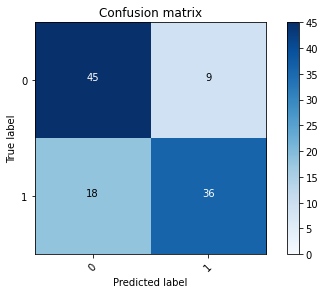

2022-07-06 16:37:27 - [Epoch Train: 61] loss: 0.0015, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:37:27 - [Epoch Valid: 61] loss: 0.9432, auc: 0.8522, acc: 0.7500, time: 9.00 s
2022-07-06 16:37:27 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e61-loss0.943-acc0.750-auc0.852.pth'


 41%|████████████████▎                       | 61/150 [45:32<1:06:25, 44.79s/it]

2022-07-06 16:37:27 - EPOCH: 62
2022-07-06 16:37:41 - Train Step 10/28, train_loss: 0.0018
2022-07-06 16:37:54 - Train Step 20/28, train_loss: 0.0016
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:38:10 - Valid Step 5/7, valid_loss: 0.7208
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
101     00028                1           1
12      00043                1           0
49      00052                1           0
11      00062                1           0
73      00064                0           1
86      00064                0           1
0       00072                0           0
97      00121                0           0
70      00121                0           0
4       00140                1           1
62      00142                0           0
68      00146                1           1
51      00150                0           0
22      00160                1           0
3       00167                0           0
14      00169                0       

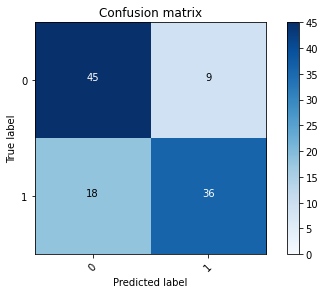

2022-07-06 16:38:12 - [Epoch Train: 62] loss: 0.0015, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:38:12 - [Epoch Valid: 62] loss: 0.9615, auc: 0.8515, acc: 0.7500, time: 9.00 s
2022-07-06 16:38:12 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e62-loss0.961-acc0.750-auc0.852.pth'


 41%|████████████████▌                       | 62/150 [46:16<1:05:36, 44.73s/it]

2022-07-06 16:38:12 - EPOCH: 63
2022-07-06 16:38:25 - Train Step 10/28, train_loss: 0.0014
2022-07-06 16:38:38 - Train Step 20/28, train_loss: 0.0014
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:38:54 - Valid Step 5/7, valid_loss: 0.9877
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
46      00028                1           1
30      00043                1           0
56      00052                1           0
23      00062                1           0
57      00064                0           1
37      00064                0           1
15      00072                0           0
31      00121                0           0
35      00121                0           0
79      00140                1           1
96      00142                0           0
99      00146                1           1
98      00150                0           0
41      00160                1           0
55      00167                0           0
106     00169                0       

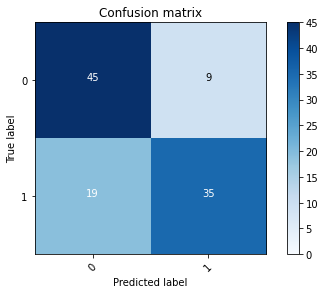

2022-07-06 16:38:56 - [Epoch Train: 63] loss: 0.0014, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:38:56 - [Epoch Valid: 63] loss: 0.9783, auc: 0.8515, acc: 0.7407, time: 9.00 s


 42%|████████████████▊                       | 63/150 [47:00<1:04:26, 44.44s/it]

2022-07-06 16:38:56 - EPOCH: 64
2022-07-06 16:39:09 - Train Step 10/28, train_loss: 0.0014
2022-07-06 16:39:21 - Train Step 20/28, train_loss: 0.0014
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:39:39 - Valid Step 5/7, valid_loss: 0.8838
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
71      00028                1           1
0       00043                1           0
95      00052                1           0
52      00062                1           0
55      00064                0           1
96      00064                0           1
14      00072                0           0
81      00121                0           0
102     00121                0           0
68      00140                1           1
77      00142                0           0
39      00146                1           1
93      00150                0           0
44      00160                1           0
50      00167                0           0
3       00169                0       

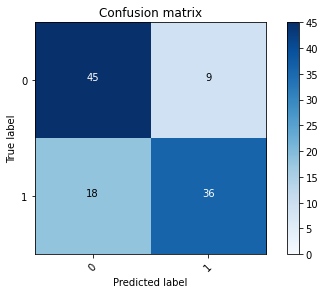

2022-07-06 16:39:40 - [Epoch Train: 64] loss: 0.0013, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:39:40 - [Epoch Valid: 64] loss: 0.9662, auc: 0.8525, acc: 0.7500, time: 9.00 s
2022-07-06 16:39:40 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e64-loss0.966-acc0.750-auc0.853.pth'


 43%|█████████████████                       | 64/150 [47:45<1:03:48, 44.52s/it]

2022-07-06 16:39:40 - EPOCH: 65
2022-07-06 16:39:54 - Train Step 10/28, train_loss: 0.0011
2022-07-06 16:40:07 - Train Step 20/28, train_loss: 0.0013
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:40:24 - Valid Step 5/7, valid_loss: 1.1075
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
88      00028                1           1
107     00043                1           0
92      00052                1           0
76      00062                1           0
60      00064                0           1
14      00064                0           1
29      00072                0           0
18      00121                0           0
49      00121                0           0
66      00140                1           1
28      00142                0           0
52      00146                1           1
69      00150                0           0
102     00160                1           0
44      00167                0           0
48      00169                0       

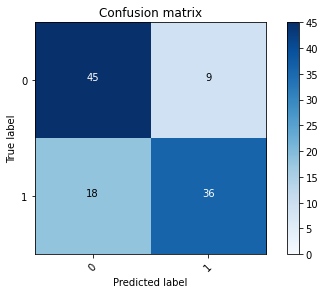

2022-07-06 16:40:26 - [Epoch Train: 65] loss: 0.0013, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:40:26 - [Epoch Valid: 65] loss: 0.9737, auc: 0.8515, acc: 0.7500, time: 9.00 s
2022-07-06 16:40:26 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e65-loss0.974-acc0.750-auc0.852.pth'


 43%|█████████████████▎                      | 65/150 [48:30<1:03:20, 44.71s/it]

2022-07-06 16:40:26 - EPOCH: 66
2022-07-06 16:40:38 - Train Step 10/28, train_loss: 0.0011
2022-07-06 16:40:50 - Train Step 20/28, train_loss: 0.0010
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:41:06 - Valid Step 5/7, valid_loss: 1.0744
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
11      00028                1           1
28      00043                1           0
17      00052                1           0
15      00062                1           0
43      00064                0           1
93      00064                0           1
49      00072                0           0
7       00121                0           0
74      00121                0           0
6       00140                1           1
31      00142                0           0
52      00146                1           1
92      00150                0           0
86      00160                1           0
84      00167                0           0
91      00169                0       

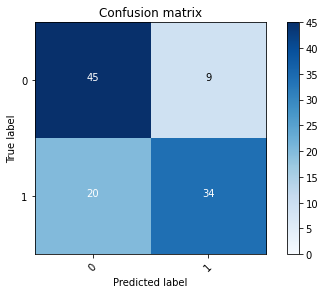

2022-07-06 16:41:08 - [Epoch Train: 66] loss: 0.0011, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 16:41:08 - [Epoch Valid: 66] loss: 1.0110, auc: 0.8512, acc: 0.7315, time: 9.00 s


 44%|█████████████████▌                      | 66/150 [49:12<1:01:38, 44.02s/it]

2022-07-06 16:41:08 - EPOCH: 67
2022-07-06 16:41:22 - Train Step 10/28, train_loss: 0.0012
2022-07-06 16:41:34 - Train Step 20/28, train_loss: 0.0011
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:41:52 - Valid Step 5/7, valid_loss: 0.9126
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
99      00028                1           1
34      00043                1           0
35      00052                1           0
68      00062                1           0
87      00064                0           1
54      00064                0           1
15      00072                0           0
66      00121                0           0
74      00121                0           0
58      00140                1           1
78      00142                0           0
106     00146                1           1
89      00150                0           0
83      00160                1           0
95      00167                0           0
32      00169                0       

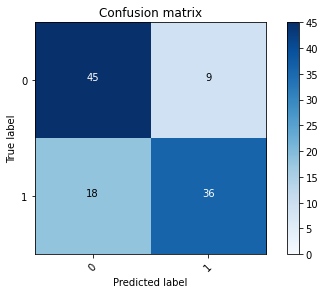

2022-07-06 16:41:53 - [Epoch Train: 67] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:41:53 - [Epoch Valid: 67] loss: 1.0034, auc: 0.8515, acc: 0.7500, time: 9.00 s
2022-07-06 16:41:53 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e67-loss1.003-acc0.750-auc0.852.pth'


 45%|█████████████████▊                      | 67/150 [49:58<1:01:27, 44.43s/it]

2022-07-06 16:41:53 - EPOCH: 68
2022-07-06 16:42:07 - Train Step 10/28, train_loss: 0.0010
2022-07-06 16:42:20 - Train Step 20/28, train_loss: 0.0010
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:42:36 - Valid Step 5/7, valid_loss: 1.1881
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
49      00028                1           1
20      00043                1           0
5       00052                1           0
62      00062                1           0
45      00064                0           1
37      00064                0           1
86      00072                0           0
78      00121                0           0
106     00121                0           0
32      00140                1           1
0       00142                0           0
53      00146                1           1
94      00150                0           0
65      00160                1           0
1       00167                0           0
24      00169                0       

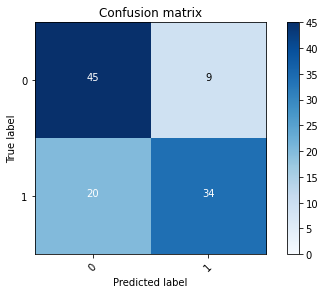

2022-07-06 16:42:38 - [Epoch Train: 68] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:42:38 - [Epoch Valid: 68] loss: 1.0064, auc: 0.8515, acc: 0.7315, time: 9.00 s


 45%|██████████████████▏                     | 68/150 [50:43<1:00:56, 44.59s/it]

2022-07-06 16:42:38 - EPOCH: 69
2022-07-06 16:42:51 - Train Step 10/28, train_loss: 0.0010
2022-07-06 16:43:04 - Train Step 20/28, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:43:21 - Valid Step 5/7, valid_loss: 0.8983
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
90      00028                1           1
41      00043                1           0
71      00052                1           0
50      00062                1           0
100     00064                0           1
18      00064                0           1
13      00072                0           0
1       00121                0           0
73      00121                0           0
16      00140                1           1
89      00142                0           0
30      00146                1           1
42      00150                0           0
17      00160                1           0
107     00167                0           0
55      00169                0       

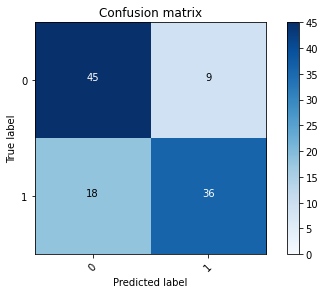

2022-07-06 16:43:23 - [Epoch Train: 69] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:43:23 - [Epoch Valid: 69] loss: 0.9908, auc: 0.8536, acc: 0.7500, time: 9.00 s
2022-07-06 16:43:23 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e69-loss0.991-acc0.750-auc0.854.pth'


 46%|██████████████████▍                     | 69/150 [51:28<1:00:18, 44.68s/it]

2022-07-06 16:43:23 - EPOCH: 70
2022-07-06 16:43:37 - Train Step 10/28, train_loss: 0.0008
2022-07-06 16:43:50 - Train Step 20/28, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:44:07 - Valid Step 5/7, valid_loss: 1.0379
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
14      00028                1           1
74      00043                1           0
75      00052                1           0
31      00062                1           0
3       00064                0           1
37      00064                0           1
26      00072                0           0
96      00121                0           0
22      00121                0           0
35      00140                1           1
76      00142                0           0
103     00146                1           1
4       00150                0           0
52      00160                1           0
84      00167                0           0
72      00169                0       

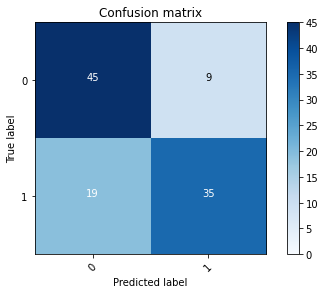

2022-07-06 16:44:09 - [Epoch Train: 70] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:44:09 - [Epoch Valid: 70] loss: 1.0335, auc: 0.8529, acc: 0.7407, time: 9.00 s


 47%|███████████████████▌                      | 70/150 [52:13<59:50, 44.88s/it]

2022-07-06 16:44:09 - EPOCH: 71
2022-07-06 16:44:22 - Train Step 10/28, train_loss: 0.0008
2022-07-06 16:44:34 - Train Step 20/28, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:44:51 - Valid Step 5/7, valid_loss: 0.7918
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
45      00028                1           1
84      00043                1           0
7       00052                1           0
50      00062                1           0
41      00064                0           1
8       00064                0           1
56      00072                0           0
31      00121                0           0
96      00121                0           0
92      00140                1           1
30      00142                0           0
35      00146                1           1
0       00150                0           0
97      00160                1           0
12      00167                0           0
80      00169                0       

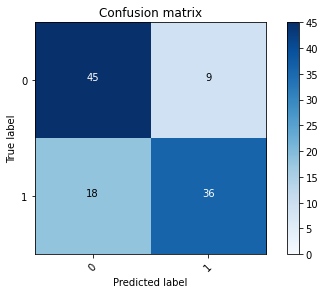

2022-07-06 16:44:53 - [Epoch Train: 71] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:44:53 - [Epoch Valid: 71] loss: 1.0119, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 16:44:53 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e71-loss1.012-acc0.750-auc0.853.pth'


 47%|███████████████████▉                      | 71/150 [52:57<58:56, 44.76s/it]

2022-07-06 16:44:53 - EPOCH: 72
2022-07-06 16:45:06 - Train Step 10/28, train_loss: 0.0009
2022-07-06 16:45:18 - Train Step 20/28, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:45:35 - Valid Step 5/7, valid_loss: 0.9968
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
8       00028                1           1
56      00043                1           0
98      00052                1           0
20      00062                1           0
33      00064                0           1
63      00064                0           1
101     00072                0           0
99      00121                0           0
27      00121                0           0
57      00140                1           1
45      00142                0           0
106     00146                1           1
24      00150                0           0
69      00160                1           0
82      00167                0           0
46      00169                0       

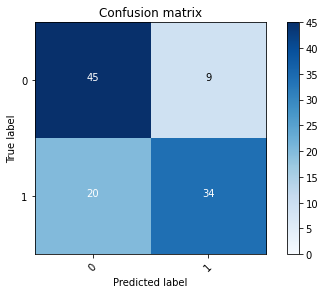

2022-07-06 16:45:36 - [Epoch Train: 72] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:45:36 - [Epoch Valid: 72] loss: 1.0337, auc: 0.8512, acc: 0.7315, time: 9.00 s


 48%|████████████████████▏                     | 72/150 [53:41<57:39, 44.35s/it]

2022-07-06 16:45:36 - EPOCH: 73
2022-07-06 16:45:50 - Train Step 10/28, train_loss: 0.0009
2022-07-06 16:46:03 - Train Step 20/28, train_loss: 0.0008
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:46:20 - Valid Step 5/7, valid_loss: 1.2320
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
47      00028                1           1
68      00043                1           0
43      00052                1           0
26      00062                1           0
75      00064                0           1
73      00064                0           1
54      00072                0           0
102     00121                0           0
67      00121                0           0
76      00140                1           1
44      00142                0           0
70      00146                1           1
0       00150                0           0
31      00160                1           0
66      00167                0           0
69      00169                0       

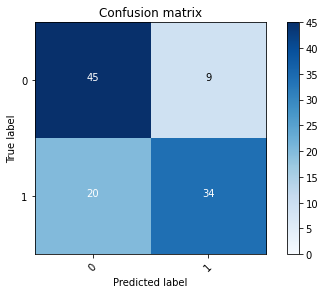

2022-07-06 16:46:21 - [Epoch Train: 73] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:46:21 - [Epoch Valid: 73] loss: 1.0529, auc: 0.8525, acc: 0.7315, time: 9.00 s


 49%|████████████████████▍                     | 73/150 [54:26<57:09, 44.55s/it]

2022-07-06 16:46:22 - EPOCH: 74
2022-07-06 16:46:35 - Train Step 10/28, train_loss: 0.0005
2022-07-06 16:46:47 - Train Step 20/28, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:47:04 - Valid Step 5/7, valid_loss: 1.0366
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
83      00028                1           1
38      00043                1           0
55      00052                1           0
22      00062                1           0
64      00064                0           1
5       00064                0           1
37      00072                0           0
101     00121                0           0
95      00121                0           0
12      00140                1           1
70      00142                0           0
41      00146                1           1
51      00150                0           0
0       00160                1           0
25      00167                0           0
14      00169                0       

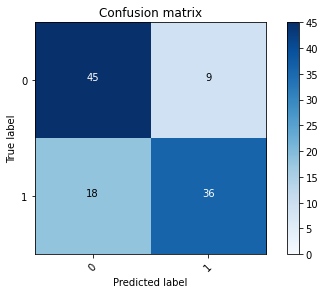

2022-07-06 16:47:06 - [Epoch Train: 74] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:47:06 - [Epoch Valid: 74] loss: 1.0396, auc: 0.8512, acc: 0.7500, time: 9.00 s
2022-07-06 16:47:06 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e74-loss1.040-acc0.750-auc0.851.pth'


 49%|████████████████████▋                     | 74/150 [55:10<56:22, 44.50s/it]

2022-07-06 16:47:06 - EPOCH: 75
2022-07-06 16:47:19 - Train Step 10/28, train_loss: 0.0010
2022-07-06 16:47:31 - Train Step 20/28, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:47:48 - Valid Step 5/7, valid_loss: 1.0508
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
29      00028                1           1
89      00043                1           0
56      00052                1           0
37      00062                1           0
68      00064                0           1
62      00064                0           1
20      00072                0           0
105     00121                0           0
54      00121                0           0
57      00140                1           1
10      00142                0           0
33      00146                1           1
80      00150                0           0
96      00160                1           0
63      00167                0           0
1       00169                0       

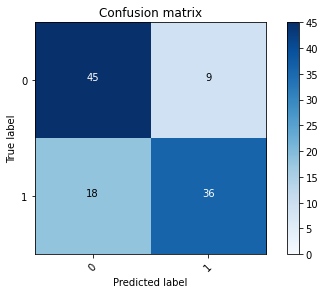

2022-07-06 16:47:50 - [Epoch Train: 75] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:47:50 - [Epoch Valid: 75] loss: 1.0407, auc: 0.8532, acc: 0.7500, time: 9.00 s
2022-07-06 16:47:50 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e75-loss1.041-acc0.750-auc0.853.pth'


 50%|█████████████████████                     | 75/150 [55:54<55:25, 44.34s/it]

2022-07-06 16:47:50 - EPOCH: 76
2022-07-06 16:48:03 - Train Step 10/28, train_loss: 0.0006
2022-07-06 16:48:15 - Train Step 20/28, train_loss: 0.0008
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:48:31 - Valid Step 5/7, valid_loss: 1.2170
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
107     00028                1           1
42      00043                1           0
48      00052                1           0
15      00062                1           0
63      00064                0           1
66      00064                0           1
11      00072                0           0
59      00121                0           0
36      00121                0           0
76      00140                1           1
95      00142                0           0
23      00146                1           1
14      00150                0           0
22      00160                1           0
91      00167                0           0
7       00169                0       

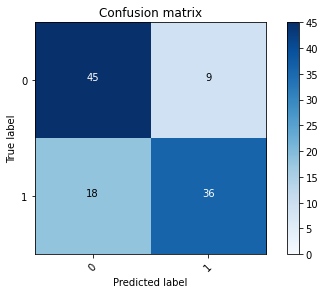

2022-07-06 16:48:33 - [Epoch Train: 76] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 16:48:33 - [Epoch Valid: 76] loss: 1.0279, auc: 0.8532, acc: 0.7500, time: 9.00 s
2022-07-06 16:48:33 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e76-loss1.028-acc0.750-auc0.853.pth'


 51%|█████████████████████▎                    | 76/150 [56:37<54:18, 44.04s/it]

2022-07-06 16:48:33 - EPOCH: 77
2022-07-06 16:48:46 - Train Step 10/28, train_loss: 0.0008
2022-07-06 16:48:59 - Train Step 20/28, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:49:15 - Valid Step 5/7, valid_loss: 1.0451
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
67      00028                1           1
97      00043                1           0
28      00052                1           0
95      00062                1           0
104     00064                0           1
45      00064                0           1
43      00072                0           0
75      00121                0           0
62      00121                0           0
66      00140                1           1
85      00142                0           0
86      00146                1           1
1       00150                0           0
59      00160                1           0
27      00167                0           0
25      00169                0       

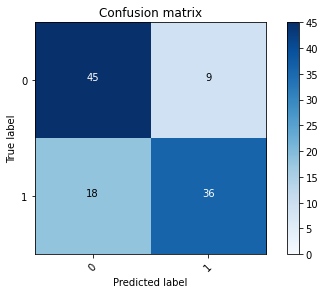

2022-07-06 16:49:17 - [Epoch Train: 77] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:49:17 - [Epoch Valid: 77] loss: 1.0405, auc: 0.8519, acc: 0.7500, time: 9.00 s
2022-07-06 16:49:17 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e77-loss1.040-acc0.750-auc0.852.pth'


 51%|█████████████████████▌                    | 77/150 [57:21<53:33, 44.02s/it]

2022-07-06 16:49:17 - EPOCH: 78
2022-07-06 16:49:31 - Train Step 10/28, train_loss: 0.0008
2022-07-06 16:49:44 - Train Step 20/28, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:50:01 - Valid Step 5/7, valid_loss: 1.0272
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
7       00028                1           1
10      00043                1           0
21      00052                1           0
61      00062                1           0
53      00064                0           1
100     00064                0           1
64      00072                0           0
46      00121                0           0
68      00121                0           0
81      00140                1           1
56      00142                0           0
4       00146                1           1
98      00150                0           0
8       00160                1           0
26      00167                0           0
48      00169                0       

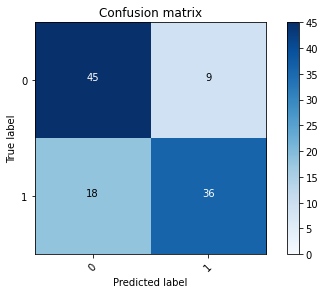

2022-07-06 16:50:03 - [Epoch Train: 78] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:50:03 - [Epoch Valid: 78] loss: 1.0602, auc: 0.8519, acc: 0.7500, time: 9.00 s
2022-07-06 16:50:03 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e78-loss1.060-acc0.750-auc0.852.pth'


 52%|█████████████████████▊                    | 78/150 [58:07<53:31, 44.61s/it]

2022-07-06 16:50:03 - EPOCH: 79
2022-07-06 16:50:16 - Train Step 10/28, train_loss: 0.0007
2022-07-06 16:50:29 - Train Step 20/28, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:50:45 - Valid Step 5/7, valid_loss: 1.1055
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
23      00028                1           1
28      00043                1           0
5       00052                1           0
77      00062                1           0
1       00064                0           1
45      00064                0           1
22      00072                0           0
21      00121                0           0
103     00121                0           0
38      00140                1           1
86      00142                0           0
17      00146                1           1
15      00150                0           0
73      00160                1           0
16      00167                0           0
60      00169                0       

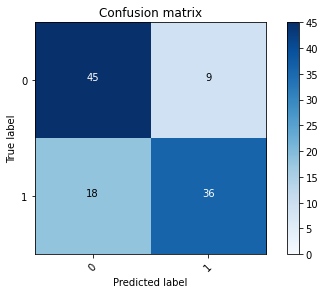

2022-07-06 16:50:47 - [Epoch Train: 79] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 16:50:47 - [Epoch Valid: 79] loss: 1.0481, auc: 0.8543, acc: 0.7500, time: 9.00 s
2022-07-06 16:50:47 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e79-loss1.048-acc0.750-auc0.854.pth'


 53%|██████████████████████                    | 79/150 [58:51<52:26, 44.32s/it]

2022-07-06 16:50:47 - EPOCH: 80
2022-07-06 16:51:00 - Train Step 10/28, train_loss: 0.0005
2022-07-06 16:51:13 - Train Step 20/28, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:51:30 - Valid Step 5/7, valid_loss: 1.2976
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
32      00028                1           1
87      00043                1           0
75      00052                1           0
99      00062                1           0
71      00064                0           1
85      00064                0           1
30      00072                0           0
69      00121                0           0
21      00121                0           0
91      00140                1           1
9       00142                0           0
72      00146                1           1
15      00150                0           0
64      00160                1           0
5       00167                0           0
83      00169                0       

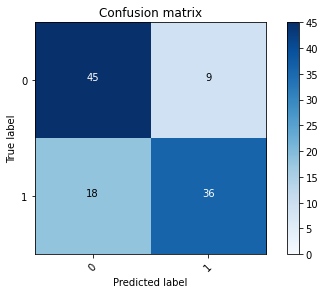

2022-07-06 16:51:31 - [Epoch Train: 80] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:51:31 - [Epoch Valid: 80] loss: 1.0636, auc: 0.8536, acc: 0.7500, time: 9.00 s
2022-07-06 16:51:31 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e80-loss1.064-acc0.750-auc0.854.pth'


 53%|██████████████████████▍                   | 80/150 [59:36<51:49, 44.42s/it]

2022-07-06 16:51:31 - EPOCH: 81
2022-07-06 16:51:45 - Train Step 10/28, train_loss: 0.0007
2022-07-06 16:51:58 - Train Step 20/28, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:52:15 - Valid Step 5/7, valid_loss: 1.1244
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
91      00028                1           1
0       00043                1           0
54      00052                1           0
57      00062                1           0
72      00064                0           1
46      00064                0           1
62      00072                0           0
37      00121                0           0
105     00121                0           0
80      00140                1           1
32      00142                0           0
68      00146                1           1
90      00150                0           0
64      00160                1           0
3       00167                0           0
24      00169                0       

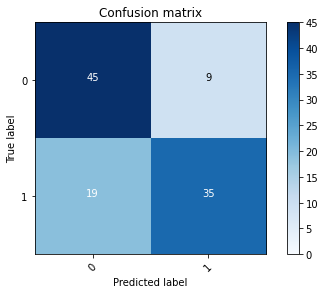

2022-07-06 16:52:17 - [Epoch Train: 81] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:52:17 - [Epoch Valid: 81] loss: 1.0913, auc: 0.8529, acc: 0.7407, time: 9.00 s


 54%|█████████████████████▌                  | 81/150 [1:00:22<51:37, 44.89s/it]

2022-07-06 16:52:17 - EPOCH: 82
2022-07-06 16:52:31 - Train Step 10/28, train_loss: 0.0006
2022-07-06 16:52:44 - Train Step 20/28, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:53:01 - Valid Step 5/7, valid_loss: 0.9535
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
70      00028                1           1
28      00043                1           0
95      00052                1           0
11      00062                1           0
4       00064                0           1
18      00064                0           1
69      00072                0           0
73      00121                0           0
53      00121                0           0
59      00140                1           1
44      00142                0           0
5       00146                1           1
68      00150                0           0
78      00160                1           0
104     00167                0           0
67      00169                0       

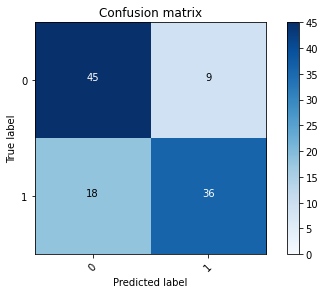

2022-07-06 16:53:03 - [Epoch Train: 82] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:53:03 - [Epoch Valid: 82] loss: 1.0769, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 16:53:03 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e82-loss1.077-acc0.750-auc0.853.pth'


 55%|█████████████████████▊                  | 82/150 [1:01:07<51:10, 45.15s/it]

2022-07-06 16:53:03 - EPOCH: 83
2022-07-06 16:53:16 - Train Step 10/28, train_loss: 0.0006
2022-07-06 16:53:28 - Train Step 20/28, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:53:45 - Valid Step 5/7, valid_loss: 1.1362
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
6       00028                1           1
63      00043                1           0
46      00052                1           0
67      00062                1           0
17      00064                0           1
45      00064                0           1
24      00072                0           0
64      00121                0           0
68      00121                0           0
44      00140                1           1
59      00142                0           0
41      00146                1           1
107     00150                0           0
93      00160                1           0
42      00167                0           0
72      00169                0       

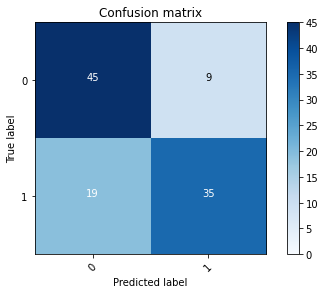

2022-07-06 16:53:47 - [Epoch Train: 83] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:53:47 - [Epoch Valid: 83] loss: 1.0887, auc: 0.8529, acc: 0.7407, time: 9.00 s


 55%|██████████████████████▏                 | 83/150 [1:01:51<49:49, 44.62s/it]

2022-07-06 16:53:47 - EPOCH: 84
2022-07-06 16:53:59 - Train Step 10/28, train_loss: 0.0006
2022-07-06 16:54:12 - Train Step 20/28, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:54:29 - Valid Step 5/7, valid_loss: 1.2734
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
13      00028                1           1
81      00043                1           0
100     00052                1           0
26      00062                1           0
44      00064                0           1
6       00064                0           1
92      00072                0           0
90      00121                0           0
3       00121                0           0
102     00140                1           1
10      00142                0           0
17      00146                1           1
29      00150                0           0
16      00160                1           0
40      00167                0           0
55      00169                0       

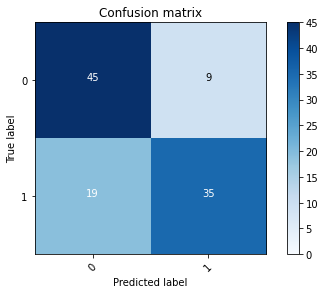

2022-07-06 16:54:30 - [Epoch Train: 84] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:54:30 - [Epoch Valid: 84] loss: 1.0914, auc: 0.8543, acc: 0.7407, time: 9.00 s


 56%|██████████████████████▍                 | 84/150 [1:02:35<48:48, 44.38s/it]

2022-07-06 16:54:30 - EPOCH: 85
2022-07-06 16:54:44 - Train Step 10/28, train_loss: 0.0006
2022-07-06 16:54:57 - Train Step 20/28, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:55:14 - Valid Step 5/7, valid_loss: 0.9396
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
30      00028                1           1
60      00043                1           0
18      00052                1           0
97      00062                1           0
61      00064                0           1
26      00064                0           1
51      00072                0           0
54      00121                0           0
84      00121                0           0
83      00140                1           1
88      00142                0           0
23      00146                1           1
43      00150                0           0
16      00160                1           0
50      00167                0           0
14      00169                0       

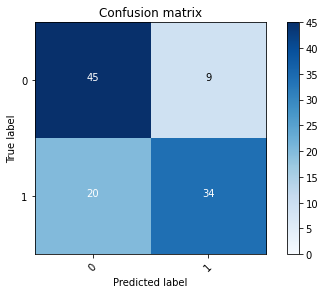

2022-07-06 16:55:16 - [Epoch Train: 85] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:55:16 - [Epoch Valid: 85] loss: 1.0989, auc: 0.8525, acc: 0.7315, time: 9.00 s


 57%|██████████████████████▋                 | 85/150 [1:03:20<48:27, 44.74s/it]

2022-07-06 16:55:16 - EPOCH: 86
2022-07-06 16:55:29 - Train Step 10/28, train_loss: 0.0005
2022-07-06 16:55:42 - Train Step 20/28, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:55:59 - Valid Step 5/7, valid_loss: 1.0545
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
60      00028                1           1
54      00043                1           0
35      00052                1           0
7       00062                1           0
26      00064                0           1
104     00064                0           1
58      00072                0           0
13      00121                0           0
6       00121                0           0
94      00140                1           1
28      00142                0           0
20      00146                1           1
16      00150                0           0
0       00160                1           0
78      00167                0           0
41      00169                0       

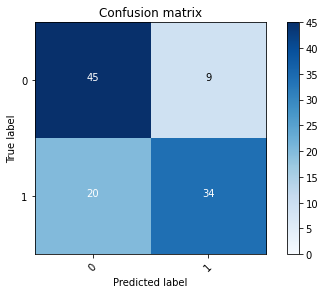

2022-07-06 16:56:01 - [Epoch Train: 86] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:56:01 - [Epoch Valid: 86] loss: 1.1060, auc: 0.8543, acc: 0.7315, time: 9.00 s


 57%|██████████████████████▉                 | 86/150 [1:04:05<47:46, 44.80s/it]

2022-07-06 16:56:01 - EPOCH: 87
2022-07-06 16:56:14 - Train Step 10/28, train_loss: 0.0004
2022-07-06 16:56:27 - Train Step 20/28, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:56:44 - Valid Step 5/7, valid_loss: 0.8624
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
44      00028                1           1
102     00043                1           0
13      00052                1           0
0       00062                1           0
72      00064                0           1
106     00064                0           1
33      00072                0           0
9       00121                0           0
76      00121                0           0
49      00140                1           1
73      00142                0           0
43      00146                1           1
35      00150                0           0
75      00160                1           0
28      00167                0           0
6       00169                0       

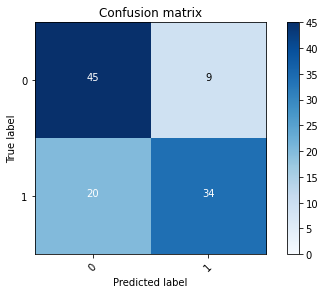

2022-07-06 16:56:46 - [Epoch Train: 87] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 16:56:46 - [Epoch Valid: 87] loss: 1.1054, auc: 0.8549, acc: 0.7315, time: 9.00 s


 58%|███████████████████████▏                | 87/150 [1:04:50<47:07, 44.88s/it]

2022-07-06 16:56:46 - EPOCH: 88
2022-07-06 16:56:59 - Train Step 10/28, train_loss: 0.0004
2022-07-06 16:57:12 - Train Step 20/28, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:57:28 - Valid Step 5/7, valid_loss: 1.3372
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
22      00028                1           1
106     00043                1           0
56      00052                1           0
21      00062                1           0
16      00064                0           1
94      00064                0           1
86      00072                0           0
68      00121                0           0
34      00121                0           0
103     00140                1           1
62      00142                0           0
40      00146                1           1
4       00150                0           0
55      00160                1           0
105     00167                0           0
90      00169                0       

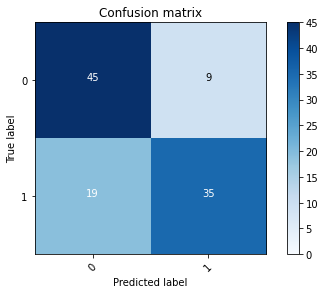

2022-07-06 16:57:30 - [Epoch Train: 88] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:57:30 - [Epoch Valid: 88] loss: 1.1068, auc: 0.8539, acc: 0.7407, time: 9.00 s


 59%|███████████████████████▍                | 88/150 [1:05:34<46:05, 44.60s/it]

2022-07-06 16:57:30 - EPOCH: 89
2022-07-06 16:57:43 - Train Step 10/28, train_loss: 0.0005
2022-07-06 16:57:56 - Train Step 20/28, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:58:14 - Valid Step 5/7, valid_loss: 1.2500
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
57      00028                1           1
52      00043                1           0
89      00052                1           0
55      00062                1           0
61      00064                0           1
16      00064                0           1
84      00072                0           0
105     00121                0           0
50      00121                0           0
31      00140                1           1
100     00142                0           0
102     00146                1           1
106     00150                0           0
64      00160                1           0
91      00167                0           0
77      00169                0       

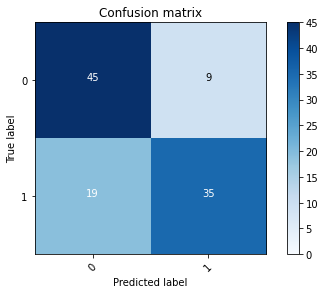

2022-07-06 16:58:15 - [Epoch Train: 89] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 36.00 s            
2022-07-06 16:58:15 - [Epoch Valid: 89] loss: 1.1222, auc: 0.8536, acc: 0.7407, time: 9.00 s


 59%|███████████████████████▋                | 89/150 [1:06:20<45:37, 44.88s/it]

2022-07-06 16:58:15 - EPOCH: 90
2022-07-06 16:58:28 - Train Step 10/28, train_loss: 0.0003
2022-07-06 16:58:40 - Train Step 20/28, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:58:57 - Valid Step 5/7, valid_loss: 1.2471
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
21      00028                1           1
77      00043                1           0
76      00052                1           0
105     00062                1           0
69      00064                0           1
86      00064                0           1
63      00072                0           0
9       00121                0           0
37      00121                0           0
32      00140                1           1
30      00142                0           0
20      00146                1           1
102     00150                0           0
34      00160                1           0
7       00167                0           0
43      00169                0       

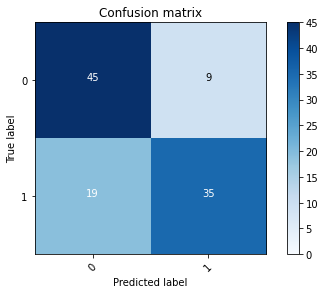

2022-07-06 16:58:59 - [Epoch Train: 90] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:58:59 - [Epoch Valid: 90] loss: 1.1602, auc: 0.8522, acc: 0.7407, time: 9.00 s


 60%|████████████████████████                | 90/150 [1:07:03<44:27, 44.45s/it]

2022-07-06 16:58:59 - EPOCH: 91
2022-07-06 16:59:12 - Train Step 10/28, train_loss: 0.0004
2022-07-06 16:59:25 - Train Step 20/28, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 16:59:41 - Valid Step 5/7, valid_loss: 1.1134
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
25      00028                1           1
104     00043                1           0
55      00052                1           0
86      00062                1           0
1       00064                0           1
39      00064                0           1
40      00072                0           0
36      00121                0           0
69      00121                0           0
57      00140                1           1
11      00142                0           0
43      00146                1           1
35      00150                0           0
0       00160                1           0
9       00167                0           0
3       00169                0       

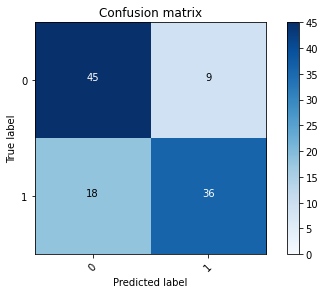

2022-07-06 16:59:43 - [Epoch Train: 91] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 16:59:43 - [Epoch Valid: 91] loss: 1.0992, auc: 0.8536, acc: 0.7500, time: 9.00 s
2022-07-06 16:59:43 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e91-loss1.099-acc0.750-auc0.854.pth'


 61%|████████████████████████▎               | 91/150 [1:07:47<43:38, 44.37s/it]

2022-07-06 16:59:43 - EPOCH: 92
2022-07-06 16:59:57 - Train Step 10/28, train_loss: 0.0004
2022-07-06 17:00:09 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:00:27 - Valid Step 5/7, valid_loss: 0.7577
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
16      00028                1           1
1       00043                1           0
93      00052                1           0
97      00062                1           0
57      00064                0           1
95      00064                0           1
107     00072                0           0
104     00121                0           0
71      00121                0           0
74      00140                1           1
13      00142                0           0
43      00146                1           1
76      00150                0           0
92      00160                1           0
31      00167                0           0
32      00169                0       

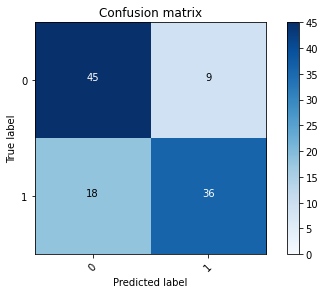

2022-07-06 17:00:28 - [Epoch Train: 92] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:00:28 - [Epoch Valid: 92] loss: 1.1055, auc: 0.8536, acc: 0.7500, time: 9.00 s
2022-07-06 17:00:28 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e92-loss1.106-acc0.750-auc0.854.pth'


 61%|████████████████████████▌               | 92/150 [1:08:33<43:09, 44.65s/it]

2022-07-06 17:00:28 - EPOCH: 93
2022-07-06 17:00:42 - Train Step 10/28, train_loss: 0.0004
2022-07-06 17:00:54 - Train Step 20/28, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:01:11 - Valid Step 5/7, valid_loss: 1.1420
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
72      00028                1           1
28      00043                1           0
42      00052                1           0
35      00062                1           0
106     00064                0           1
17      00064                0           1
12      00072                0           0
100     00121                0           0
21      00121                0           0
54      00140                1           1
44      00142                0           0
45      00146                1           1
86      00150                0           0
39      00160                1           0
104     00167                0           0
92      00169                0       

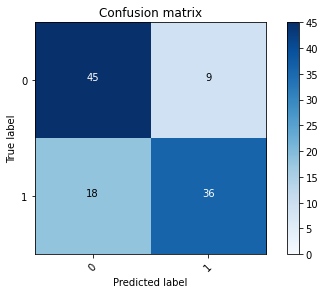

2022-07-06 17:01:13 - [Epoch Train: 93] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:01:13 - [Epoch Valid: 93] loss: 1.1014, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 17:01:13 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e93-loss1.101-acc0.750-auc0.853.pth'


 62%|████████████████████████▊               | 93/150 [1:09:17<42:21, 44.59s/it]

2022-07-06 17:01:13 - EPOCH: 94
2022-07-06 17:01:26 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:01:38 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:01:55 - Valid Step 5/7, valid_loss: 1.1634
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
17      00028                1           1
25      00043                1           0
0       00052                1           0
35      00062                1           0
48      00064                0           1
22      00064                0           1
13      00072                0           0
36      00121                0           0
63      00121                0           0
10      00140                1           1
40      00142                0           0
77      00146                1           1
57      00150                0           0
18      00160                1           0
51      00167                0           0
21      00169                0       

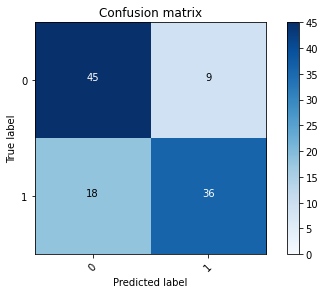

2022-07-06 17:01:57 - [Epoch Train: 94] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:01:57 - [Epoch Valid: 94] loss: 1.1081, auc: 0.8539, acc: 0.7500, time: 9.00 s
2022-07-06 17:01:57 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e94-loss1.108-acc0.750-auc0.854.pth'


 63%|█████████████████████████               | 94/150 [1:10:01<41:23, 44.35s/it]

2022-07-06 17:01:57 - EPOCH: 95
2022-07-06 17:02:09 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:02:21 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:02:38 - Valid Step 5/7, valid_loss: 0.8974
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
40      00028                1           1
93      00043                1           0
78      00052                1           0
99      00062                1           0
5       00064                0           1
55      00064                0           1
38      00072                0           0
100     00121                0           0
105     00121                0           0
37      00140                1           1
43      00142                0           0
22      00146                1           1
49      00150                0           0
80      00160                1           0
15      00167                0           0
39      00169                0       

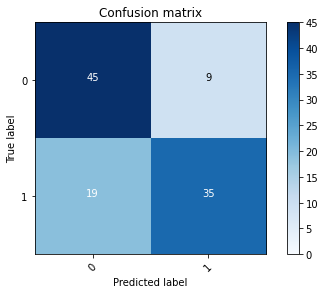

2022-07-06 17:02:40 - [Epoch Train: 95] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:02:40 - [Epoch Valid: 95] loss: 1.1387, auc: 0.8546, acc: 0.7407, time: 9.00 s


 63%|█████████████████████████▎              | 95/150 [1:10:44<40:19, 43.99s/it]

2022-07-06 17:02:40 - EPOCH: 96
2022-07-06 17:02:52 - Train Step 10/28, train_loss: 0.0004
2022-07-06 17:03:05 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:03:21 - Valid Step 5/7, valid_loss: 0.9717
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
20      00028                1           1
24      00043                1           0
23      00052                1           0
72      00062                1           0
28      00064                0           1
2       00064                0           1
4       00072                0           0
6       00121                0           0
34      00121                0           0
21      00140                1           1
87      00142                0           0
75      00146                1           1
56      00150                0           0
73      00160                1           0
100     00167                0           0
10      00169                0       

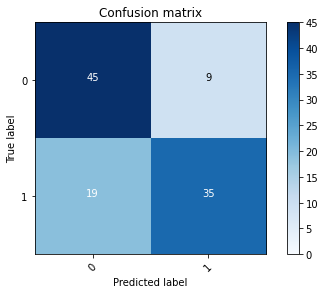

2022-07-06 17:03:23 - [Epoch Train: 96] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:03:23 - [Epoch Valid: 96] loss: 1.1501, auc: 0.8543, acc: 0.7407, time: 9.00 s


 64%|█████████████████████████▌              | 96/150 [1:11:27<39:19, 43.69s/it]

2022-07-06 17:03:23 - EPOCH: 97
2022-07-06 17:03:36 - Train Step 10/28, train_loss: 0.0004
2022-07-06 17:03:49 - Train Step 20/28, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:04:05 - Valid Step 5/7, valid_loss: 0.9694
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
80      00028                1           1
26      00043                1           0
51      00052                1           0
61      00062                1           0
39      00064                0           1
3       00064                0           1
52      00072                0           0
65      00121                0           0
53      00121                0           0
29      00140                1           1
105     00142                0           0
27      00146                1           1
62      00150                0           0
72      00160                1           0
67      00167                0           0
70      00169                0       

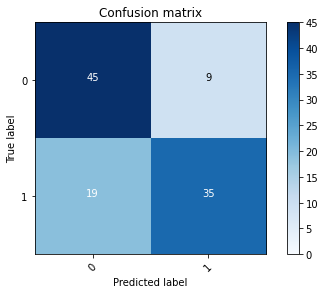

2022-07-06 17:04:07 - [Epoch Train: 97] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:04:07 - [Epoch Valid: 97] loss: 1.1663, auc: 0.8543, acc: 0.7407, time: 9.00 s


 65%|█████████████████████████▊              | 97/150 [1:12:11<38:41, 43.80s/it]

2022-07-06 17:04:07 - EPOCH: 98
2022-07-06 17:04:20 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:04:33 - Train Step 20/28, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:04:49 - Valid Step 5/7, valid_loss: 1.1220
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
104     00028                1           1
33      00043                1           0
27      00052                1           0
54      00062                1           0
16      00064                0           1
10      00064                0           1
1       00072                0           0
94      00121                0           0
22      00121                0           0
74      00140                1           1
62      00142                0           0
4       00146                1           1
0       00150                0           0
101     00160                1           0
52      00167                0           0
85      00169                0       

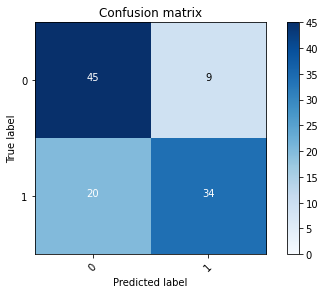

2022-07-06 17:04:50 - [Epoch Train: 98] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:04:50 - [Epoch Valid: 98] loss: 1.1549, auc: 0.8549, acc: 0.7315, time: 9.00 s


 65%|██████████████████████████▏             | 98/150 [1:12:55<37:55, 43.76s/it]

2022-07-06 17:04:50 - EPOCH: 99
2022-07-06 17:05:04 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:05:16 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:05:33 - Valid Step 5/7, valid_loss: 1.1867
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
55      00028                1           1
11      00043                1           0
50      00052                1           0
72      00062                1           0
58      00064                0           1
66      00064                0           1
18      00072                0           0
92      00121                0           0
100     00121                0           0
98      00140                1           1
31      00142                0           0
102     00146                1           1
20      00150                0           0
67      00160                1           0
101     00167                0           0
91      00169                0       

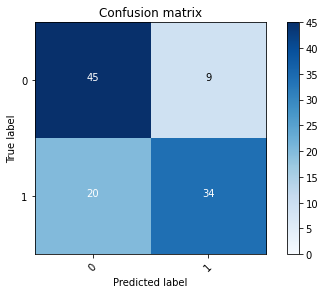

2022-07-06 17:05:35 - [Epoch Train: 99] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:05:35 - [Epoch Valid: 99] loss: 1.1849, auc: 0.8536, acc: 0.7315, time: 9.00 s


 66%|██████████████████████████▍             | 99/150 [1:13:39<37:19, 43.91s/it]

2022-07-06 17:05:35 - EPOCH: 100
2022-07-06 17:05:48 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:06:01 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:06:18 - Valid Step 5/7, valid_loss: 1.0327
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
18      00028                1           1
48      00043                1           0
20      00052                1           0
81      00062                1           0
73      00064                0           1
57      00064                0           1
59      00072                0           0
44      00121                0           0
101     00121                0           0
98      00140                1           1
75      00142                0           0
84      00146                1           1
49      00150                0           0
76      00160                1           0
11      00167                0           0
38      00169                0      

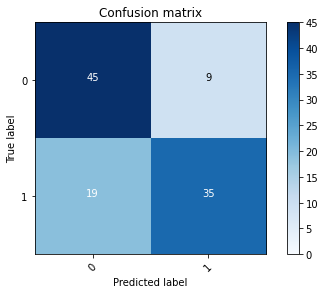

2022-07-06 17:06:20 - [Epoch Train: 100] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:06:20 - [Epoch Valid: 100] loss: 1.1662, auc: 0.8536, acc: 0.7407, time: 9.00 s


 67%|██████████████████████████             | 100/150 [1:14:24<36:53, 44.26s/it]

2022-07-06 17:06:20 - EPOCH: 101
2022-07-06 17:06:33 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:06:46 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:07:02 - Valid Step 5/7, valid_loss: 1.1399
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
107     00028                1           1
55      00043                1           0
99      00052                1           0
11      00062                1           0
26      00064                0           1
68      00064                0           1
7       00072                0           0
54      00121                0           0
23      00121                0           0
64      00140                1           1
91      00142                0           0
8       00146                1           1
80      00150                0           0
102     00160                1           0
86      00167                0           0
51      00169                0      

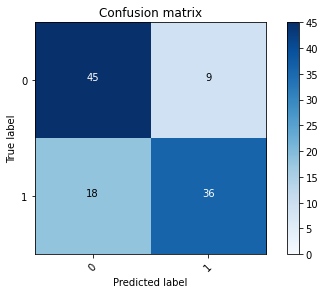

2022-07-06 17:07:04 - [Epoch Train: 101] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:07:04 - [Epoch Valid: 101] loss: 1.1497, auc: 0.8543, acc: 0.7500, time: 9.00 s
2022-07-06 17:07:04 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e101-loss1.150-acc0.750-auc0.854.pth'


 67%|██████████████████████████▎            | 101/150 [1:15:08<36:05, 44.20s/it]

2022-07-06 17:07:04 - EPOCH: 102
2022-07-06 17:07:17 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:07:30 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:07:46 - Valid Step 5/7, valid_loss: 1.1701
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
64      00028                1           1
51      00043                1           0
31      00052                1           0
78      00062                1           0
92      00064                0           1
52      00064                0           1
23      00072                0           0
75      00121                0           0
30      00121                0           0
46      00140                1           1
101     00142                0           0
77      00146                1           1
74      00150                0           0
53      00160                1           0
99      00167                0           0
63      00169                0      

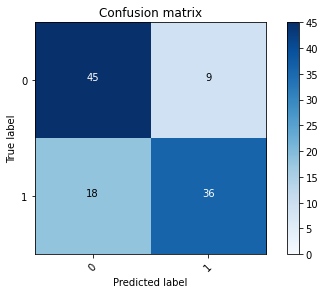

2022-07-06 17:07:48 - [Epoch Train: 102] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:07:48 - [Epoch Valid: 102] loss: 1.1576, auc: 0.8543, acc: 0.7500, time: 9.00 s
2022-07-06 17:07:48 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e102-loss1.158-acc0.750-auc0.854.pth'


 68%|██████████████████████████▌            | 102/150 [1:15:52<35:21, 44.19s/it]

2022-07-06 17:07:48 - EPOCH: 103
2022-07-06 17:08:01 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:08:14 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:08:31 - Valid Step 5/7, valid_loss: 0.9285
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
82      00028                1           1
1       00043                1           0
52      00052                1           0
26      00062                1           0
99      00064                0           1
51      00064                0           1
62      00072                0           0
72      00121                0           0
74      00121                0           0
89      00140                1           1
37      00142                0           0
90      00146                1           1
71      00150                0           0
75      00160                1           0
103     00167                0           0
84      00169                0      

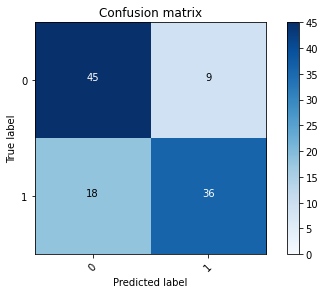

2022-07-06 17:08:33 - [Epoch Train: 103] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:08:33 - [Epoch Valid: 103] loss: 1.1609, auc: 0.8543, acc: 0.7500, time: 9.00 s
2022-07-06 17:08:33 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e103-loss1.161-acc0.750-auc0.854.pth'


 69%|██████████████████████████▊            | 103/150 [1:16:37<34:43, 44.33s/it]

2022-07-06 17:08:33 - EPOCH: 104
2022-07-06 17:08:46 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:08:58 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:09:15 - Valid Step 5/7, valid_loss: 1.2092
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
87      00028                1           1
68      00043                1           0
23      00052                1           0
58      00062                1           0
19      00064                0           1
51      00064                0           1
72      00072                0           0
77      00121                0           0
98      00121                0           0
15      00140                1           1
7       00142                0           0
32      00146                1           1
26      00150                0           0
38      00160                1           0
76      00167                0           0
99      00169                0      

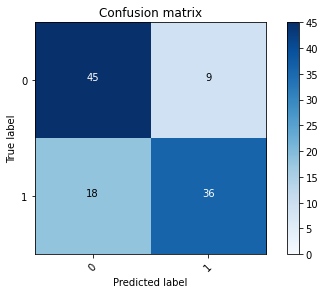

2022-07-06 17:09:17 - [Epoch Train: 104] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:09:17 - [Epoch Valid: 104] loss: 1.1676, auc: 0.8546, acc: 0.7500, time: 9.00 s
2022-07-06 17:09:17 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e104-loss1.168-acc0.750-auc0.855.pth'


 69%|███████████████████████████            | 104/150 [1:17:22<34:02, 44.40s/it]

2022-07-06 17:09:17 - EPOCH: 105
2022-07-06 17:09:30 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:09:43 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:10:00 - Valid Step 5/7, valid_loss: 1.2536
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
64      00028                1           1
40      00043                1           0
48      00052                1           0
30      00062                1           0
5       00064                0           1
44      00064                0           1
71      00072                0           0
33      00121                0           0
67      00121                0           0
104     00140                1           1
12      00142                0           0
14      00146                1           1
103     00150                0           0
51      00160                1           0
90      00167                0           0
53      00169                0      

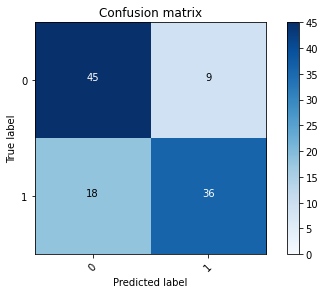

2022-07-06 17:10:02 - [Epoch Train: 105] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:10:02 - [Epoch Valid: 105] loss: 1.1860, auc: 0.8536, acc: 0.7500, time: 9.00 s
2022-07-06 17:10:02 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e105-loss1.186-acc0.750-auc0.854.pth'


 70%|███████████████████████████▎           | 105/150 [1:18:06<33:20, 44.45s/it]

2022-07-06 17:10:02 - EPOCH: 106
2022-07-06 17:10:14 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:10:27 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:10:44 - Valid Step 5/7, valid_loss: 1.4797
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
57      00028                1           1
105     00043                1           0
32      00052                1           0
3       00062                1           0
16      00064                0           1
51      00064                0           1
28      00072                0           0
102     00121                0           0
26      00121                0           0
82      00140                1           1
85      00142                0           0
6       00146                1           1
39      00150                0           0
58      00160                1           0
37      00167                0           0
8       00169                0      

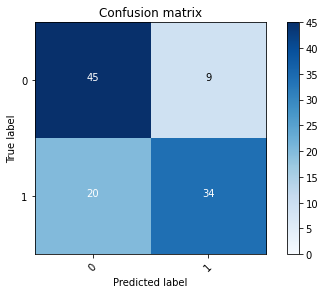

2022-07-06 17:10:46 - [Epoch Train: 106] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:10:46 - [Epoch Valid: 106] loss: 1.2087, auc: 0.8546, acc: 0.7315, time: 9.00 s


 71%|███████████████████████████▌           | 106/150 [1:18:50<32:26, 44.23s/it]

2022-07-06 17:10:46 - EPOCH: 107
2022-07-06 17:10:59 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:11:12 - Train Step 20/28, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:11:28 - Valid Step 5/7, valid_loss: 1.0902
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
46      00028                1           1
64      00043                1           0
6       00052                1           0
33      00062                1           0
94      00064                0           1
36      00064                0           1
67      00072                0           0
3       00121                0           0
57      00121                0           0
52      00140                1           1
72      00142                0           0
50      00146                1           1
11      00150                0           0
1       00160                1           0
65      00167                0           0
83      00169                0      

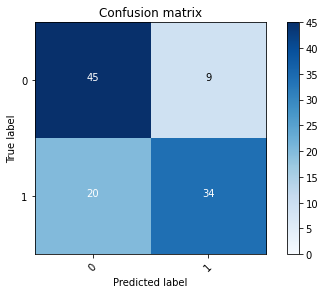

2022-07-06 17:11:30 - [Epoch Train: 107] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:11:30 - [Epoch Valid: 107] loss: 1.2180, auc: 0.8556, acc: 0.7315, time: 9.00 s


 71%|███████████████████████████▊           | 107/150 [1:19:34<31:46, 44.34s/it]

2022-07-06 17:11:30 - EPOCH: 108
2022-07-06 17:11:43 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:11:55 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:12:12 - Valid Step 5/7, valid_loss: 1.0885
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
66      00028                1           1
31      00043                1           0
26      00052                1           0
1       00062                1           0
40      00064                0           1
100     00064                0           1
71      00072                0           0
25      00121                0           0
12      00121                0           0
10      00140                1           1
94      00142                0           0
92      00146                1           1
16      00150                0           0
72      00160                1           0
48      00167                0           0
78      00169                0      

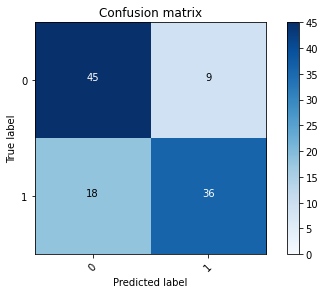

2022-07-06 17:12:14 - [Epoch Train: 108] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:12:14 - [Epoch Valid: 108] loss: 1.1623, auc: 0.8549, acc: 0.7500, time: 9.00 s
2022-07-06 17:12:14 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e108-loss1.162-acc0.750-auc0.855.pth'


 72%|████████████████████████████           | 108/150 [1:20:18<30:56, 44.19s/it]

2022-07-06 17:12:14 - EPOCH: 109
2022-07-06 17:12:27 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:12:40 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:12:58 - Valid Step 5/7, valid_loss: 1.1743
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
37      00028                1           1
47      00043                1           0
31      00052                1           0
16      00062                1           0
42      00064                0           1
95      00064                0           1
2       00072                0           0
104     00121                0           0
27      00121                0           0
40      00140                1           1
9       00142                0           0
102     00146                1           1
12      00150                0           0
72      00160                1           0
107     00167                0           0
58      00169                0      

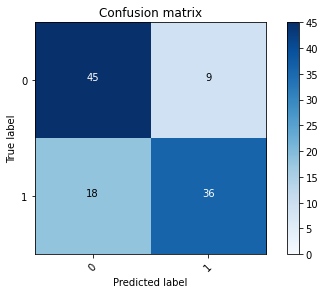

2022-07-06 17:12:59 - [Epoch Train: 109] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:12:59 - [Epoch Valid: 109] loss: 1.1629, auc: 0.8549, acc: 0.7500, time: 9.00 s
2022-07-06 17:13:00 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e109-loss1.163-acc0.750-auc0.855.pth'


 73%|████████████████████████████▎          | 109/150 [1:21:04<30:28, 44.59s/it]

2022-07-06 17:13:00 - EPOCH: 110
2022-07-06 17:13:12 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:13:24 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:13:41 - Valid Step 5/7, valid_loss: 1.2720
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
64      00028                1           1
106     00043                1           0
6       00052                1           0
53      00062                1           0
80      00064                0           1
33      00064                0           1
43      00072                0           0
50      00121                0           0
12      00121                0           0
24      00140                1           1
104     00142                0           0
9       00146                1           1
34      00150                0           0
56      00160                1           0
67      00167                0           0
107     00169                0      

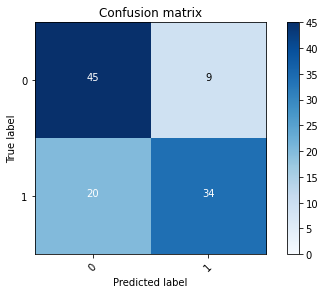

2022-07-06 17:13:43 - [Epoch Train: 110] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:13:43 - [Epoch Valid: 110] loss: 1.1964, auc: 0.8539, acc: 0.7315, time: 9.00 s


 73%|████████████████████████████▌          | 110/150 [1:21:47<29:33, 44.33s/it]

2022-07-06 17:13:43 - EPOCH: 111
2022-07-06 17:13:57 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:14:09 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:14:27 - Valid Step 5/7, valid_loss: 1.1521
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
17      00028                1           1
97      00043                1           0
76      00052                1           0
38      00062                1           0
46      00064                0           1
10      00064                0           1
35      00072                0           0
95      00121                0           0
94      00121                0           0
32      00140                1           1
29      00142                0           0
36      00146                1           1
53      00150                0           0
23      00160                1           0
91      00167                0           0
40      00169                0      

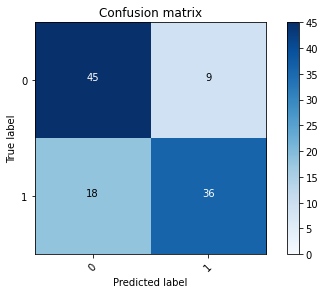

2022-07-06 17:14:29 - [Epoch Train: 111] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:14:29 - [Epoch Valid: 111] loss: 1.1701, auc: 0.8549, acc: 0.7500, time: 9.00 s
2022-07-06 17:14:29 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e111-loss1.170-acc0.750-auc0.855.pth'


 74%|████████████████████████████▊          | 111/150 [1:22:33<29:02, 44.69s/it]

2022-07-06 17:14:29 - EPOCH: 112
2022-07-06 17:14:43 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:14:56 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:15:12 - Valid Step 5/7, valid_loss: 1.1359
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
85      00028                1           1
105     00043                1           0
100     00052                1           0
67      00062                1           0
101     00064                0           1
32      00064                0           1
8       00072                0           0
13      00121                0           0
77      00121                0           0
24      00140                1           1
69      00142                0           0
37      00146                1           1
96      00150                0           0
49      00160                1           0
42      00167                0           0
40      00169                0      

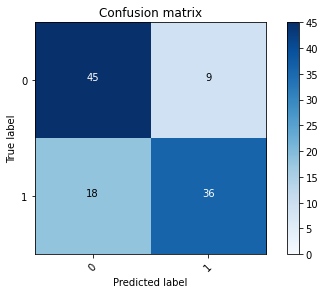

2022-07-06 17:15:14 - [Epoch Train: 112] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:15:14 - [Epoch Valid: 112] loss: 1.1683, auc: 0.8549, acc: 0.7500, time: 9.00 s
2022-07-06 17:15:14 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e112-loss1.168-acc0.750-auc0.855.pth'


 75%|█████████████████████████████          | 112/150 [1:23:18<28:21, 44.79s/it]

2022-07-06 17:15:14 - EPOCH: 113
2022-07-06 17:15:27 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:15:40 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:15:57 - Valid Step 5/7, valid_loss: 1.2102
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
56      00028                1           1
107     00043                1           0
96      00052                1           0
41      00062                1           0
40      00064                0           1
16      00064                0           1
37      00072                0           0
60      00121                0           0
84      00121                0           0
79      00140                1           1
76      00142                0           0
104     00146                1           1
52      00150                0           0
90      00160                1           0
101     00167                0           0
83      00169                0      

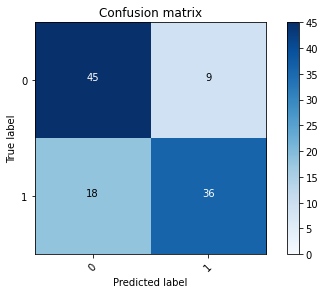

2022-07-06 17:15:59 - [Epoch Train: 113] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:15:59 - [Epoch Valid: 113] loss: 1.1946, auc: 0.8546, acc: 0.7500, time: 9.00 s
2022-07-06 17:15:59 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e113-loss1.195-acc0.750-auc0.855.pth'


 75%|█████████████████████████████▍         | 113/150 [1:24:03<27:42, 44.94s/it]

2022-07-06 17:15:59 - EPOCH: 114
2022-07-06 17:16:12 - Train Step 10/28, train_loss: 0.0003
2022-07-06 17:16:24 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:16:41 - Valid Step 5/7, valid_loss: 1.1895
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
17      00028                1           1
99      00043                1           0
34      00052                1           0
81      00062                1           0
83      00064                0           1
66      00064                0           1
107     00072                0           0
54      00121                0           0
40      00121                0           0
64      00140                1           1
53      00142                0           0
6       00146                1           1
29      00150                0           0
41      00160                1           0
91      00167                0           0
32      00169                0      

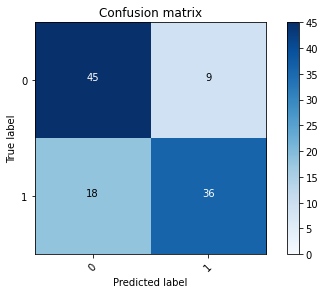

2022-07-06 17:16:43 - [Epoch Train: 114] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:16:43 - [Epoch Valid: 114] loss: 1.1924, auc: 0.8549, acc: 0.7500, time: 9.00 s
2022-07-06 17:16:43 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e114-loss1.192-acc0.750-auc0.855.pth'


 76%|█████████████████████████████▋         | 114/150 [1:24:47<26:44, 44.58s/it]

2022-07-06 17:16:43 - EPOCH: 115
2022-07-06 17:16:56 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:17:09 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:17:26 - Valid Step 5/7, valid_loss: 1.1105
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
8       00028                1           1
92      00043                1           0
58      00052                1           0
47      00062                1           0
0       00064                0           1
45      00064                0           1
5       00072                0           0
64      00121                0           0
79      00121                0           0
39      00140                1           1
101     00142                0           0
27      00146                1           1
51      00150                0           0
60      00160                1           0
57      00167                0           0
90      00169                0      

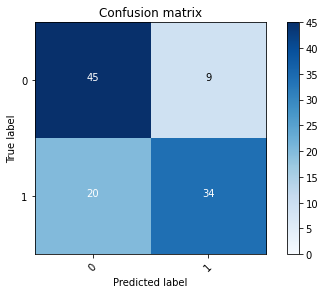

2022-07-06 17:17:28 - [Epoch Train: 115] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:17:28 - [Epoch Valid: 115] loss: 1.2160, auc: 0.8532, acc: 0.7315, time: 9.00 s


 77%|█████████████████████████████▉         | 115/150 [1:25:32<26:08, 44.81s/it]

2022-07-06 17:17:28 - EPOCH: 116
2022-07-06 17:17:41 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:17:55 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:18:11 - Valid Step 5/7, valid_loss: 1.3365
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
91      00028                1           1
102     00043                1           0
70      00052                1           0
19      00062                1           0
62      00064                0           1
20      00064                0           1
27      00072                0           0
56      00121                0           0
25      00121                0           0
43      00140                1           1
71      00142                0           0
60      00146                1           1
34      00150                0           0
79      00160                1           0
88      00167                0           0
32      00169                0      

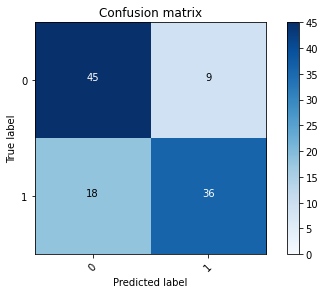

2022-07-06 17:18:13 - [Epoch Train: 116] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:18:13 - [Epoch Valid: 116] loss: 1.2057, auc: 0.8525, acc: 0.7500, time: 9.00 s
2022-07-06 17:18:13 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e116-loss1.206-acc0.750-auc0.853.pth'


 77%|██████████████████████████████▏        | 116/150 [1:26:17<25:26, 44.89s/it]

2022-07-06 17:18:13 - EPOCH: 117
2022-07-06 17:18:26 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:18:39 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:18:55 - Valid Step 5/7, valid_loss: 1.1780
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
81      00028                1           1
10      00043                1           0
34      00052                1           0
46      00062                1           0
105     00064                0           1
58      00064                0           1
21      00072                0           0
43      00121                0           0
30      00121                0           0
44      00140                1           1
101     00142                0           0
7       00146                1           1
79      00150                0           0
89      00160                1           0
66      00167                0           0
61      00169                0      

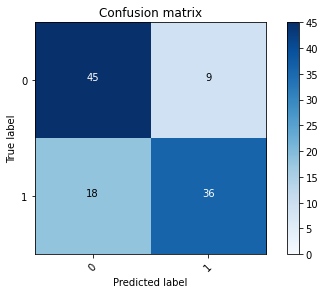

2022-07-06 17:18:57 - [Epoch Train: 117] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:18:57 - [Epoch Valid: 117] loss: 1.2264, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 17:18:57 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e117-loss1.226-acc0.750-auc0.853.pth'


 78%|██████████████████████████████▍        | 117/150 [1:27:01<24:29, 44.52s/it]

2022-07-06 17:18:57 - EPOCH: 118
2022-07-06 17:19:10 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:19:22 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:19:39 - Valid Step 5/7, valid_loss: 1.2575
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
78      00028                1           1
82      00043                1           0
27      00052                1           0
43      00062                1           0
61      00064                0           1
12      00064                0           1
67      00072                0           0
80      00121                0           0
29      00121                0           0
33      00140                1           1
74      00142                0           0
18      00146                1           1
7       00150                0           0
54      00160                1           0
48      00167                0           0
13      00169                0      

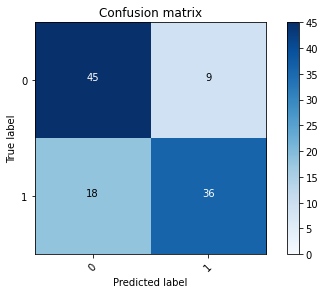

2022-07-06 17:19:41 - [Epoch Train: 118] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:19:41 - [Epoch Valid: 118] loss: 1.2174, auc: 0.8536, acc: 0.7500, time: 9.00 s
2022-07-06 17:19:41 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e118-loss1.217-acc0.750-auc0.854.pth'


 79%|██████████████████████████████▋        | 118/150 [1:27:46<23:43, 44.48s/it]

2022-07-06 17:19:41 - EPOCH: 119
2022-07-06 17:19:55 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:20:07 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:20:25 - Valid Step 5/7, valid_loss: 0.9029
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
42      00028                1           1
106     00043                1           0
62      00052                1           0
82      00062                1           0
64      00064                0           1
18      00064                0           1
61      00072                0           0
46      00121                0           0
37      00121                0           0
103     00140                1           1
60      00142                0           0
104     00146                1           1
53      00150                0           0
44      00160                1           0
50      00167                0           0
0       00169                0      

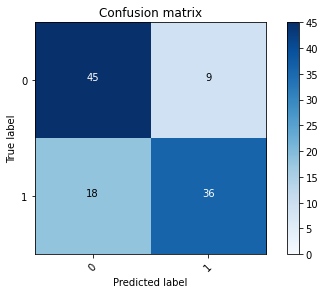

2022-07-06 17:20:27 - [Epoch Train: 119] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:20:27 - [Epoch Valid: 119] loss: 1.2087, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 17:20:27 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e119-loss1.209-acc0.750-auc0.853.pth'


 79%|██████████████████████████████▉        | 119/150 [1:28:31<23:07, 44.77s/it]

2022-07-06 17:20:27 - EPOCH: 120
2022-07-06 17:20:40 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:20:53 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:21:10 - Valid Step 5/7, valid_loss: 1.0293
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
67      00028                1           1
73      00043                1           0
19      00052                1           0
12      00062                1           0
0       00064                0           1
13      00064                0           1
1       00072                0           0
60      00121                0           0
48      00121                0           0
53      00140                1           1
46      00142                0           0
54      00146                1           1
10      00150                0           0
2       00160                1           0
79      00167                0           0
52      00169                0      

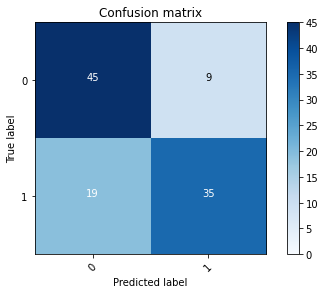

2022-07-06 17:21:12 - [Epoch Train: 120] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:21:12 - [Epoch Valid: 120] loss: 1.2407, auc: 0.8543, acc: 0.7407, time: 9.00 s


 80%|███████████████████████████████▏       | 120/150 [1:29:16<22:23, 44.79s/it]

2022-07-06 17:21:12 - EPOCH: 121
2022-07-06 17:21:25 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:21:37 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:21:54 - Valid Step 5/7, valid_loss: 0.9203
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
101     00028                1           1
56      00043                1           0
48      00052                1           0
24      00062                1           0
19      00064                0           1
97      00064                0           1
81      00072                0           0
29      00121                0           0
16      00121                0           0
8       00140                1           1
44      00142                0           0
83      00146                1           1
6       00150                0           0
87      00160                1           0
23      00167                0           0
1       00169                0      

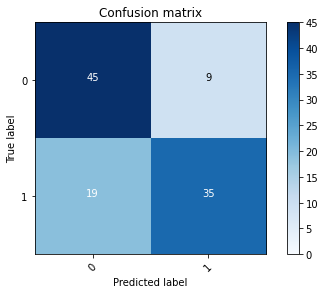

2022-07-06 17:21:56 - [Epoch Train: 121] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:21:56 - [Epoch Valid: 121] loss: 1.2475, auc: 0.8543, acc: 0.7407, time: 9.00 s


 81%|███████████████████████████████▍       | 121/150 [1:30:00<21:36, 44.70s/it]

2022-07-06 17:21:56 - EPOCH: 122
2022-07-06 17:22:09 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:22:22 - Train Step 20/28, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:22:39 - Valid Step 5/7, valid_loss: 1.0528
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
23      00028                1           1
1       00043                1           0
8       00052                1           0
58      00062                1           0
36      00064                0           1
25      00064                0           1
57      00072                0           0
32      00121                0           0
86      00121                0           0
0       00140                1           1
88      00142                0           0
68      00146                1           1
51      00150                0           0
82      00160                1           0
37      00167                0           0
74      00169                0      

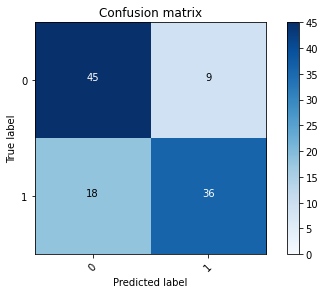

2022-07-06 17:22:41 - [Epoch Train: 122] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:22:41 - [Epoch Valid: 122] loss: 1.2377, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 17:22:41 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e122-loss1.238-acc0.750-auc0.853.pth'


 81%|███████████████████████████████▋       | 122/150 [1:30:45<20:53, 44.79s/it]

2022-07-06 17:22:41 - EPOCH: 123
2022-07-06 17:22:54 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:23:06 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:23:23 - Valid Step 5/7, valid_loss: 1.3680
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
48      00028                1           1
60      00043                1           0
59      00052                1           0
19      00062                1           0
62      00064                0           1
38      00064                0           1
35      00072                0           0
54      00121                0           0
85      00121                0           0
10      00140                1           1
83      00142                0           0
31      00146                1           1
73      00150                0           0
78      00160                1           0
88      00167                0           0
106     00169                0      

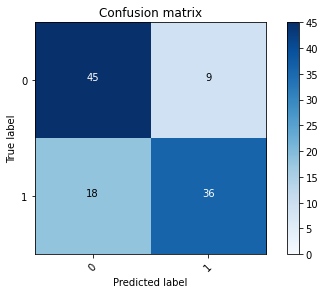

2022-07-06 17:23:25 - [Epoch Train: 123] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:23:25 - [Epoch Valid: 123] loss: 1.2280, auc: 0.8532, acc: 0.7500, time: 9.00 s
2022-07-06 17:23:25 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e123-loss1.228-acc0.750-auc0.853.pth'


 82%|███████████████████████████████▉       | 123/150 [1:31:29<19:59, 44.42s/it]

2022-07-06 17:23:25 - EPOCH: 124
2022-07-06 17:23:38 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:23:51 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:24:07 - Valid Step 5/7, valid_loss: 1.2629
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
87      00028                1           1
75      00043                1           0
50      00052                1           0
44      00062                1           0
86      00064                0           1
35      00064                0           1
107     00072                0           0
39      00121                0           0
9       00121                0           0
28      00140                1           1
8       00142                0           0
17      00146                1           1
2       00150                0           0
15      00160                1           0
65      00167                0           0
29      00169                0      

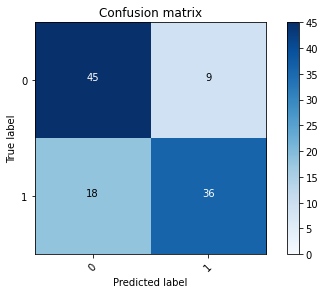

2022-07-06 17:24:08 - [Epoch Train: 124] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:24:08 - [Epoch Valid: 124] loss: 1.2244, auc: 0.8532, acc: 0.7500, time: 9.00 s
2022-07-06 17:24:08 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e124-loss1.224-acc0.750-auc0.853.pth'


 83%|████████████████████████████████▏      | 124/150 [1:32:13<19:09, 44.22s/it]

2022-07-06 17:24:08 - EPOCH: 125
2022-07-06 17:24:21 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:24:34 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:24:50 - Valid Step 5/7, valid_loss: 1.4266
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
3       00028                1           1
99      00043                1           0
73      00052                1           0
12      00062                1           0
88      00064                0           1
10      00064                0           1
5       00072                0           0
40      00121                0           0
77      00121                0           0
6       00140                1           1
101     00142                0           0
103     00146                1           1
29      00150                0           0
85      00160                1           0
17      00167                0           0
54      00169                0      

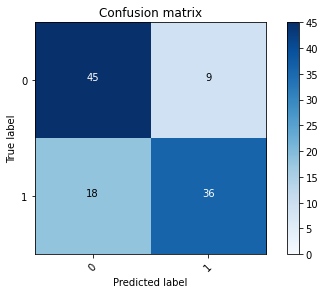

2022-07-06 17:24:51 - [Epoch Train: 125] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:24:51 - [Epoch Valid: 125] loss: 1.2468, auc: 0.8539, acc: 0.7500, time: 9.00 s
2022-07-06 17:24:51 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e125-loss1.247-acc0.750-auc0.854.pth'


 83%|████████████████████████████████▌      | 125/150 [1:32:56<18:17, 43.89s/it]

2022-07-06 17:24:51 - EPOCH: 126
2022-07-06 17:25:05 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:25:17 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:25:34 - Valid Step 5/7, valid_loss: 1.2767
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
71      00028                1           1
56      00043                1           0
16      00052                1           0
3       00062                1           0
96      00064                0           1
18      00064                0           1
26      00072                0           0
75      00121                0           0
81      00121                0           0
23      00140                1           1
47      00142                0           0
89      00146                1           1
29      00150                0           0
13      00160                1           0
2       00167                0           0
6       00169                0      

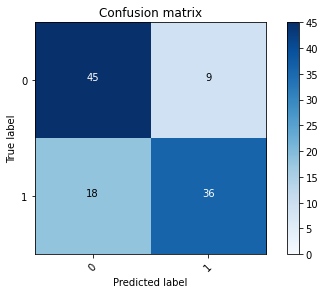

2022-07-06 17:25:35 - [Epoch Train: 126] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:25:35 - [Epoch Valid: 126] loss: 1.2319, auc: 0.8536, acc: 0.7500, time: 9.00 s
2022-07-06 17:25:35 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e126-loss1.232-acc0.750-auc0.854.pth'


 84%|████████████████████████████████▊      | 126/150 [1:33:40<17:34, 43.93s/it]

2022-07-06 17:25:35 - EPOCH: 127
2022-07-06 17:25:48 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:26:00 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:26:17 - Valid Step 5/7, valid_loss: 1.3078
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
16      00028                1           1
67      00043                1           0
96      00052                1           0
81      00062                1           0
91      00064                0           1
73      00064                0           1
75      00072                0           0
102     00121                0           0
101     00121                0           0
29      00140                1           1
99      00142                0           0
7       00146                1           1
25      00150                0           0
105     00160                1           0
39      00167                0           0
28      00169                0      

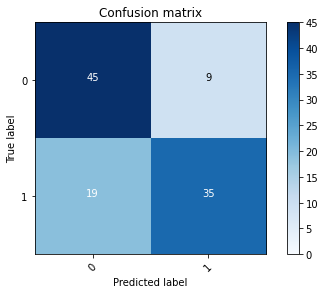

2022-07-06 17:26:19 - [Epoch Train: 127] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:26:19 - [Epoch Valid: 127] loss: 1.2665, auc: 0.8536, acc: 0.7407, time: 9.00 s


 85%|█████████████████████████████████      | 127/150 [1:34:23<16:49, 43.88s/it]

2022-07-06 17:26:19 - EPOCH: 128
2022-07-06 17:26:32 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:26:45 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:27:02 - Valid Step 5/7, valid_loss: 1.3065
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
104     00028                1           1
92      00043                1           0
89      00052                1           0
7       00062                1           0
45      00064                0           1
76      00064                0           1
61      00072                0           0
24      00121                0           0
65      00121                0           0
74      00140                1           1
23      00142                0           0
5       00146                1           1
40      00150                0           0
34      00160                1           0
106     00167                0           0
94      00169                0      

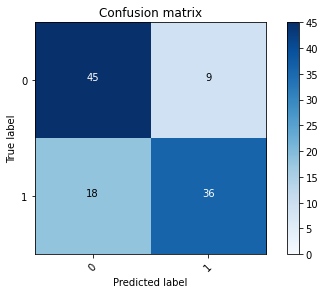

2022-07-06 17:27:04 - [Epoch Train: 128] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:27:04 - [Epoch Valid: 128] loss: 1.2623, auc: 0.8543, acc: 0.7500, time: 9.00 s
2022-07-06 17:27:04 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e128-loss1.262-acc0.750-auc0.854.pth'


 85%|█████████████████████████████████▎     | 128/150 [1:35:08<16:09, 44.09s/it]

2022-07-06 17:27:04 - EPOCH: 129
2022-07-06 17:27:17 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:27:30 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:27:47 - Valid Step 5/7, valid_loss: 1.4789
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
71      00028                1           1
37      00043                1           0
94      00052                1           0
53      00062                1           0
88      00064                0           1
84      00064                0           1
56      00072                0           0
92      00121                0           0
10      00121                0           0
50      00140                1           1
89      00142                0           0
44      00146                1           1
68      00150                0           0
69      00160                1           0
32      00167                0           0
15      00169                0      

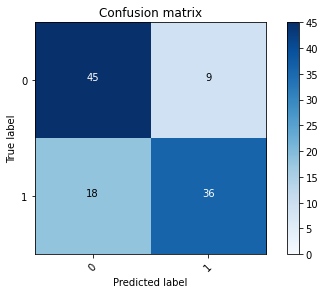

2022-07-06 17:27:49 - [Epoch Train: 129] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:27:49 - [Epoch Valid: 129] loss: 1.2586, auc: 0.8546, acc: 0.7500, time: 9.00 s
2022-07-06 17:27:49 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e129-loss1.259-acc0.750-auc0.855.pth'


 86%|█████████████████████████████████▌     | 129/150 [1:35:53<15:31, 44.34s/it]

2022-07-06 17:27:49 - EPOCH: 130
2022-07-06 17:28:02 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:28:15 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:28:32 - Valid Step 5/7, valid_loss: 1.4945
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
104     00028                1           1
28      00043                1           0
51      00052                1           0
11      00062                1           0
43      00064                0           1
89      00064                0           1
74      00072                0           0
33      00121                0           0
101     00121                0           0
84      00140                1           1
59      00142                0           0
46      00146                1           1
107     00150                0           0
40      00160                1           0
14      00167                0           0
99      00169                0      

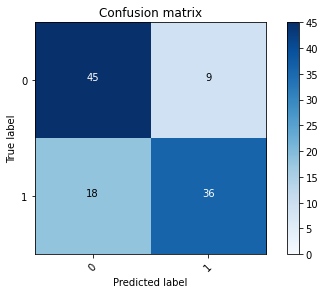

2022-07-06 17:28:34 - [Epoch Train: 130] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:28:34 - [Epoch Valid: 130] loss: 1.2587, auc: 0.8532, acc: 0.7500, time: 9.00 s
2022-07-06 17:28:34 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e130-loss1.259-acc0.750-auc0.853.pth'


 87%|█████████████████████████████████▊     | 130/150 [1:36:38<14:52, 44.62s/it]

2022-07-06 17:28:34 - EPOCH: 131
2022-07-06 17:28:47 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:28:59 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:29:16 - Valid Step 5/7, valid_loss: 1.1860
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
80      00028                1           1
47      00043                1           0
99      00052                1           0
92      00062                1           0
104     00064                0           1
64      00064                0           1
32      00072                0           0
73      00121                0           0
87      00121                0           0
66      00140                1           1
58      00142                0           0
61      00146                1           1
29      00150                0           0
51      00160                1           0
102     00167                0           0
34      00169                0      

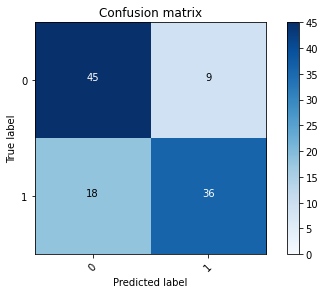

2022-07-06 17:29:18 - [Epoch Train: 131] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:29:18 - [Epoch Valid: 131] loss: 1.2374, auc: 0.8543, acc: 0.7500, time: 9.00 s
2022-07-06 17:29:18 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e131-loss1.237-acc0.750-auc0.854.pth'


 87%|██████████████████████████████████     | 131/150 [1:37:22<14:04, 44.45s/it]

2022-07-06 17:29:18 - EPOCH: 132
2022-07-06 17:29:31 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:29:45 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:30:01 - Valid Step 5/7, valid_loss: 1.2857
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
85      00028                1           1
75      00043                1           0
63      00052                1           0
9       00062                1           0
16      00064                0           1
36      00064                0           1
106     00072                0           0
55      00121                0           0
21      00121                0           0
51      00140                1           1
54      00142                0           0
68      00146                1           1
96      00150                0           0
22      00160                1           0
59      00167                0           0
60      00169                0      

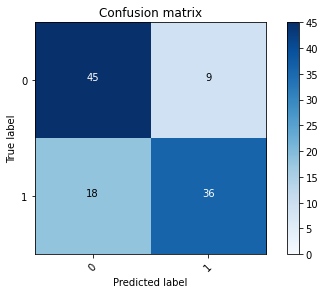

2022-07-06 17:30:03 - [Epoch Train: 132] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:30:03 - [Epoch Valid: 132] loss: 1.2700, auc: 0.8539, acc: 0.7500, time: 9.00 s
2022-07-06 17:30:03 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e132-loss1.270-acc0.750-auc0.854.pth'


 88%|██████████████████████████████████▎    | 132/150 [1:38:07<13:20, 44.46s/it]

2022-07-06 17:30:03 - EPOCH: 133
2022-07-06 17:30:15 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:30:28 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:30:44 - Valid Step 5/7, valid_loss: 1.4532
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
74      00028                1           1
61      00043                1           0
63      00052                1           0
26      00062                1           0
47      00064                0           1
106     00064                0           1
8       00072                0           0
83      00121                0           0
93      00121                0           0
40      00140                1           1
67      00142                0           0
12      00146                1           1
62      00150                0           0
35      00160                1           0
107     00167                0           0
80      00169                0      

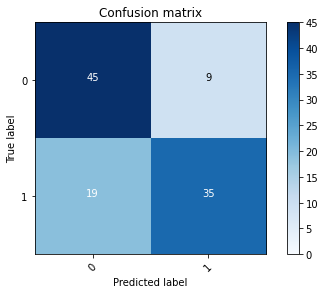

2022-07-06 17:30:46 - [Epoch Train: 133] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:30:46 - [Epoch Valid: 133] loss: 1.2907, auc: 0.8553, acc: 0.7407, time: 9.00 s


 89%|██████████████████████████████████▌    | 133/150 [1:38:50<12:29, 44.07s/it]

2022-07-06 17:30:46 - EPOCH: 134
2022-07-06 17:30:58 - Train Step 10/28, train_loss: 0.0002
2022-07-06 17:31:11 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:31:27 - Valid Step 5/7, valid_loss: 1.5367
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
1       00028                1           1
103     00043                1           0
98      00052                1           0
47      00062                1           0
69      00064                0           1
63      00064                0           1
31      00072                0           0
0       00121                0           0
79      00121                0           0
106     00140                1           1
15      00142                0           0
32      00146                1           1
9       00150                0           0
50      00160                1           0
38      00167                0           0
16      00169                0      

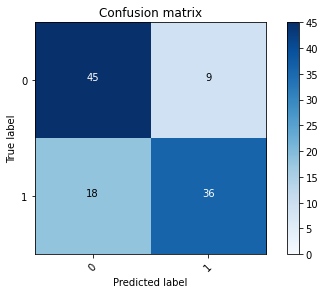

2022-07-06 17:31:29 - [Epoch Train: 134] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:31:29 - [Epoch Valid: 134] loss: 1.2556, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 17:31:29 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e134-loss1.256-acc0.750-auc0.853.pth'


 89%|██████████████████████████████████▊    | 134/150 [1:39:33<11:39, 43.74s/it]

2022-07-06 17:31:29 - EPOCH: 135
2022-07-06 17:31:42 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:31:55 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:32:12 - Valid Step 5/7, valid_loss: 1.1273
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
105     00028                1           1
67      00043                1           0
55      00052                1           0
92      00062                1           0
5       00064                0           1
18      00064                0           1
13      00072                0           0
95      00121                0           0
54      00121                0           0
47      00140                1           1
21      00142                0           0
76      00146                1           1
37      00150                0           0
96      00160                1           0
49      00167                0           0
6       00169                0      

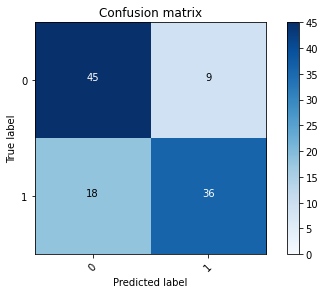

2022-07-06 17:32:14 - [Epoch Train: 135] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:32:14 - [Epoch Valid: 135] loss: 1.2540, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 17:32:14 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e135-loss1.254-acc0.750-auc0.853.pth'


 90%|███████████████████████████████████    | 135/150 [1:40:18<11:02, 44.15s/it]

2022-07-06 17:32:14 - EPOCH: 136
2022-07-06 17:32:28 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:32:40 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:32:57 - Valid Step 5/7, valid_loss: 1.0299
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
105     00028                1           1
4       00043                1           0
2       00052                1           0
90      00062                1           0
18      00064                0           1
17      00064                0           1
39      00072                0           0
77      00121                0           0
27      00121                0           0
12      00140                1           1
63      00142                0           0
66      00146                1           1
29      00150                0           0
64      00160                1           0
38      00167                0           0
75      00169                0      

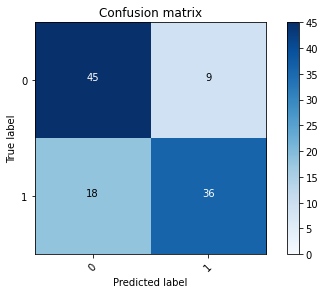

2022-07-06 17:32:59 - [Epoch Train: 136] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:32:59 - [Epoch Valid: 136] loss: 1.2715, auc: 0.8539, acc: 0.7500, time: 9.00 s
2022-07-06 17:32:59 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e136-loss1.272-acc0.750-auc0.854.pth'


 91%|███████████████████████████████████▎   | 136/150 [1:41:03<10:22, 44.45s/it]

2022-07-06 17:32:59 - EPOCH: 137
2022-07-06 17:33:12 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:33:25 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:33:42 - Valid Step 5/7, valid_loss: 1.2612
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
28      00028                1           1
57      00043                1           0
93      00052                1           0
89      00062                1           0
55      00064                0           1
70      00064                0           1
80      00072                0           0
46      00121                0           0
68      00121                0           0
94      00140                1           1
11      00142                0           0
25      00146                1           1
42      00150                0           0
96      00160                1           0
97      00167                0           0
40      00169                0      

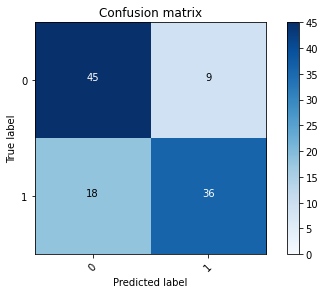

2022-07-06 17:33:44 - [Epoch Train: 137] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:33:44 - [Epoch Valid: 137] loss: 1.2764, auc: 0.8539, acc: 0.7500, time: 9.00 s
2022-07-06 17:33:44 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e137-loss1.276-acc0.750-auc0.854.pth'


 91%|███████████████████████████████████▌   | 137/150 [1:41:48<09:39, 44.57s/it]

2022-07-06 17:33:44 - EPOCH: 138
2022-07-06 17:33:57 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:34:10 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:34:27 - Valid Step 5/7, valid_loss: 1.5179
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
24      00028                1           1
77      00043                1           0
27      00052                1           0
29      00062                1           0
69      00064                0           1
40      00064                0           1
85      00072                0           0
50      00121                0           0
11      00121                0           0
26      00140                1           1
28      00142                0           0
91      00146                1           1
17      00150                0           0
64      00160                1           0
82      00167                0           0
71      00169                0      

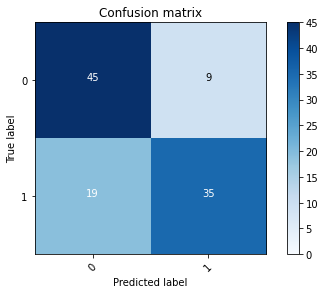

2022-07-06 17:34:29 - [Epoch Train: 138] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:34:29 - [Epoch Valid: 138] loss: 1.2918, auc: 0.8529, acc: 0.7407, time: 9.00 s


 92%|███████████████████████████████████▉   | 138/150 [1:42:33<08:55, 44.66s/it]

2022-07-06 17:34:29 - EPOCH: 139
2022-07-06 17:34:42 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:34:55 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:35:11 - Valid Step 5/7, valid_loss: 1.1833
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
98      00028                1           1
51      00043                1           0
44      00052                1           0
41      00062                1           0
37      00064                0           1
70      00064                0           1
68      00072                0           0
38      00121                0           0
15      00121                0           0
103     00140                1           1
84      00142                0           0
6       00146                1           1
20      00150                0           0
77      00160                1           0
25      00167                0           0
49      00169                0      

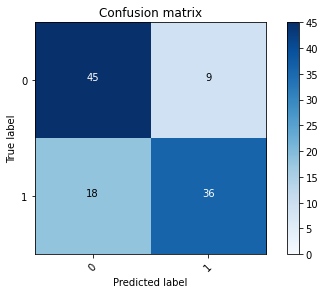

2022-07-06 17:35:13 - [Epoch Train: 139] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:35:13 - [Epoch Valid: 139] loss: 1.2832, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 17:35:13 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e139-loss1.283-acc0.750-auc0.853.pth'


 93%|████████████████████████████████████▏  | 139/150 [1:43:17<08:08, 44.45s/it]

2022-07-06 17:35:13 - EPOCH: 140
2022-07-06 17:35:25 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:35:38 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:35:55 - Valid Step 5/7, valid_loss: 1.3802
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
97      00028                1           1
76      00043                1           0
71      00052                1           0
98      00062                1           0
60      00064                0           1
53      00064                0           1
41      00072                0           0
12      00121                0           0
52      00121                0           0
83      00140                1           1
15      00142                0           0
79      00146                1           1
29      00150                0           0
30      00160                1           0
73      00167                0           0
43      00169                0      

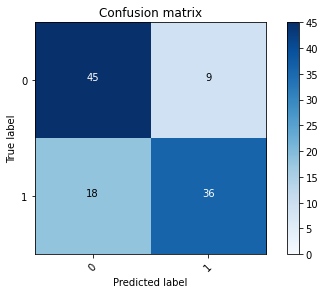

2022-07-06 17:35:57 - [Epoch Train: 140] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:35:57 - [Epoch Valid: 140] loss: 1.2968, auc: 0.8553, acc: 0.7500, time: 9.00 s
2022-07-06 17:35:57 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e140-loss1.297-acc0.750-auc0.855.pth'


 93%|████████████████████████████████████▍  | 140/150 [1:44:01<07:24, 44.41s/it]

2022-07-06 17:35:57 - EPOCH: 141
2022-07-06 17:36:10 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:36:23 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:36:39 - Valid Step 5/7, valid_loss: 1.2873
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
2       00028                1           1
95      00043                1           0
97      00052                1           0
83      00062                1           0
107     00064                0           1
36      00064                0           1
67      00072                0           0
98      00121                0           0
89      00121                0           0
65      00140                1           1
56      00142                0           0
17      00146                1           1
106     00150                0           0
34      00160                1           0
11      00167                0           0
43      00169                0      

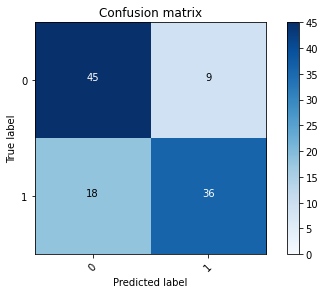

2022-07-06 17:36:41 - [Epoch Train: 141] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:36:41 - [Epoch Valid: 141] loss: 1.2916, auc: 0.8556, acc: 0.7500, time: 9.00 s
2022-07-06 17:36:41 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e141-loss1.292-acc0.750-auc0.856.pth'


 94%|████████████████████████████████████▋  | 141/150 [1:44:45<06:38, 44.28s/it]

2022-07-06 17:36:41 - EPOCH: 142
2022-07-06 17:36:54 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:37:06 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:37:23 - Valid Step 5/7, valid_loss: 1.3896
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
49      00028                1           1
71      00043                1           0
57      00052                1           0
17      00062                1           0
48      00064                0           1
8       00064                0           1
96      00072                0           0
16      00121                0           0
102     00121                0           0
84      00140                1           1
59      00142                0           0
30      00146                1           1
21      00150                0           0
90      00160                1           0
73      00167                0           0
20      00169                0      

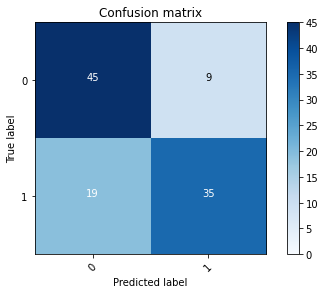

2022-07-06 17:37:25 - [Epoch Train: 142] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:37:25 - [Epoch Valid: 142] loss: 1.3140, auc: 0.8549, acc: 0.7407, time: 9.00 s


 95%|████████████████████████████████████▉  | 142/150 [1:45:29<05:54, 44.27s/it]

2022-07-06 17:37:25 - EPOCH: 143
2022-07-06 17:37:38 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:37:50 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:38:07 - Valid Step 5/7, valid_loss: 1.2944
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
91      00028                1           1
9       00043                1           0
93      00052                1           0
73      00062                1           0
26      00064                0           1
18      00064                0           1
40      00072                0           0
57      00121                0           0
37      00121                0           0
13      00140                1           1
89      00142                0           0
76      00146                1           1
67      00150                0           0
3       00160                1           0
15      00167                0           0
55      00169                0      

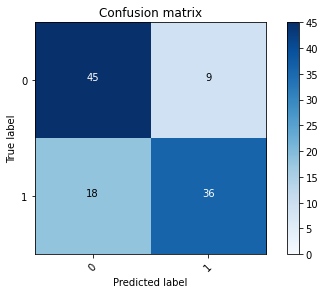

2022-07-06 17:38:09 - [Epoch Train: 143] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:38:09 - [Epoch Valid: 143] loss: 1.2771, auc: 0.8532, acc: 0.7500, time: 9.00 s
2022-07-06 17:38:09 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e143-loss1.277-acc0.750-auc0.853.pth'


 95%|█████████████████████████████████████▏ | 143/150 [1:46:13<05:08, 44.04s/it]

2022-07-06 17:38:09 - EPOCH: 144
2022-07-06 17:38:21 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:38:33 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:38:50 - Valid Step 5/7, valid_loss: 0.9606
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
94      00028                1           1
72      00043                1           0
46      00052                1           0
78      00062                1           0
8       00064                0           1
35      00064                0           1
17      00072                0           0
29      00121                0           0
14      00121                0           0
4       00140                1           1
103     00142                0           0
89      00146                1           1
96      00150                0           0
74      00160                1           0
37      00167                0           0
52      00169                0      

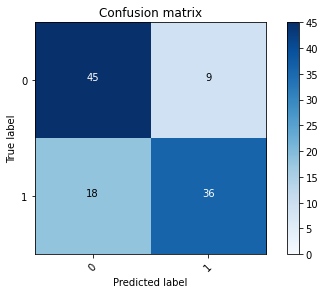

2022-07-06 17:38:52 - [Epoch Train: 144] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:38:52 - [Epoch Valid: 144] loss: 1.2939, auc: 0.8549, acc: 0.7500, time: 9.00 s
2022-07-06 17:38:52 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e144-loss1.294-acc0.750-auc0.855.pth'


 96%|█████████████████████████████████████▍ | 144/150 [1:46:56<04:22, 43.81s/it]

2022-07-06 17:38:52 - EPOCH: 145
2022-07-06 17:39:05 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:39:17 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:39:34 - Valid Step 5/7, valid_loss: 0.9958
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
0       00028                1           1
13      00043                1           0
25      00052                1           0
100     00062                1           0
93      00064                0           1
20      00064                0           1
28      00072                0           0
6       00121                0           0
40      00121                0           0
48      00140                1           1
21      00142                0           0
36      00146                1           1
65      00150                0           0
45      00160                1           0
105     00167                0           0
5       00169                0      

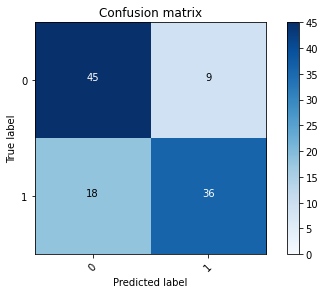

2022-07-06 17:39:36 - [Epoch Train: 145] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:39:36 - [Epoch Valid: 145] loss: 1.2815, auc: 0.8522, acc: 0.7500, time: 9.00 s
2022-07-06 17:39:36 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e145-loss1.281-acc0.750-auc0.852.pth'


 97%|█████████████████████████████████████▋ | 145/150 [1:47:40<03:39, 43.87s/it]

2022-07-06 17:39:36 - EPOCH: 146
2022-07-06 17:39:49 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:40:01 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:40:18 - Valid Step 5/7, valid_loss: 1.5599
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
74      00028                1           1
55      00043                1           0
34      00052                1           0
22      00062                1           0
20      00064                0           1
2       00064                0           1
33      00072                0           0
84      00121                0           0
50      00121                0           0
89      00140                1           1
73      00142                0           0
46      00146                1           1
27      00150                0           0
76      00160                1           0
38      00167                0           0
86      00169                0      

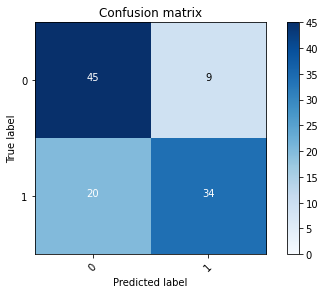

2022-07-06 17:40:20 - [Epoch Train: 146] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:40:20 - [Epoch Valid: 146] loss: 1.3317, auc: 0.8536, acc: 0.7315, time: 9.00 s


 97%|█████████████████████████████████████▉ | 146/150 [1:48:24<02:55, 43.83s/it]

2022-07-06 17:40:20 - EPOCH: 147
2022-07-06 17:40:33 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:40:45 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:41:02 - Valid Step 5/7, valid_loss: 1.4380
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
65      00028                1           1
7       00043                1           0
53      00052                1           0
6       00062                1           0
48      00064                0           1
40      00064                0           1
24      00072                0           0
59      00121                0           0
75      00121                0           0
99      00140                1           1
3       00142                0           0
58      00146                1           1
16      00150                0           0
88      00160                1           0
57      00167                0           0
43      00169                0      

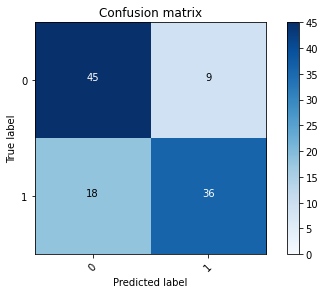

2022-07-06 17:41:04 - [Epoch Train: 147] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:41:04 - [Epoch Valid: 147] loss: 1.2666, auc: 0.8546, acc: 0.7500, time: 9.00 s
2022-07-06 17:41:04 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e147-loss1.267-acc0.750-auc0.855.pth'


 98%|██████████████████████████████████████▏| 147/150 [1:49:08<02:11, 43.85s/it]

2022-07-06 17:41:04 - EPOCH: 148
2022-07-06 17:41:16 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:41:29 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:41:45 - Valid Step 5/7, valid_loss: 1.0013
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
13      00028                1           1
48      00043                1           0
49      00052                1           0
81      00062                1           0
71      00064                0           1
19      00064                0           1
39      00072                0           0
73      00121                0           0
15      00121                0           0
103     00140                1           1
7       00142                0           0
17      00146                1           1
5       00150                0           0
93      00160                1           0
82      00167                0           0
44      00169                0      

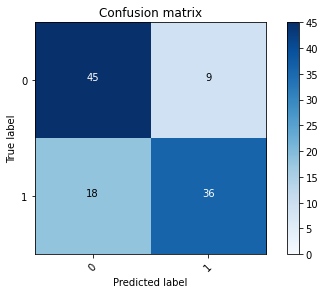

2022-07-06 17:41:47 - [Epoch Train: 148] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:41:47 - [Epoch Valid: 148] loss: 1.2768, auc: 0.8560, acc: 0.7500, time: 9.00 s
2022-07-06 17:41:47 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e148-loss1.277-acc0.750-auc0.856.pth'


 99%|██████████████████████████████████████▍| 148/150 [1:49:52<01:27, 43.80s/it]

2022-07-06 17:41:47 - EPOCH: 149
2022-07-06 17:42:01 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:42:13 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:42:30 - Valid Step 5/7, valid_loss: 1.3136
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
26      00028                1           1
80      00043                1           0
38      00052                1           0
10      00062                1           0
20      00064                0           1
64      00064                0           1
96      00072                0           0
18      00121                0           0
88      00121                0           0
76      00140                1           1
98      00142                0           0
94      00146                1           1
91      00150                0           0
67      00160                1           0
39      00167                0           0
83      00169                0      

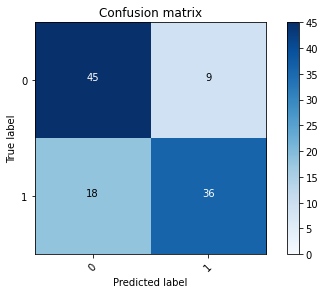

2022-07-06 17:42:32 - [Epoch Train: 149] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:42:32 - [Epoch Valid: 149] loss: 1.2871, auc: 0.8546, acc: 0.7500, time: 9.00 s
2022-07-06 17:42:32 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e149-loss1.287-acc0.750-auc0.855.pth'


 99%|██████████████████████████████████████▋| 149/150 [1:50:36<00:44, 44.10s/it]

2022-07-06 17:42:32 - EPOCH: 150
2022-07-06 17:42:45 - Train Step 10/28, train_loss: 0.0001
2022-07-06 17:42:57 - Train Step 20/28, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-07-06 17:43:14 - Valid Step 5/7, valid_loss: 1.4464
First 64 results:
    BraTS21ID  MGMT_real_value  MGMT_value
101     00028                1           1
2       00043                1           0
69      00052                1           0
20      00062                1           0
17      00064                0           1
55      00064                0           1
35      00072                0           0
59      00121                0           0
49      00121                0           0
16      00140                1           1
7       00142                0           0
105     00146                1           1
34      00150                0           0
83      00160                1           0
88      00167                0           0
97      00169                0      

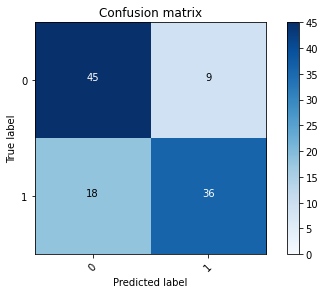

2022-07-06 17:43:15 - [Epoch Train: 150] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:43:15 - [Epoch Valid: 150] loss: 1.3082, auc: 0.8529, acc: 0.7500, time: 9.00 s
2022-07-06 17:43:15 - acc improved from 0.7500 to 0.7500. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_15-51-55/RSNAClassifierSingle3D-DW-SO-KLF-e150-loss1.308-acc0.750-auc0.853.pth'


100%|███████████████████████████████████████| 150/150 [1:51:20<00:00, 44.53s/it]

../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00048_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00078_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00084_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00089_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00134_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00144_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00154_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00171_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00187_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00192_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00194_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00199_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00240_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00245_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00261_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00299_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00397_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00399_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00402_K

Dataset: Labeled Test Set
   BraTS21ID  MGMT_real_value  MGMT_value
54     00048                1           1
38     00078                1           1
45     00084                0           1
39     00089                1           1
3      00134                1           0
19     00144                1           1
17     00154                0           0
56     00171                1           1
2      00187                1           0
16     00192                0           1
47     00194                0           1
13     00194                0           1
0      00199                1           0
29     00240                1           0
32     00245                1           1
15     00261                0           1
35     00299                1           1
37     00397                0           1
21     00397                0           1
1      00399                0           0
31     00402                0           0
11     00402                0           0
34     0

2022-07-06 17:43:21 - Train/Val datasets size: 273
Length of concatenated dataset: 546
Length of concatenated dataset: 546
Train Idx:
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 1

  0%|                                                   | 0/150 [00:00<?, ?it/s]

2022-07-06 17:43:21 - EPOCH: 1
2022-07-06 17:43:23 - Train Step 10/219, train_loss: 0.7527
2022-07-06 17:43:25 - Train Step 20/219, train_loss: 0.7373
2022-07-06 17:43:26 - Train Step 30/219, train_loss: 0.7073
2022-07-06 17:43:28 - Train Step 40/219, train_loss: 0.7034
2022-07-06 17:43:30 - Train Step 50/219, train_loss: 0.6994
2022-07-06 17:43:31 - Train Step 60/219, train_loss: 0.6876
2022-07-06 17:43:33 - Train Step 70/219, train_loss: 0.6723
2022-07-06 17:43:34 - Train Step 80/219, train_loss: 0.6834
2022-07-06 17:43:36 - Train Step 90/219, train_loss: 0.6901
2022-07-06 17:43:37 - Train Step 100/219, train_loss: 0.6914
2022-07-06 17:43:39 - Train Step 110/219, train_loss: 0.6983
2022-07-06 17:43:41 - Train Step 120/219, train_loss: 0.7053
2022-07-06 17:43:42 - Train Step 130/219, train_loss: 0.7086
2022-07-06 17:43:44 - Train Step 140/219, train_loss: 0.7060
2022-07-06 17:43:45 - Train Step 150/219, train_loss: 0.7086
2022-07-06 17:43:47 - Train Step 160/219, train_loss: 0.7021
20

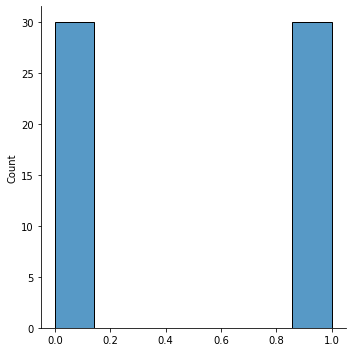

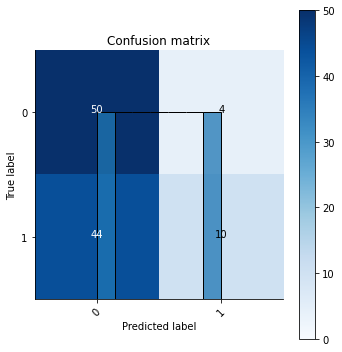

2022-07-06 17:44:05 - [Epoch Train: 1] loss: 0.6867, auc: 0.5933, acc: 0.5479, time: 34.00 s            
2022-07-06 17:44:05 - [Epoch Valid: 1] loss: 0.6495, auc: 0.6824, acc: 0.5556, time: 8.00 s
2022-07-06 17:44:05 - acc improved from 0.0000 to 0.5556. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_17-43-21/RSNAClassifierSingle3D-DW-SO-KLF-e1-loss0.649-acc0.556-auc0.682.pth'


  1%|▎                                        | 1/150 [00:43<1:47:45, 43.39s/it]

2022-07-06 17:44:05 - EPOCH: 2
2022-07-06 17:44:07 - Train Step 10/219, train_loss: 0.5994
2022-07-06 17:44:08 - Train Step 20/219, train_loss: 0.5802
2022-07-06 17:44:10 - Train Step 30/219, train_loss: 0.5457
2022-07-06 17:44:11 - Train Step 40/219, train_loss: 0.5348
2022-07-06 17:44:13 - Train Step 50/219, train_loss: 0.5353
2022-07-06 17:44:14 - Train Step 60/219, train_loss: 0.5412
2022-07-06 17:44:16 - Train Step 70/219, train_loss: 0.5467
2022-07-06 17:44:18 - Train Step 80/219, train_loss: 0.5687
2022-07-06 17:44:19 - Train Step 90/219, train_loss: 0.5648
2022-07-06 17:44:21 - Train Step 100/219, train_loss: 0.5498
2022-07-06 17:44:22 - Train Step 110/219, train_loss: 0.5579
2022-07-06 17:44:24 - Train Step 120/219, train_loss: 0.5661
2022-07-06 17:44:25 - Train Step 130/219, train_loss: 0.5663
2022-07-06 17:44:27 - Train Step 140/219, train_loss: 0.5629
2022-07-06 17:44:28 - Train Step 150/219, train_loss: 0.5617
2022-07-06 17:44:30 - Train Step 160/219, train_loss: 0.5494
20

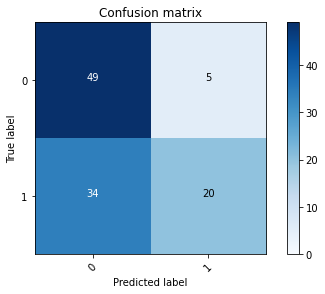

2022-07-06 17:44:48 - [Epoch Train: 2] loss: 0.5218, auc: 0.8276, acc: 0.7306, time: 34.00 s            
2022-07-06 17:44:48 - [Epoch Valid: 2] loss: 0.6623, auc: 0.7798, acc: 0.6389, time: 8.00 s
2022-07-06 17:44:48 - acc improved from 0.5556 to 0.6389. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_17-43-21/RSNAClassifierSingle3D-DW-SO-KLF-e2-loss0.662-acc0.639-auc0.780.pth'


  1%|▌                                        | 2/150 [01:27<1:47:30, 43.58s/it]

2022-07-06 17:44:48 - EPOCH: 3
2022-07-06 17:44:50 - Train Step 10/219, train_loss: 0.2574
2022-07-06 17:44:52 - Train Step 20/219, train_loss: 0.2198
2022-07-06 17:44:53 - Train Step 30/219, train_loss: 0.2537
2022-07-06 17:44:55 - Train Step 40/219, train_loss: 0.2461
2022-07-06 17:44:56 - Train Step 50/219, train_loss: 0.2375
2022-07-06 17:44:58 - Train Step 60/219, train_loss: 0.2444
2022-07-06 17:44:59 - Train Step 70/219, train_loss: 0.2229
2022-07-06 17:45:01 - Train Step 80/219, train_loss: 0.2114
2022-07-06 17:45:02 - Train Step 90/219, train_loss: 0.2000
2022-07-06 17:45:04 - Train Step 100/219, train_loss: 0.1976
2022-07-06 17:45:05 - Train Step 110/219, train_loss: 0.1927
2022-07-06 17:45:07 - Train Step 120/219, train_loss: 0.2271
2022-07-06 17:45:08 - Train Step 130/219, train_loss: 0.2235
2022-07-06 17:45:10 - Train Step 140/219, train_loss: 0.2295
2022-07-06 17:45:11 - Train Step 150/219, train_loss: 0.2215
2022-07-06 17:45:13 - Train Step 160/219, train_loss: 0.2352
20

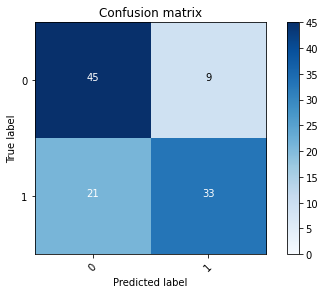

2022-07-06 17:45:31 - [Epoch Train: 3] loss: 0.2363, auc: 0.9687, acc: 0.9201, time: 33.00 s            
2022-07-06 17:45:31 - [Epoch Valid: 3] loss: 0.9266, auc: 0.7298, acc: 0.7222, time: 9.00 s
2022-07-06 17:45:31 - acc improved from 0.6389 to 0.7222. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_17-43-21/RSNAClassifierSingle3D-DW-SO-KLF-e3-loss0.927-acc0.722-auc0.730.pth'


  2%|▊                                        | 3/150 [02:10<1:46:01, 43.28s/it]

2022-07-06 17:45:31 - EPOCH: 4
2022-07-06 17:45:33 - Train Step 10/219, train_loss: 0.1715
2022-07-06 17:45:35 - Train Step 20/219, train_loss: 0.2268
2022-07-06 17:45:36 - Train Step 30/219, train_loss: 0.1901
2022-07-06 17:45:38 - Train Step 40/219, train_loss: 0.2078
2022-07-06 17:45:39 - Train Step 50/219, train_loss: 0.1942
2022-07-06 17:45:41 - Train Step 60/219, train_loss: 0.2072
2022-07-06 17:45:42 - Train Step 70/219, train_loss: 0.1818
2022-07-06 17:45:44 - Train Step 80/219, train_loss: 0.1761
2022-07-06 17:45:45 - Train Step 90/219, train_loss: 0.1651
2022-07-06 17:45:47 - Train Step 100/219, train_loss: 0.1520
2022-07-06 17:45:48 - Train Step 110/219, train_loss: 0.1709
2022-07-06 17:45:50 - Train Step 120/219, train_loss: 0.1724
2022-07-06 17:45:51 - Train Step 130/219, train_loss: 0.1617
2022-07-06 17:45:53 - Train Step 140/219, train_loss: 0.1579
2022-07-06 17:45:54 - Train Step 150/219, train_loss: 0.1684
2022-07-06 17:45:56 - Train Step 160/219, train_loss: 0.1670
20

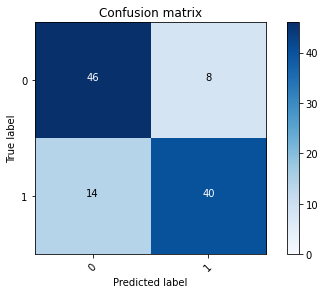

2022-07-06 17:46:14 - [Epoch Train: 4] loss: 0.1618, auc: 0.9822, acc: 0.9338, time: 33.00 s            
2022-07-06 17:46:14 - [Epoch Valid: 4] loss: 0.7607, auc: 0.8059, acc: 0.7963, time: 9.00 s
2022-07-06 17:46:14 - acc improved from 0.7222 to 0.7963. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_17-43-21/RSNAClassifierSingle3D-DW-SO-KLF-e4-loss0.761-acc0.796-auc0.806.pth'


  3%|█                                        | 4/150 [02:52<1:44:45, 43.05s/it]

2022-07-06 17:46:14 - EPOCH: 5
2022-07-06 17:46:16 - Train Step 10/219, train_loss: 0.0403
2022-07-06 17:46:17 - Train Step 20/219, train_loss: 0.0403
2022-07-06 17:46:19 - Train Step 30/219, train_loss: 0.0375
2022-07-06 17:46:20 - Train Step 40/219, train_loss: 0.0355
2022-07-06 17:46:22 - Train Step 50/219, train_loss: 0.0348
2022-07-06 17:46:24 - Train Step 60/219, train_loss: 0.0320
2022-07-06 17:46:25 - Train Step 70/219, train_loss: 0.0328
2022-07-06 17:46:27 - Train Step 80/219, train_loss: 0.0361
2022-07-06 17:46:28 - Train Step 90/219, train_loss: 0.0334
2022-07-06 17:46:30 - Train Step 100/219, train_loss: 0.0309
2022-07-06 17:46:31 - Train Step 110/219, train_loss: 0.0455
2022-07-06 17:46:33 - Train Step 120/219, train_loss: 0.0516
2022-07-06 17:46:35 - Train Step 130/219, train_loss: 0.0567
2022-07-06 17:46:36 - Train Step 140/219, train_loss: 0.0557
2022-07-06 17:46:38 - Train Step 150/219, train_loss: 0.0532
2022-07-06 17:46:39 - Train Step 160/219, train_loss: 0.0602
20

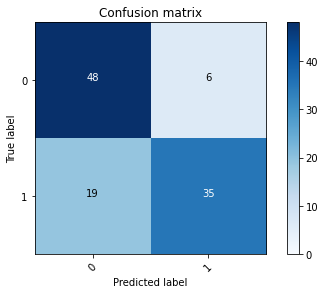

2022-07-06 17:46:58 - [Epoch Train: 5] loss: 0.0652, auc: 0.9977, acc: 0.9772, time: 34.00 s            
2022-07-06 17:46:58 - [Epoch Valid: 5] loss: 0.8756, auc: 0.8464, acc: 0.7685, time: 9.00 s


  3%|█▎                                       | 5/150 [03:36<1:44:33, 43.26s/it]

2022-07-06 17:46:58 - EPOCH: 6
2022-07-06 17:46:59 - Train Step 10/219, train_loss: 0.0202
2022-07-06 17:47:01 - Train Step 20/219, train_loss: 0.0642
2022-07-06 17:47:03 - Train Step 30/219, train_loss: 0.0536
2022-07-06 17:47:04 - Train Step 40/219, train_loss: 0.0437
2022-07-06 17:47:06 - Train Step 50/219, train_loss: 0.0377
2022-07-06 17:47:07 - Train Step 60/219, train_loss: 0.0317
2022-07-06 17:47:09 - Train Step 70/219, train_loss: 0.0350
2022-07-06 17:47:10 - Train Step 80/219, train_loss: 0.0354
2022-07-06 17:47:12 - Train Step 90/219, train_loss: 0.0333
2022-07-06 17:47:13 - Train Step 100/219, train_loss: 0.0328
2022-07-06 17:47:15 - Train Step 110/219, train_loss: 0.0306
2022-07-06 17:47:16 - Train Step 120/219, train_loss: 0.0313
2022-07-06 17:47:18 - Train Step 130/219, train_loss: 0.0292
2022-07-06 17:47:19 - Train Step 140/219, train_loss: 0.0412
2022-07-06 17:47:21 - Train Step 150/219, train_loss: 0.0415
2022-07-06 17:47:23 - Train Step 160/219, train_loss: 0.0397
20

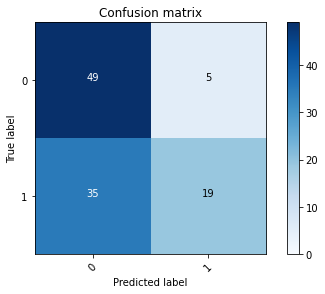

2022-07-06 17:47:41 - [Epoch Train: 6] loss: 0.0439, auc: 0.9989, acc: 0.9863, time: 34.00 s            
2022-07-06 17:47:41 - [Epoch Valid: 6] loss: 1.9596, auc: 0.7970, acc: 0.6296, time: 8.00 s


  4%|█▋                                       | 6/150 [04:19<1:43:35, 43.16s/it]

2022-07-06 17:47:41 - EPOCH: 7
2022-07-06 17:47:42 - Train Step 10/219, train_loss: 0.0124
2022-07-06 17:47:44 - Train Step 20/219, train_loss: 0.2504
2022-07-06 17:47:46 - Train Step 30/219, train_loss: 0.1991
2022-07-06 17:47:47 - Train Step 40/219, train_loss: 0.1828
2022-07-06 17:47:49 - Train Step 50/219, train_loss: 0.1532
2022-07-06 17:47:50 - Train Step 60/219, train_loss: 0.1334
2022-07-06 17:47:52 - Train Step 70/219, train_loss: 0.1156
2022-07-06 17:47:53 - Train Step 80/219, train_loss: 0.1015
2022-07-06 17:47:55 - Train Step 90/219, train_loss: 0.0907
2022-07-06 17:47:56 - Train Step 100/219, train_loss: 0.0882
2022-07-06 17:47:58 - Train Step 110/219, train_loss: 0.0842
2022-07-06 17:47:59 - Train Step 120/219, train_loss: 0.0780
2022-07-06 17:48:01 - Train Step 130/219, train_loss: 0.0756
2022-07-06 17:48:03 - Train Step 140/219, train_loss: 0.0711
2022-07-06 17:48:04 - Train Step 150/219, train_loss: 0.0713
2022-07-06 17:48:06 - Train Step 160/219, train_loss: 0.0879
20

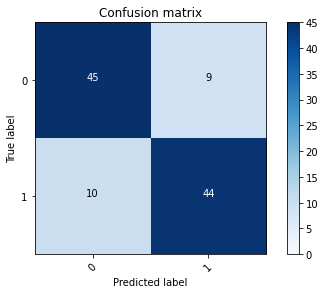

2022-07-06 17:48:24 - [Epoch Train: 7] loss: 0.0799, auc: 0.9955, acc: 0.9749, time: 34.00 s            
2022-07-06 17:48:24 - [Epoch Valid: 7] loss: 0.9931, auc: 0.8357, acc: 0.8241, time: 8.00 s
2022-07-06 17:48:24 - acc improved from 0.7963 to 0.8241. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_17-43-21/RSNAClassifierSingle3D-DW-SO-KLF-e7-loss0.993-acc0.824-auc0.836.pth'


  5%|█▉                                       | 7/150 [05:02<1:42:45, 43.11s/it]

2022-07-06 17:48:24 - EPOCH: 8
2022-07-06 17:48:25 - Train Step 10/219, train_loss: 0.0089
2022-07-06 17:48:27 - Train Step 20/219, train_loss: 0.0151
2022-07-06 17:48:28 - Train Step 30/219, train_loss: 0.0162
2022-07-06 17:48:30 - Train Step 40/219, train_loss: 0.0127
2022-07-06 17:48:32 - Train Step 50/219, train_loss: 0.0124
2022-07-06 17:48:33 - Train Step 60/219, train_loss: 0.0106
2022-07-06 17:48:35 - Train Step 70/219, train_loss: 0.0162
2022-07-06 17:48:36 - Train Step 80/219, train_loss: 0.0168
2022-07-06 17:48:38 - Train Step 90/219, train_loss: 0.0160
2022-07-06 17:48:39 - Train Step 100/219, train_loss: 0.0208
2022-07-06 17:48:41 - Train Step 110/219, train_loss: 0.0203
2022-07-06 17:48:43 - Train Step 120/219, train_loss: 0.0206
2022-07-06 17:48:44 - Train Step 130/219, train_loss: 0.0195
2022-07-06 17:48:46 - Train Step 140/219, train_loss: 0.0189
2022-07-06 17:48:47 - Train Step 150/219, train_loss: 0.0178
2022-07-06 17:48:49 - Train Step 160/219, train_loss: 0.0172
20

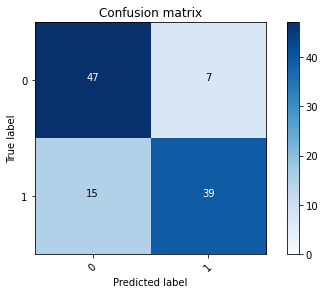

2022-07-06 17:49:07 - [Epoch Train: 8] loss: 0.0172, auc: 1.0000, acc: 0.9954, time: 34.00 s            
2022-07-06 17:49:07 - [Epoch Valid: 8] loss: 1.1355, auc: 0.8398, acc: 0.7963, time: 8.00 s


  5%|██▏                                      | 8/150 [05:45<1:42:20, 43.25s/it]

2022-07-06 17:49:07 - EPOCH: 9
2022-07-06 17:49:09 - Train Step 10/219, train_loss: 0.0077
2022-07-06 17:49:11 - Train Step 20/219, train_loss: 0.0179
2022-07-06 17:49:12 - Train Step 30/219, train_loss: 0.0121
2022-07-06 17:49:14 - Train Step 40/219, train_loss: 0.0094
2022-07-06 17:49:15 - Train Step 50/219, train_loss: 0.0153
2022-07-06 17:49:17 - Train Step 60/219, train_loss: 0.0132
2022-07-06 17:49:18 - Train Step 70/219, train_loss: 0.0113
2022-07-06 17:49:20 - Train Step 80/219, train_loss: 0.0128
2022-07-06 17:49:21 - Train Step 90/219, train_loss: 0.0115
2022-07-06 17:49:23 - Train Step 100/219, train_loss: 0.0119
2022-07-06 17:49:24 - Train Step 110/219, train_loss: 0.0285
2022-07-06 17:49:26 - Train Step 120/219, train_loss: 0.0261
2022-07-06 17:49:27 - Train Step 130/219, train_loss: 0.0301
2022-07-06 17:49:29 - Train Step 140/219, train_loss: 0.0317
2022-07-06 17:49:30 - Train Step 150/219, train_loss: 0.0315
2022-07-06 17:49:32 - Train Step 160/219, train_loss: 0.0299
20

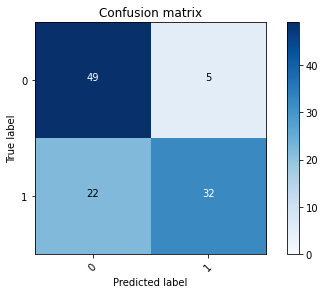

2022-07-06 17:49:50 - [Epoch Train: 9] loss: 0.0263, auc: 0.9996, acc: 0.9909, time: 34.00 s            
2022-07-06 17:49:50 - [Epoch Valid: 9] loss: 1.3122, auc: 0.8402, acc: 0.7500, time: 8.00 s


  6%|██▍                                      | 9/150 [06:29<1:41:34, 43.23s/it]

2022-07-06 17:49:50 - EPOCH: 10
2022-07-06 17:49:52 - Train Step 10/219, train_loss: 0.0014
2022-07-06 17:49:54 - Train Step 20/219, train_loss: 0.0013
2022-07-06 17:49:55 - Train Step 30/219, train_loss: 0.0012
2022-07-06 17:49:57 - Train Step 40/219, train_loss: 0.0013
2022-07-06 17:49:58 - Train Step 50/219, train_loss: 0.0023
2022-07-06 17:50:00 - Train Step 60/219, train_loss: 0.0031
2022-07-06 17:50:01 - Train Step 70/219, train_loss: 0.0039
2022-07-06 17:50:03 - Train Step 80/219, train_loss: 0.0036
2022-07-06 17:50:04 - Train Step 90/219, train_loss: 0.0041
2022-07-06 17:50:06 - Train Step 100/219, train_loss: 0.0037
2022-07-06 17:50:07 - Train Step 110/219, train_loss: 0.0034
2022-07-06 17:50:09 - Train Step 120/219, train_loss: 0.0032
2022-07-06 17:50:10 - Train Step 130/219, train_loss: 0.0033
2022-07-06 17:50:12 - Train Step 140/219, train_loss: 0.0033
2022-07-06 17:50:13 - Train Step 150/219, train_loss: 0.0032
2022-07-06 17:50:15 - Train Step 160/219, train_loss: 0.0030
2

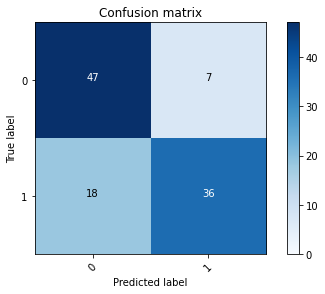

2022-07-06 17:50:33 - [Epoch Train: 10] loss: 0.0073, auc: 1.0000, acc: 0.9977, time: 33.00 s            
2022-07-06 17:50:33 - [Epoch Valid: 10] loss: 1.3325, auc: 0.8436, acc: 0.7685, time: 9.00 s


  7%|██▋                                     | 10/150 [07:11<1:40:32, 43.09s/it]

2022-07-06 17:50:33 - EPOCH: 11
2022-07-06 17:50:35 - Train Step 10/219, train_loss: 0.0021
2022-07-06 17:50:37 - Train Step 20/219, train_loss: 0.0034
2022-07-06 17:50:38 - Train Step 30/219, train_loss: 0.0024
2022-07-06 17:50:40 - Train Step 40/219, train_loss: 0.0021
2022-07-06 17:50:41 - Train Step 50/219, train_loss: 0.0017
2022-07-06 17:50:43 - Train Step 60/219, train_loss: 0.0015
2022-07-06 17:50:45 - Train Step 70/219, train_loss: 0.0014
2022-07-06 17:50:46 - Train Step 80/219, train_loss: 0.0013
2022-07-06 17:50:48 - Train Step 90/219, train_loss: 0.0017
2022-07-06 17:50:49 - Train Step 100/219, train_loss: 0.0016
2022-07-06 17:50:51 - Train Step 110/219, train_loss: 0.0019
2022-07-06 17:50:53 - Train Step 120/219, train_loss: 0.0017
2022-07-06 17:50:54 - Train Step 130/219, train_loss: 0.0017
2022-07-06 17:50:56 - Train Step 140/219, train_loss: 0.0016
2022-07-06 17:50:57 - Train Step 150/219, train_loss: 0.0016
2022-07-06 17:50:59 - Train Step 160/219, train_loss: 0.0015
2

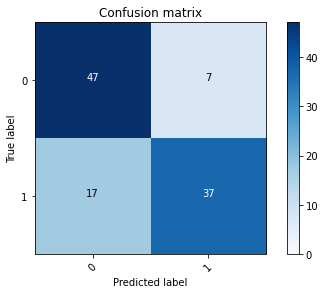

2022-07-06 17:51:17 - [Epoch Train: 11] loss: 0.0014, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:51:17 - [Epoch Valid: 11] loss: 1.2095, auc: 0.8440, acc: 0.7778, time: 8.00 s


  7%|██▉                                     | 11/150 [07:55<1:40:32, 43.40s/it]

2022-07-06 17:51:17 - EPOCH: 12
2022-07-06 17:51:19 - Train Step 10/219, train_loss: 0.0034
2022-07-06 17:51:21 - Train Step 20/219, train_loss: 0.0021
2022-07-06 17:51:22 - Train Step 30/219, train_loss: 0.0015
2022-07-06 17:51:24 - Train Step 40/219, train_loss: 0.0012
2022-07-06 17:51:25 - Train Step 50/219, train_loss: 0.0010
2022-07-06 17:51:27 - Train Step 60/219, train_loss: 0.0009
2022-07-06 17:51:29 - Train Step 70/219, train_loss: 0.0010
2022-07-06 17:51:30 - Train Step 80/219, train_loss: 0.0010
2022-07-06 17:51:32 - Train Step 90/219, train_loss: 0.0010
2022-07-06 17:51:33 - Train Step 100/219, train_loss: 0.0009
2022-07-06 17:51:35 - Train Step 110/219, train_loss: 0.0009
2022-07-06 17:51:37 - Train Step 120/219, train_loss: 0.0008
2022-07-06 17:51:38 - Train Step 130/219, train_loss: 0.0008
2022-07-06 17:51:40 - Train Step 140/219, train_loss: 0.0008
2022-07-06 17:51:41 - Train Step 150/219, train_loss: 0.0008
2022-07-06 17:51:43 - Train Step 160/219, train_loss: 0.0007
2

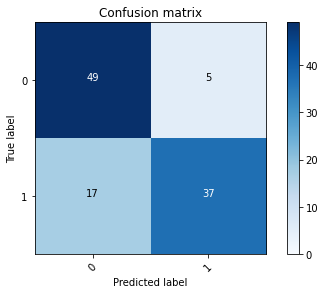

2022-07-06 17:52:01 - [Epoch Train: 12] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:52:01 - [Epoch Valid: 12] loss: 1.3401, auc: 0.8419, acc: 0.7963, time: 8.00 s


  8%|███▏                                    | 12/150 [08:39<1:40:12, 43.57s/it]

2022-07-06 17:52:01 - EPOCH: 13
2022-07-06 17:52:03 - Train Step 10/219, train_loss: 0.0004
2022-07-06 17:52:05 - Train Step 20/219, train_loss: 0.0039
2022-07-06 17:52:06 - Train Step 30/219, train_loss: 0.0044
2022-07-06 17:52:08 - Train Step 40/219, train_loss: 0.0033
2022-07-06 17:52:09 - Train Step 50/219, train_loss: 0.0027
2022-07-06 17:52:11 - Train Step 60/219, train_loss: 0.0023
2022-07-06 17:52:13 - Train Step 70/219, train_loss: 0.0020
2022-07-06 17:52:14 - Train Step 80/219, train_loss: 0.0018
2022-07-06 17:52:16 - Train Step 90/219, train_loss: 0.0016
2022-07-06 17:52:17 - Train Step 100/219, train_loss: 0.0015
2022-07-06 17:52:19 - Train Step 110/219, train_loss: 0.0014
2022-07-06 17:52:21 - Train Step 120/219, train_loss: 0.0014
2022-07-06 17:52:22 - Train Step 130/219, train_loss: 0.0013
2022-07-06 17:52:24 - Train Step 140/219, train_loss: 0.0012
2022-07-06 17:52:26 - Train Step 150/219, train_loss: 0.0011
2022-07-06 17:52:27 - Train Step 160/219, train_loss: 0.0011
2

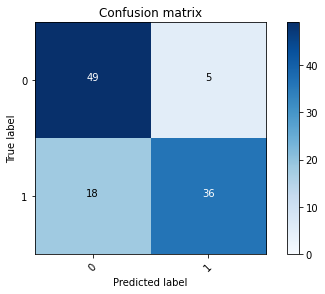

2022-07-06 17:52:46 - [Epoch Train: 13] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:52:46 - [Epoch Valid: 13] loss: 1.3718, auc: 0.8429, acc: 0.7870, time: 9.00 s


  9%|███▍                                    | 13/150 [09:24<1:40:11, 43.88s/it]

2022-07-06 17:52:46 - EPOCH: 14
2022-07-06 17:52:48 - Train Step 10/219, train_loss: 0.0003
2022-07-06 17:52:49 - Train Step 20/219, train_loss: 0.0003
2022-07-06 17:52:51 - Train Step 30/219, train_loss: 0.0003
2022-07-06 17:52:52 - Train Step 40/219, train_loss: 0.0002
2022-07-06 17:52:54 - Train Step 50/219, train_loss: 0.0002
2022-07-06 17:52:56 - Train Step 60/219, train_loss: 0.0003
2022-07-06 17:52:57 - Train Step 70/219, train_loss: 0.0003
2022-07-06 17:52:59 - Train Step 80/219, train_loss: 0.0003
2022-07-06 17:53:00 - Train Step 90/219, train_loss: 0.0003
2022-07-06 17:53:02 - Train Step 100/219, train_loss: 0.0003
2022-07-06 17:53:04 - Train Step 110/219, train_loss: 0.0003
2022-07-06 17:53:05 - Train Step 120/219, train_loss: 0.0004
2022-07-06 17:53:07 - Train Step 130/219, train_loss: 0.0004
2022-07-06 17:53:08 - Train Step 140/219, train_loss: 0.0004
2022-07-06 17:53:10 - Train Step 150/219, train_loss: 0.0004
2022-07-06 17:53:12 - Train Step 160/219, train_loss: 0.0003
2

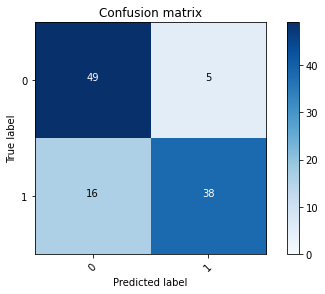

2022-07-06 17:53:30 - [Epoch Train: 14] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:53:30 - [Epoch Valid: 14] loss: 1.3481, auc: 0.8440, acc: 0.8056, time: 8.00 s


  9%|███▋                                    | 14/150 [10:08<1:39:38, 43.96s/it]

2022-07-06 17:53:30 - EPOCH: 15
2022-07-06 17:53:32 - Train Step 10/219, train_loss: 0.0003
2022-07-06 17:53:33 - Train Step 20/219, train_loss: 0.0002
2022-07-06 17:53:35 - Train Step 30/219, train_loss: 0.0003
2022-07-06 17:53:36 - Train Step 40/219, train_loss: 0.0002
2022-07-06 17:53:38 - Train Step 50/219, train_loss: 0.0002
2022-07-06 17:53:40 - Train Step 60/219, train_loss: 0.0007
2022-07-06 17:53:41 - Train Step 70/219, train_loss: 0.0006
2022-07-06 17:53:43 - Train Step 80/219, train_loss: 0.0006
2022-07-06 17:53:44 - Train Step 90/219, train_loss: 0.0006
2022-07-06 17:53:46 - Train Step 100/219, train_loss: 0.0012
2022-07-06 17:53:47 - Train Step 110/219, train_loss: 0.0011
2022-07-06 17:53:49 - Train Step 120/219, train_loss: 0.0010
2022-07-06 17:53:51 - Train Step 130/219, train_loss: 0.0009
2022-07-06 17:53:52 - Train Step 140/219, train_loss: 0.0009
2022-07-06 17:53:54 - Train Step 150/219, train_loss: 0.0008
2022-07-06 17:53:55 - Train Step 160/219, train_loss: 0.0008
2

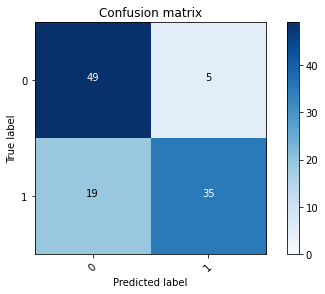

2022-07-06 17:54:14 - [Epoch Train: 15] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:54:14 - [Epoch Valid: 15] loss: 1.7025, auc: 0.8378, acc: 0.7778, time: 9.00 s


 10%|████                                    | 15/150 [10:52<1:38:44, 43.89s/it]

2022-07-06 17:54:14 - EPOCH: 16
2022-07-06 17:54:15 - Train Step 10/219, train_loss: 0.0002
2022-07-06 17:54:17 - Train Step 20/219, train_loss: 0.0002
2022-07-06 17:54:19 - Train Step 30/219, train_loss: 0.0002
2022-07-06 17:54:20 - Train Step 40/219, train_loss: 0.0002
2022-07-06 17:54:22 - Train Step 50/219, train_loss: 0.0002
2022-07-06 17:54:23 - Train Step 60/219, train_loss: 0.0002
2022-07-06 17:54:25 - Train Step 70/219, train_loss: 0.0002
2022-07-06 17:54:26 - Train Step 80/219, train_loss: 0.0002
2022-07-06 17:54:28 - Train Step 90/219, train_loss: 0.0002
2022-07-06 17:54:29 - Train Step 100/219, train_loss: 0.0002
2022-07-06 17:54:31 - Train Step 110/219, train_loss: 0.0003
2022-07-06 17:54:33 - Train Step 120/219, train_loss: 0.0003
2022-07-06 17:54:34 - Train Step 130/219, train_loss: 0.0003
2022-07-06 17:54:36 - Train Step 140/219, train_loss: 0.0003
2022-07-06 17:54:37 - Train Step 150/219, train_loss: 0.0007
2022-07-06 17:54:39 - Train Step 160/219, train_loss: 0.0006
2

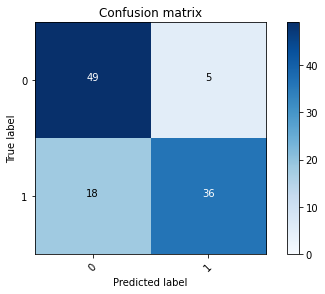

2022-07-06 17:54:57 - [Epoch Train: 16] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:54:57 - [Epoch Valid: 16] loss: 1.4395, auc: 0.8419, acc: 0.7870, time: 8.00 s


 11%|████▎                                   | 16/150 [11:35<1:37:22, 43.60s/it]

2022-07-06 17:54:57 - EPOCH: 17
2022-07-06 17:54:58 - Train Step 10/219, train_loss: 0.0002
2022-07-06 17:55:00 - Train Step 20/219, train_loss: 0.0002
2022-07-06 17:55:02 - Train Step 30/219, train_loss: 0.0001
2022-07-06 17:55:03 - Train Step 40/219, train_loss: 0.0003
2022-07-06 17:55:05 - Train Step 50/219, train_loss: 0.0003
2022-07-06 17:55:06 - Train Step 60/219, train_loss: 0.0002
2022-07-06 17:55:08 - Train Step 70/219, train_loss: 0.0003
2022-07-06 17:55:09 - Train Step 80/219, train_loss: 0.0002
2022-07-06 17:55:11 - Train Step 90/219, train_loss: 0.0002
2022-07-06 17:55:13 - Train Step 100/219, train_loss: 0.0002
2022-07-06 17:55:14 - Train Step 110/219, train_loss: 0.0002
2022-07-06 17:55:16 - Train Step 120/219, train_loss: 0.0002
2022-07-06 17:55:18 - Train Step 130/219, train_loss: 0.0002
2022-07-06 17:55:19 - Train Step 140/219, train_loss: 0.0002
2022-07-06 17:55:21 - Train Step 150/219, train_loss: 0.0002
2022-07-06 17:55:22 - Train Step 160/219, train_loss: 0.0002
2

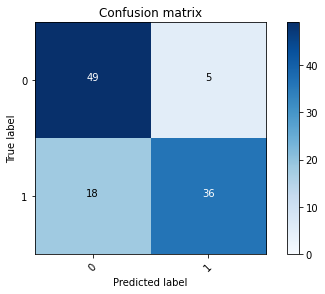

2022-07-06 17:55:41 - [Epoch Train: 17] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:55:41 - [Epoch Valid: 17] loss: 1.4825, auc: 0.8398, acc: 0.7870, time: 8.00 s


 11%|████▌                                   | 17/150 [12:19<1:37:06, 43.81s/it]

2022-07-06 17:55:41 - EPOCH: 18
2022-07-06 17:55:43 - Train Step 10/219, train_loss: 0.0003
2022-07-06 17:55:44 - Train Step 20/219, train_loss: 0.0002
2022-07-06 17:55:46 - Train Step 30/219, train_loss: 0.0002
2022-07-06 17:55:48 - Train Step 40/219, train_loss: 0.0007
2022-07-06 17:55:49 - Train Step 50/219, train_loss: 0.0007
2022-07-06 17:55:51 - Train Step 60/219, train_loss: 0.0006
2022-07-06 17:55:52 - Train Step 70/219, train_loss: 0.0005
2022-07-06 17:55:54 - Train Step 80/219, train_loss: 0.0004
2022-07-06 17:55:55 - Train Step 90/219, train_loss: 0.0004
2022-07-06 17:55:57 - Train Step 100/219, train_loss: 0.0004
2022-07-06 17:55:59 - Train Step 110/219, train_loss: 0.0004
2022-07-06 17:56:00 - Train Step 120/219, train_loss: 0.0003
2022-07-06 17:56:02 - Train Step 130/219, train_loss: 0.0003
2022-07-06 17:56:03 - Train Step 140/219, train_loss: 0.0003
2022-07-06 17:56:05 - Train Step 150/219, train_loss: 0.0003
2022-07-06 17:56:07 - Train Step 160/219, train_loss: 0.0003
2

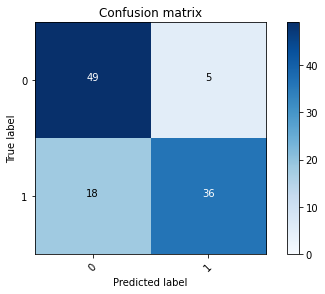

2022-07-06 17:56:25 - [Epoch Train: 18] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:56:25 - [Epoch Valid: 18] loss: 1.6272, auc: 0.8436, acc: 0.7870, time: 8.00 s


 12%|████▊                                   | 18/150 [13:04<1:36:51, 44.02s/it]

2022-07-06 17:56:25 - EPOCH: 19
2022-07-06 17:56:27 - Train Step 10/219, train_loss: 0.0005
2022-07-06 17:56:29 - Train Step 20/219, train_loss: 0.0003
2022-07-06 17:56:30 - Train Step 30/219, train_loss: 0.0002
2022-07-06 17:56:32 - Train Step 40/219, train_loss: 0.0002
2022-07-06 17:56:33 - Train Step 50/219, train_loss: 0.0002
2022-07-06 17:56:35 - Train Step 60/219, train_loss: 0.0002
2022-07-06 17:56:37 - Train Step 70/219, train_loss: 0.0005
2022-07-06 17:56:38 - Train Step 80/219, train_loss: 0.0005
2022-07-06 17:56:40 - Train Step 90/219, train_loss: 0.0004
2022-07-06 17:56:41 - Train Step 100/219, train_loss: 0.0004
2022-07-06 17:56:43 - Train Step 110/219, train_loss: 0.0004
2022-07-06 17:56:44 - Train Step 120/219, train_loss: 0.0004
2022-07-06 17:56:46 - Train Step 130/219, train_loss: 0.0003
2022-07-06 17:56:47 - Train Step 140/219, train_loss: 0.0003
2022-07-06 17:56:49 - Train Step 150/219, train_loss: 0.0003
2022-07-06 17:56:51 - Train Step 160/219, train_loss: 0.0003
2

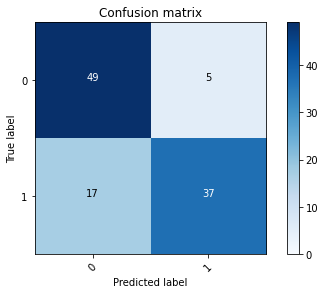

2022-07-06 17:57:09 - [Epoch Train: 19] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:57:09 - [Epoch Valid: 19] loss: 1.4967, auc: 0.8453, acc: 0.7963, time: 9.00 s


 13%|█████                                   | 19/150 [13:47<1:35:37, 43.80s/it]

2022-07-06 17:57:09 - EPOCH: 20
2022-07-06 17:57:10 - Train Step 10/219, train_loss: 0.0001
2022-07-06 17:57:12 - Train Step 20/219, train_loss: 0.0001
2022-07-06 17:57:13 - Train Step 30/219, train_loss: 0.0001
2022-07-06 17:57:15 - Train Step 40/219, train_loss: 0.0004
2022-07-06 17:57:16 - Train Step 50/219, train_loss: 0.0004
2022-07-06 17:57:18 - Train Step 60/219, train_loss: 0.0003
2022-07-06 17:57:19 - Train Step 70/219, train_loss: 0.0003
2022-07-06 17:57:21 - Train Step 80/219, train_loss: 0.0003
2022-07-06 17:57:23 - Train Step 90/219, train_loss: 0.0003
2022-07-06 17:57:24 - Train Step 100/219, train_loss: 0.0003
2022-07-06 17:57:26 - Train Step 110/219, train_loss: 0.0003
2022-07-06 17:57:27 - Train Step 120/219, train_loss: 0.0003
2022-07-06 17:57:29 - Train Step 130/219, train_loss: 0.0002
2022-07-06 17:57:30 - Train Step 140/219, train_loss: 0.0002
2022-07-06 17:57:32 - Train Step 150/219, train_loss: 0.0002
2022-07-06 17:57:33 - Train Step 160/219, train_loss: 0.0002
2

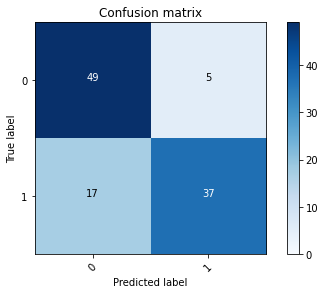

2022-07-06 17:57:51 - [Epoch Train: 20] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 17:57:51 - [Epoch Valid: 20] loss: 1.5670, auc: 0.8436, acc: 0.7963, time: 8.00 s


 13%|█████▎                                  | 20/150 [14:29<1:33:55, 43.35s/it]

2022-07-06 17:57:51 - EPOCH: 21
2022-07-06 17:57:53 - Train Step 10/219, train_loss: 0.0000
2022-07-06 17:57:54 - Train Step 20/219, train_loss: 0.0001
2022-07-06 17:57:56 - Train Step 30/219, train_loss: 0.0001
2022-07-06 17:57:57 - Train Step 40/219, train_loss: 0.0001
2022-07-06 17:57:59 - Train Step 50/219, train_loss: 0.0001
2022-07-06 17:58:00 - Train Step 60/219, train_loss: 0.0002
2022-07-06 17:58:02 - Train Step 70/219, train_loss: 0.0002
2022-07-06 17:58:04 - Train Step 80/219, train_loss: 0.0002
2022-07-06 17:58:05 - Train Step 90/219, train_loss: 0.0002
2022-07-06 17:58:07 - Train Step 100/219, train_loss: 0.0002
2022-07-06 17:58:08 - Train Step 110/219, train_loss: 0.0002
2022-07-06 17:58:10 - Train Step 120/219, train_loss: 0.0002
2022-07-06 17:58:11 - Train Step 130/219, train_loss: 0.0002
2022-07-06 17:58:13 - Train Step 140/219, train_loss: 0.0002
2022-07-06 17:58:14 - Train Step 150/219, train_loss: 0.0001
2022-07-06 17:58:16 - Train Step 160/219, train_loss: 0.0001
2

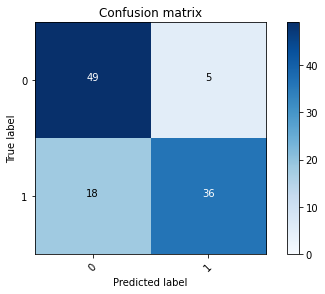

2022-07-06 17:58:34 - [Epoch Train: 21] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 17:58:34 - [Epoch Valid: 21] loss: 1.5951, auc: 0.8447, acc: 0.7870, time: 8.00 s


 14%|█████▌                                  | 21/150 [15:12<1:32:59, 43.25s/it]

2022-07-06 17:58:34 - EPOCH: 22
2022-07-06 17:58:36 - Train Step 10/219, train_loss: 0.0001
2022-07-06 17:58:37 - Train Step 20/219, train_loss: 0.0001
2022-07-06 17:58:39 - Train Step 30/219, train_loss: 0.0001
2022-07-06 17:58:41 - Train Step 40/219, train_loss: 0.0001
2022-07-06 17:58:42 - Train Step 50/219, train_loss: 0.0002
2022-07-06 17:58:44 - Train Step 60/219, train_loss: 0.0002
2022-07-06 17:58:45 - Train Step 70/219, train_loss: 0.0002
2022-07-06 17:58:47 - Train Step 80/219, train_loss: 0.0002
2022-07-06 17:58:49 - Train Step 90/219, train_loss: 0.0002
2022-07-06 17:58:50 - Train Step 100/219, train_loss: 0.0002
2022-07-06 17:58:52 - Train Step 110/219, train_loss: 0.0002
2022-07-06 17:58:53 - Train Step 120/219, train_loss: 0.0001
2022-07-06 17:58:55 - Train Step 130/219, train_loss: 0.0001
2022-07-06 17:58:57 - Train Step 140/219, train_loss: 0.0001
2022-07-06 17:58:58 - Train Step 150/219, train_loss: 0.0001
2022-07-06 17:59:00 - Train Step 160/219, train_loss: 0.0001
2

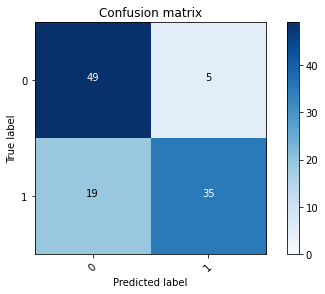

2022-07-06 17:59:18 - [Epoch Train: 22] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 17:59:18 - [Epoch Valid: 22] loss: 1.7282, auc: 0.8438, acc: 0.7778, time: 8.00 s


 15%|█████▊                                  | 22/150 [15:57<1:33:00, 43.60s/it]

2022-07-06 17:59:18 - EPOCH: 23
2022-07-06 17:59:20 - Train Step 10/219, train_loss: 0.0001
2022-07-06 17:59:22 - Train Step 20/219, train_loss: 0.0001
2022-07-06 17:59:23 - Train Step 30/219, train_loss: 0.0001
2022-07-06 17:59:25 - Train Step 40/219, train_loss: 0.0001
2022-07-06 17:59:27 - Train Step 50/219, train_loss: 0.0001
2022-07-06 17:59:28 - Train Step 60/219, train_loss: 0.0001
2022-07-06 17:59:30 - Train Step 70/219, train_loss: 0.0001
2022-07-06 17:59:31 - Train Step 80/219, train_loss: 0.0001
2022-07-06 17:59:33 - Train Step 90/219, train_loss: 0.0001
2022-07-06 17:59:34 - Train Step 100/219, train_loss: 0.0001
2022-07-06 17:59:36 - Train Step 110/219, train_loss: 0.0001
2022-07-06 17:59:38 - Train Step 120/219, train_loss: 0.0001
2022-07-06 17:59:39 - Train Step 130/219, train_loss: 0.0001
2022-07-06 17:59:41 - Train Step 140/219, train_loss: 0.0001
2022-07-06 17:59:42 - Train Step 150/219, train_loss: 0.0001
2022-07-06 17:59:44 - Train Step 160/219, train_loss: 0.0001
2

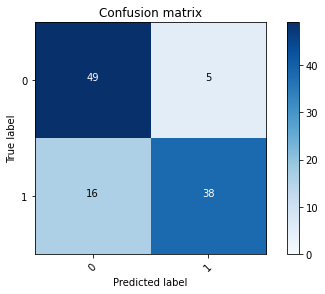

2022-07-06 18:00:01 - [Epoch Train: 23] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:00:01 - [Epoch Valid: 23] loss: 1.6673, auc: 0.8457, acc: 0.8056, time: 8.00 s


 15%|██████▏                                 | 23/150 [16:40<1:31:55, 43.43s/it]

2022-07-06 18:00:01 - EPOCH: 24
2022-07-06 18:00:03 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:00:05 - Train Step 20/219, train_loss: 0.0001
2022-07-06 18:00:06 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:00:08 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:00:10 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:00:11 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:00:13 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:00:14 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:00:16 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:00:17 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:00:19 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:00:21 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:00:22 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:00:24 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:00:25 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:00:27 - Train Step 160/219, train_loss: 0.0001
2

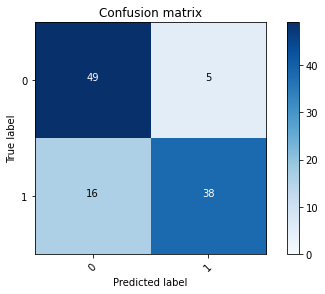

2022-07-06 18:00:45 - [Epoch Train: 24] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:00:45 - [Epoch Valid: 24] loss: 1.5077, auc: 0.8471, acc: 0.8056, time: 8.00 s


 16%|██████▍                                 | 24/150 [17:23<1:31:13, 43.44s/it]

2022-07-06 18:00:45 - EPOCH: 25
2022-07-06 18:00:47 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:00:48 - Train Step 20/219, train_loss: 0.0002
2022-07-06 18:00:50 - Train Step 30/219, train_loss: 0.0002
2022-07-06 18:00:51 - Train Step 40/219, train_loss: 0.0002
2022-07-06 18:00:53 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:00:54 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:00:56 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:00:58 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:00:59 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:01:01 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:01:02 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:01:04 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:01:05 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:01:07 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:01:09 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:01:10 - Train Step 160/219, train_loss: 0.0001
2

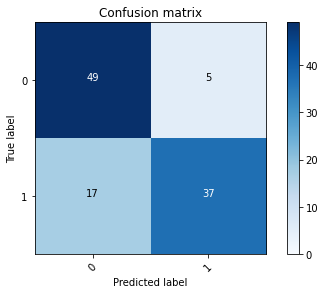

2022-07-06 18:01:28 - [Epoch Train: 25] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:01:28 - [Epoch Valid: 25] loss: 1.6766, auc: 0.8457, acc: 0.7963, time: 8.00 s


 17%|██████▋                                 | 25/150 [18:06<1:30:09, 43.28s/it]

2022-07-06 18:01:28 - EPOCH: 26
2022-07-06 18:01:30 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:01:31 - Train Step 20/219, train_loss: 0.0001
2022-07-06 18:01:33 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:01:34 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:01:36 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:01:38 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:01:39 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:01:41 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:01:42 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:01:44 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:01:46 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:01:47 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:01:49 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:01:50 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:01:52 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:01:54 - Train Step 160/219, train_loss: 0.0001
2

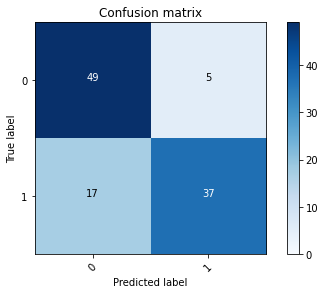

2022-07-06 18:02:12 - [Epoch Train: 26] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:02:12 - [Epoch Valid: 26] loss: 1.7251, auc: 0.8457, acc: 0.7963, time: 8.00 s


 17%|██████▉                                 | 26/150 [18:50<1:29:47, 43.45s/it]

2022-07-06 18:02:12 - EPOCH: 27
2022-07-06 18:02:13 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:02:15 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:02:17 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:02:18 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:02:20 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:02:21 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:02:23 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:02:25 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:02:26 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:02:28 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:02:29 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:02:31 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:02:33 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:02:34 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:02:36 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:02:37 - Train Step 160/219, train_loss: 0.0000
2

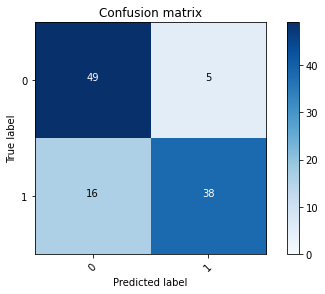

2022-07-06 18:02:56 - [Epoch Train: 27] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:02:56 - [Epoch Valid: 27] loss: 1.6047, auc: 0.8447, acc: 0.8056, time: 8.00 s


 18%|███████▏                                | 27/150 [19:34<1:29:24, 43.61s/it]

2022-07-06 18:02:56 - EPOCH: 28
2022-07-06 18:02:57 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:02:59 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:03:01 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:03:02 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:03:04 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:03:05 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:03:07 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:03:09 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:03:10 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:03:12 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:03:13 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:03:15 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:03:17 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:03:18 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:03:20 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:03:22 - Train Step 160/219, train_loss: 0.0001
2

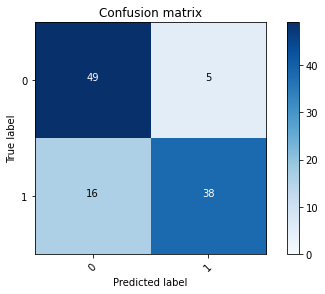

2022-07-06 18:03:40 - [Epoch Train: 28] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:03:40 - [Epoch Valid: 28] loss: 1.7448, auc: 0.8467, acc: 0.8056, time: 8.00 s


 19%|███████▍                                | 28/150 [20:18<1:29:11, 43.86s/it]

2022-07-06 18:03:40 - EPOCH: 29
2022-07-06 18:03:42 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:03:44 - Train Step 20/219, train_loss: 0.0001
2022-07-06 18:03:45 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:03:47 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:03:48 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:03:50 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:03:52 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:03:53 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:03:55 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:03:56 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:03:58 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:03:59 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:04:01 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:04:03 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:04:04 - Train Step 150/219, train_loss: 0.0002
2022-07-06 18:04:06 - Train Step 160/219, train_loss: 0.0002
2

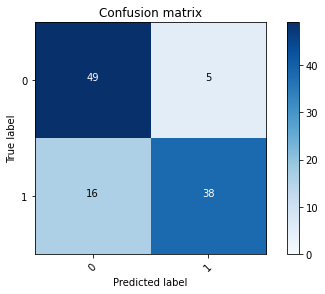

2022-07-06 18:04:25 - [Epoch Train: 29] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:04:25 - [Epoch Valid: 29] loss: 1.5998, auc: 0.8460, acc: 0.8056, time: 8.00 s


 19%|███████▋                                | 29/150 [21:03<1:28:48, 44.04s/it]

2022-07-06 18:04:25 - EPOCH: 30
2022-07-06 18:04:26 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:04:28 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:04:30 - Train Step 30/219, train_loss: 0.0002
2022-07-06 18:04:31 - Train Step 40/219, train_loss: 0.0002
2022-07-06 18:04:33 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:04:34 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:04:36 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:04:38 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:04:39 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:04:41 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:04:42 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:04:44 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:04:46 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:04:47 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:04:49 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:04:50 - Train Step 160/219, train_loss: 0.0001
2

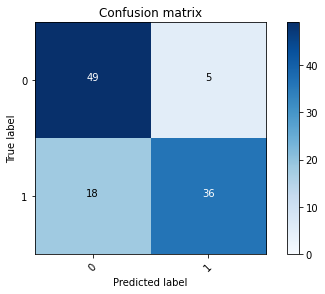

2022-07-06 18:05:09 - [Epoch Train: 30] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:05:09 - [Epoch Valid: 30] loss: 1.6824, auc: 0.8448, acc: 0.7870, time: 9.00 s


 20%|████████                                | 30/150 [21:47<1:28:25, 44.21s/it]

2022-07-06 18:05:09 - EPOCH: 31
2022-07-06 18:05:11 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:05:13 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:05:14 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:05:16 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:05:17 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:05:19 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:05:20 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:05:22 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:05:23 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:05:25 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:05:27 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:05:28 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:05:30 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:05:31 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:05:33 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:05:34 - Train Step 160/219, train_loss: 0.0001
2

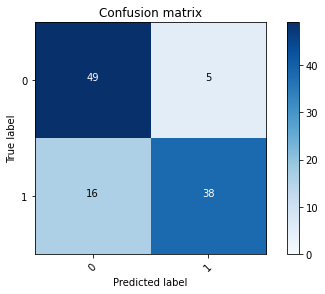

2022-07-06 18:05:52 - [Epoch Train: 31] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:05:52 - [Epoch Valid: 31] loss: 1.5948, auc: 0.8467, acc: 0.8056, time: 8.00 s


 21%|████████▎                               | 31/150 [22:31<1:27:06, 43.92s/it]

2022-07-06 18:05:52 - EPOCH: 32
2022-07-06 18:05:54 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:05:56 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:05:57 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:05:59 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:06:00 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:06:02 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:06:04 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:06:05 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:06:07 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:06:08 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:06:10 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:06:11 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:06:13 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:06:15 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:06:16 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:06:18 - Train Step 160/219, train_loss: 0.0001
2

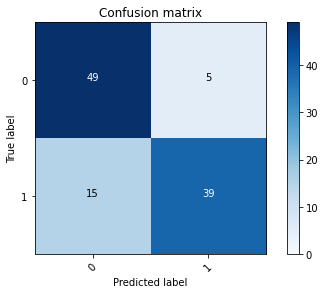

2022-07-06 18:06:36 - [Epoch Train: 32] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:06:36 - [Epoch Valid: 32] loss: 1.7299, auc: 0.8467, acc: 0.8148, time: 8.00 s


 21%|████████▌                               | 32/150 [23:14<1:26:10, 43.81s/it]

2022-07-06 18:06:36 - EPOCH: 33
2022-07-06 18:06:38 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:06:39 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:06:41 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:06:42 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:06:44 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:06:46 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:06:47 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:06:49 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:06:50 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:06:52 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:06:53 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:06:55 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:06:57 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:06:58 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:07:00 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:07:01 - Train Step 160/219, train_loss: 0.0000
2

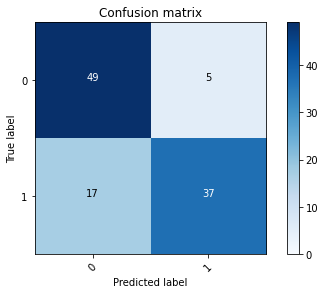

2022-07-06 18:07:19 - [Epoch Train: 33] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:07:19 - [Epoch Valid: 33] loss: 1.8866, auc: 0.8405, acc: 0.7963, time: 8.00 s


 22%|████████▊                               | 33/150 [23:57<1:25:04, 43.63s/it]

2022-07-06 18:07:19 - EPOCH: 34
2022-07-06 18:07:21 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:07:23 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:07:24 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:07:26 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:07:28 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:07:29 - Train Step 60/219, train_loss: 0.0002
2022-07-06 18:07:31 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:07:32 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:07:34 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:07:36 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:07:37 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:07:39 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:07:40 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:07:42 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:07:44 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:07:45 - Train Step 160/219, train_loss: 0.0001
2

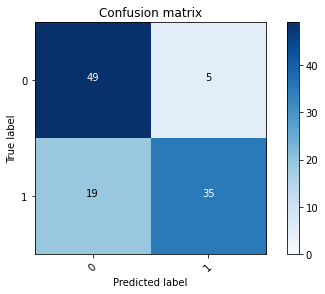

2022-07-06 18:08:03 - [Epoch Train: 34] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:08:03 - [Epoch Valid: 34] loss: 2.0297, auc: 0.8429, acc: 0.7778, time: 8.00 s


 23%|█████████                               | 34/150 [24:42<1:24:42, 43.81s/it]

2022-07-06 18:08:03 - EPOCH: 35
2022-07-06 18:08:05 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:08:07 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:08:08 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:08:10 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:08:12 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:08:13 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:08:15 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:08:16 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:08:18 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:08:19 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:08:21 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:08:23 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:08:24 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:08:26 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:08:27 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:08:29 - Train Step 160/219, train_loss: 0.0000
2

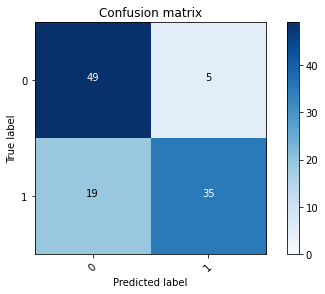

2022-07-06 18:08:47 - [Epoch Train: 35] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:08:47 - [Epoch Valid: 35] loss: 2.1149, auc: 0.8424, acc: 0.7778, time: 8.00 s


 23%|█████████▎                              | 35/150 [25:25<1:23:57, 43.80s/it]

2022-07-06 18:08:47 - EPOCH: 36
2022-07-06 18:08:49 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:08:51 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:08:52 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:08:54 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:08:55 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:08:57 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:08:59 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:09:00 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:09:02 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:09:03 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:09:05 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:09:07 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:09:08 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:09:10 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:09:11 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:09:13 - Train Step 160/219, train_loss: 0.0000
2

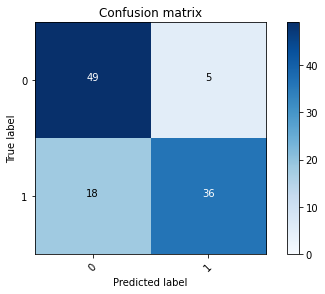

2022-07-06 18:09:32 - [Epoch Train: 36] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:09:32 - [Epoch Valid: 36] loss: 2.0644, auc: 0.8421, acc: 0.7870, time: 9.00 s


 24%|█████████▌                              | 36/150 [26:10<1:23:39, 44.03s/it]

2022-07-06 18:09:32 - EPOCH: 37
2022-07-06 18:09:34 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:09:35 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:09:37 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:09:38 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:09:40 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:09:42 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:09:43 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:09:45 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:09:46 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:09:48 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:09:50 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:09:51 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:09:53 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:09:55 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:09:56 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:09:58 - Train Step 160/219, train_loss: 0.0000
2

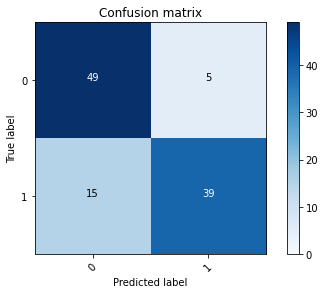

2022-07-06 18:10:16 - [Epoch Train: 37] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:10:16 - [Epoch Valid: 37] loss: 1.7165, auc: 0.8465, acc: 0.8148, time: 8.00 s


 25%|█████████▊                              | 37/150 [26:54<1:23:00, 44.08s/it]

2022-07-06 18:10:16 - EPOCH: 38
2022-07-06 18:10:18 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:10:19 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:10:21 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:10:23 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:10:24 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:10:26 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:10:27 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:10:29 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:10:31 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:10:32 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:10:34 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:10:35 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:10:37 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:10:39 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:10:40 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:10:42 - Train Step 160/219, train_loss: 0.0000
2

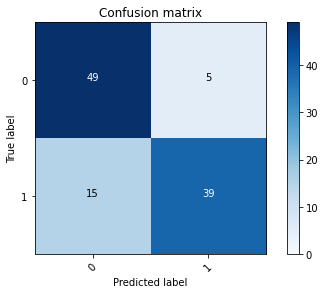

2022-07-06 18:11:00 - [Epoch Train: 38] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:11:00 - [Epoch Valid: 38] loss: 1.7993, auc: 0.8436, acc: 0.8148, time: 8.00 s


 25%|██████████▏                             | 38/150 [27:38<1:22:23, 44.14s/it]

2022-07-06 18:11:00 - EPOCH: 39
2022-07-06 18:11:02 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:11:04 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:11:05 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:11:07 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:11:08 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:11:10 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:11:11 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:11:13 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:11:14 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:11:16 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:11:18 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:11:19 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:11:21 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:11:22 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:11:24 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:11:25 - Train Step 160/219, train_loss: 0.0000
2

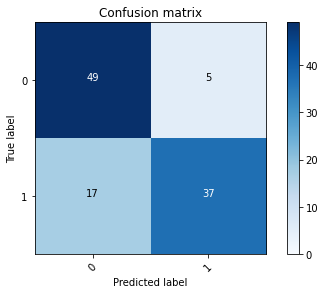

2022-07-06 18:11:43 - [Epoch Train: 39] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:11:43 - [Epoch Valid: 39] loss: 2.1123, auc: 0.8388, acc: 0.7963, time: 8.00 s


 26%|██████████▍                             | 39/150 [28:22<1:21:04, 43.83s/it]

2022-07-06 18:11:43 - EPOCH: 40
2022-07-06 18:11:45 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:11:47 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:11:48 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:11:50 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:11:51 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:11:53 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:11:54 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:11:56 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:11:58 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:11:59 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:12:01 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:12:02 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:12:04 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:12:05 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:12:07 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:12:08 - Train Step 160/219, train_loss: 0.0000
2

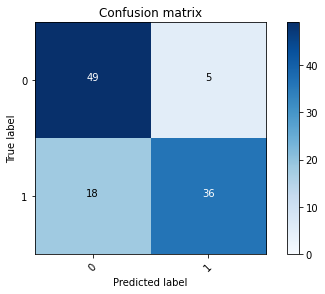

2022-07-06 18:12:27 - [Epoch Train: 40] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:12:27 - [Epoch Valid: 40] loss: 1.9053, auc: 0.8448, acc: 0.7870, time: 8.00 s


 27%|██████████▋                             | 40/150 [29:05<1:20:11, 43.74s/it]

2022-07-06 18:12:27 - EPOCH: 41
2022-07-06 18:12:29 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:12:30 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:12:32 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:12:34 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:12:35 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:12:37 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:12:38 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:12:40 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:12:42 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:12:43 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:12:45 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:12:46 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:12:48 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:12:50 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:12:51 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:12:53 - Train Step 160/219, train_loss: 0.0000
2

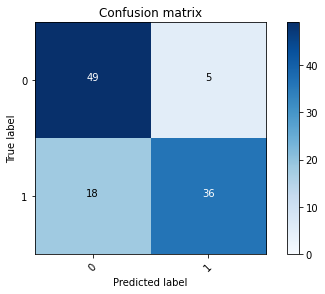

2022-07-06 18:13:12 - [Epoch Train: 41] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:13:12 - [Epoch Valid: 41] loss: 1.9894, auc: 0.8429, acc: 0.7870, time: 9.00 s


 27%|██████████▉                             | 41/150 [29:50<1:20:00, 44.04s/it]

2022-07-06 18:13:12 - EPOCH: 42
2022-07-06 18:13:13 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:13:15 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:13:17 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:13:18 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:13:20 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:13:21 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:13:23 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:13:24 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:13:26 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:13:28 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:13:29 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:13:31 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:13:32 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:13:34 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:13:35 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:13:37 - Train Step 160/219, train_loss: 0.0000
2

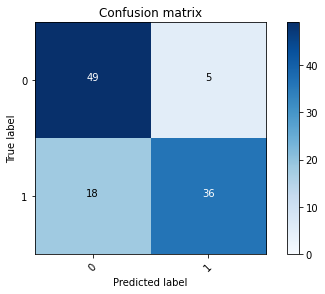

2022-07-06 18:13:55 - [Epoch Train: 42] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:13:55 - [Epoch Valid: 42] loss: 1.9823, auc: 0.8443, acc: 0.7870, time: 8.00 s


 28%|███████████▏                            | 42/150 [30:33<1:18:59, 43.88s/it]

2022-07-06 18:13:55 - EPOCH: 43
2022-07-06 18:13:57 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:13:59 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:14:00 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:14:02 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:14:03 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:14:05 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:14:07 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:14:08 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:14:10 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:14:11 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:14:13 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:14:15 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:14:16 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:14:18 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:14:19 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:14:21 - Train Step 160/219, train_loss: 0.0000
2

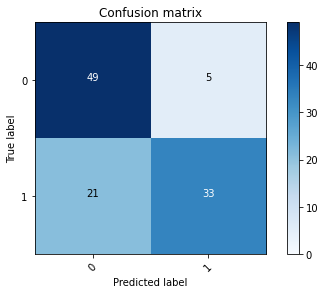

2022-07-06 18:14:40 - [Epoch Train: 43] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:14:40 - [Epoch Valid: 43] loss: 2.2250, auc: 0.8410, acc: 0.7593, time: 8.00 s


 29%|███████████▍                            | 43/150 [31:18<1:18:33, 44.05s/it]

2022-07-06 18:14:40 - EPOCH: 44
2022-07-06 18:14:41 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:14:43 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:14:44 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:14:46 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:14:47 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:14:49 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:14:51 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:14:52 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:14:54 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:14:55 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:14:57 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:14:58 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:15:00 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:15:01 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:15:03 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:15:04 - Train Step 160/219, train_loss: 0.0000
2

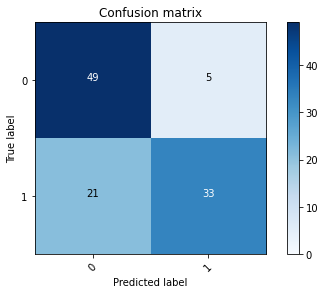

2022-07-06 18:15:23 - [Epoch Train: 44] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:15:23 - [Epoch Valid: 44] loss: 2.1727, auc: 0.8416, acc: 0.7593, time: 8.00 s


 29%|███████████▋                            | 44/150 [32:01<1:17:19, 43.77s/it]

2022-07-06 18:15:23 - EPOCH: 45
2022-07-06 18:15:25 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:15:26 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:15:28 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:15:29 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:15:31 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:15:33 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:15:34 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:15:36 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:15:37 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:15:39 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:15:41 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:15:42 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:15:44 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:15:45 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:15:47 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:15:49 - Train Step 160/219, train_loss: 0.0000
2

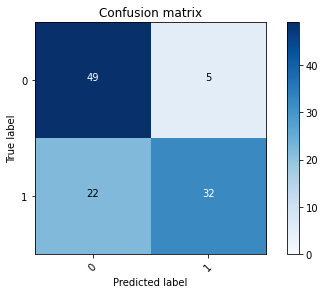

2022-07-06 18:16:07 - [Epoch Train: 45] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:16:07 - [Epoch Valid: 45] loss: 2.3026, auc: 0.8410, acc: 0.7500, time: 8.00 s


 30%|████████████                            | 45/150 [32:45<1:16:54, 43.94s/it]

2022-07-06 18:16:07 - EPOCH: 46
2022-07-06 18:16:09 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:16:10 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:16:12 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:16:13 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:16:15 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:16:17 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:16:18 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:16:20 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:16:21 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:16:23 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:16:25 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:16:26 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:16:28 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:16:29 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:16:31 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:16:33 - Train Step 160/219, train_loss: 0.0000
2

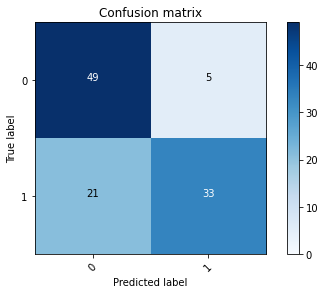

2022-07-06 18:16:51 - [Epoch Train: 46] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 35.00 s            
2022-07-06 18:16:51 - [Epoch Valid: 46] loss: 2.2778, auc: 0.8441, acc: 0.7593, time: 8.00 s


 31%|████████████▎                           | 46/150 [33:29<1:16:07, 43.92s/it]

2022-07-06 18:16:51 - EPOCH: 47
2022-07-06 18:16:53 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:16:54 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:16:56 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:16:57 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:16:59 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:17:00 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:17:02 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:17:04 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:17:05 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:17:07 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:17:08 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:17:10 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:17:11 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:17:13 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:17:15 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:17:16 - Train Step 160/219, train_loss: 0.0000
2

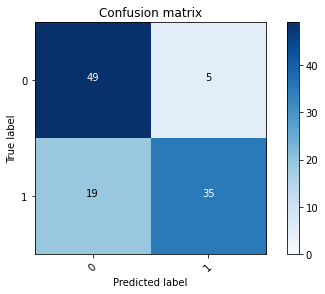

2022-07-06 18:17:34 - [Epoch Train: 47] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:17:34 - [Epoch Valid: 47] loss: 2.2024, auc: 0.8419, acc: 0.7778, time: 8.00 s


 31%|████████████▌                           | 47/150 [34:12<1:15:07, 43.76s/it]

2022-07-06 18:17:34 - EPOCH: 48
2022-07-06 18:17:36 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:17:38 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:17:39 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:17:41 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:17:43 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:17:44 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:17:46 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:17:47 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:17:49 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:17:50 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:17:52 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:17:54 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:17:55 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:17:57 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:17:58 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:18:00 - Train Step 160/219, train_loss: 0.0000
2

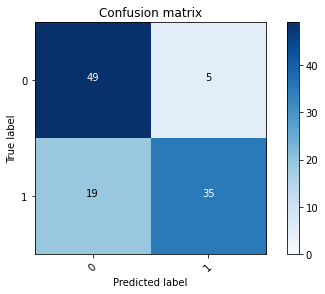

2022-07-06 18:18:18 - [Epoch Train: 48] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:18:18 - [Epoch Valid: 48] loss: 2.0766, auc: 0.8416, acc: 0.7778, time: 8.00 s


 32%|████████████▊                           | 48/150 [34:56<1:14:30, 43.83s/it]

2022-07-06 18:18:18 - EPOCH: 49
2022-07-06 18:18:20 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:18:22 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:18:23 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:18:25 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:18:26 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:18:28 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:18:29 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:18:31 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:18:33 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:18:34 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:18:36 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:18:37 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:18:39 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:18:40 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:18:42 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:18:43 - Train Step 160/219, train_loss: 0.0000
2

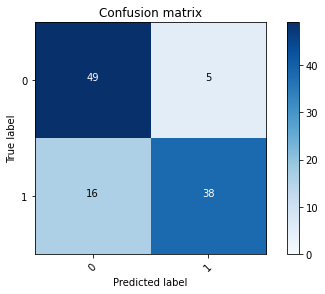

2022-07-06 18:19:01 - [Epoch Train: 49] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:19:01 - [Epoch Valid: 49] loss: 1.9304, auc: 0.8467, acc: 0.8056, time: 8.00 s


 33%|█████████████                           | 49/150 [35:40<1:13:28, 43.65s/it]

2022-07-06 18:19:01 - EPOCH: 50
2022-07-06 18:19:03 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:19:05 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:19:06 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:19:08 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:19:10 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:19:11 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:19:13 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:19:14 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:19:16 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:19:17 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:19:19 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:19:21 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:19:22 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:19:24 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:19:25 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:19:27 - Train Step 160/219, train_loss: 0.0000
2

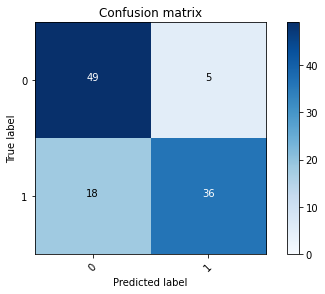

2022-07-06 18:19:45 - [Epoch Train: 50] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:19:45 - [Epoch Valid: 50] loss: 2.1925, auc: 0.8479, acc: 0.7870, time: 8.00 s


 33%|█████████████▎                          | 50/150 [36:23<1:12:35, 43.55s/it]

2022-07-06 18:19:45 - EPOCH: 51
2022-07-06 18:19:47 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:19:48 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:19:50 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:19:51 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:19:53 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:19:55 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:19:56 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:19:58 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:19:59 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:20:01 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:20:02 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:20:04 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:20:06 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:20:07 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:20:09 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:20:10 - Train Step 160/219, train_loss: 0.0000
2

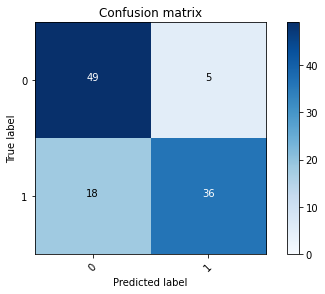

2022-07-06 18:20:29 - [Epoch Train: 51] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 34.00 s            
2022-07-06 18:20:29 - [Epoch Valid: 51] loss: 2.3913, auc: 0.8489, acc: 0.7870, time: 9.00 s


 34%|█████████████▌                          | 51/150 [37:07<1:12:04, 43.68s/it]

2022-07-06 18:20:29 - EPOCH: 52
2022-07-06 18:20:31 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:20:32 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:20:34 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:20:35 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:20:37 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:20:38 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:20:40 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:20:41 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:20:43 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:20:44 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:20:46 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:20:47 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:20:49 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:20:50 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:20:52 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:20:53 - Train Step 160/219, train_loss: 0.0000
2

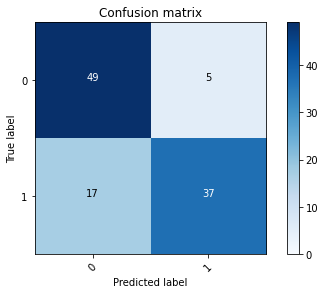

2022-07-06 18:21:10 - [Epoch Train: 52] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 33.00 s            
2022-07-06 18:21:10 - [Epoch Valid: 52] loss: 2.0418, auc: 0.8467, acc: 0.7963, time: 7.00 s


 35%|█████████████▊                          | 52/150 [37:48<1:10:08, 42.94s/it]

2022-07-06 18:21:10 - EPOCH: 53
2022-07-06 18:21:12 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:21:13 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:21:15 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:21:16 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:21:17 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:21:19 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:21:20 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:21:22 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:21:23 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:21:25 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:21:26 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:21:28 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:21:29 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:21:31 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:21:32 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:21:33 - Train Step 160/219, train_loss: 0.0000
2

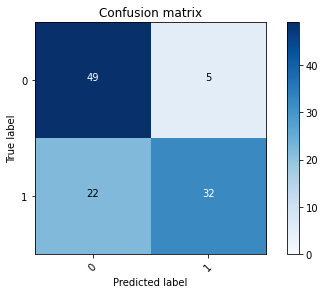

2022-07-06 18:21:50 - [Epoch Train: 53] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:21:50 - [Epoch Valid: 53] loss: 2.4110, auc: 0.8476, acc: 0.7500, time: 8.00 s


 35%|██████████████▏                         | 53/150 [38:29<1:08:09, 42.16s/it]

2022-07-06 18:21:50 - EPOCH: 54
2022-07-06 18:21:52 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:21:53 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:21:55 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:21:56 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:21:58 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:21:59 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:22:01 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:22:02 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:22:04 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:22:05 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:22:06 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:22:08 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:22:09 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:22:11 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:22:12 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:22:13 - Train Step 160/219, train_loss: 0.0000
2

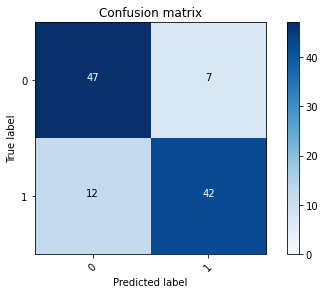

2022-07-06 18:22:30 - [Epoch Train: 54] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:22:30 - [Epoch Valid: 54] loss: 1.7521, auc: 0.8488, acc: 0.8241, time: 8.00 s
2022-07-06 18:22:30 - acc improved from 0.8241 to 0.8241. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF_Jul06_17-43-21/RSNAClassifierSingle3D-DW-SO-KLF-e54-loss1.752-acc0.824-auc0.849.pth'


 36%|██████████████▍                         | 54/150 [39:08<1:06:17, 41.44s/it]

2022-07-06 18:22:30 - EPOCH: 55
2022-07-06 18:22:32 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:22:33 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:22:35 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:22:36 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:22:37 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:22:39 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:22:40 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:22:42 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:22:43 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:22:45 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:22:46 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:22:48 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:22:49 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:22:50 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:22:52 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:22:53 - Train Step 160/219, train_loss: 0.0000
2

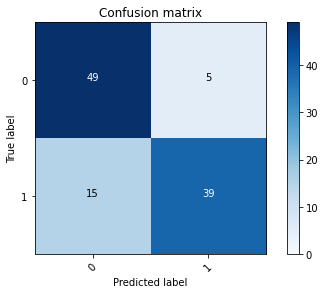

2022-07-06 18:23:10 - [Epoch Train: 55] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:23:10 - [Epoch Valid: 55] loss: 2.0363, auc: 0.8501, acc: 0.8148, time: 8.00 s


 37%|██████████████▋                         | 55/150 [39:48<1:04:43, 40.87s/it]

2022-07-06 18:23:10 - EPOCH: 56
2022-07-06 18:23:11 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:23:13 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:23:14 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:23:16 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:23:17 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:23:18 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:23:20 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:23:21 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:23:23 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:23:24 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:23:26 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:23:27 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:23:28 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:23:30 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:23:31 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:23:33 - Train Step 160/219, train_loss: 0.0000
2

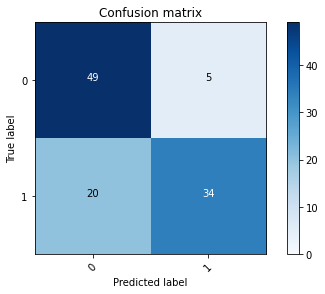

2022-07-06 18:23:49 - [Epoch Train: 56] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:23:49 - [Epoch Valid: 56] loss: 2.2797, auc: 0.8483, acc: 0.7685, time: 8.00 s


 37%|██████████████▉                         | 56/150 [40:28<1:03:29, 40.52s/it]

2022-07-06 18:23:49 - EPOCH: 57
2022-07-06 18:23:51 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:23:52 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:23:54 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:23:55 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:23:57 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:23:58 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:24:00 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:24:01 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:24:02 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:24:04 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:24:05 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:24:07 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:24:08 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:24:10 - Train Step 140/219, train_loss: 0.0158
2022-07-06 18:24:11 - Train Step 150/219, train_loss: 0.0148
2022-07-06 18:24:12 - Train Step 160/219, train_loss: 0.0576
2

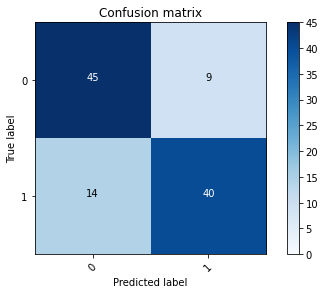

2022-07-06 18:24:29 - [Epoch Train: 57] loss: 0.1381, auc: 0.9972, acc: 0.9817, time: 31.00 s            
2022-07-06 18:24:29 - [Epoch Valid: 57] loss: 2.4099, auc: 0.7992, acc: 0.7870, time: 8.00 s


 38%|███████████████▏                        | 57/150 [41:07<1:02:28, 40.31s/it]

2022-07-06 18:24:29 - EPOCH: 58
2022-07-06 18:24:31 - Train Step 10/219, train_loss: 0.3440
2022-07-06 18:24:32 - Train Step 20/219, train_loss: 0.1764
2022-07-06 18:24:34 - Train Step 30/219, train_loss: 0.2877
2022-07-06 18:24:35 - Train Step 40/219, train_loss: 0.2392
2022-07-06 18:24:37 - Train Step 50/219, train_loss: 0.1942
2022-07-06 18:24:38 - Train Step 60/219, train_loss: 0.1622
2022-07-06 18:24:40 - Train Step 70/219, train_loss: 0.2161
2022-07-06 18:24:41 - Train Step 80/219, train_loss: 0.1891
2022-07-06 18:24:43 - Train Step 90/219, train_loss: 0.1681
2022-07-06 18:24:44 - Train Step 100/219, train_loss: 0.1513
2022-07-06 18:24:46 - Train Step 110/219, train_loss: 0.1386
2022-07-06 18:24:47 - Train Step 120/219, train_loss: 0.1272
2022-07-06 18:24:49 - Train Step 130/219, train_loss: 0.1174
2022-07-06 18:24:50 - Train Step 140/219, train_loss: 0.1158
2022-07-06 18:24:52 - Train Step 150/219, train_loss: 0.1213
2022-07-06 18:24:53 - Train Step 160/219, train_loss: 0.1369
2

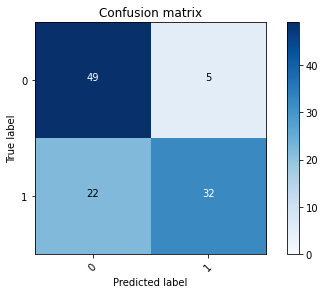

2022-07-06 18:25:11 - [Epoch Train: 58] loss: 0.1212, auc: 0.9959, acc: 0.9795, time: 32.00 s            
2022-07-06 18:25:11 - [Epoch Valid: 58] loss: 1.8961, auc: 0.7929, acc: 0.7500, time: 8.00 s


 39%|███████████████▍                        | 58/150 [41:49<1:02:19, 40.65s/it]

2022-07-06 18:25:11 - EPOCH: 59
2022-07-06 18:25:12 - Train Step 10/219, train_loss: 0.0101
2022-07-06 18:25:14 - Train Step 20/219, train_loss: 0.0092
2022-07-06 18:25:15 - Train Step 30/219, train_loss: 0.0068
2022-07-06 18:25:17 - Train Step 40/219, train_loss: 0.0056
2022-07-06 18:25:18 - Train Step 50/219, train_loss: 0.0045
2022-07-06 18:25:19 - Train Step 60/219, train_loss: 0.0812
2022-07-06 18:25:21 - Train Step 70/219, train_loss: 0.0698
2022-07-06 18:25:22 - Train Step 80/219, train_loss: 0.0611
2022-07-06 18:25:24 - Train Step 90/219, train_loss: 0.0666
2022-07-06 18:25:25 - Train Step 100/219, train_loss: 0.0600
2022-07-06 18:25:27 - Train Step 110/219, train_loss: 0.0668
2022-07-06 18:25:28 - Train Step 120/219, train_loss: 0.0612
2022-07-06 18:25:29 - Train Step 130/219, train_loss: 0.0565
2022-07-06 18:25:31 - Train Step 140/219, train_loss: 0.0543
2022-07-06 18:25:32 - Train Step 150/219, train_loss: 0.0507
2022-07-06 18:25:34 - Train Step 160/219, train_loss: 0.0476
2

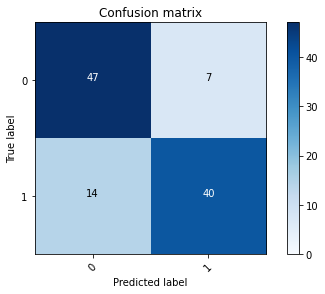

2022-07-06 18:25:50 - [Epoch Train: 59] loss: 0.0376, auc: 0.9989, acc: 0.9909, time: 31.00 s            
2022-07-06 18:25:50 - [Epoch Valid: 59] loss: 1.3642, auc: 0.8431, acc: 0.8056, time: 8.00 s


 39%|███████████████▋                        | 59/150 [42:29<1:01:14, 40.38s/it]

2022-07-06 18:25:50 - EPOCH: 60
2022-07-06 18:25:52 - Train Step 10/219, train_loss: 0.0005
2022-07-06 18:25:53 - Train Step 20/219, train_loss: 0.0002
2022-07-06 18:25:55 - Train Step 30/219, train_loss: 0.0010
2022-07-06 18:25:56 - Train Step 40/219, train_loss: 0.0012
2022-07-06 18:25:58 - Train Step 50/219, train_loss: 0.0028
2022-07-06 18:25:59 - Train Step 60/219, train_loss: 0.0024
2022-07-06 18:26:01 - Train Step 70/219, train_loss: 0.0020
2022-07-06 18:26:02 - Train Step 80/219, train_loss: 0.0042
2022-07-06 18:26:04 - Train Step 90/219, train_loss: 0.0038
2022-07-06 18:26:05 - Train Step 100/219, train_loss: 0.0035
2022-07-06 18:26:06 - Train Step 110/219, train_loss: 0.0033
2022-07-06 18:26:08 - Train Step 120/219, train_loss: 0.0041
2022-07-06 18:26:09 - Train Step 130/219, train_loss: 0.0049
2022-07-06 18:26:11 - Train Step 140/219, train_loss: 0.0045
2022-07-06 18:26:12 - Train Step 150/219, train_loss: 0.0043
2022-07-06 18:26:14 - Train Step 160/219, train_loss: 0.0040
2

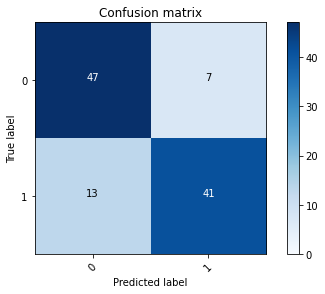

2022-07-06 18:26:31 - [Epoch Train: 60] loss: 0.0030, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:26:31 - [Epoch Valid: 60] loss: 1.4475, auc: 0.8501, acc: 0.8148, time: 8.00 s


 40%|████████████████                        | 60/150 [43:09<1:00:30, 40.34s/it]

2022-07-06 18:26:31 - EPOCH: 61
2022-07-06 18:26:32 - Train Step 10/219, train_loss: 0.0003
2022-07-06 18:26:34 - Train Step 20/219, train_loss: 0.0002
2022-07-06 18:26:35 - Train Step 30/219, train_loss: 0.0002
2022-07-06 18:26:37 - Train Step 40/219, train_loss: 0.0002
2022-07-06 18:26:38 - Train Step 50/219, train_loss: 0.0002
2022-07-06 18:26:40 - Train Step 60/219, train_loss: 0.0004
2022-07-06 18:26:41 - Train Step 70/219, train_loss: 0.0004
2022-07-06 18:26:42 - Train Step 80/219, train_loss: 0.0004
2022-07-06 18:26:44 - Train Step 90/219, train_loss: 0.0003
2022-07-06 18:26:45 - Train Step 100/219, train_loss: 0.0003
2022-07-06 18:26:47 - Train Step 110/219, train_loss: 0.0003
2022-07-06 18:26:48 - Train Step 120/219, train_loss: 0.0004
2022-07-06 18:26:50 - Train Step 130/219, train_loss: 0.0003
2022-07-06 18:26:51 - Train Step 140/219, train_loss: 0.0003
2022-07-06 18:26:52 - Train Step 150/219, train_loss: 0.0003
2022-07-06 18:26:54 - Train Step 160/219, train_loss: 0.0003
2

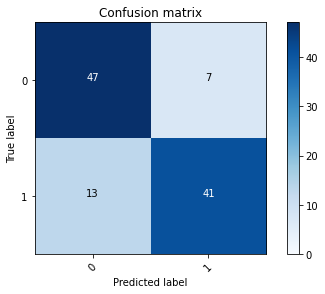

2022-07-06 18:27:10 - [Epoch Train: 61] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:27:10 - [Epoch Valid: 61] loss: 1.4039, auc: 0.8433, acc: 0.8148, time: 8.00 s


 41%|█████████████████                         | 61/150 [43:48<59:31, 40.13s/it]

2022-07-06 18:27:10 - EPOCH: 62
2022-07-06 18:27:12 - Train Step 10/219, train_loss: 0.0004
2022-07-06 18:27:13 - Train Step 20/219, train_loss: 0.0003
2022-07-06 18:27:15 - Train Step 30/219, train_loss: 0.0002
2022-07-06 18:27:16 - Train Step 40/219, train_loss: 0.0002
2022-07-06 18:27:17 - Train Step 50/219, train_loss: 0.0002
2022-07-06 18:27:19 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:27:20 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:27:22 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:27:23 - Train Step 90/219, train_loss: 0.0002
2022-07-06 18:27:24 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:27:26 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:27:27 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:27:29 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:27:30 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:27:31 - Train Step 150/219, train_loss: 0.0004
2022-07-06 18:27:33 - Train Step 160/219, train_loss: 0.0004
2

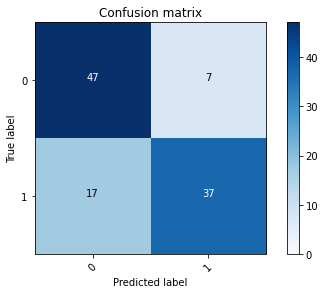

2022-07-06 18:27:49 - [Epoch Train: 62] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:27:49 - [Epoch Valid: 62] loss: 1.7857, auc: 0.8337, acc: 0.7778, time: 7.00 s


 41%|█████████████████▎                        | 62/150 [44:27<58:16, 39.73s/it]

2022-07-06 18:27:49 - EPOCH: 63
2022-07-06 18:27:51 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:27:52 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:27:54 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:27:55 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:27:57 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:27:58 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:28:00 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:28:01 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:28:03 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:28:04 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:28:06 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:28:07 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:28:09 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:28:10 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:28:12 - Train Step 150/219, train_loss: 0.0002
2022-07-06 18:28:13 - Train Step 160/219, train_loss: 0.0002
2

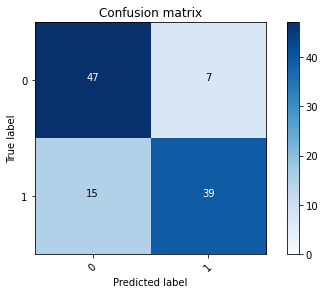

2022-07-06 18:28:30 - [Epoch Train: 63] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:28:30 - [Epoch Valid: 63] loss: 1.5706, auc: 0.8455, acc: 0.7963, time: 8.00 s


 42%|█████████████████▋                        | 63/150 [45:08<58:07, 40.09s/it]

2022-07-06 18:28:30 - EPOCH: 64
2022-07-06 18:28:32 - Train Step 10/219, train_loss: 0.0002
2022-07-06 18:28:33 - Train Step 20/219, train_loss: 0.0001
2022-07-06 18:28:35 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:28:36 - Train Step 40/219, train_loss: 0.0002
2022-07-06 18:28:38 - Train Step 50/219, train_loss: 0.0002
2022-07-06 18:28:39 - Train Step 60/219, train_loss: 0.0002
2022-07-06 18:28:41 - Train Step 70/219, train_loss: 0.0002
2022-07-06 18:28:42 - Train Step 80/219, train_loss: 0.0002
2022-07-06 18:28:44 - Train Step 90/219, train_loss: 0.0002
2022-07-06 18:28:45 - Train Step 100/219, train_loss: 0.0002
2022-07-06 18:28:46 - Train Step 110/219, train_loss: 0.0002
2022-07-06 18:28:48 - Train Step 120/219, train_loss: 0.0002
2022-07-06 18:28:49 - Train Step 130/219, train_loss: 0.0002
2022-07-06 18:28:51 - Train Step 140/219, train_loss: 0.0002
2022-07-06 18:28:52 - Train Step 150/219, train_loss: 0.0002
2022-07-06 18:28:54 - Train Step 160/219, train_loss: 0.0002
2

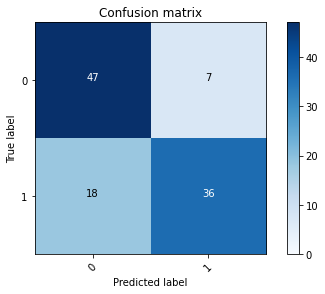

2022-07-06 18:29:11 - [Epoch Train: 64] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:29:11 - [Epoch Valid: 64] loss: 1.6830, auc: 0.8397, acc: 0.7685, time: 8.00 s


 43%|█████████████████▉                        | 64/150 [45:49<57:52, 40.38s/it]

2022-07-06 18:29:11 - EPOCH: 65
2022-07-06 18:29:13 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:29:14 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:29:16 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:29:17 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:29:19 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:29:20 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:29:22 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:29:23 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:29:25 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:29:26 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:29:28 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:29:29 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:29:31 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:29:32 - Train Step 140/219, train_loss: 0.0002
2022-07-06 18:29:34 - Train Step 150/219, train_loss: 0.0002
2022-07-06 18:29:35 - Train Step 160/219, train_loss: 0.0002
2

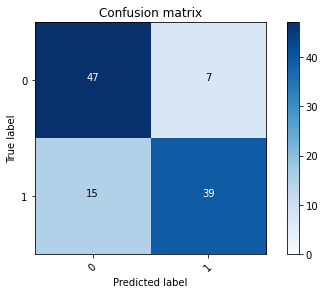

2022-07-06 18:29:52 - [Epoch Train: 65] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:29:52 - [Epoch Valid: 65] loss: 1.7101, auc: 0.8381, acc: 0.7963, time: 8.00 s


 43%|██████████████████▏                       | 65/150 [46:30<57:34, 40.64s/it]

2022-07-06 18:29:52 - EPOCH: 66
2022-07-06 18:29:54 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:29:55 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:29:57 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:29:58 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:30:00 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:30:01 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:30:03 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:30:04 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:30:06 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:30:07 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:30:09 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:30:10 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:30:12 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:30:13 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:30:15 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:30:16 - Train Step 160/219, train_loss: 0.0001
2

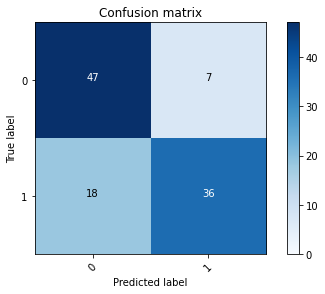

2022-07-06 18:30:33 - [Epoch Train: 66] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:30:33 - [Epoch Valid: 66] loss: 1.6681, auc: 0.8428, acc: 0.7685, time: 8.00 s


 44%|██████████████████▍                       | 66/150 [47:11<57:00, 40.72s/it]

2022-07-06 18:30:33 - EPOCH: 67
2022-07-06 18:30:35 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:30:36 - Train Step 20/219, train_loss: 0.0001
2022-07-06 18:30:38 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:30:39 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:30:41 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:30:42 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:30:44 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:30:45 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:30:47 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:30:48 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:30:50 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:30:51 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:30:53 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:30:54 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:30:55 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:30:57 - Train Step 160/219, train_loss: 0.0001
2

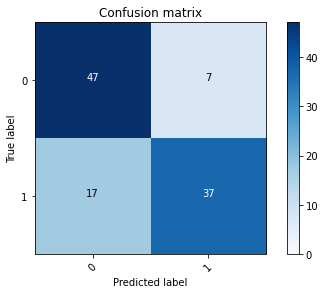

2022-07-06 18:31:14 - [Epoch Train: 67] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:31:14 - [Epoch Valid: 67] loss: 1.9494, auc: 0.8361, acc: 0.7778, time: 8.00 s


 45%|██████████████████▊                       | 67/150 [47:52<56:16, 40.68s/it]

2022-07-06 18:31:14 - EPOCH: 68
2022-07-06 18:31:16 - Train Step 10/219, train_loss: 0.0003
2022-07-06 18:31:17 - Train Step 20/219, train_loss: 0.0002
2022-07-06 18:31:18 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:31:20 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:31:21 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:31:23 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:31:24 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:31:26 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:31:27 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:31:29 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:31:30 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:31:32 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:31:33 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:31:35 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:31:36 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:31:38 - Train Step 160/219, train_loss: 0.0001
2

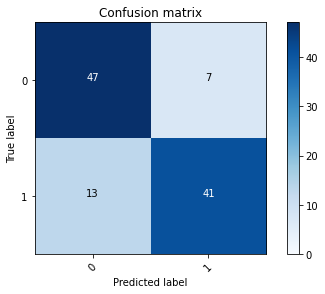

2022-07-06 18:31:54 - [Epoch Train: 68] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:31:54 - [Epoch Valid: 68] loss: 1.6441, auc: 0.8438, acc: 0.8148, time: 7.00 s


 45%|███████████████████                       | 68/150 [48:32<55:31, 40.63s/it]

2022-07-06 18:31:54 - EPOCH: 69
2022-07-06 18:31:56 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:31:57 - Train Step 20/219, train_loss: 0.0001
2022-07-06 18:31:59 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:32:00 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:32:02 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:32:03 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:32:05 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:32:06 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:32:08 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:32:09 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:32:10 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:32:12 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:32:13 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:32:15 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:32:16 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:32:18 - Train Step 160/219, train_loss: 0.0001
2

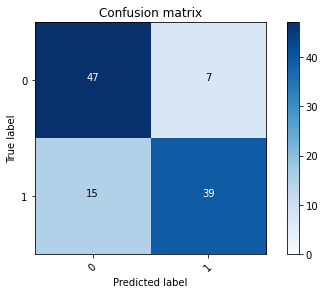

2022-07-06 18:32:35 - [Epoch Train: 69] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:32:35 - [Epoch Valid: 69] loss: 1.7561, auc: 0.8347, acc: 0.7963, time: 8.00 s


 46%|███████████████████▎                      | 69/150 [49:13<54:46, 40.57s/it]

2022-07-06 18:32:35 - EPOCH: 70
2022-07-06 18:32:36 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:32:38 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:32:39 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:32:41 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:32:42 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:32:44 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:32:45 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:32:46 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:32:48 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:32:49 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:32:51 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:32:52 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:32:54 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:32:55 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:32:57 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:32:58 - Train Step 160/219, train_loss: 0.0001
2

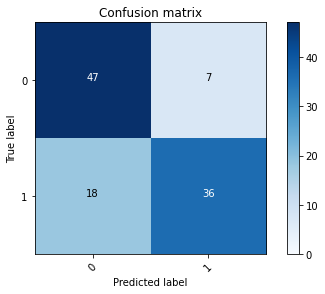

2022-07-06 18:33:14 - [Epoch Train: 70] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:33:14 - [Epoch Valid: 70] loss: 1.9791, auc: 0.8410, acc: 0.7685, time: 7.00 s


 47%|███████████████████▌                      | 70/150 [49:53<53:46, 40.33s/it]

2022-07-06 18:33:14 - EPOCH: 71
2022-07-06 18:33:16 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:33:18 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:33:19 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:33:21 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:33:22 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:33:24 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:33:25 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:33:27 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:33:28 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:33:29 - Train Step 100/219, train_loss: 0.0005
2022-07-06 18:33:31 - Train Step 110/219, train_loss: 0.0005
2022-07-06 18:33:32 - Train Step 120/219, train_loss: 0.0005
2022-07-06 18:33:34 - Train Step 130/219, train_loss: 0.0004
2022-07-06 18:33:35 - Train Step 140/219, train_loss: 0.0004
2022-07-06 18:33:37 - Train Step 150/219, train_loss: 0.0004
2022-07-06 18:33:38 - Train Step 160/219, train_loss: 0.0004
2

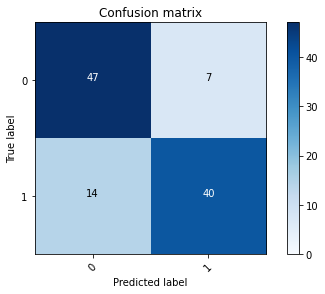

2022-07-06 18:33:55 - [Epoch Train: 71] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:33:55 - [Epoch Valid: 71] loss: 1.8662, auc: 0.8426, acc: 0.8056, time: 8.00 s


 47%|███████████████████▉                      | 71/150 [50:34<53:21, 40.53s/it]

2022-07-06 18:33:55 - EPOCH: 72
2022-07-06 18:33:57 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:33:59 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:34:00 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:34:02 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:34:03 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:34:05 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:34:06 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:34:08 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:34:09 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:34:11 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:34:12 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:34:14 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:34:15 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:34:16 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:34:18 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:34:19 - Train Step 160/219, train_loss: 0.0001
2

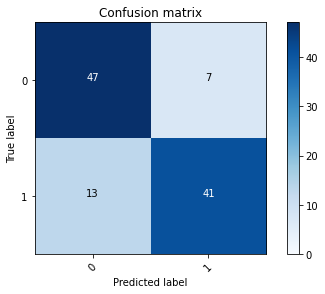

2022-07-06 18:34:36 - [Epoch Train: 72] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:34:36 - [Epoch Valid: 72] loss: 1.6885, auc: 0.8484, acc: 0.8148, time: 7.00 s


 48%|████████████████████▏                     | 72/150 [51:14<52:43, 40.56s/it]

2022-07-06 18:34:36 - EPOCH: 73
2022-07-06 18:34:38 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:34:39 - Train Step 20/219, train_loss: 0.0001
2022-07-06 18:34:41 - Train Step 30/219, train_loss: 0.0001
2022-07-06 18:34:42 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:34:44 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:34:45 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:34:47 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:34:48 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:34:50 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:34:51 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:34:53 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:34:54 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:34:56 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:34:57 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:34:59 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:35:00 - Train Step 160/219, train_loss: 0.0000
2

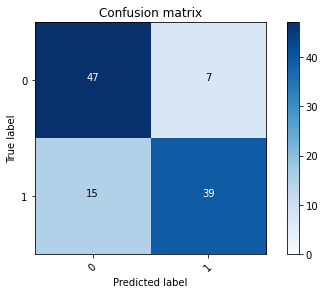

2022-07-06 18:35:17 - [Epoch Train: 73] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:35:17 - [Epoch Valid: 73] loss: 1.8226, auc: 0.8441, acc: 0.7963, time: 8.00 s


 49%|████████████████████▍                     | 73/150 [51:55<52:13, 40.69s/it]

2022-07-06 18:35:17 - EPOCH: 74
2022-07-06 18:35:19 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:35:20 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:35:22 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:35:23 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:35:25 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:35:26 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:35:28 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:35:29 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:35:30 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:35:32 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:35:33 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:35:35 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:35:36 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:35:37 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:35:39 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:35:40 - Train Step 160/219, train_loss: 0.0001
2

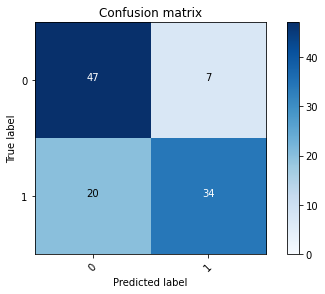

2022-07-06 18:35:57 - [Epoch Train: 74] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:35:57 - [Epoch Valid: 74] loss: 2.1233, auc: 0.8359, acc: 0.7500, time: 8.00 s


 49%|████████████████████▋                     | 74/150 [52:35<51:15, 40.47s/it]

2022-07-06 18:35:57 - EPOCH: 75
2022-07-06 18:35:59 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:36:00 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:36:02 - Train Step 30/219, train_loss: 0.0011
2022-07-06 18:36:03 - Train Step 40/219, train_loss: 0.0009
2022-07-06 18:36:04 - Train Step 50/219, train_loss: 0.0007
2022-07-06 18:36:06 - Train Step 60/219, train_loss: 0.0006
2022-07-06 18:36:07 - Train Step 70/219, train_loss: 0.0005
2022-07-06 18:36:09 - Train Step 80/219, train_loss: 0.0004
2022-07-06 18:36:10 - Train Step 90/219, train_loss: 0.0004
2022-07-06 18:36:11 - Train Step 100/219, train_loss: 0.0004
2022-07-06 18:36:13 - Train Step 110/219, train_loss: 0.0003
2022-07-06 18:36:14 - Train Step 120/219, train_loss: 0.0003
2022-07-06 18:36:16 - Train Step 130/219, train_loss: 0.0003
2022-07-06 18:36:17 - Train Step 140/219, train_loss: 0.0003
2022-07-06 18:36:18 - Train Step 150/219, train_loss: 0.0003
2022-07-06 18:36:20 - Train Step 160/219, train_loss: 0.0002
2

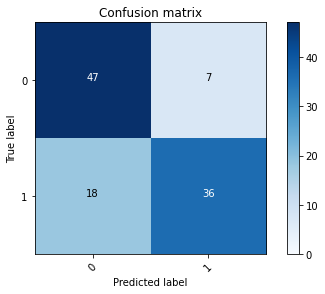

2022-07-06 18:36:37 - [Epoch Train: 75] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:36:37 - [Epoch Valid: 75] loss: 2.0941, auc: 0.8392, acc: 0.7685, time: 8.00 s


 50%|█████████████████████                     | 75/150 [53:15<50:17, 40.23s/it]

2022-07-06 18:36:37 - EPOCH: 76
2022-07-06 18:36:38 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:36:40 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:36:41 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:36:43 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:36:44 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:36:46 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:36:47 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:36:48 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:36:50 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:36:51 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:36:53 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:36:54 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:36:56 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:36:57 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:36:58 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:37:00 - Train Step 160/219, train_loss: 0.0000
2

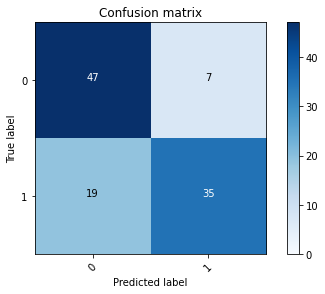

2022-07-06 18:37:16 - [Epoch Train: 76] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:37:16 - [Epoch Valid: 76] loss: 2.0973, auc: 0.8385, acc: 0.7593, time: 8.00 s


 51%|█████████████████████▎                    | 76/150 [53:55<49:25, 40.08s/it]

2022-07-06 18:37:16 - EPOCH: 77
2022-07-06 18:37:18 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:37:20 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:37:21 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:37:22 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:37:24 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:37:25 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:37:27 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:37:28 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:37:30 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:37:31 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:37:33 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:37:34 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:37:35 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:37:37 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:37:38 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:37:40 - Train Step 160/219, train_loss: 0.0000
2

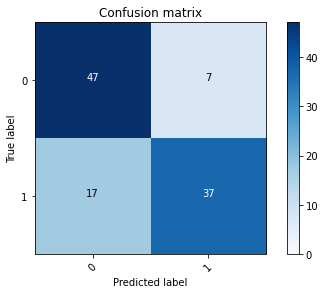

2022-07-06 18:37:56 - [Epoch Train: 77] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:37:56 - [Epoch Valid: 77] loss: 2.0686, auc: 0.8340, acc: 0.7778, time: 8.00 s


 51%|█████████████████████▌                    | 77/150 [54:35<48:42, 40.03s/it]

2022-07-06 18:37:56 - EPOCH: 78
2022-07-06 18:37:58 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:37:59 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:38:01 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:38:02 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:38:04 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:38:05 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:38:06 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:38:08 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:38:09 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:38:11 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:38:12 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:38:14 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:38:15 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:38:17 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:38:18 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:38:19 - Train Step 160/219, train_loss: 0.0000
2

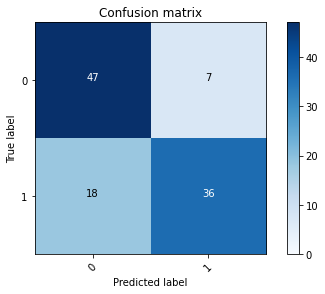

2022-07-06 18:38:36 - [Epoch Train: 78] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:38:36 - [Epoch Valid: 78] loss: 1.8451, auc: 0.8326, acc: 0.7685, time: 8.00 s


 52%|█████████████████████▊                    | 78/150 [55:14<47:54, 39.93s/it]

2022-07-06 18:38:36 - EPOCH: 79
2022-07-06 18:38:38 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:38:39 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:38:41 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:38:42 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:38:43 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:38:45 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:38:46 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:38:48 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:38:49 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:38:51 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:38:52 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:38:54 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:38:55 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:38:56 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:38:58 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:38:59 - Train Step 160/219, train_loss: 0.0000
2

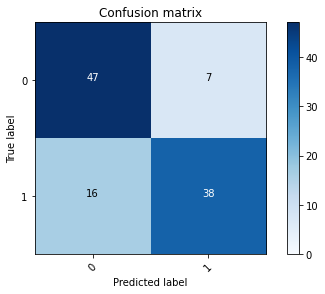

2022-07-06 18:39:16 - [Epoch Train: 79] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:39:16 - [Epoch Valid: 79] loss: 1.9813, auc: 0.8398, acc: 0.7870, time: 8.00 s


 53%|██████████████████████                    | 79/150 [55:54<47:14, 39.92s/it]

2022-07-06 18:39:16 - EPOCH: 80
2022-07-06 18:39:18 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:39:19 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:39:21 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:39:22 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:39:23 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:39:25 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:39:26 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:39:28 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:39:29 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:39:31 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:39:32 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:39:34 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:39:35 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:39:36 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:39:38 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:39:39 - Train Step 160/219, train_loss: 0.0000
2

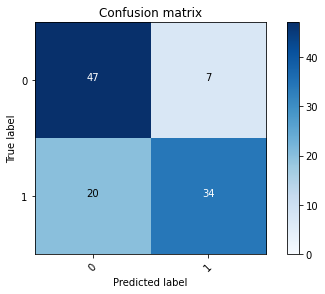

2022-07-06 18:39:56 - [Epoch Train: 80] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:39:56 - [Epoch Valid: 80] loss: 2.2244, auc: 0.8398, acc: 0.7500, time: 7.00 s


 53%|██████████████████████▍                   | 80/150 [56:34<46:31, 39.87s/it]

2022-07-06 18:39:56 - EPOCH: 81
2022-07-06 18:39:57 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:39:59 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:40:00 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:40:02 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:40:03 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:40:05 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:40:06 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:40:08 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:40:09 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:40:10 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:40:12 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:40:13 - Train Step 120/219, train_loss: 0.0001
2022-07-06 18:40:15 - Train Step 130/219, train_loss: 0.0001
2022-07-06 18:40:16 - Train Step 140/219, train_loss: 0.0001
2022-07-06 18:40:18 - Train Step 150/219, train_loss: 0.0001
2022-07-06 18:40:19 - Train Step 160/219, train_loss: 0.0000
2

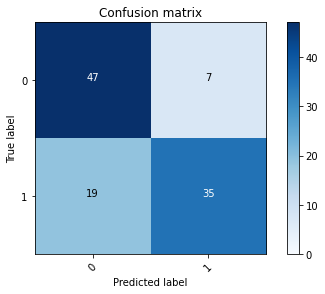

2022-07-06 18:40:36 - [Epoch Train: 81] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:40:36 - [Epoch Valid: 81] loss: 2.2525, auc: 0.8385, acc: 0.7593, time: 8.00 s


 54%|██████████████████████▋                   | 81/150 [57:15<46:05, 40.09s/it]

2022-07-06 18:40:36 - EPOCH: 82
2022-07-06 18:40:38 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:40:39 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:40:41 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:40:42 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:40:44 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:40:45 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:40:47 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:40:48 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:40:49 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:40:51 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:40:52 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:40:54 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:40:55 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:40:57 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:40:58 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:41:00 - Train Step 160/219, train_loss: 0.0000
2

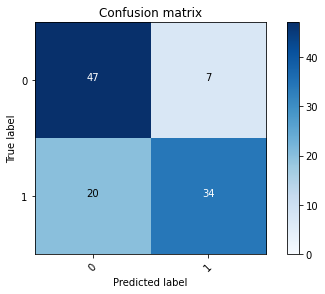

2022-07-06 18:41:16 - [Epoch Train: 82] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:41:16 - [Epoch Valid: 82] loss: 2.3004, auc: 0.8392, acc: 0.7500, time: 8.00 s


 55%|██████████████████████▉                   | 82/150 [57:55<45:24, 40.06s/it]

2022-07-06 18:41:16 - EPOCH: 83
2022-07-06 18:41:18 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:41:19 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:41:21 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:41:22 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:41:24 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:41:25 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:41:27 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:41:28 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:41:30 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:41:31 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:41:33 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:41:34 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:41:36 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:41:37 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:41:39 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:41:40 - Train Step 160/219, train_loss: 0.0000
2

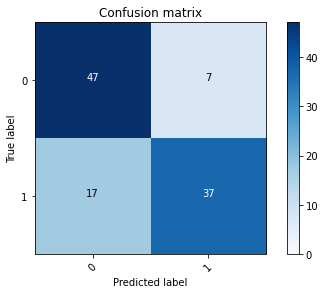

2022-07-06 18:41:57 - [Epoch Train: 83] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:41:57 - [Epoch Valid: 83] loss: 1.9084, auc: 0.8417, acc: 0.7778, time: 8.00 s


 55%|███████████████████████▏                  | 83/150 [58:36<45:02, 40.34s/it]

2022-07-06 18:41:57 - EPOCH: 84
2022-07-06 18:41:59 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:42:00 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:42:02 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:42:03 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:42:05 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:42:06 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:42:08 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:42:09 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:42:11 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:42:12 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:42:14 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:42:15 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:42:17 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:42:18 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:42:20 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:42:21 - Train Step 160/219, train_loss: 0.0000
2

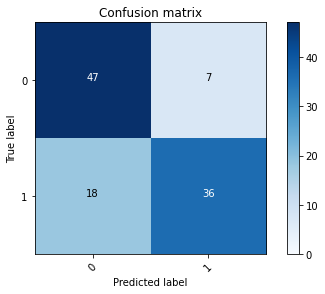

2022-07-06 18:42:38 - [Epoch Train: 84] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:42:38 - [Epoch Valid: 84] loss: 1.9340, auc: 0.8421, acc: 0.7685, time: 8.00 s


 56%|███████████████████████▌                  | 84/150 [59:17<44:35, 40.54s/it]

2022-07-06 18:42:38 - EPOCH: 85
2022-07-06 18:42:40 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:42:41 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:42:43 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:42:44 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:42:46 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:42:47 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:42:49 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:42:50 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:42:51 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:42:53 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:42:54 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:42:56 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:42:57 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:42:59 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:43:00 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:43:02 - Train Step 160/219, train_loss: 0.0000
2

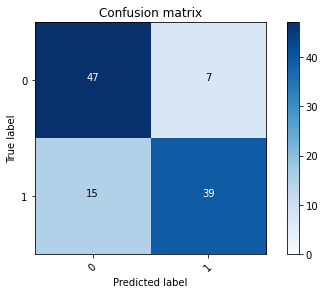

2022-07-06 18:43:19 - [Epoch Train: 85] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:43:19 - [Epoch Valid: 85] loss: 2.0260, auc: 0.8453, acc: 0.7963, time: 8.00 s


 57%|███████████████████████▊                  | 85/150 [59:57<43:49, 40.45s/it]

2022-07-06 18:43:19 - EPOCH: 86
2022-07-06 18:43:20 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:43:22 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:43:23 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:43:25 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:43:26 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:43:27 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:43:29 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:43:30 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:43:32 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:43:33 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:43:35 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:43:36 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:43:38 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:43:39 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:43:40 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:43:42 - Train Step 160/219, train_loss: 0.0000
2

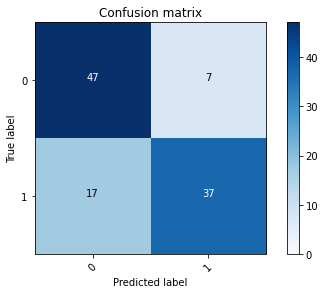

2022-07-06 18:43:59 - [Epoch Train: 86] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:43:59 - [Epoch Valid: 86] loss: 2.0465, auc: 0.8409, acc: 0.7778, time: 8.00 s


 57%|██████████████████████▉                 | 86/150 [1:00:37<43:01, 40.34s/it]

2022-07-06 18:43:59 - EPOCH: 87
2022-07-06 18:44:00 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:44:02 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:44:03 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:44:05 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:44:06 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:44:08 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:44:09 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:44:10 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:44:12 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:44:13 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:44:15 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:44:16 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:44:18 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:44:19 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:44:20 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:44:22 - Train Step 160/219, train_loss: 0.0000
2

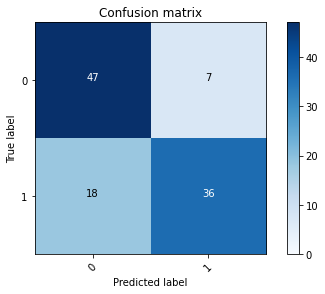

2022-07-06 18:44:38 - [Epoch Train: 87] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:44:38 - [Epoch Valid: 87] loss: 2.1881, auc: 0.8364, acc: 0.7685, time: 8.00 s


 58%|███████████████████████▏                | 87/150 [1:01:17<42:12, 40.19s/it]

2022-07-06 18:44:38 - EPOCH: 88
2022-07-06 18:44:40 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:44:42 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:44:43 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:44:44 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:44:46 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:44:47 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:44:49 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:44:50 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:44:52 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:44:53 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:44:54 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:44:56 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:44:57 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:44:59 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:45:00 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:45:02 - Train Step 160/219, train_loss: 0.0000
2

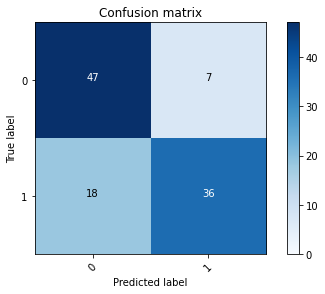

2022-07-06 18:45:18 - [Epoch Train: 88] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:45:18 - [Epoch Valid: 88] loss: 2.1755, auc: 0.8460, acc: 0.7685, time: 8.00 s


 59%|███████████████████████▍                | 88/150 [1:01:56<41:24, 40.07s/it]

2022-07-06 18:45:18 - EPOCH: 89
2022-07-06 18:45:20 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:45:21 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:45:23 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:45:24 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:45:26 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:45:27 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:45:29 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:45:30 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:45:32 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:45:33 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:45:35 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:45:36 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:45:38 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:45:39 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:45:41 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:45:42 - Train Step 160/219, train_loss: 0.0000
2

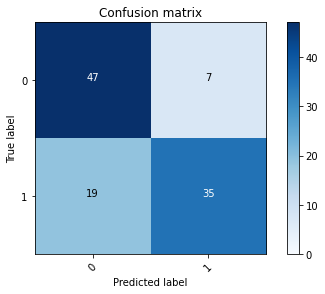

2022-07-06 18:45:59 - [Epoch Train: 89] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:45:59 - [Epoch Valid: 89] loss: 2.3216, auc: 0.8395, acc: 0.7593, time: 8.00 s


 59%|███████████████████████▋                | 89/150 [1:02:37<41:00, 40.33s/it]

2022-07-06 18:45:59 - EPOCH: 90
2022-07-06 18:46:01 - Train Step 10/219, train_loss: 0.0001
2022-07-06 18:46:02 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:46:04 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:46:05 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:46:07 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:46:08 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:46:10 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:46:11 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:46:12 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:46:14 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:46:15 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:46:17 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:46:18 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:46:20 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:46:21 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:46:23 - Train Step 160/219, train_loss: 0.0000
2

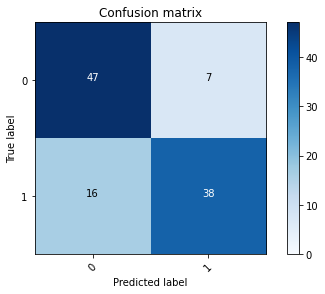

2022-07-06 18:46:40 - [Epoch Train: 90] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:46:40 - [Epoch Valid: 90] loss: 2.2015, auc: 0.8450, acc: 0.7870, time: 8.00 s


 60%|████████████████████████                | 90/150 [1:03:18<40:19, 40.33s/it]

2022-07-06 18:46:40 - EPOCH: 91
2022-07-06 18:46:41 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:46:43 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:46:44 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:46:46 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:46:47 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:46:49 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:46:50 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:46:52 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:46:53 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:46:55 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:46:56 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:46:58 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:46:59 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:47:01 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:47:02 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:47:04 - Train Step 160/219, train_loss: 0.0000
2

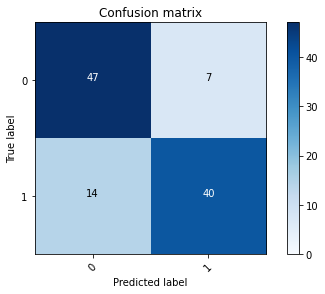

2022-07-06 18:47:21 - [Epoch Train: 91] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:47:21 - [Epoch Valid: 91] loss: 1.9058, auc: 0.8455, acc: 0.8056, time: 8.00 s


 61%|████████████████████████▎               | 91/150 [1:03:59<39:54, 40.59s/it]

2022-07-06 18:47:21 - EPOCH: 92
2022-07-06 18:47:22 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:47:24 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:47:25 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:47:27 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:47:28 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:47:30 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:47:31 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:47:33 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:47:34 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:47:36 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:47:37 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:47:39 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:47:40 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:47:42 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:47:43 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:47:45 - Train Step 160/219, train_loss: 0.0000
2

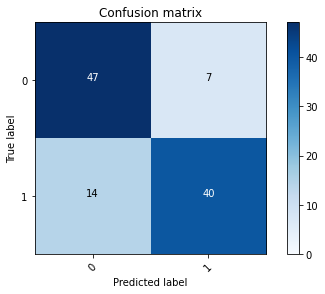

2022-07-06 18:48:02 - [Epoch Train: 92] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:48:02 - [Epoch Valid: 92] loss: 2.1520, auc: 0.8434, acc: 0.8056, time: 7.00 s


 61%|████████████████████████▌               | 92/150 [1:04:40<39:18, 40.66s/it]

2022-07-06 18:48:02 - EPOCH: 93
2022-07-06 18:48:03 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:48:05 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:48:06 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:48:07 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:48:09 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:48:10 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:48:12 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:48:13 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:48:14 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:48:16 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:48:17 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:48:19 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:48:20 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:48:22 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:48:23 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:48:24 - Train Step 160/219, train_loss: 0.0000
2

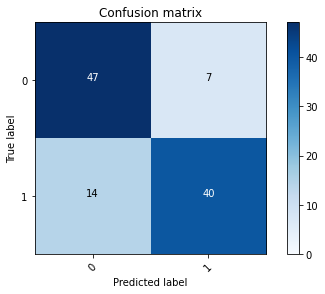

2022-07-06 18:48:41 - [Epoch Train: 93] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:48:41 - [Epoch Valid: 93] loss: 2.1391, auc: 0.8464, acc: 0.8056, time: 8.00 s


 62%|████████████████████████▊               | 93/150 [1:05:20<38:23, 40.42s/it]

2022-07-06 18:48:41 - EPOCH: 94
2022-07-06 18:48:43 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:48:45 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:48:46 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:48:48 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:48:49 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:48:51 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:48:52 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:48:54 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:48:55 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:48:56 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:48:58 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:48:59 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:49:01 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:49:02 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:49:04 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:49:05 - Train Step 160/219, train_loss: 0.0000
2

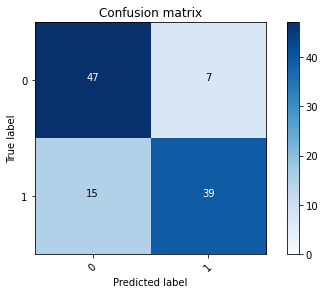

2022-07-06 18:49:22 - [Epoch Train: 94] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:49:22 - [Epoch Valid: 94] loss: 2.2428, auc: 0.8459, acc: 0.7963, time: 8.00 s


 63%|█████████████████████████               | 94/150 [1:06:01<37:52, 40.58s/it]

2022-07-06 18:49:22 - EPOCH: 95
2022-07-06 18:49:24 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:49:26 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:49:27 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:49:28 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:49:30 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:49:31 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:49:33 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:49:34 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:49:36 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:49:37 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:49:39 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:49:40 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:49:41 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:49:43 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:49:44 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:49:46 - Train Step 160/219, train_loss: 0.0000
2

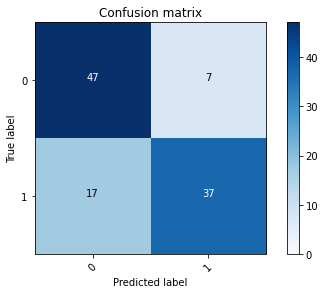

2022-07-06 18:50:02 - [Epoch Train: 95] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:50:02 - [Epoch Valid: 95] loss: 2.3570, auc: 0.8388, acc: 0.7778, time: 7.00 s


 63%|█████████████████████████▎              | 95/150 [1:06:40<36:56, 40.31s/it]

2022-07-06 18:50:02 - EPOCH: 96
2022-07-06 18:50:04 - Train Step 10/219, train_loss: 0.0005
2022-07-06 18:50:05 - Train Step 20/219, train_loss: 0.0003
2022-07-06 18:50:07 - Train Step 30/219, train_loss: 0.0002
2022-07-06 18:50:08 - Train Step 40/219, train_loss: 0.0001
2022-07-06 18:50:10 - Train Step 50/219, train_loss: 0.0001
2022-07-06 18:50:11 - Train Step 60/219, train_loss: 0.0001
2022-07-06 18:50:13 - Train Step 70/219, train_loss: 0.0001
2022-07-06 18:50:14 - Train Step 80/219, train_loss: 0.0001
2022-07-06 18:50:16 - Train Step 90/219, train_loss: 0.0001
2022-07-06 18:50:17 - Train Step 100/219, train_loss: 0.0001
2022-07-06 18:50:18 - Train Step 110/219, train_loss: 0.0001
2022-07-06 18:50:20 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:50:21 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:50:23 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:50:25 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:50:26 - Train Step 160/219, train_loss: 0.0000
2

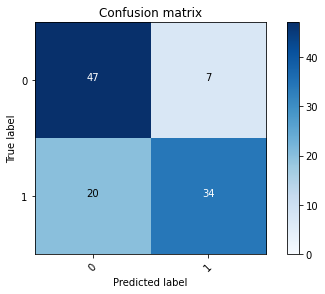

2022-07-06 18:50:43 - [Epoch Train: 96] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:50:43 - [Epoch Valid: 96] loss: 2.4879, auc: 0.8443, acc: 0.7500, time: 7.00 s


 64%|█████████████████████████▌              | 96/150 [1:07:21<36:20, 40.39s/it]

2022-07-06 18:50:43 - EPOCH: 97
2022-07-06 18:50:44 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:50:46 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:50:47 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:50:49 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:50:50 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:50:52 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:50:53 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:50:55 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:50:56 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:50:58 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:50:59 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:51:01 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:51:02 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:51:03 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:51:05 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:51:06 - Train Step 160/219, train_loss: 0.0000
2

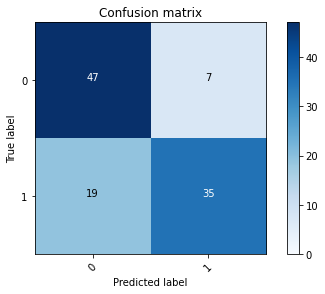

2022-07-06 18:51:23 - [Epoch Train: 97] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:51:23 - [Epoch Valid: 97] loss: 2.5891, auc: 0.8409, acc: 0.7593, time: 7.00 s


 65%|█████████████████████████▊              | 97/150 [1:08:01<35:43, 40.45s/it]

2022-07-06 18:51:23 - EPOCH: 98
2022-07-06 18:51:25 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:51:26 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:51:28 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:51:29 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:51:30 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:51:32 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:51:33 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:51:35 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:51:36 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:51:38 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:51:39 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:51:40 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:51:42 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:51:43 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:51:45 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:51:46 - Train Step 160/219, train_loss: 0.0000
2

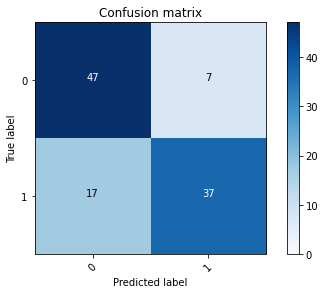

2022-07-06 18:52:02 - [Epoch Train: 98] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:52:02 - [Epoch Valid: 98] loss: 2.4853, auc: 0.8392, acc: 0.7778, time: 7.00 s


 65%|██████████████████████████▏             | 98/150 [1:08:40<34:41, 40.03s/it]

2022-07-06 18:52:02 - EPOCH: 99
2022-07-06 18:52:04 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:52:05 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:52:07 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:52:08 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:52:10 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:52:11 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:52:13 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:52:14 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:52:15 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:52:17 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:52:18 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:52:20 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:52:21 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:52:23 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:52:24 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:52:25 - Train Step 160/219, train_loss: 0.0000
2

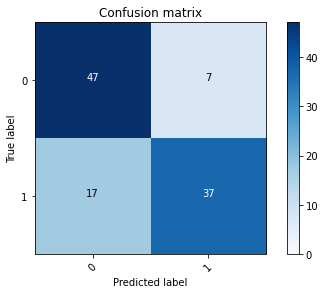

2022-07-06 18:52:42 - [Epoch Train: 99] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:52:42 - [Epoch Valid: 99] loss: 2.4899, auc: 0.8483, acc: 0.7778, time: 7.00 s


 66%|██████████████████████████▍             | 99/150 [1:09:20<33:53, 39.88s/it]

2022-07-06 18:52:42 - EPOCH: 100
2022-07-06 18:52:43 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:52:45 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:52:46 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:52:48 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:52:49 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:52:51 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:52:52 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:52:54 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:52:55 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:52:57 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:52:58 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:53:00 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:53:01 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:53:03 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:53:04 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:53:05 - Train Step 160/219, train_loss: 0.0000


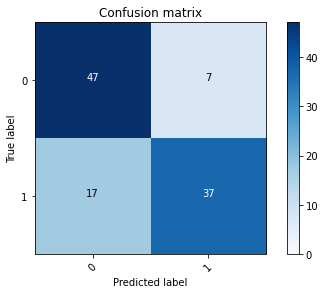

2022-07-06 18:53:22 - [Epoch Train: 100] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 32.00 s            
2022-07-06 18:53:22 - [Epoch Valid: 100] loss: 2.3864, auc: 0.8441, acc: 0.7778, time: 7.00 s


 67%|██████████████████████████             | 100/150 [1:10:00<33:22, 40.05s/it]

2022-07-06 18:53:22 - EPOCH: 101
2022-07-06 18:53:24 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:53:25 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:53:27 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:53:28 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:53:30 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:53:31 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:53:32 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:53:34 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:53:35 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:53:37 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:53:38 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:53:40 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:53:41 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:53:43 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:53:44 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:53:45 - Train Step 160/219, train_loss: 0.0000


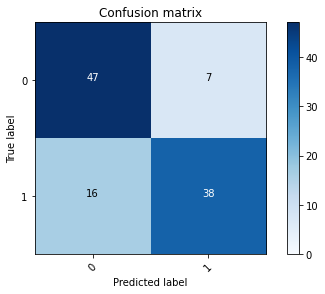

2022-07-06 18:54:02 - [Epoch Train: 101] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:54:02 - [Epoch Valid: 101] loss: 2.4362, auc: 0.8471, acc: 0.7870, time: 7.00 s


 67%|██████████████████████████▎            | 101/150 [1:10:40<32:35, 39.91s/it]

2022-07-06 18:54:02 - EPOCH: 102
2022-07-06 18:54:03 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:54:05 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:54:06 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:54:08 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:54:09 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:54:11 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:54:12 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:54:14 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:54:15 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:54:16 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:54:18 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:54:19 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:54:21 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:54:22 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:54:24 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:54:25 - Train Step 160/219, train_loss: 0.0000


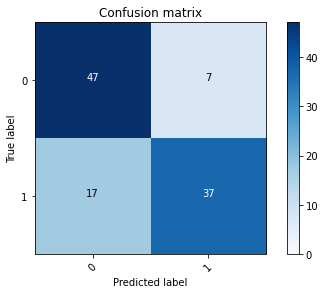

2022-07-06 18:54:41 - [Epoch Train: 102] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:54:41 - [Epoch Valid: 102] loss: 2.3806, auc: 0.8484, acc: 0.7778, time: 7.00 s


 68%|██████████████████████████▌            | 102/150 [1:11:20<31:51, 39.82s/it]

2022-07-06 18:54:41 - EPOCH: 103
2022-07-06 18:54:43 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:54:45 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:54:46 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:54:47 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:54:49 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:54:50 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:54:52 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:54:53 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:54:54 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:54:56 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:54:57 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:54:59 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:55:00 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:55:02 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:55:03 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:55:04 - Train Step 160/219, train_loss: 0.0000


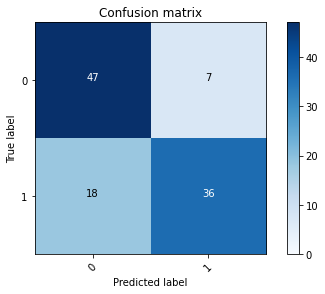

2022-07-06 18:55:21 - [Epoch Train: 103] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 31.00 s            
2022-07-06 18:55:21 - [Epoch Valid: 103] loss: 2.7551, auc: 0.8529, acc: 0.7685, time: 8.00 s


 69%|██████████████████████████▊            | 103/150 [1:11:59<31:06, 39.71s/it]

2022-07-06 18:55:21 - EPOCH: 104
2022-07-06 18:55:22 - Train Step 10/219, train_loss: 0.0000
2022-07-06 18:55:24 - Train Step 20/219, train_loss: 0.0000
2022-07-06 18:55:25 - Train Step 30/219, train_loss: 0.0000
2022-07-06 18:55:27 - Train Step 40/219, train_loss: 0.0000
2022-07-06 18:55:28 - Train Step 50/219, train_loss: 0.0000
2022-07-06 18:55:30 - Train Step 60/219, train_loss: 0.0000
2022-07-06 18:55:31 - Train Step 70/219, train_loss: 0.0000
2022-07-06 18:55:32 - Train Step 80/219, train_loss: 0.0000
2022-07-06 18:55:34 - Train Step 90/219, train_loss: 0.0000
2022-07-06 18:55:35 - Train Step 100/219, train_loss: 0.0000
2022-07-06 18:55:37 - Train Step 110/219, train_loss: 0.0000
2022-07-06 18:55:38 - Train Step 120/219, train_loss: 0.0000
2022-07-06 18:55:39 - Train Step 130/219, train_loss: 0.0000
2022-07-06 18:55:41 - Train Step 140/219, train_loss: 0.0000
2022-07-06 18:55:42 - Train Step 150/219, train_loss: 0.0000
2022-07-06 18:55:43 - Train Step 160/219, train_loss: 0.0000


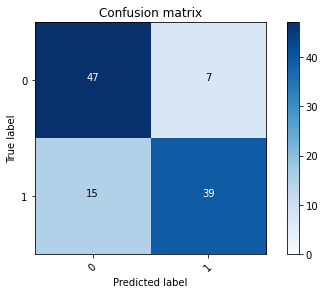

2022-07-06 18:55:59 - [Epoch Train: 104] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 30.00 s            
2022-07-06 18:55:59 - [Epoch Valid: 104] loss: 2.5601, auc: 0.8476, acc: 0.7963, time: 7.00 s
2022-07-06 18:55:59 - 
Valid acc didn't improve last 50 epochs.


 69%|██████████████████████████▊            | 103/150 [1:12:38<33:08, 42.31s/it]

../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00048_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00078_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00084_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00089_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00134_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00144_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00154_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00171_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00187_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00192_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00194_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00199_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00240_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00245_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00261_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00299_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00397_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00399_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00402_K

Dataset: Labeled Test Set
   BraTS21ID  MGMT_real_value  MGMT_value
54     00048                1           1
38     00078                1           1
45     00084                0           0
39     00089                1           1
3      00134                1           1
19     00144                1           0
17     00154                0           0
56     00171                1           1
2      00187                1           1
16     00192                0           1
47     00194                0           1
0      00199                1           1
29     00240                1           1
32     00245                1           1
15     00261                0           0
23     00261                0           0
35     00299                1           1
37     00397                0           0
1      00399                0           0
5      00399                0           0
13     00402                0           0
31     00402                0           0
34     0

2022-07-06 18:56:04 - Train/Val datasets size: 273


/home/salvatorecapuozzo/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Length of concatenated dataset: 546
Length of concatenated dataset: 546
Train Idx:
[33, 190, 245, 129, 253, 21, 237, 146, 16, 204, 75, 173, 135, 209, 179, 4, 96, 188, 61, 67, 52, 66, 26, 110, 233, 124, 268, 40, 13, 107, 145, 166, 3, 159, 24, 30, 252, 213, 60, 56, 248, 157, 46, 19, 212, 153, 54, 227, 80, 51, 2, 196, 104, 150, 86, 10, 168, 58, 41, 14, 50, 194, 123, 62, 158, 187, 130, 246, 154, 43, 221, 138, 254, 181, 149, 112, 207, 98, 180, 93, 171, 162, 36, 113, 0, 94, 95, 223, 69, 49, 48, 85, 270, 141, 23, 249, 143, 78, 100, 131, 228, 271, 6, 68, 84, 170, 121, 140, 214, 240, 234, 239, 91, 241, 257, 11, 119, 102, 35, 57, 169, 65, 1, 120, 226, 186, 42, 105, 132, 244, 17, 38, 133, 53, 164, 217, 128, 34, 28, 183, 114, 203, 163, 151, 202, 31, 232, 127, 185, 250, 260, 32, 167, 142, 236, 147, 29, 177, 216, 99, 82, 269, 175, 79, 197, 243, 208, 115, 148, 266, 72, 77, 25, 165, 81, 261, 174, 263, 39, 193, 88, 70, 87, 242, 211, 9, 195, 251, 192, 117, 47, 172, 413, 531, 485, 274, 430, 285, 426, 404

  0%|                                                   | 0/150 [00:00<?, ?it/s]

2022-07-06 18:56:04 - EPOCH: 1
2022-07-06 18:56:05 - Train Step 10/438, train_loss: 0.6805
2022-07-06 18:56:05 - Train Step 20/438, train_loss: 0.7090
2022-07-06 18:56:06 - Train Step 30/438, train_loss: 0.6930
2022-07-06 18:56:06 - Train Step 40/438, train_loss: 0.7007
2022-07-06 18:56:07 - Train Step 50/438, train_loss: 0.6957
2022-07-06 18:56:07 - Train Step 60/438, train_loss: 0.7004
2022-07-06 18:56:08 - Train Step 70/438, train_loss: 0.7036
2022-07-06 18:56:08 - Train Step 80/438, train_loss: 0.7020
2022-07-06 18:56:09 - Train Step 90/438, train_loss: 0.7046
2022-07-06 18:56:09 - Train Step 100/438, train_loss: 0.7042
2022-07-06 18:56:10 - Train Step 110/438, train_loss: 0.7021
2022-07-06 18:56:10 - Train Step 120/438, train_loss: 0.6993
2022-07-06 18:56:11 - Train Step 130/438, train_loss: 0.7036
2022-07-06 18:56:11 - Train Step 140/438, train_loss: 0.7043
2022-07-06 18:56:12 - Train Step 150/438, train_loss: 0.7019
2022-07-06 18:56:12 - Train Step 160/438, train_loss: 0.7006
20

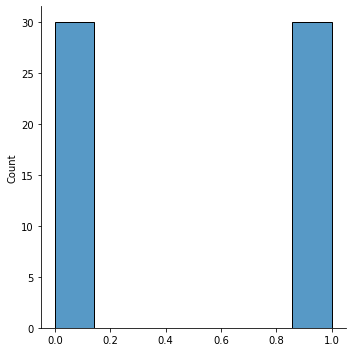

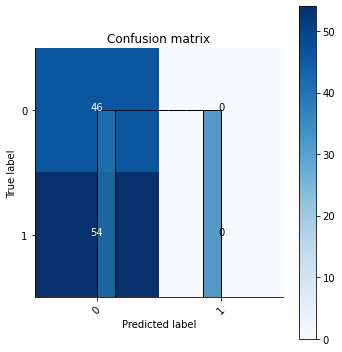

2022-07-06 18:56:32 - [Epoch Train: 1] loss: 0.6975, auc: 0.5021, acc: 0.5000, time: 21.00 s            
2022-07-06 18:56:32 - [Epoch Valid: 1] loss: 0.6950, auc: 0.4811, acc: 0.5000, time: 5.00 s
2022-07-06 18:56:32 - acc improved from 0.0000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e1-loss0.695-acc0.500-auc0.481.pth'


  1%|▎                                        | 1/150 [00:27<1:08:47, 27.70s/it]

2022-07-06 18:56:32 - EPOCH: 2
2022-07-06 18:56:33 - Train Step 10/438, train_loss: 0.7131
2022-07-06 18:56:33 - Train Step 20/438, train_loss: 0.7022
2022-07-06 18:56:34 - Train Step 30/438, train_loss: 0.6985
2022-07-06 18:56:34 - Train Step 40/438, train_loss: 0.6961
2022-07-06 18:56:35 - Train Step 50/438, train_loss: 0.6995
2022-07-06 18:56:35 - Train Step 60/438, train_loss: 0.7004
2022-07-06 18:56:36 - Train Step 70/438, train_loss: 0.6972
2022-07-06 18:56:36 - Train Step 80/438, train_loss: 0.6952
2022-07-06 18:56:37 - Train Step 90/438, train_loss: 0.6997
2022-07-06 18:56:37 - Train Step 100/438, train_loss: 0.6961
2022-07-06 18:56:38 - Train Step 110/438, train_loss: 0.6982
2022-07-06 18:56:38 - Train Step 120/438, train_loss: 0.6972
2022-07-06 18:56:38 - Train Step 130/438, train_loss: 0.6955
2022-07-06 18:56:39 - Train Step 140/438, train_loss: 0.6958
2022-07-06 18:56:39 - Train Step 150/438, train_loss: 0.6934
2022-07-06 18:56:40 - Train Step 160/438, train_loss: 0.6931
20

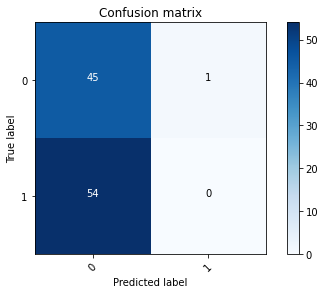

2022-07-06 18:56:59 - [Epoch Train: 2] loss: 0.6844, auc: 0.6015, acc: 0.5023, time: 21.00 s            
2022-07-06 18:56:59 - [Epoch Valid: 2] loss: 0.7058, auc: 0.5064, acc: 0.4907, time: 5.00 s


  1%|▌                                        | 2/150 [00:54<1:07:23, 27.32s/it]

2022-07-06 18:56:59 - EPOCH: 3
2022-07-06 18:57:00 - Train Step 10/438, train_loss: 0.6968
2022-07-06 18:57:00 - Train Step 20/438, train_loss: 0.7139
2022-07-06 18:57:01 - Train Step 30/438, train_loss: 0.6792
2022-07-06 18:57:01 - Train Step 40/438, train_loss: 0.6269
2022-07-06 18:57:02 - Train Step 50/438, train_loss: 0.6526
2022-07-06 18:57:02 - Train Step 60/438, train_loss: 0.6732
2022-07-06 18:57:03 - Train Step 70/438, train_loss: 0.6656
2022-07-06 18:57:03 - Train Step 80/438, train_loss: 0.6583
2022-07-06 18:57:04 - Train Step 90/438, train_loss: 0.6556
2022-07-06 18:57:04 - Train Step 100/438, train_loss: 0.6532
2022-07-06 18:57:05 - Train Step 110/438, train_loss: 0.6570
2022-07-06 18:57:05 - Train Step 120/438, train_loss: 0.6562
2022-07-06 18:57:06 - Train Step 130/438, train_loss: 0.6596
2022-07-06 18:57:07 - Train Step 140/438, train_loss: 0.6555
2022-07-06 18:57:07 - Train Step 150/438, train_loss: 0.6538
2022-07-06 18:57:08 - Train Step 160/438, train_loss: 0.6606
20

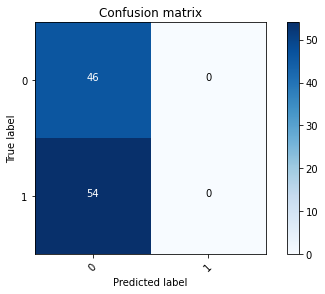

2022-07-06 18:57:28 - [Epoch Train: 3] loss: 0.6657, auc: 0.6320, acc: 0.5228, time: 22.00 s            
2022-07-06 18:57:28 - [Epoch Valid: 3] loss: 0.6730, auc: 0.6598, acc: 0.5000, time: 5.00 s
2022-07-06 18:57:28 - acc improved from 0.5000 to 0.5000. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e3-loss0.673-acc0.500-auc0.660.pth'


  2%|▊                                        | 3/150 [01:23<1:08:24, 27.92s/it]

2022-07-06 18:57:28 - EPOCH: 4
2022-07-06 18:57:28 - Train Step 10/438, train_loss: 0.6527
2022-07-06 18:57:29 - Train Step 20/438, train_loss: 0.6458
2022-07-06 18:57:29 - Train Step 30/438, train_loss: 0.6244
2022-07-06 18:57:30 - Train Step 40/438, train_loss: 0.6066
2022-07-06 18:57:30 - Train Step 50/438, train_loss: 0.5983
2022-07-06 18:57:31 - Train Step 60/438, train_loss: 0.6057
2022-07-06 18:57:31 - Train Step 70/438, train_loss: 0.6035
2022-07-06 18:57:32 - Train Step 80/438, train_loss: 0.6013
2022-07-06 18:57:32 - Train Step 90/438, train_loss: 0.6006
2022-07-06 18:57:33 - Train Step 100/438, train_loss: 0.5895
2022-07-06 18:57:33 - Train Step 110/438, train_loss: 0.5977
2022-07-06 18:57:34 - Train Step 120/438, train_loss: 0.5900
2022-07-06 18:57:34 - Train Step 130/438, train_loss: 0.5985
2022-07-06 18:57:35 - Train Step 140/438, train_loss: 0.5977
2022-07-06 18:57:35 - Train Step 150/438, train_loss: 0.5982
2022-07-06 18:57:36 - Train Step 160/438, train_loss: 0.6052
20

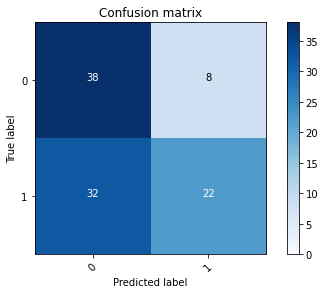

2022-07-06 18:57:54 - [Epoch Train: 4] loss: 0.6229, auc: 0.7148, acc: 0.5845, time: 20.00 s            
2022-07-06 18:57:54 - [Epoch Valid: 4] loss: 0.6703, auc: 0.6486, acc: 0.6111, time: 5.00 s
2022-07-06 18:57:54 - acc improved from 0.5000 to 0.6111. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e4-loss0.670-acc0.611-auc0.649.pth'


  3%|█                                        | 4/150 [01:49<1:06:30, 27.33s/it]

2022-07-06 18:57:54 - EPOCH: 5
2022-07-06 18:57:55 - Train Step 10/438, train_loss: 0.6495
2022-07-06 18:57:55 - Train Step 20/438, train_loss: 0.6241
2022-07-06 18:57:56 - Train Step 30/438, train_loss: 0.6414
2022-07-06 18:57:56 - Train Step 40/438, train_loss: 0.6033
2022-07-06 18:57:57 - Train Step 50/438, train_loss: 0.5991
2022-07-06 18:57:57 - Train Step 60/438, train_loss: 0.5788
2022-07-06 18:57:58 - Train Step 70/438, train_loss: 0.5732
2022-07-06 18:57:58 - Train Step 80/438, train_loss: 0.5849
2022-07-06 18:57:59 - Train Step 90/438, train_loss: 0.5829
2022-07-06 18:57:59 - Train Step 100/438, train_loss: 0.5696
2022-07-06 18:58:00 - Train Step 110/438, train_loss: 0.5765
2022-07-06 18:58:00 - Train Step 120/438, train_loss: 0.5829
2022-07-06 18:58:01 - Train Step 130/438, train_loss: 0.5829
2022-07-06 18:58:01 - Train Step 140/438, train_loss: 0.5802
2022-07-06 18:58:02 - Train Step 150/438, train_loss: 0.5848
2022-07-06 18:58:02 - Train Step 160/438, train_loss: 0.5810
20

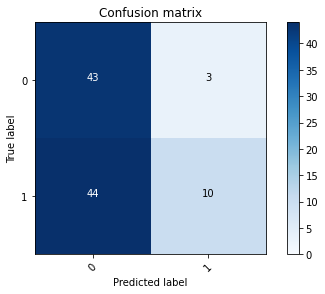

2022-07-06 18:58:22 - [Epoch Train: 5] loss: 0.5638, auc: 0.7849, acc: 0.6484, time: 21.00 s            
2022-07-06 18:58:22 - [Epoch Valid: 5] loss: 0.6711, auc: 0.6800, acc: 0.5556, time: 5.00 s


  3%|█▎                                       | 5/150 [02:17<1:06:08, 27.37s/it]

2022-07-06 18:58:22 - EPOCH: 6
2022-07-06 18:58:22 - Train Step 10/438, train_loss: 0.5489
2022-07-06 18:58:23 - Train Step 20/438, train_loss: 0.5207
2022-07-06 18:58:23 - Train Step 30/438, train_loss: 0.5009
2022-07-06 18:58:24 - Train Step 40/438, train_loss: 0.5278
2022-07-06 18:58:24 - Train Step 50/438, train_loss: 0.5325
2022-07-06 18:58:25 - Train Step 60/438, train_loss: 0.5247
2022-07-06 18:58:25 - Train Step 70/438, train_loss: 0.5212
2022-07-06 18:58:26 - Train Step 80/438, train_loss: 0.5204
2022-07-06 18:58:26 - Train Step 90/438, train_loss: 0.5023
2022-07-06 18:58:27 - Train Step 100/438, train_loss: 0.5053
2022-07-06 18:58:27 - Train Step 110/438, train_loss: 0.5209
2022-07-06 18:58:27 - Train Step 120/438, train_loss: 0.5239
2022-07-06 18:58:28 - Train Step 130/438, train_loss: 0.5435
2022-07-06 18:58:28 - Train Step 140/438, train_loss: 0.5493
2022-07-06 18:58:29 - Train Step 150/438, train_loss: 0.5490
2022-07-06 18:58:29 - Train Step 160/438, train_loss: 0.5397
20

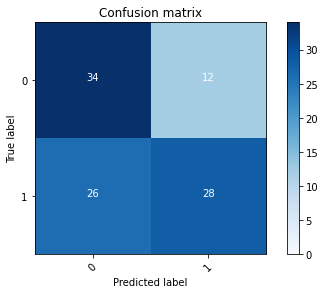

2022-07-06 18:58:49 - [Epoch Train: 6] loss: 0.4929, auc: 0.8480, acc: 0.7123, time: 21.00 s            
2022-07-06 18:58:49 - [Epoch Valid: 6] loss: 0.6627, auc: 0.6985, acc: 0.6111, time: 5.00 s
2022-07-06 18:58:49 - acc improved from 0.6111 to 0.6111. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e6-loss0.663-acc0.611-auc0.698.pth'


  4%|█▋                                       | 6/150 [02:44<1:05:18, 27.21s/it]

2022-07-06 18:58:49 - EPOCH: 7
2022-07-06 18:58:49 - Train Step 10/438, train_loss: 0.2490
2022-07-06 18:58:50 - Train Step 20/438, train_loss: 0.3024
2022-07-06 18:58:50 - Train Step 30/438, train_loss: 0.4791
2022-07-06 18:58:51 - Train Step 40/438, train_loss: 0.4817
2022-07-06 18:58:51 - Train Step 50/438, train_loss: 0.4747
2022-07-06 18:58:52 - Train Step 60/438, train_loss: 0.4600
2022-07-06 18:58:52 - Train Step 70/438, train_loss: 0.4471
2022-07-06 18:58:53 - Train Step 80/438, train_loss: 0.4368
2022-07-06 18:58:53 - Train Step 90/438, train_loss: 0.4418
2022-07-06 18:58:54 - Train Step 100/438, train_loss: 0.4212
2022-07-06 18:58:54 - Train Step 110/438, train_loss: 0.4043
2022-07-06 18:58:55 - Train Step 120/438, train_loss: 0.3956
2022-07-06 18:58:55 - Train Step 130/438, train_loss: 0.3898
2022-07-06 18:58:56 - Train Step 140/438, train_loss: 0.3919
2022-07-06 18:58:56 - Train Step 150/438, train_loss: 0.3824
2022-07-06 18:58:56 - Train Step 160/438, train_loss: 0.3824
20

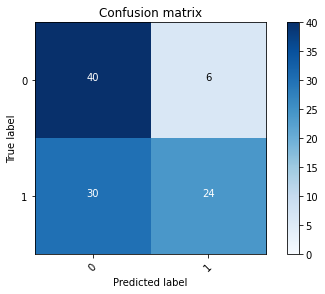

2022-07-06 18:59:15 - [Epoch Train: 7] loss: 0.4064, auc: 0.8997, acc: 0.7580, time: 21.00 s            
2022-07-06 18:59:15 - [Epoch Valid: 7] loss: 0.6450, auc: 0.7371, acc: 0.6296, time: 5.00 s
2022-07-06 18:59:15 - acc improved from 0.6111 to 0.6296. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e7-loss0.645-acc0.630-auc0.737.pth'


  5%|█▉                                       | 7/150 [03:11<1:04:34, 27.09s/it]

2022-07-06 18:59:15 - EPOCH: 8
2022-07-06 18:59:16 - Train Step 10/438, train_loss: 0.3011
2022-07-06 18:59:16 - Train Step 20/438, train_loss: 0.3091
2022-07-06 18:59:17 - Train Step 30/438, train_loss: 0.3514
2022-07-06 18:59:17 - Train Step 40/438, train_loss: 0.3553
2022-07-06 18:59:18 - Train Step 50/438, train_loss: 0.3410
2022-07-06 18:59:18 - Train Step 60/438, train_loss: 0.3425
2022-07-06 18:59:19 - Train Step 70/438, train_loss: 0.3481
2022-07-06 18:59:19 - Train Step 80/438, train_loss: 0.3551
2022-07-06 18:59:20 - Train Step 90/438, train_loss: 0.3502
2022-07-06 18:59:20 - Train Step 100/438, train_loss: 0.3680
2022-07-06 18:59:21 - Train Step 110/438, train_loss: 0.3531
2022-07-06 18:59:21 - Train Step 120/438, train_loss: 0.3421
2022-07-06 18:59:22 - Train Step 130/438, train_loss: 0.3682
2022-07-06 18:59:22 - Train Step 140/438, train_loss: 0.3871
2022-07-06 18:59:23 - Train Step 150/438, train_loss: 0.3710
2022-07-06 18:59:23 - Train Step 160/438, train_loss: 0.3700
20

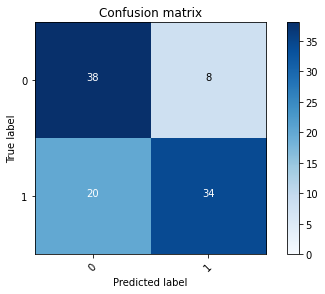

2022-07-06 18:59:42 - [Epoch Train: 8] loss: 0.3677, auc: 0.9222, acc: 0.7854, time: 21.00 s            
2022-07-06 18:59:42 - [Epoch Valid: 8] loss: 0.6609, auc: 0.7701, acc: 0.7037, time: 5.00 s
2022-07-06 18:59:42 - acc improved from 0.6296 to 0.7037. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e8-loss0.661-acc0.704-auc0.770.pth'


  5%|██▏                                      | 8/150 [03:37<1:03:58, 27.03s/it]

2022-07-06 18:59:42 - EPOCH: 9
2022-07-06 18:59:43 - Train Step 10/438, train_loss: 0.4664
2022-07-06 18:59:43 - Train Step 20/438, train_loss: 0.3422
2022-07-06 18:59:44 - Train Step 30/438, train_loss: 0.3100
2022-07-06 18:59:44 - Train Step 40/438, train_loss: 0.2799
2022-07-06 18:59:45 - Train Step 50/438, train_loss: 0.2856
2022-07-06 18:59:45 - Train Step 60/438, train_loss: 0.3047
2022-07-06 18:59:46 - Train Step 70/438, train_loss: 0.3210
2022-07-06 18:59:46 - Train Step 80/438, train_loss: 0.3061
2022-07-06 18:59:47 - Train Step 90/438, train_loss: 0.2852
2022-07-06 18:59:47 - Train Step 100/438, train_loss: 0.2706
2022-07-06 18:59:48 - Train Step 110/438, train_loss: 0.2699
2022-07-06 18:59:48 - Train Step 120/438, train_loss: 0.2823
2022-07-06 18:59:49 - Train Step 130/438, train_loss: 0.2926
2022-07-06 18:59:49 - Train Step 140/438, train_loss: 0.2974
2022-07-06 18:59:50 - Train Step 150/438, train_loss: 0.2913
2022-07-06 18:59:50 - Train Step 160/438, train_loss: 0.2864
20

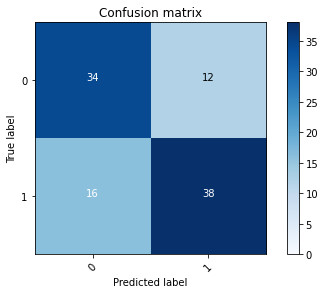

2022-07-06 19:00:09 - [Epoch Train: 9] loss: 0.2857, auc: 0.9515, acc: 0.8790, time: 21.00 s            
2022-07-06 19:00:09 - [Epoch Valid: 9] loss: 0.7249, auc: 0.7907, acc: 0.7037, time: 5.00 s
2022-07-06 19:00:09 - acc improved from 0.7037 to 0.7037. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e9-loss0.725-acc0.704-auc0.791.pth'


  6%|██▍                                      | 9/150 [04:04<1:03:20, 26.96s/it]

2022-07-06 19:00:09 - EPOCH: 10
2022-07-06 19:00:10 - Train Step 10/438, train_loss: 0.1123
2022-07-06 19:00:10 - Train Step 20/438, train_loss: 0.1745
2022-07-06 19:00:11 - Train Step 30/438, train_loss: 0.2255
2022-07-06 19:00:11 - Train Step 40/438, train_loss: 0.2323
2022-07-06 19:00:12 - Train Step 50/438, train_loss: 0.2338
2022-07-06 19:00:12 - Train Step 60/438, train_loss: 0.2281
2022-07-06 19:00:13 - Train Step 70/438, train_loss: 0.2214
2022-07-06 19:00:13 - Train Step 80/438, train_loss: 0.2225
2022-07-06 19:00:14 - Train Step 90/438, train_loss: 0.2310
2022-07-06 19:00:14 - Train Step 100/438, train_loss: 0.2856
2022-07-06 19:00:15 - Train Step 110/438, train_loss: 0.2746
2022-07-06 19:00:15 - Train Step 120/438, train_loss: 0.2693
2022-07-06 19:00:16 - Train Step 130/438, train_loss: 0.2644
2022-07-06 19:00:16 - Train Step 140/438, train_loss: 0.2607
2022-07-06 19:00:17 - Train Step 150/438, train_loss: 0.2552
2022-07-06 19:00:17 - Train Step 160/438, train_loss: 0.2665
2

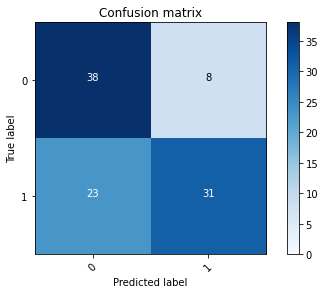

2022-07-06 19:00:37 - [Epoch Train: 10] loss: 0.2489, auc: 0.9550, acc: 0.8858, time: 22.00 s            
2022-07-06 19:00:37 - [Epoch Valid: 10] loss: 0.7091, auc: 0.8136, acc: 0.6759, time: 5.00 s


  7%|██▋                                     | 10/150 [04:32<1:03:37, 27.27s/it]

2022-07-06 19:00:37 - EPOCH: 11
2022-07-06 19:00:38 - Train Step 10/438, train_loss: 0.2958
2022-07-06 19:00:38 - Train Step 20/438, train_loss: 0.1806
2022-07-06 19:00:39 - Train Step 30/438, train_loss: 0.1639
2022-07-06 19:00:39 - Train Step 40/438, train_loss: 0.1601
2022-07-06 19:00:40 - Train Step 50/438, train_loss: 0.1410
2022-07-06 19:00:40 - Train Step 60/438, train_loss: 0.1318
2022-07-06 19:00:40 - Train Step 70/438, train_loss: 0.1415
2022-07-06 19:00:41 - Train Step 80/438, train_loss: 0.1275
2022-07-06 19:00:41 - Train Step 90/438, train_loss: 0.1221
2022-07-06 19:00:42 - Train Step 100/438, train_loss: 0.1136
2022-07-06 19:00:42 - Train Step 110/438, train_loss: 0.1092
2022-07-06 19:00:43 - Train Step 120/438, train_loss: 0.1121
2022-07-06 19:00:43 - Train Step 130/438, train_loss: 0.1069
2022-07-06 19:00:44 - Train Step 140/438, train_loss: 0.1074
2022-07-06 19:00:44 - Train Step 150/438, train_loss: 0.1098
2022-07-06 19:00:45 - Train Step 160/438, train_loss: 0.1113
2

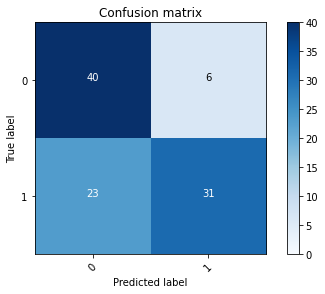

2022-07-06 19:01:04 - [Epoch Train: 11] loss: 0.1425, auc: 0.9885, acc: 0.9521, time: 20.00 s            
2022-07-06 19:01:04 - [Epoch Valid: 11] loss: 0.6836, auc: 0.8418, acc: 0.6944, time: 5.00 s


  7%|██▉                                     | 11/150 [04:59<1:02:45, 27.09s/it]

2022-07-06 19:01:04 - EPOCH: 12
2022-07-06 19:01:04 - Train Step 10/438, train_loss: 0.1027
2022-07-06 19:01:05 - Train Step 20/438, train_loss: 0.1647
2022-07-06 19:01:05 - Train Step 30/438, train_loss: 0.2241
2022-07-06 19:01:06 - Train Step 40/438, train_loss: 0.1826
2022-07-06 19:01:06 - Train Step 50/438, train_loss: 0.1528
2022-07-06 19:01:07 - Train Step 60/438, train_loss: 0.1402
2022-07-06 19:01:07 - Train Step 70/438, train_loss: 0.1496
2022-07-06 19:01:08 - Train Step 80/438, train_loss: 0.1395
2022-07-06 19:01:08 - Train Step 90/438, train_loss: 0.1351
2022-07-06 19:01:09 - Train Step 100/438, train_loss: 0.1279
2022-07-06 19:01:09 - Train Step 110/438, train_loss: 0.1229
2022-07-06 19:01:10 - Train Step 120/438, train_loss: 0.1256
2022-07-06 19:01:10 - Train Step 130/438, train_loss: 0.1190
2022-07-06 19:01:11 - Train Step 140/438, train_loss: 0.1181
2022-07-06 19:01:11 - Train Step 150/438, train_loss: 0.1259
2022-07-06 19:01:12 - Train Step 160/438, train_loss: 0.1227
2

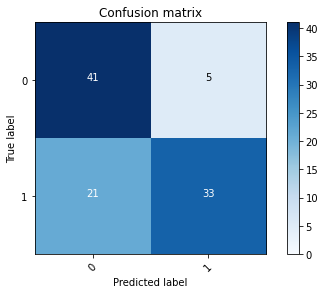

2022-07-06 19:01:31 - [Epoch Train: 12] loss: 0.1362, auc: 0.9825, acc: 0.9635, time: 21.00 s            
2022-07-06 19:01:31 - [Epoch Valid: 12] loss: 0.7264, auc: 0.8422, acc: 0.7407, time: 5.00 s
2022-07-06 19:01:31 - acc improved from 0.7037 to 0.7407. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e12-loss0.726-acc0.741-auc0.842.pth'


  8%|███▏                                    | 12/150 [05:26<1:02:05, 27.00s/it]

2022-07-06 19:01:31 - EPOCH: 13
2022-07-06 19:01:31 - Train Step 10/438, train_loss: 0.0724
2022-07-06 19:01:32 - Train Step 20/438, train_loss: 0.0536
2022-07-06 19:01:32 - Train Step 30/438, train_loss: 0.0935
2022-07-06 19:01:33 - Train Step 40/438, train_loss: 0.0794
2022-07-06 19:01:33 - Train Step 50/438, train_loss: 0.0832
2022-07-06 19:01:33 - Train Step 60/438, train_loss: 0.0872
2022-07-06 19:01:34 - Train Step 70/438, train_loss: 0.0872
2022-07-06 19:01:34 - Train Step 80/438, train_loss: 0.0976
2022-07-06 19:01:35 - Train Step 90/438, train_loss: 0.1191
2022-07-06 19:01:35 - Train Step 100/438, train_loss: 0.1208
2022-07-06 19:01:36 - Train Step 110/438, train_loss: 0.1321
2022-07-06 19:01:36 - Train Step 120/438, train_loss: 0.1240
2022-07-06 19:01:37 - Train Step 130/438, train_loss: 0.1274
2022-07-06 19:01:37 - Train Step 140/438, train_loss: 0.1240
2022-07-06 19:01:38 - Train Step 150/438, train_loss: 0.1245
2022-07-06 19:01:38 - Train Step 160/438, train_loss: 0.1291
2

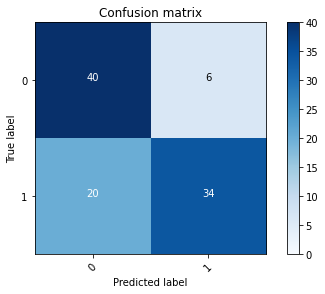

2022-07-06 19:01:58 - [Epoch Train: 13] loss: 0.1173, auc: 0.9902, acc: 0.9566, time: 21.00 s            
2022-07-06 19:01:58 - [Epoch Valid: 13] loss: 0.7367, auc: 0.8494, acc: 0.7222, time: 5.00 s


  9%|███▍                                    | 13/150 [05:53<1:01:44, 27.04s/it]

2022-07-06 19:01:58 - EPOCH: 14
2022-07-06 19:01:58 - Train Step 10/438, train_loss: 0.0245
2022-07-06 19:01:59 - Train Step 20/438, train_loss: 0.1114
2022-07-06 19:01:59 - Train Step 30/438, train_loss: 0.0882
2022-07-06 19:02:00 - Train Step 40/438, train_loss: 0.0757
2022-07-06 19:02:00 - Train Step 50/438, train_loss: 0.0696
2022-07-06 19:02:01 - Train Step 60/438, train_loss: 0.0758
2022-07-06 19:02:01 - Train Step 70/438, train_loss: 0.0673
2022-07-06 19:02:02 - Train Step 80/438, train_loss: 0.0627
2022-07-06 19:02:02 - Train Step 90/438, train_loss: 0.0570
2022-07-06 19:02:03 - Train Step 100/438, train_loss: 0.0627
2022-07-06 19:02:03 - Train Step 110/438, train_loss: 0.0651
2022-07-06 19:02:04 - Train Step 120/438, train_loss: 0.0608
2022-07-06 19:02:04 - Train Step 130/438, train_loss: 0.0668
2022-07-06 19:02:05 - Train Step 140/438, train_loss: 0.0649
2022-07-06 19:02:05 - Train Step 150/438, train_loss: 0.0706
2022-07-06 19:02:06 - Train Step 160/438, train_loss: 0.0769
2

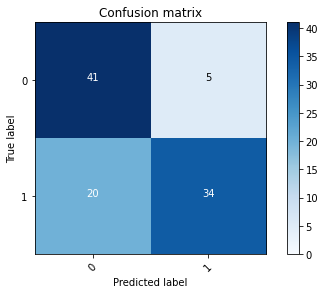

2022-07-06 19:02:25 - [Epoch Train: 14] loss: 0.0877, auc: 0.9967, acc: 0.9703, time: 21.00 s            
2022-07-06 19:02:25 - [Epoch Valid: 14] loss: 0.7536, auc: 0.8535, acc: 0.7315, time: 5.00 s


  9%|███▋                                    | 14/150 [06:20<1:01:25, 27.10s/it]

2022-07-06 19:02:25 - EPOCH: 15
2022-07-06 19:02:26 - Train Step 10/438, train_loss: 0.0201
2022-07-06 19:02:26 - Train Step 20/438, train_loss: 0.0168
2022-07-06 19:02:27 - Train Step 30/438, train_loss: 0.0193
2022-07-06 19:02:27 - Train Step 40/438, train_loss: 0.0224
2022-07-06 19:02:28 - Train Step 50/438, train_loss: 0.0496
2022-07-06 19:02:28 - Train Step 60/438, train_loss: 0.0627
2022-07-06 19:02:29 - Train Step 70/438, train_loss: 0.0615
2022-07-06 19:02:29 - Train Step 80/438, train_loss: 0.0570
2022-07-06 19:02:30 - Train Step 90/438, train_loss: 0.0526
2022-07-06 19:02:30 - Train Step 100/438, train_loss: 0.0551
2022-07-06 19:02:31 - Train Step 110/438, train_loss: 0.0570
2022-07-06 19:02:31 - Train Step 120/438, train_loss: 0.0596
2022-07-06 19:02:32 - Train Step 130/438, train_loss: 0.0653
2022-07-06 19:02:32 - Train Step 140/438, train_loss: 0.0628
2022-07-06 19:02:33 - Train Step 150/438, train_loss: 0.0597
2022-07-06 19:02:33 - Train Step 160/438, train_loss: 0.0616
2

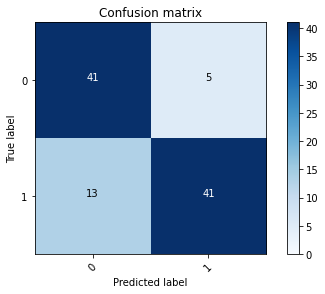

2022-07-06 19:02:53 - [Epoch Train: 15] loss: 0.0822, auc: 0.9950, acc: 0.9703, time: 22.00 s            
2022-07-06 19:02:53 - [Epoch Valid: 15] loss: 0.7947, auc: 0.8720, acc: 0.7963, time: 5.00 s
2022-07-06 19:02:53 - acc improved from 0.7407 to 0.7963. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e15-loss0.795-acc0.796-auc0.872.pth'


 10%|████                                    | 15/150 [06:48<1:01:45, 27.45s/it]

2022-07-06 19:02:53 - EPOCH: 16
2022-07-06 19:02:54 - Train Step 10/438, train_loss: 0.0274
2022-07-06 19:02:54 - Train Step 20/438, train_loss: 0.0303
2022-07-06 19:02:55 - Train Step 30/438, train_loss: 0.0426
2022-07-06 19:02:55 - Train Step 40/438, train_loss: 0.0410
2022-07-06 19:02:56 - Train Step 50/438, train_loss: 0.0600
2022-07-06 19:02:56 - Train Step 60/438, train_loss: 0.0803
2022-07-06 19:02:57 - Train Step 70/438, train_loss: 0.0732
2022-07-06 19:02:57 - Train Step 80/438, train_loss: 0.0876
2022-07-06 19:02:58 - Train Step 90/438, train_loss: 0.0792
2022-07-06 19:02:58 - Train Step 100/438, train_loss: 0.0742
2022-07-06 19:02:59 - Train Step 110/438, train_loss: 0.0733
2022-07-06 19:02:59 - Train Step 120/438, train_loss: 0.0763
2022-07-06 19:03:00 - Train Step 130/438, train_loss: 0.0781
2022-07-06 19:03:00 - Train Step 140/438, train_loss: 0.0736
2022-07-06 19:03:01 - Train Step 150/438, train_loss: 0.0711
2022-07-06 19:03:01 - Train Step 160/438, train_loss: 0.0677
2

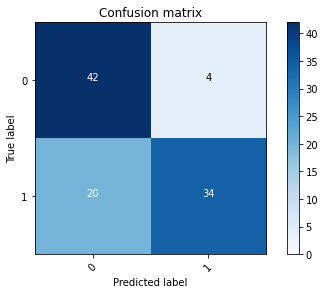

2022-07-06 19:03:21 - [Epoch Train: 16] loss: 0.0923, auc: 0.9951, acc: 0.9658, time: 22.00 s            
2022-07-06 19:03:21 - [Epoch Valid: 16] loss: 0.7421, auc: 0.8760, acc: 0.7407, time: 5.00 s


 11%|████▎                                   | 16/150 [07:17<1:01:49, 27.69s/it]

2022-07-06 19:03:21 - EPOCH: 17
2022-07-06 19:03:22 - Train Step 10/438, train_loss: 0.0601
2022-07-06 19:03:22 - Train Step 20/438, train_loss: 0.0816
2022-07-06 19:03:23 - Train Step 30/438, train_loss: 0.0573
2022-07-06 19:03:23 - Train Step 40/438, train_loss: 0.0622
2022-07-06 19:03:24 - Train Step 50/438, train_loss: 0.0669
2022-07-06 19:03:24 - Train Step 60/438, train_loss: 0.0645
2022-07-06 19:03:25 - Train Step 70/438, train_loss: 0.0588
2022-07-06 19:03:25 - Train Step 80/438, train_loss: 0.0578
2022-07-06 19:03:26 - Train Step 90/438, train_loss: 0.0535
2022-07-06 19:03:26 - Train Step 100/438, train_loss: 0.0508
2022-07-06 19:03:27 - Train Step 110/438, train_loss: 0.0595
2022-07-06 19:03:27 - Train Step 120/438, train_loss: 0.0584
2022-07-06 19:03:28 - Train Step 130/438, train_loss: 0.0612
2022-07-06 19:03:28 - Train Step 140/438, train_loss: 0.0608
2022-07-06 19:03:29 - Train Step 150/438, train_loss: 0.0600
2022-07-06 19:03:29 - Train Step 160/438, train_loss: 0.0566
2

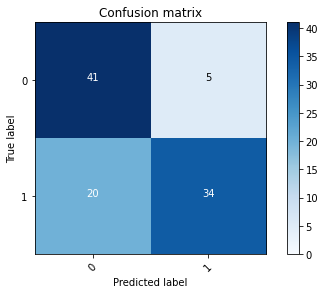

2022-07-06 19:03:48 - [Epoch Train: 17] loss: 0.0399, auc: 0.9999, acc: 0.9932, time: 20.00 s            
2022-07-06 19:03:48 - [Epoch Valid: 17] loss: 0.9237, auc: 0.8671, acc: 0.7315, time: 5.00 s


 11%|████▌                                   | 17/150 [07:43<1:00:29, 27.29s/it]

2022-07-06 19:03:48 - EPOCH: 18
2022-07-06 19:03:48 - Train Step 10/438, train_loss: 0.0058
2022-07-06 19:03:49 - Train Step 20/438, train_loss: 0.0119
2022-07-06 19:03:49 - Train Step 30/438, train_loss: 0.0149
2022-07-06 19:03:50 - Train Step 40/438, train_loss: 0.0256
2022-07-06 19:03:50 - Train Step 50/438, train_loss: 0.0217
2022-07-06 19:03:51 - Train Step 60/438, train_loss: 0.0210
2022-07-06 19:03:51 - Train Step 70/438, train_loss: 0.0303
2022-07-06 19:03:52 - Train Step 80/438, train_loss: 0.0291
2022-07-06 19:03:52 - Train Step 90/438, train_loss: 0.0381
2022-07-06 19:03:53 - Train Step 100/438, train_loss: 0.0370
2022-07-06 19:03:53 - Train Step 110/438, train_loss: 0.0381
2022-07-06 19:03:54 - Train Step 120/438, train_loss: 0.0359
2022-07-06 19:03:54 - Train Step 130/438, train_loss: 0.0333
2022-07-06 19:03:55 - Train Step 140/438, train_loss: 0.0322
2022-07-06 19:03:55 - Train Step 150/438, train_loss: 0.0308
2022-07-06 19:03:56 - Train Step 160/438, train_loss: 0.0291
2

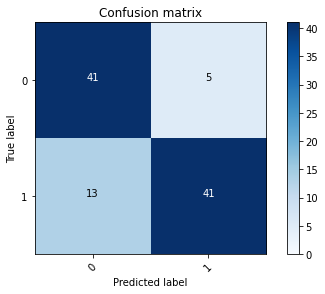

2022-07-06 19:04:15 - [Epoch Train: 18] loss: 0.0464, auc: 0.9987, acc: 0.9840, time: 21.00 s            
2022-07-06 19:04:15 - [Epoch Valid: 18] loss: 0.8628, auc: 0.8716, acc: 0.7963, time: 5.00 s
2022-07-06 19:04:15 - acc improved from 0.7963 to 0.7963. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e18-loss0.863-acc0.796-auc0.872.pth'


 12%|█████                                     | 18/150 [08:10<59:44, 27.16s/it]

2022-07-06 19:04:15 - EPOCH: 19
2022-07-06 19:04:15 - Train Step 10/438, train_loss: 0.0411
2022-07-06 19:04:16 - Train Step 20/438, train_loss: 0.0499
2022-07-06 19:04:16 - Train Step 30/438, train_loss: 0.0983
2022-07-06 19:04:17 - Train Step 40/438, train_loss: 0.1390
2022-07-06 19:04:17 - Train Step 50/438, train_loss: 0.1231
2022-07-06 19:04:18 - Train Step 60/438, train_loss: 0.1288
2022-07-06 19:04:18 - Train Step 70/438, train_loss: 0.1249
2022-07-06 19:04:19 - Train Step 80/438, train_loss: 0.1185
2022-07-06 19:04:19 - Train Step 90/438, train_loss: 0.1090
2022-07-06 19:04:19 - Train Step 100/438, train_loss: 0.1103
2022-07-06 19:04:20 - Train Step 110/438, train_loss: 0.1041
2022-07-06 19:04:20 - Train Step 120/438, train_loss: 0.0962
2022-07-06 19:04:21 - Train Step 130/438, train_loss: 0.0995
2022-07-06 19:04:21 - Train Step 140/438, train_loss: 0.0970
2022-07-06 19:04:22 - Train Step 150/438, train_loss: 0.0920
2022-07-06 19:04:22 - Train Step 160/438, train_loss: 0.0930
2

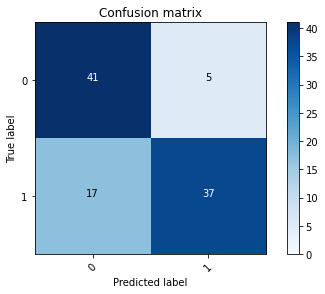

2022-07-06 19:04:42 - [Epoch Train: 19] loss: 0.0742, auc: 0.9996, acc: 0.9635, time: 21.00 s            
2022-07-06 19:04:42 - [Epoch Valid: 19] loss: 0.8695, auc: 0.8712, acc: 0.7593, time: 5.00 s


 13%|█████▎                                    | 19/150 [08:37<59:07, 27.08s/it]

2022-07-06 19:04:42 - EPOCH: 20
2022-07-06 19:04:42 - Train Step 10/438, train_loss: 0.0408
2022-07-06 19:04:43 - Train Step 20/438, train_loss: 0.0251
2022-07-06 19:04:43 - Train Step 30/438, train_loss: 0.0173
2022-07-06 19:04:44 - Train Step 40/438, train_loss: 0.0222
2022-07-06 19:04:44 - Train Step 50/438, train_loss: 0.0227
2022-07-06 19:04:45 - Train Step 60/438, train_loss: 0.0221
2022-07-06 19:04:45 - Train Step 70/438, train_loss: 0.0208
2022-07-06 19:04:46 - Train Step 80/438, train_loss: 0.0286
2022-07-06 19:04:46 - Train Step 90/438, train_loss: 0.0265
2022-07-06 19:04:47 - Train Step 100/438, train_loss: 0.0291
2022-07-06 19:04:47 - Train Step 110/438, train_loss: 0.0271
2022-07-06 19:04:47 - Train Step 120/438, train_loss: 0.0314
2022-07-06 19:04:48 - Train Step 130/438, train_loss: 0.0299
2022-07-06 19:04:48 - Train Step 140/438, train_loss: 0.0303
2022-07-06 19:04:49 - Train Step 150/438, train_loss: 0.0323
2022-07-06 19:04:49 - Train Step 160/438, train_loss: 0.0353
2

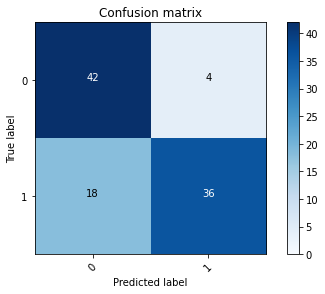

2022-07-06 19:05:09 - [Epoch Train: 20] loss: 0.0470, auc: 0.9996, acc: 0.9817, time: 21.00 s            
2022-07-06 19:05:09 - [Epoch Valid: 20] loss: 0.9319, auc: 0.8692, acc: 0.7593, time: 5.00 s


 13%|█████▌                                    | 20/150 [09:04<58:45, 27.12s/it]

2022-07-06 19:05:09 - EPOCH: 21
2022-07-06 19:05:09 - Train Step 10/438, train_loss: 0.0705
2022-07-06 19:05:10 - Train Step 20/438, train_loss: 0.0592
2022-07-06 19:05:10 - Train Step 30/438, train_loss: 0.0478
2022-07-06 19:05:11 - Train Step 40/438, train_loss: 0.0472
2022-07-06 19:05:11 - Train Step 50/438, train_loss: 0.0424
2022-07-06 19:05:12 - Train Step 60/438, train_loss: 0.0542
2022-07-06 19:05:12 - Train Step 70/438, train_loss: 0.0495
2022-07-06 19:05:13 - Train Step 80/438, train_loss: 0.0472
2022-07-06 19:05:13 - Train Step 90/438, train_loss: 0.0445
2022-07-06 19:05:14 - Train Step 100/438, train_loss: 0.0533
2022-07-06 19:05:14 - Train Step 110/438, train_loss: 0.0502
2022-07-06 19:05:15 - Train Step 120/438, train_loss: 0.0475
2022-07-06 19:05:15 - Train Step 130/438, train_loss: 0.0441
2022-07-06 19:05:16 - Train Step 140/438, train_loss: 0.0414
2022-07-06 19:05:16 - Train Step 150/438, train_loss: 0.0401
2022-07-06 19:05:17 - Train Step 160/438, train_loss: 0.0377
2

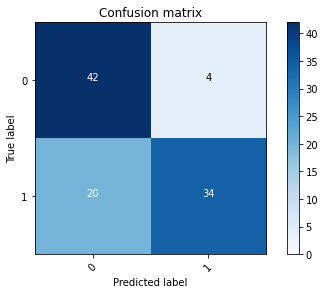

2022-07-06 19:05:37 - [Epoch Train: 21] loss: 0.0460, auc: 0.9980, acc: 0.9840, time: 22.00 s            
2022-07-06 19:05:37 - [Epoch Valid: 21] loss: 1.0316, auc: 0.8708, acc: 0.7407, time: 5.00 s


 14%|█████▉                                    | 21/150 [09:32<58:58, 27.43s/it]

2022-07-06 19:05:37 - EPOCH: 22
2022-07-06 19:05:38 - Train Step 10/438, train_loss: 0.0132
2022-07-06 19:05:38 - Train Step 20/438, train_loss: 0.0285
2022-07-06 19:05:38 - Train Step 30/438, train_loss: 0.0219
2022-07-06 19:05:39 - Train Step 40/438, train_loss: 0.0193
2022-07-06 19:05:39 - Train Step 50/438, train_loss: 0.0179
2022-07-06 19:05:40 - Train Step 60/438, train_loss: 0.0209
2022-07-06 19:05:40 - Train Step 70/438, train_loss: 0.0300
2022-07-06 19:05:41 - Train Step 80/438, train_loss: 0.0274
2022-07-06 19:05:41 - Train Step 90/438, train_loss: 0.0248
2022-07-06 19:05:42 - Train Step 100/438, train_loss: 0.0236
2022-07-06 19:05:43 - Train Step 110/438, train_loss: 0.0271
2022-07-06 19:05:43 - Train Step 120/438, train_loss: 0.0458
2022-07-06 19:05:44 - Train Step 130/438, train_loss: 0.0426
2022-07-06 19:05:44 - Train Step 140/438, train_loss: 0.0578
2022-07-06 19:05:45 - Train Step 150/438, train_loss: 0.0571
2022-07-06 19:05:45 - Train Step 160/438, train_loss: 0.0552
2

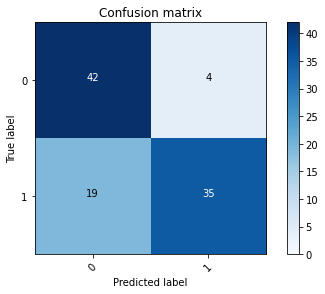

2022-07-06 19:06:05 - [Epoch Train: 22] loss: 0.0553, auc: 0.9982, acc: 0.9749, time: 22.00 s            
2022-07-06 19:06:05 - [Epoch Valid: 22] loss: 1.0345, auc: 0.8768, acc: 0.7500, time: 5.00 s


 15%|██████▏                                   | 22/150 [10:00<58:51, 27.59s/it]

2022-07-06 19:06:05 - EPOCH: 23
2022-07-06 19:06:05 - Train Step 10/438, train_loss: 0.0621
2022-07-06 19:06:06 - Train Step 20/438, train_loss: 0.0362
2022-07-06 19:06:06 - Train Step 30/438, train_loss: 0.0344
2022-07-06 19:06:07 - Train Step 40/438, train_loss: 0.0304
2022-07-06 19:06:07 - Train Step 50/438, train_loss: 0.0366
2022-07-06 19:06:08 - Train Step 60/438, train_loss: 0.0386
2022-07-06 19:06:08 - Train Step 70/438, train_loss: 0.0373
2022-07-06 19:06:09 - Train Step 80/438, train_loss: 0.0348
2022-07-06 19:06:09 - Train Step 90/438, train_loss: 0.0324
2022-07-06 19:06:10 - Train Step 100/438, train_loss: 0.0348
2022-07-06 19:06:10 - Train Step 110/438, train_loss: 0.0319
2022-07-06 19:06:11 - Train Step 120/438, train_loss: 0.0293
2022-07-06 19:06:11 - Train Step 130/438, train_loss: 0.0282
2022-07-06 19:06:11 - Train Step 140/438, train_loss: 0.0283
2022-07-06 19:06:12 - Train Step 150/438, train_loss: 0.0268
2022-07-06 19:06:12 - Train Step 160/438, train_loss: 0.0256
2

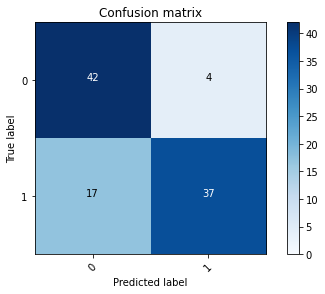

2022-07-06 19:06:32 - [Epoch Train: 23] loss: 0.0308, auc: 0.9999, acc: 0.9909, time: 21.00 s            
2022-07-06 19:06:32 - [Epoch Valid: 23] loss: 1.0330, auc: 0.8756, acc: 0.7685, time: 5.00 s


 15%|██████▍                                   | 23/150 [10:28<58:22, 27.58s/it]

2022-07-06 19:06:32 - EPOCH: 24
2022-07-06 19:06:33 - Train Step 10/438, train_loss: 0.0006
2022-07-06 19:06:34 - Train Step 20/438, train_loss: 0.0004
2022-07-06 19:06:34 - Train Step 30/438, train_loss: 0.0152
2022-07-06 19:06:34 - Train Step 40/438, train_loss: 0.0206
2022-07-06 19:06:35 - Train Step 50/438, train_loss: 0.0394
2022-07-06 19:06:35 - Train Step 60/438, train_loss: 0.0360
2022-07-06 19:06:36 - Train Step 70/438, train_loss: 0.0309
2022-07-06 19:06:36 - Train Step 80/438, train_loss: 0.0282
2022-07-06 19:06:37 - Train Step 90/438, train_loss: 0.0255
2022-07-06 19:06:38 - Train Step 100/438, train_loss: 0.0260
2022-07-06 19:06:38 - Train Step 110/438, train_loss: 0.0251
2022-07-06 19:06:39 - Train Step 120/438, train_loss: 0.0261
2022-07-06 19:06:39 - Train Step 130/438, train_loss: 0.0247
2022-07-06 19:06:40 - Train Step 140/438, train_loss: 0.0235
2022-07-06 19:06:40 - Train Step 150/438, train_loss: 0.0236
2022-07-06 19:06:41 - Train Step 160/438, train_loss: 0.0224
2

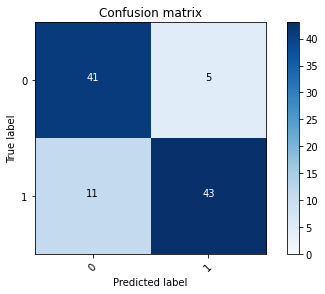

2022-07-06 19:07:01 - [Epoch Train: 24] loss: 0.0238, auc: 0.9998, acc: 0.9886, time: 22.00 s            
2022-07-06 19:07:01 - [Epoch Valid: 24] loss: 1.0651, auc: 0.8732, acc: 0.8148, time: 5.00 s
2022-07-06 19:07:01 - acc improved from 0.7963 to 0.8148. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e24-loss1.065-acc0.815-auc0.873.pth'


 16%|██████▋                                   | 24/150 [10:56<58:20, 27.78s/it]

2022-07-06 19:07:01 - EPOCH: 25
2022-07-06 19:07:01 - Train Step 10/438, train_loss: 0.0243
2022-07-06 19:07:02 - Train Step 20/438, train_loss: 0.0354
2022-07-06 19:07:02 - Train Step 30/438, train_loss: 0.0245
2022-07-06 19:07:03 - Train Step 40/438, train_loss: 0.0461
2022-07-06 19:07:03 - Train Step 50/438, train_loss: 0.0485
2022-07-06 19:07:04 - Train Step 60/438, train_loss: 0.0519
2022-07-06 19:07:04 - Train Step 70/438, train_loss: 0.0493
2022-07-06 19:07:05 - Train Step 80/438, train_loss: 0.0531
2022-07-06 19:07:05 - Train Step 90/438, train_loss: 0.0474
2022-07-06 19:07:06 - Train Step 100/438, train_loss: 0.0442
2022-07-06 19:07:06 - Train Step 110/438, train_loss: 0.0409
2022-07-06 19:07:07 - Train Step 120/438, train_loss: 0.0377
2022-07-06 19:07:07 - Train Step 130/438, train_loss: 0.0402
2022-07-06 19:07:08 - Train Step 140/438, train_loss: 0.0386
2022-07-06 19:07:09 - Train Step 150/438, train_loss: 0.0362
2022-07-06 19:07:09 - Train Step 160/438, train_loss: 0.0364
2

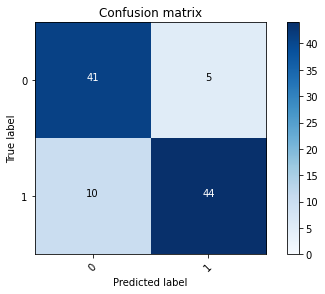

2022-07-06 19:07:29 - [Epoch Train: 25] loss: 0.0287, auc: 0.9998, acc: 0.9886, time: 22.00 s            
2022-07-06 19:07:29 - [Epoch Valid: 25] loss: 1.0686, auc: 0.8768, acc: 0.8241, time: 5.00 s
2022-07-06 19:07:29 - acc improved from 0.8148 to 0.8241. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAAlternativeClassifierSingle2D-DW-SO-KLF_Jul06_18-56-04/RSNAAlternativeClassifierSingle2D-DW-SO-KLF-e25-loss1.069-acc0.824-auc0.877.pth'


 17%|███████                                   | 25/150 [11:24<58:20, 28.01s/it]

2022-07-06 19:07:29 - EPOCH: 26
2022-07-06 19:07:30 - Train Step 10/438, train_loss: 0.0164
2022-07-06 19:07:30 - Train Step 20/438, train_loss: 0.0098
2022-07-06 19:07:31 - Train Step 30/438, train_loss: 0.0074
2022-07-06 19:07:31 - Train Step 40/438, train_loss: 0.0099
2022-07-06 19:07:32 - Train Step 50/438, train_loss: 0.0153
2022-07-06 19:07:32 - Train Step 60/438, train_loss: 0.0136
2022-07-06 19:07:33 - Train Step 70/438, train_loss: 0.0118
2022-07-06 19:07:33 - Train Step 80/438, train_loss: 0.0115
2022-07-06 19:07:34 - Train Step 90/438, train_loss: 0.0202
2022-07-06 19:07:34 - Train Step 100/438, train_loss: 0.0182
2022-07-06 19:07:35 - Train Step 110/438, train_loss: 0.0181
2022-07-06 19:07:35 - Train Step 120/438, train_loss: 0.0199
2022-07-06 19:07:36 - Train Step 130/438, train_loss: 0.0224
2022-07-06 19:07:36 - Train Step 140/438, train_loss: 0.0219
2022-07-06 19:07:37 - Train Step 150/438, train_loss: 0.0206
2022-07-06 19:07:37 - Train Step 160/438, train_loss: 0.0225
2

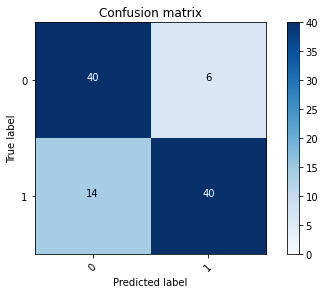

2022-07-06 19:07:56 - [Epoch Train: 26] loss: 0.0238, auc: 0.9999, acc: 0.9909, time: 21.00 s            
2022-07-06 19:07:56 - [Epoch Valid: 26] loss: 1.1431, auc: 0.8740, acc: 0.7778, time: 5.00 s


 17%|███████▎                                  | 26/150 [11:51<57:01, 27.59s/it]

2022-07-06 19:07:56 - EPOCH: 27
2022-07-06 19:07:56 - Train Step 10/438, train_loss: 0.0034
2022-07-06 19:07:57 - Train Step 20/438, train_loss: 0.0220
2022-07-06 19:07:57 - Train Step 30/438, train_loss: 0.0443
2022-07-06 19:07:58 - Train Step 40/438, train_loss: 0.0359
2022-07-06 19:07:58 - Train Step 50/438, train_loss: 0.0290
2022-07-06 19:07:59 - Train Step 60/438, train_loss: 0.0242
2022-07-06 19:07:59 - Train Step 70/438, train_loss: 0.0210
2022-07-06 19:08:00 - Train Step 80/438, train_loss: 0.0191
2022-07-06 19:08:00 - Train Step 90/438, train_loss: 0.0172
2022-07-06 19:08:01 - Train Step 100/438, train_loss: 0.0160
2022-07-06 19:08:01 - Train Step 110/438, train_loss: 0.0146
2022-07-06 19:08:02 - Train Step 120/438, train_loss: 0.0163
2022-07-06 19:08:02 - Train Step 130/438, train_loss: 0.0152
2022-07-06 19:08:03 - Train Step 140/438, train_loss: 0.0141
2022-07-06 19:08:03 - Train Step 150/438, train_loss: 0.0135
2022-07-06 19:08:04 - Train Step 160/438, train_loss: 0.0129
2

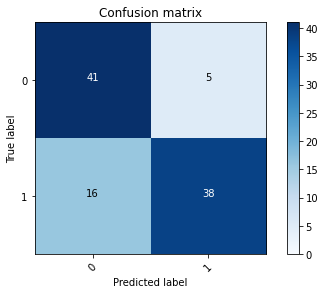

2022-07-06 19:08:24 - [Epoch Train: 27] loss: 0.0242, auc: 0.9999, acc: 0.9863, time: 22.00 s            
2022-07-06 19:08:24 - [Epoch Valid: 27] loss: 1.3158, auc: 0.8865, acc: 0.7685, time: 5.00 s


 18%|███████▌                                  | 27/150 [12:19<56:48, 27.71s/it]

2022-07-06 19:08:24 - EPOCH: 28
2022-07-06 19:08:24 - Train Step 10/438, train_loss: 0.0950
2022-07-06 19:08:25 - Train Step 20/438, train_loss: 0.0483
2022-07-06 19:08:25 - Train Step 30/438, train_loss: 0.0526
2022-07-06 19:08:26 - Train Step 40/438, train_loss: 0.0395
2022-07-06 19:08:26 - Train Step 50/438, train_loss: 0.0406
2022-07-06 19:08:27 - Train Step 60/438, train_loss: 0.0342
2022-07-06 19:08:27 - Train Step 70/438, train_loss: 0.0299
2022-07-06 19:08:28 - Train Step 80/438, train_loss: 0.0267
2022-07-06 19:08:28 - Train Step 90/438, train_loss: 0.0240
2022-07-06 19:08:29 - Train Step 100/438, train_loss: 0.0299
2022-07-06 19:08:29 - Train Step 110/438, train_loss: 0.0336
2022-07-06 19:08:30 - Train Step 120/438, train_loss: 0.0317
2022-07-06 19:08:30 - Train Step 130/438, train_loss: 0.0293
2022-07-06 19:08:31 - Train Step 140/438, train_loss: 0.0309
2022-07-06 19:08:31 - Train Step 150/438, train_loss: 0.0290
2022-07-06 19:08:32 - Train Step 160/438, train_loss: 0.0273
2

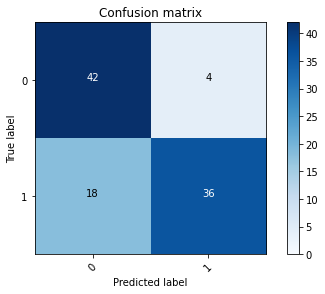

2022-07-06 19:08:52 - [Epoch Train: 28] loss: 0.0245, auc: 0.9999, acc: 0.9909, time: 22.00 s            
2022-07-06 19:08:52 - [Epoch Valid: 28] loss: 1.4615, auc: 0.8684, acc: 0.7778, time: 5.00 s


 19%|███████▊                                  | 28/150 [12:47<56:42, 27.89s/it]

2022-07-06 19:08:52 - EPOCH: 29
2022-07-06 19:08:53 - Train Step 10/438, train_loss: 0.0024
2022-07-06 19:08:53 - Train Step 20/438, train_loss: 0.0035
2022-07-06 19:08:54 - Train Step 30/438, train_loss: 0.0032
2022-07-06 19:08:54 - Train Step 40/438, train_loss: 0.0027
2022-07-06 19:08:55 - Train Step 50/438, train_loss: 0.0024
2022-07-06 19:08:55 - Train Step 60/438, train_loss: 0.0040
2022-07-06 19:08:56 - Train Step 70/438, train_loss: 0.0039
2022-07-06 19:08:56 - Train Step 80/438, train_loss: 0.0087
2022-07-06 19:08:57 - Train Step 90/438, train_loss: 0.0083
2022-07-06 19:08:57 - Train Step 100/438, train_loss: 0.0086
2022-07-06 19:08:58 - Train Step 110/438, train_loss: 0.0098
2022-07-06 19:08:58 - Train Step 120/438, train_loss: 0.0095
2022-07-06 19:08:59 - Train Step 130/438, train_loss: 0.0088
2022-07-06 19:08:59 - Train Step 140/438, train_loss: 0.0082
2022-07-06 19:08:59 - Train Step 150/438, train_loss: 0.0078
2022-07-06 19:09:00 - Train Step 160/438, train_loss: 0.0078
2

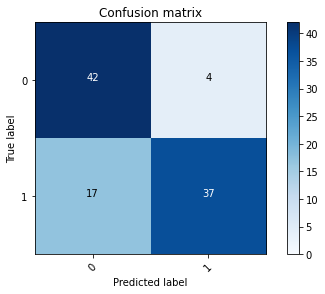

2022-07-06 19:09:19 - [Epoch Train: 29] loss: 0.0329, auc: 0.9985, acc: 0.9863, time: 21.00 s            
2022-07-06 19:09:19 - [Epoch Valid: 29] loss: 1.0559, auc: 0.8861, acc: 0.7685, time: 5.00 s


 19%|████████                                  | 29/150 [13:14<55:28, 27.51s/it]

2022-07-06 19:09:19 - EPOCH: 30
2022-07-06 19:09:19 - Train Step 10/438, train_loss: 0.0008
2022-07-06 19:09:20 - Train Step 20/438, train_loss: 0.0289
2022-07-06 19:09:20 - Train Step 30/438, train_loss: 0.0219
2022-07-06 19:09:21 - Train Step 40/438, train_loss: 0.0413
2022-07-06 19:09:21 - Train Step 50/438, train_loss: 0.0339
2022-07-06 19:09:22 - Train Step 60/438, train_loss: 0.0483
2022-07-06 19:09:22 - Train Step 70/438, train_loss: 0.0418
2022-07-06 19:09:23 - Train Step 80/438, train_loss: 0.0378
2022-07-06 19:09:23 - Train Step 90/438, train_loss: 0.0339
2022-07-06 19:09:24 - Train Step 100/438, train_loss: 0.0411
2022-07-06 19:09:24 - Train Step 110/438, train_loss: 0.0375
2022-07-06 19:09:25 - Train Step 120/438, train_loss: 0.0354
2022-07-06 19:09:25 - Train Step 130/438, train_loss: 0.0339
2022-07-06 19:09:26 - Train Step 140/438, train_loss: 0.0317
2022-07-06 19:09:26 - Train Step 150/438, train_loss: 0.0346
2022-07-06 19:09:27 - Train Step 160/438, train_loss: 0.0327
2

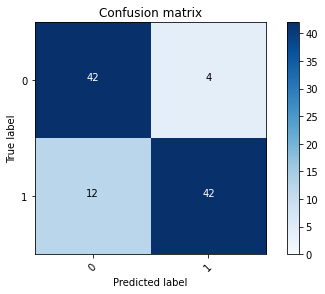

2022-07-06 19:09:45 - [Epoch Train: 30] loss: 0.0232, auc: 0.9999, acc: 0.9886, time: 21.00 s            
2022-07-06 19:09:45 - [Epoch Valid: 30] loss: 1.1767, auc: 0.8796, acc: 0.8148, time: 5.00 s


 20%|████████▍                                 | 30/150 [13:40<54:27, 27.23s/it]

2022-07-06 19:09:45 - EPOCH: 31
2022-07-06 19:09:46 - Train Step 10/438, train_loss: 0.0019
2022-07-06 19:09:46 - Train Step 20/438, train_loss: 0.0011
2022-07-06 19:09:47 - Train Step 30/438, train_loss: 0.0023
2022-07-06 19:09:47 - Train Step 40/438, train_loss: 0.0018
2022-07-06 19:09:48 - Train Step 50/438, train_loss: 0.0030
2022-07-06 19:09:48 - Train Step 60/438, train_loss: 0.0729
2022-07-06 19:09:49 - Train Step 70/438, train_loss: 0.0626
2022-07-06 19:09:49 - Train Step 80/438, train_loss: 0.0618
2022-07-06 19:09:50 - Train Step 90/438, train_loss: 0.0563
2022-07-06 19:09:50 - Train Step 100/438, train_loss: 0.0513
2022-07-06 19:09:51 - Train Step 110/438, train_loss: 0.0467
2022-07-06 19:09:51 - Train Step 120/438, train_loss: 0.0461
2022-07-06 19:09:52 - Train Step 130/438, train_loss: 0.0426
2022-07-06 19:09:52 - Train Step 140/438, train_loss: 0.0451
2022-07-06 19:09:53 - Train Step 150/438, train_loss: 0.0430
2022-07-06 19:09:53 - Train Step 160/438, train_loss: 0.0404
2

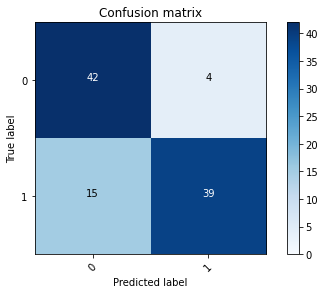

2022-07-06 19:10:13 - [Epoch Train: 31] loss: 0.0253, auc: 0.9990, acc: 0.9909, time: 22.00 s            
2022-07-06 19:10:13 - [Epoch Valid: 31] loss: 1.3438, auc: 0.8833, acc: 0.7870, time: 5.00 s


 21%|████████▋                                 | 31/150 [14:08<54:22, 27.42s/it]

2022-07-06 19:10:13 - EPOCH: 32
2022-07-06 19:10:14 - Train Step 10/438, train_loss: 0.0000
2022-07-06 19:10:14 - Train Step 20/438, train_loss: 0.0368
2022-07-06 19:10:15 - Train Step 30/438, train_loss: 0.0272
2022-07-06 19:10:15 - Train Step 40/438, train_loss: 0.0220
2022-07-06 19:10:16 - Train Step 50/438, train_loss: 0.0177
2022-07-06 19:10:16 - Train Step 60/438, train_loss: 0.0189
2022-07-06 19:10:17 - Train Step 70/438, train_loss: 0.0168
2022-07-06 19:10:17 - Train Step 80/438, train_loss: 0.0148
2022-07-06 19:10:18 - Train Step 90/438, train_loss: 0.0200
2022-07-06 19:10:18 - Train Step 100/438, train_loss: 0.0186
2022-07-06 19:10:19 - Train Step 110/438, train_loss: 0.0169
2022-07-06 19:10:19 - Train Step 120/438, train_loss: 0.0170
2022-07-06 19:10:20 - Train Step 130/438, train_loss: 0.0168
2022-07-06 19:10:20 - Train Step 140/438, train_loss: 0.0156
2022-07-06 19:10:21 - Train Step 150/438, train_loss: 0.0169
2022-07-06 19:10:21 - Train Step 160/438, train_loss: 0.0159
2

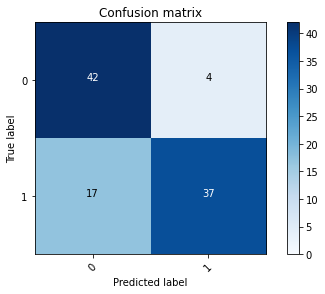

2022-07-06 19:10:40 - [Epoch Train: 32] loss: 0.0139, auc: 0.9999, acc: 0.9886, time: 21.00 s            
2022-07-06 19:10:40 - [Epoch Valid: 32] loss: 1.3736, auc: 0.8814, acc: 0.7685, time: 5.00 s


 21%|████████▉                                 | 32/150 [14:35<53:35, 27.25s/it]

2022-07-06 19:10:40 - EPOCH: 33
2022-07-06 19:10:41 - Train Step 10/438, train_loss: 0.0910
2022-07-06 19:10:41 - Train Step 20/438, train_loss: 0.0491
2022-07-06 19:10:42 - Train Step 30/438, train_loss: 0.0336
2022-07-06 19:10:42 - Train Step 40/438, train_loss: 0.0253
2022-07-06 19:10:43 - Train Step 50/438, train_loss: 0.0203
2022-07-06 19:10:43 - Train Step 60/438, train_loss: 0.0171
2022-07-06 19:10:44 - Train Step 70/438, train_loss: 0.0154
2022-07-06 19:10:44 - Train Step 80/438, train_loss: 0.0139
2022-07-06 19:10:45 - Train Step 90/438, train_loss: 0.0125
2022-07-06 19:10:45 - Train Step 100/438, train_loss: 0.0113
2022-07-06 19:10:45 - Train Step 110/438, train_loss: 0.0104
2022-07-06 19:10:46 - Train Step 120/438, train_loss: 0.0115
2022-07-06 19:10:46 - Train Step 130/438, train_loss: 0.0115
2022-07-06 19:10:47 - Train Step 140/438, train_loss: 0.0107
2022-07-06 19:10:47 - Train Step 150/438, train_loss: 0.0106
2022-07-06 19:10:48 - Train Step 160/438, train_loss: 0.0298
2

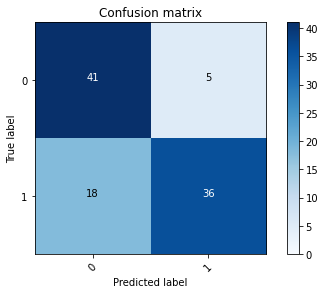

2022-07-06 19:11:07 - [Epoch Train: 33] loss: 0.0270, auc: 0.9999, acc: 0.9840, time: 21.00 s            
2022-07-06 19:11:07 - [Epoch Valid: 33] loss: 1.3051, auc: 0.8766, acc: 0.7500, time: 5.00 s


 22%|█████████▏                                | 33/150 [15:02<52:59, 27.18s/it]

2022-07-06 19:11:07 - EPOCH: 34
2022-07-06 19:11:08 - Train Step 10/438, train_loss: 0.0187
2022-07-06 19:11:08 - Train Step 20/438, train_loss: 0.0114
2022-07-06 19:11:09 - Train Step 30/438, train_loss: 0.0079
2022-07-06 19:11:09 - Train Step 40/438, train_loss: 0.0091
2022-07-06 19:11:10 - Train Step 50/438, train_loss: 0.0073
2022-07-06 19:11:10 - Train Step 60/438, train_loss: 0.0063
2022-07-06 19:11:10 - Train Step 70/438, train_loss: 0.0057
2022-07-06 19:11:11 - Train Step 80/438, train_loss: 0.0051
2022-07-06 19:11:11 - Train Step 90/438, train_loss: 0.0048
2022-07-06 19:11:12 - Train Step 100/438, train_loss: 0.0075
2022-07-06 19:11:12 - Train Step 110/438, train_loss: 0.0299
2022-07-06 19:11:13 - Train Step 120/438, train_loss: 0.0275
2022-07-06 19:11:13 - Train Step 130/438, train_loss: 0.0257
2022-07-06 19:11:14 - Train Step 140/438, train_loss: 0.0259
2022-07-06 19:11:14 - Train Step 150/438, train_loss: 0.0243
2022-07-06 19:11:15 - Train Step 160/438, train_loss: 0.0231
2

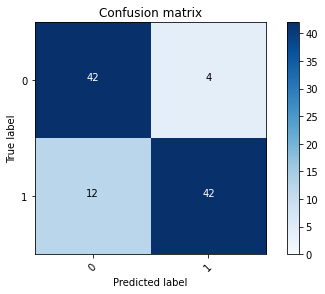

2022-07-06 19:11:34 - [Epoch Train: 34] loss: 0.0230, auc: 0.9996, acc: 0.9840, time: 21.00 s            
2022-07-06 19:11:34 - [Epoch Valid: 34] loss: 1.3016, auc: 0.8933, acc: 0.8148, time: 5.00 s


 23%|█████████▌                                | 34/150 [15:29<52:17, 27.05s/it]

2022-07-06 19:11:34 - EPOCH: 35
2022-07-06 19:11:34 - Train Step 10/438, train_loss: 0.0003
2022-07-06 19:11:35 - Train Step 20/438, train_loss: 0.0156
2022-07-06 19:11:35 - Train Step 30/438, train_loss: 0.0110
2022-07-06 19:11:36 - Train Step 40/438, train_loss: 0.0086
2022-07-06 19:11:36 - Train Step 50/438, train_loss: 0.0071
2022-07-06 19:11:37 - Train Step 60/438, train_loss: 0.0185
2022-07-06 19:11:37 - Train Step 70/438, train_loss: 0.0159
2022-07-06 19:11:38 - Train Step 80/438, train_loss: 0.0140
2022-07-06 19:11:38 - Train Step 90/438, train_loss: 0.0177
2022-07-06 19:11:39 - Train Step 100/438, train_loss: 0.0176
2022-07-06 19:11:39 - Train Step 110/438, train_loss: 0.0161
2022-07-06 19:11:40 - Train Step 120/438, train_loss: 0.0147
2022-07-06 19:11:40 - Train Step 130/438, train_loss: 0.0145
2022-07-06 19:11:41 - Train Step 140/438, train_loss: 0.0136
2022-07-06 19:11:41 - Train Step 150/438, train_loss: 0.0132
2022-07-06 19:11:42 - Train Step 160/438, train_loss: 0.0127
2

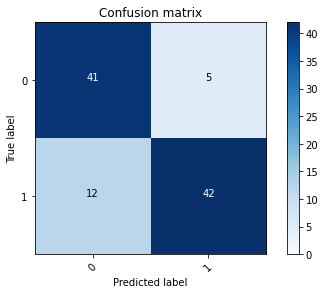

2022-07-06 19:12:01 - [Epoch Train: 35] loss: 0.0175, auc: 0.9999, acc: 0.9932, time: 21.00 s            
2022-07-06 19:12:01 - [Epoch Valid: 35] loss: 1.3130, auc: 0.8806, acc: 0.8056, time: 5.00 s


 23%|█████████▊                                | 35/150 [15:56<51:56, 27.10s/it]

2022-07-06 19:12:01 - EPOCH: 36
2022-07-06 19:12:02 - Train Step 10/438, train_loss: 0.0016
2022-07-06 19:12:02 - Train Step 20/438, train_loss: 0.0013
2022-07-06 19:12:03 - Train Step 30/438, train_loss: 0.0010
2022-07-06 19:12:03 - Train Step 40/438, train_loss: 0.0045
2022-07-06 19:12:04 - Train Step 50/438, train_loss: 0.0084
2022-07-06 19:12:04 - Train Step 60/438, train_loss: 0.0088
2022-07-06 19:12:05 - Train Step 70/438, train_loss: 0.0089
2022-07-06 19:12:05 - Train Step 80/438, train_loss: 0.0082
2022-07-06 19:12:05 - Train Step 90/438, train_loss: 0.0074
2022-07-06 19:12:06 - Train Step 100/438, train_loss: 0.0107
2022-07-06 19:12:06 - Train Step 110/438, train_loss: 0.0097
2022-07-06 19:12:07 - Train Step 120/438, train_loss: 0.0096
2022-07-06 19:12:07 - Train Step 130/438, train_loss: 0.0164
2022-07-06 19:12:08 - Train Step 140/438, train_loss: 0.0194
2022-07-06 19:12:08 - Train Step 150/438, train_loss: 0.0182
2022-07-06 19:12:09 - Train Step 160/438, train_loss: 0.0172
2

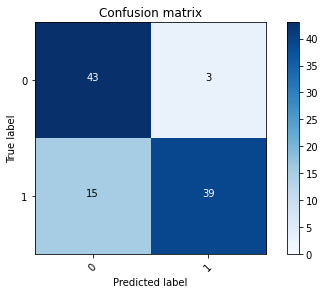

2022-07-06 19:12:28 - [Epoch Train: 36] loss: 0.0125, auc: 0.9999, acc: 0.9932, time: 21.00 s            
2022-07-06 19:12:28 - [Epoch Valid: 36] loss: 1.7795, auc: 0.8728, acc: 0.8148, time: 5.00 s


 24%|██████████                                | 36/150 [16:23<51:12, 26.95s/it]

2022-07-06 19:12:28 - EPOCH: 37
2022-07-06 19:12:28 - Train Step 10/438, train_loss: 0.0229
2022-07-06 19:12:29 - Train Step 20/438, train_loss: 0.0678
2022-07-06 19:12:29 - Train Step 30/438, train_loss: 0.0468
2022-07-06 19:12:30 - Train Step 40/438, train_loss: 0.0374
2022-07-06 19:12:30 - Train Step 50/438, train_loss: 0.0300
2022-07-06 19:12:31 - Train Step 60/438, train_loss: 0.0252
2022-07-06 19:12:31 - Train Step 70/438, train_loss: 0.0223
2022-07-06 19:12:32 - Train Step 80/438, train_loss: 0.0232
2022-07-06 19:12:32 - Train Step 90/438, train_loss: 0.0216
2022-07-06 19:12:33 - Train Step 100/438, train_loss: 0.0194
2022-07-06 19:12:33 - Train Step 110/438, train_loss: 0.0260
2022-07-06 19:12:34 - Train Step 120/438, train_loss: 0.0241
2022-07-06 19:12:34 - Train Step 130/438, train_loss: 0.0242
2022-07-06 19:12:35 - Train Step 140/438, train_loss: 0.0226
2022-07-06 19:12:35 - Train Step 150/438, train_loss: 0.0213
2022-07-06 19:12:36 - Train Step 160/438, train_loss: 0.0200
2

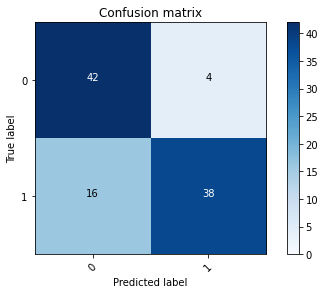

2022-07-06 19:12:55 - [Epoch Train: 37] loss: 0.0122, auc: 1.0000, acc: 0.9954, time: 21.00 s            
2022-07-06 19:12:55 - [Epoch Valid: 37] loss: 1.5406, auc: 0.8746, acc: 0.7778, time: 5.00 s


 25%|██████████▎                               | 37/150 [16:50<50:54, 27.03s/it]

2022-07-06 19:12:55 - EPOCH: 38
2022-07-06 19:12:55 - Train Step 10/438, train_loss: 0.0040
2022-07-06 19:12:56 - Train Step 20/438, train_loss: 0.0022
2022-07-06 19:12:56 - Train Step 30/438, train_loss: 0.0082
2022-07-06 19:12:57 - Train Step 40/438, train_loss: 0.0081
2022-07-06 19:12:57 - Train Step 50/438, train_loss: 0.0309
2022-07-06 19:12:58 - Train Step 60/438, train_loss: 0.0258
2022-07-06 19:12:58 - Train Step 70/438, train_loss: 0.0308
2022-07-06 19:12:59 - Train Step 80/438, train_loss: 0.0275
2022-07-06 19:12:59 - Train Step 90/438, train_loss: 0.0244
2022-07-06 19:13:00 - Train Step 100/438, train_loss: 0.0387
2022-07-06 19:13:00 - Train Step 110/438, train_loss: 0.0355
2022-07-06 19:13:01 - Train Step 120/438, train_loss: 0.0325
2022-07-06 19:13:01 - Train Step 130/438, train_loss: 0.0302
2022-07-06 19:13:02 - Train Step 140/438, train_loss: 0.0280
2022-07-06 19:13:02 - Train Step 150/438, train_loss: 0.0262
2022-07-06 19:13:03 - Train Step 160/438, train_loss: 0.0245
2

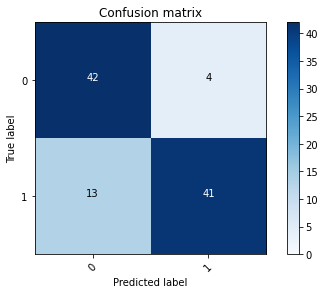

2022-07-06 19:13:22 - [Epoch Train: 38] loss: 0.0192, auc: 0.9997, acc: 0.9840, time: 21.00 s            
2022-07-06 19:13:22 - [Epoch Valid: 38] loss: 1.5356, auc: 0.8758, acc: 0.8056, time: 5.00 s


 25%|██████████▋                               | 38/150 [17:17<50:32, 27.08s/it]

2022-07-06 19:13:22 - EPOCH: 39
2022-07-06 19:13:23 - Train Step 10/438, train_loss: 0.0000
2022-07-06 19:13:23 - Train Step 20/438, train_loss: 0.0251
2022-07-06 19:13:24 - Train Step 30/438, train_loss: 0.0168
2022-07-06 19:13:24 - Train Step 40/438, train_loss: 0.0135
2022-07-06 19:13:25 - Train Step 50/438, train_loss: 0.0108
2022-07-06 19:13:25 - Train Step 60/438, train_loss: 0.0090
2022-07-06 19:13:26 - Train Step 70/438, train_loss: 0.0081
2022-07-06 19:13:26 - Train Step 80/438, train_loss: 0.0071
2022-07-06 19:13:26 - Train Step 90/438, train_loss: 0.0063
2022-07-06 19:13:27 - Train Step 100/438, train_loss: 0.0057
2022-07-06 19:13:27 - Train Step 110/438, train_loss: 0.0052
2022-07-06 19:13:28 - Train Step 120/438, train_loss: 0.0060
2022-07-06 19:13:28 - Train Step 130/438, train_loss: 0.0125
2022-07-06 19:13:29 - Train Step 140/438, train_loss: 0.0196
2022-07-06 19:13:29 - Train Step 150/438, train_loss: 0.0184
2022-07-06 19:13:30 - Train Step 160/438, train_loss: 0.0173
2

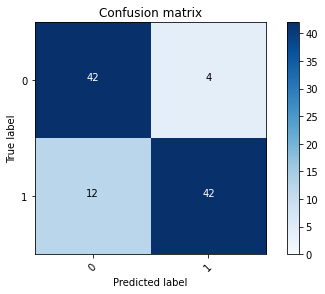

2022-07-06 19:13:49 - [Epoch Train: 39] loss: 0.0151, auc: 0.9997, acc: 0.9909, time: 21.00 s            
2022-07-06 19:13:49 - [Epoch Valid: 39] loss: 1.6753, auc: 0.8873, acc: 0.8148, time: 5.00 s


 26%|██████████▉                               | 39/150 [17:44<50:08, 27.10s/it]

2022-07-06 19:13:49 - EPOCH: 40
2022-07-06 19:13:50 - Train Step 10/438, train_loss: 0.0034
2022-07-06 19:13:50 - Train Step 20/438, train_loss: 0.0071
2022-07-06 19:13:51 - Train Step 30/438, train_loss: 0.0088
2022-07-06 19:13:51 - Train Step 40/438, train_loss: 0.0067
2022-07-06 19:13:52 - Train Step 50/438, train_loss: 0.0064
2022-07-06 19:13:52 - Train Step 60/438, train_loss: 0.0056
2022-07-06 19:13:53 - Train Step 70/438, train_loss: 0.0058
2022-07-06 19:13:53 - Train Step 80/438, train_loss: 0.0052
2022-07-06 19:13:54 - Train Step 90/438, train_loss: 0.0047
2022-07-06 19:13:54 - Train Step 100/438, train_loss: 0.0042
2022-07-06 19:13:55 - Train Step 110/438, train_loss: 0.0038
2022-07-06 19:13:55 - Train Step 120/438, train_loss: 0.0035
2022-07-06 19:13:55 - Train Step 130/438, train_loss: 0.0033
2022-07-06 19:13:56 - Train Step 140/438, train_loss: 0.0031
2022-07-06 19:13:56 - Train Step 150/438, train_loss: 0.0029
2022-07-06 19:13:57 - Train Step 160/438, train_loss: 0.0027
2

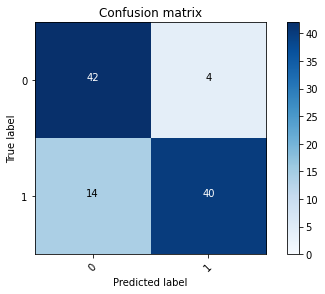

2022-07-06 19:14:16 - [Epoch Train: 40] loss: 0.0177, auc: 0.9997, acc: 0.9886, time: 21.00 s            
2022-07-06 19:14:16 - [Epoch Valid: 40] loss: 1.4599, auc: 0.8764, acc: 0.7963, time: 5.00 s


 27%|███████████▏                              | 40/150 [18:11<49:32, 27.02s/it]

2022-07-06 19:14:16 - EPOCH: 41
2022-07-06 19:14:17 - Train Step 10/438, train_loss: 0.0509
2022-07-06 19:14:17 - Train Step 20/438, train_loss: 0.0257
2022-07-06 19:14:18 - Train Step 30/438, train_loss: 0.0188
2022-07-06 19:14:18 - Train Step 40/438, train_loss: 0.0148
2022-07-06 19:14:19 - Train Step 50/438, train_loss: 0.0119
2022-07-06 19:14:19 - Train Step 60/438, train_loss: 0.0517
2022-07-06 19:14:20 - Train Step 70/438, train_loss: 0.0452
2022-07-06 19:14:20 - Train Step 80/438, train_loss: 0.0414
2022-07-06 19:14:21 - Train Step 90/438, train_loss: 0.0488
2022-07-06 19:14:21 - Train Step 100/438, train_loss: 0.0541
2022-07-06 19:14:22 - Train Step 110/438, train_loss: 0.0497
2022-07-06 19:14:22 - Train Step 120/438, train_loss: 0.0458
2022-07-06 19:14:23 - Train Step 130/438, train_loss: 0.0424
2022-07-06 19:14:23 - Train Step 140/438, train_loss: 0.0394
2022-07-06 19:14:24 - Train Step 150/438, train_loss: 0.0373
2022-07-06 19:14:24 - Train Step 160/438, train_loss: 0.0352
2

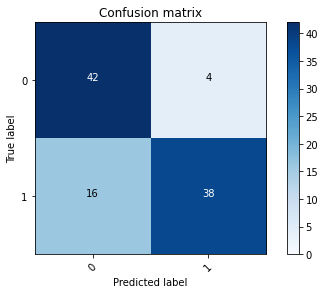

2022-07-06 19:14:44 - [Epoch Train: 41] loss: 0.0320, auc: 0.9994, acc: 0.9817, time: 22.00 s            
2022-07-06 19:14:44 - [Epoch Valid: 41] loss: 1.5672, auc: 0.8818, acc: 0.7778, time: 5.00 s


 27%|███████████▍                              | 41/150 [18:39<49:42, 27.36s/it]

2022-07-06 19:14:44 - EPOCH: 42
2022-07-06 19:14:45 - Train Step 10/438, train_loss: 0.0116
2022-07-06 19:14:45 - Train Step 20/438, train_loss: 0.0058
2022-07-06 19:14:46 - Train Step 30/438, train_loss: 0.0042
2022-07-06 19:14:46 - Train Step 40/438, train_loss: 0.0069
2022-07-06 19:14:47 - Train Step 50/438, train_loss: 0.0077
2022-07-06 19:14:47 - Train Step 60/438, train_loss: 0.0090
2022-07-06 19:14:48 - Train Step 70/438, train_loss: 0.0082
2022-07-06 19:14:48 - Train Step 80/438, train_loss: 0.0072
2022-07-06 19:14:49 - Train Step 90/438, train_loss: 0.0066
2022-07-06 19:14:49 - Train Step 100/438, train_loss: 0.0076
2022-07-06 19:14:50 - Train Step 110/438, train_loss: 0.0081
2022-07-06 19:14:50 - Train Step 120/438, train_loss: 0.0080
2022-07-06 19:14:51 - Train Step 130/438, train_loss: 0.0075
2022-07-06 19:14:51 - Train Step 140/438, train_loss: 0.0070
2022-07-06 19:14:52 - Train Step 150/438, train_loss: 0.0066
2022-07-06 19:14:52 - Train Step 160/438, train_loss: 0.0062
2

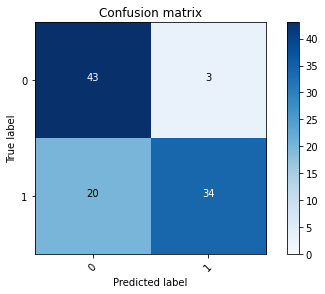

2022-07-06 19:15:12 - [Epoch Train: 42] loss: 0.0121, auc: 0.9999, acc: 0.9954, time: 22.00 s            
2022-07-06 19:15:12 - [Epoch Valid: 42] loss: 1.8503, auc: 0.8736, acc: 0.7500, time: 5.00 s


 28%|███████████▊                              | 42/150 [19:07<49:43, 27.62s/it]

2022-07-06 19:15:12 - EPOCH: 43
2022-07-06 19:15:13 - Train Step 10/438, train_loss: 0.0035
2022-07-06 19:15:13 - Train Step 20/438, train_loss: 0.0020
2022-07-06 19:15:14 - Train Step 30/438, train_loss: 0.0014
2022-07-06 19:15:14 - Train Step 40/438, train_loss: 0.0138
2022-07-06 19:15:15 - Train Step 50/438, train_loss: 0.0119
2022-07-06 19:15:15 - Train Step 60/438, train_loss: 0.0100
2022-07-06 19:15:16 - Train Step 70/438, train_loss: 0.0089
2022-07-06 19:15:16 - Train Step 80/438, train_loss: 0.0224
2022-07-06 19:15:17 - Train Step 90/438, train_loss: 0.0199
2022-07-06 19:15:17 - Train Step 100/438, train_loss: 0.0179
2022-07-06 19:15:18 - Train Step 110/438, train_loss: 0.0246
2022-07-06 19:15:18 - Train Step 120/438, train_loss: 0.0226
2022-07-06 19:15:19 - Train Step 130/438, train_loss: 0.0210
2022-07-06 19:15:19 - Train Step 140/438, train_loss: 0.0201
2022-07-06 19:15:20 - Train Step 150/438, train_loss: 0.0188
2022-07-06 19:15:20 - Train Step 160/438, train_loss: 0.0194
2

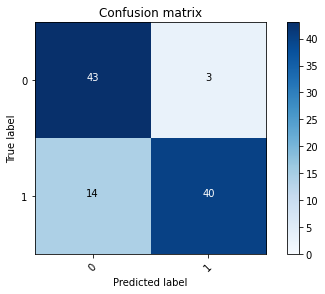

2022-07-06 19:15:39 - [Epoch Train: 43] loss: 0.0205, auc: 0.9996, acc: 0.9863, time: 20.00 s            
2022-07-06 19:15:39 - [Epoch Valid: 43] loss: 1.4389, auc: 0.8945, acc: 0.8056, time: 5.00 s


 29%|████████████                              | 43/150 [19:34<48:47, 27.36s/it]

2022-07-06 19:15:39 - EPOCH: 44
2022-07-06 19:15:40 - Train Step 10/438, train_loss: 0.0124
2022-07-06 19:15:40 - Train Step 20/438, train_loss: 0.0081
2022-07-06 19:15:41 - Train Step 30/438, train_loss: 0.0524
2022-07-06 19:15:41 - Train Step 40/438, train_loss: 0.0395
2022-07-06 19:15:42 - Train Step 50/438, train_loss: 0.0358
2022-07-06 19:15:42 - Train Step 60/438, train_loss: 0.0300
2022-07-06 19:15:43 - Train Step 70/438, train_loss: 0.0280
2022-07-06 19:15:43 - Train Step 80/438, train_loss: 0.0246
2022-07-06 19:15:44 - Train Step 90/438, train_loss: 0.0222
2022-07-06 19:15:44 - Train Step 100/438, train_loss: 0.0218
2022-07-06 19:15:45 - Train Step 110/438, train_loss: 0.0199
2022-07-06 19:15:45 - Train Step 120/438, train_loss: 0.0182
2022-07-06 19:15:46 - Train Step 130/438, train_loss: 0.0169
2022-07-06 19:15:46 - Train Step 140/438, train_loss: 0.0164
2022-07-06 19:15:47 - Train Step 150/438, train_loss: 0.0153
2022-07-06 19:15:47 - Train Step 160/438, train_loss: 0.0149
2

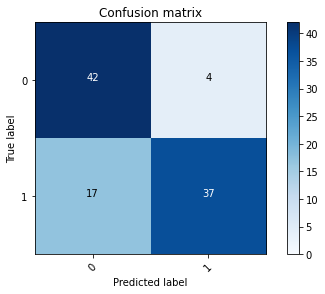

2022-07-06 19:16:06 - [Epoch Train: 44] loss: 0.0171, auc: 1.0000, acc: 0.9932, time: 21.00 s            
2022-07-06 19:16:06 - [Epoch Valid: 44] loss: 1.6011, auc: 0.8915, acc: 0.7685, time: 5.00 s


 29%|████████████▎                             | 44/150 [20:01<48:10, 27.27s/it]

2022-07-06 19:16:06 - EPOCH: 45
2022-07-06 19:16:07 - Train Step 10/438, train_loss: 0.0090
2022-07-06 19:16:07 - Train Step 20/438, train_loss: 0.0163
2022-07-06 19:16:08 - Train Step 30/438, train_loss: 0.0113
2022-07-06 19:16:08 - Train Step 40/438, train_loss: 0.0103
2022-07-06 19:16:09 - Train Step 50/438, train_loss: 0.0092
2022-07-06 19:16:09 - Train Step 60/438, train_loss: 0.0078
2022-07-06 19:16:10 - Train Step 70/438, train_loss: 0.0067
2022-07-06 19:16:10 - Train Step 80/438, train_loss: 0.0071
2022-07-06 19:16:11 - Train Step 90/438, train_loss: 0.0064
2022-07-06 19:16:11 - Train Step 100/438, train_loss: 0.0057
2022-07-06 19:16:12 - Train Step 110/438, train_loss: 0.0052
2022-07-06 19:16:12 - Train Step 120/438, train_loss: 0.0049
2022-07-06 19:16:13 - Train Step 130/438, train_loss: 0.0046
2022-07-06 19:16:13 - Train Step 140/438, train_loss: 0.0048
2022-07-06 19:16:13 - Train Step 150/438, train_loss: 0.0045
2022-07-06 19:16:14 - Train Step 160/438, train_loss: 0.0043
2

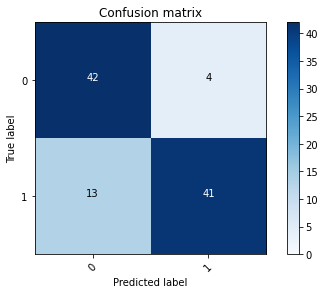

2022-07-06 19:16:33 - [Epoch Train: 45] loss: 0.0114, auc: 1.0000, acc: 0.9932, time: 20.00 s            
2022-07-06 19:16:33 - [Epoch Valid: 45] loss: 1.6663, auc: 0.8961, acc: 0.8056, time: 5.00 s


 30%|████████████▌                             | 45/150 [20:28<47:20, 27.06s/it]

2022-07-06 19:16:33 - EPOCH: 46
2022-07-06 19:16:33 - Train Step 10/438, train_loss: 0.0053
2022-07-06 19:16:34 - Train Step 20/438, train_loss: 0.0027
2022-07-06 19:16:34 - Train Step 30/438, train_loss: 0.0018
2022-07-06 19:16:35 - Train Step 40/438, train_loss: 0.0018
2022-07-06 19:16:35 - Train Step 50/438, train_loss: 0.0015
2022-07-06 19:16:36 - Train Step 60/438, train_loss: 0.0013
2022-07-06 19:16:36 - Train Step 70/438, train_loss: 0.0012
2022-07-06 19:16:37 - Train Step 80/438, train_loss: 0.0069
2022-07-06 19:16:37 - Train Step 90/438, train_loss: 0.0062
2022-07-06 19:16:38 - Train Step 100/438, train_loss: 0.0061
2022-07-06 19:16:38 - Train Step 110/438, train_loss: 0.0056
2022-07-06 19:16:39 - Train Step 120/438, train_loss: 0.0052
2022-07-06 19:16:39 - Train Step 130/438, train_loss: 0.0048
2022-07-06 19:16:40 - Train Step 140/438, train_loss: 0.0132
2022-07-06 19:16:40 - Train Step 150/438, train_loss: 0.0123
2022-07-06 19:16:41 - Train Step 160/438, train_loss: 0.0118
2

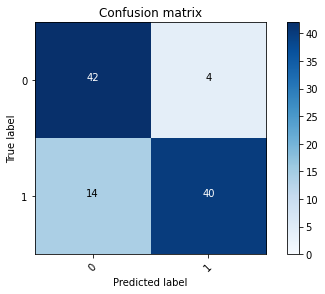

2022-07-06 19:17:00 - [Epoch Train: 46] loss: 0.0138, auc: 0.9998, acc: 0.9863, time: 21.00 s            
2022-07-06 19:17:00 - [Epoch Valid: 46] loss: 1.5251, auc: 0.9006, acc: 0.7963, time: 5.00 s


 31%|████████████▉                             | 46/150 [20:56<47:12, 27.23s/it]

2022-07-06 19:17:00 - EPOCH: 47
2022-07-06 19:17:01 - Train Step 10/438, train_loss: 0.0328
2022-07-06 19:17:01 - Train Step 20/438, train_loss: 0.0212
2022-07-06 19:17:02 - Train Step 30/438, train_loss: 0.0145
2022-07-06 19:17:02 - Train Step 40/438, train_loss: 0.0723
2022-07-06 19:17:03 - Train Step 50/438, train_loss: 0.0623
2022-07-06 19:17:04 - Train Step 60/438, train_loss: 0.0522
2022-07-06 19:17:04 - Train Step 70/438, train_loss: 0.0453
2022-07-06 19:17:05 - Train Step 80/438, train_loss: 0.0396
2022-07-06 19:17:05 - Train Step 90/438, train_loss: 0.0359
2022-07-06 19:17:06 - Train Step 100/438, train_loss: 0.0330
2022-07-06 19:17:06 - Train Step 110/438, train_loss: 0.0300
2022-07-06 19:17:07 - Train Step 120/438, train_loss: 0.0295
2022-07-06 19:17:07 - Train Step 130/438, train_loss: 0.0318
2022-07-06 19:17:08 - Train Step 140/438, train_loss: 0.0303
2022-07-06 19:17:08 - Train Step 150/438, train_loss: 0.0284
2022-07-06 19:17:09 - Train Step 160/438, train_loss: 0.0266
2

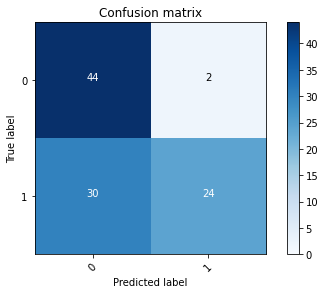

2022-07-06 19:17:29 - [Epoch Train: 47] loss: 0.0361, auc: 0.9994, acc: 0.9817, time: 22.00 s            
2022-07-06 19:17:29 - [Epoch Valid: 47] loss: 2.7138, auc: 0.8545, acc: 0.6852, time: 5.00 s


 31%|█████████████▏                            | 47/150 [21:24<47:20, 27.58s/it]

2022-07-06 19:17:29 - EPOCH: 48
2022-07-06 19:17:29 - Train Step 10/438, train_loss: 0.1498
2022-07-06 19:17:30 - Train Step 20/438, train_loss: 0.0863
2022-07-06 19:17:30 - Train Step 30/438, train_loss: 0.0575
2022-07-06 19:17:31 - Train Step 40/438, train_loss: 0.0442
2022-07-06 19:17:31 - Train Step 50/438, train_loss: 0.0353
2022-07-06 19:17:32 - Train Step 60/438, train_loss: 0.0489
2022-07-06 19:17:32 - Train Step 70/438, train_loss: 0.0421
2022-07-06 19:17:33 - Train Step 80/438, train_loss: 0.0374
2022-07-06 19:17:33 - Train Step 90/438, train_loss: 0.0332
2022-07-06 19:17:34 - Train Step 100/438, train_loss: 0.0299
2022-07-06 19:17:34 - Train Step 110/438, train_loss: 0.0318
2022-07-06 19:17:35 - Train Step 120/438, train_loss: 0.0304
2022-07-06 19:17:35 - Train Step 130/438, train_loss: 0.0282
2022-07-06 19:17:36 - Train Step 140/438, train_loss: 0.0262
2022-07-06 19:17:36 - Train Step 150/438, train_loss: 0.0246
2022-07-06 19:17:37 - Train Step 160/438, train_loss: 0.0237
2

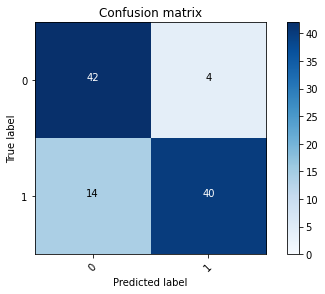

2022-07-06 19:17:55 - [Epoch Train: 48] loss: 0.0214, auc: 0.9999, acc: 0.9886, time: 21.00 s            
2022-07-06 19:17:55 - [Epoch Valid: 48] loss: 1.6531, auc: 0.8808, acc: 0.7963, time: 5.00 s


 32%|█████████████▍                            | 48/150 [21:51<46:25, 27.31s/it]

2022-07-06 19:17:55 - EPOCH: 49
2022-07-06 19:17:56 - Train Step 10/438, train_loss: 0.0009
2022-07-06 19:17:57 - Train Step 20/438, train_loss: 0.0006
2022-07-06 19:17:57 - Train Step 30/438, train_loss: 0.0424
2022-07-06 19:17:57 - Train Step 40/438, train_loss: 0.0319
2022-07-06 19:17:58 - Train Step 50/438, train_loss: 0.0255
2022-07-06 19:17:58 - Train Step 60/438, train_loss: 0.0213
2022-07-06 19:17:59 - Train Step 70/438, train_loss: 0.0201
2022-07-06 19:17:59 - Train Step 80/438, train_loss: 0.0187
2022-07-06 19:18:00 - Train Step 90/438, train_loss: 0.0167
2022-07-06 19:18:00 - Train Step 100/438, train_loss: 0.0151
2022-07-06 19:18:01 - Train Step 110/438, train_loss: 0.0140
2022-07-06 19:18:01 - Train Step 120/438, train_loss: 0.0131
2022-07-06 19:18:02 - Train Step 130/438, train_loss: 0.0125
2022-07-06 19:18:02 - Train Step 140/438, train_loss: 0.0116
2022-07-06 19:18:03 - Train Step 150/438, train_loss: 0.0109
2022-07-06 19:18:04 - Train Step 160/438, train_loss: 0.0102
2

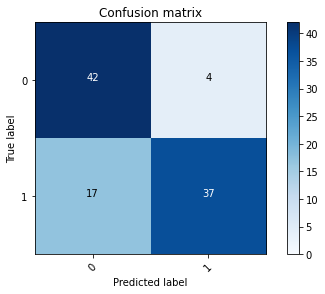

2022-07-06 19:18:23 - [Epoch Train: 49] loss: 0.0191, auc: 0.9999, acc: 0.9909, time: 22.00 s            
2022-07-06 19:18:23 - [Epoch Valid: 49] loss: 1.3488, auc: 0.8770, acc: 0.7685, time: 5.00 s


 33%|█████████████▋                            | 49/150 [22:19<46:19, 27.52s/it]

2022-07-06 19:18:23 - EPOCH: 50
2022-07-06 19:18:24 - Train Step 10/438, train_loss: 0.0491
2022-07-06 19:18:25 - Train Step 20/438, train_loss: 0.0333
2022-07-06 19:18:25 - Train Step 30/438, train_loss: 0.0259
2022-07-06 19:18:26 - Train Step 40/438, train_loss: 0.0197
2022-07-06 19:18:26 - Train Step 50/438, train_loss: 0.0159
2022-07-06 19:18:27 - Train Step 60/438, train_loss: 0.0145
2022-07-06 19:18:27 - Train Step 70/438, train_loss: 0.0128
2022-07-06 19:18:28 - Train Step 80/438, train_loss: 0.0155
2022-07-06 19:18:28 - Train Step 90/438, train_loss: 0.0147
2022-07-06 19:18:29 - Train Step 100/438, train_loss: 0.0236
2022-07-06 19:18:29 - Train Step 110/438, train_loss: 0.0240
2022-07-06 19:18:30 - Train Step 120/438, train_loss: 0.0222
2022-07-06 19:18:30 - Train Step 130/438, train_loss: 0.0206
2022-07-06 19:18:31 - Train Step 140/438, train_loss: 0.0194
2022-07-06 19:18:31 - Train Step 150/438, train_loss: 0.0183
2022-07-06 19:18:32 - Train Step 160/438, train_loss: 0.0174
2

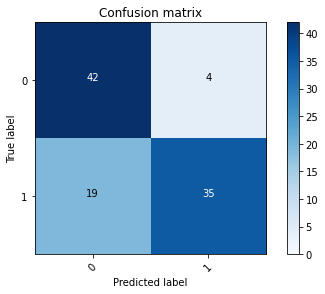

2022-07-06 19:18:51 - [Epoch Train: 50] loss: 0.0108, auc: 1.0000, acc: 0.9977, time: 21.00 s            
2022-07-06 19:18:51 - [Epoch Valid: 50] loss: 1.9245, auc: 0.8764, acc: 0.7500, time: 5.00 s


 33%|██████████████                            | 50/150 [22:46<45:46, 27.46s/it]

2022-07-06 19:18:51 - EPOCH: 51
2022-07-06 19:18:51 - Train Step 10/438, train_loss: 0.0010
2022-07-06 19:18:52 - Train Step 20/438, train_loss: 0.0007
2022-07-06 19:18:52 - Train Step 30/438, train_loss: 0.0045
2022-07-06 19:18:53 - Train Step 40/438, train_loss: 0.0034
2022-07-06 19:18:53 - Train Step 50/438, train_loss: 0.0027
2022-07-06 19:18:54 - Train Step 60/438, train_loss: 0.0023
2022-07-06 19:18:54 - Train Step 70/438, train_loss: 0.0026
2022-07-06 19:18:55 - Train Step 80/438, train_loss: 0.0087
2022-07-06 19:18:55 - Train Step 90/438, train_loss: 0.0079
2022-07-06 19:18:56 - Train Step 100/438, train_loss: 0.0114
2022-07-06 19:18:56 - Train Step 110/438, train_loss: 0.0103
2022-07-06 19:18:57 - Train Step 120/438, train_loss: 0.0171
2022-07-06 19:18:58 - Train Step 130/438, train_loss: 0.0228
2022-07-06 19:18:58 - Train Step 140/438, train_loss: 0.0214
2022-07-06 19:18:59 - Train Step 150/438, train_loss: 0.0264
2022-07-06 19:18:59 - Train Step 160/438, train_loss: 0.0308
2

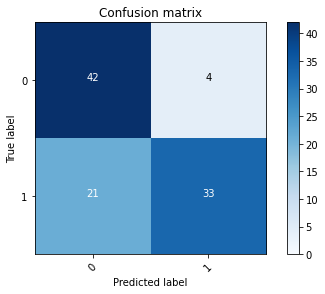

2022-07-06 19:19:19 - [Epoch Train: 51] loss: 0.0197, auc: 0.9998, acc: 0.9886, time: 22.00 s            
2022-07-06 19:19:19 - [Epoch Valid: 51] loss: 1.9839, auc: 0.8671, acc: 0.7315, time: 5.00 s


 34%|██████████████▎                           | 51/150 [23:14<45:48, 27.76s/it]

2022-07-06 19:19:19 - EPOCH: 52
2022-07-06 19:19:20 - Train Step 10/438, train_loss: 0.0005
2022-07-06 19:19:20 - Train Step 20/438, train_loss: 0.0013
2022-07-06 19:19:21 - Train Step 30/438, train_loss: 0.0009
2022-07-06 19:19:21 - Train Step 40/438, train_loss: 0.0007
2022-07-06 19:19:22 - Train Step 50/438, train_loss: 0.0006
2022-07-06 19:19:22 - Train Step 60/438, train_loss: 0.0011
2022-07-06 19:19:23 - Train Step 70/438, train_loss: 0.0014
2022-07-06 19:19:23 - Train Step 80/438, train_loss: 0.0017
2022-07-06 19:19:24 - Train Step 90/438, train_loss: 0.0025
2022-07-06 19:19:24 - Train Step 100/438, train_loss: 0.0079
2022-07-06 19:19:25 - Train Step 110/438, train_loss: 0.0078
2022-07-06 19:19:25 - Train Step 120/438, train_loss: 0.0072
2022-07-06 19:19:26 - Train Step 130/438, train_loss: 0.0082
2022-07-06 19:19:27 - Train Step 140/438, train_loss: 0.0077
2022-07-06 19:19:27 - Train Step 150/438, train_loss: 0.0077
2022-07-06 19:19:28 - Train Step 160/438, train_loss: 0.0072
2

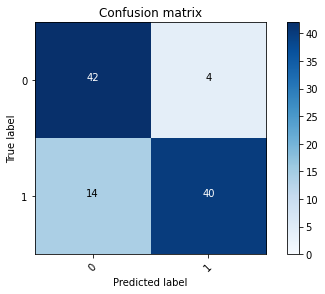

2022-07-06 19:19:47 - [Epoch Train: 52] loss: 0.0169, auc: 0.9997, acc: 0.9932, time: 22.00 s            
2022-07-06 19:19:47 - [Epoch Valid: 52] loss: 1.5378, auc: 0.8756, acc: 0.7963, time: 5.00 s


 35%|██████████████▌                           | 52/150 [23:43<45:32, 27.88s/it]

2022-07-06 19:19:47 - EPOCH: 53
2022-07-06 19:19:48 - Train Step 10/438, train_loss: 0.0024
2022-07-06 19:19:48 - Train Step 20/438, train_loss: 0.0944
2022-07-06 19:19:49 - Train Step 30/438, train_loss: 0.0633
2022-07-06 19:19:49 - Train Step 40/438, train_loss: 0.0480
2022-07-06 19:19:50 - Train Step 50/438, train_loss: 0.0661
2022-07-06 19:19:50 - Train Step 60/438, train_loss: 0.0554
2022-07-06 19:19:51 - Train Step 70/438, train_loss: 0.0480
2022-07-06 19:19:51 - Train Step 80/438, train_loss: 0.0428
2022-07-06 19:19:52 - Train Step 90/438, train_loss: 0.0464
2022-07-06 19:19:52 - Train Step 100/438, train_loss: 0.0417
2022-07-06 19:19:53 - Train Step 110/438, train_loss: 0.0379
2022-07-06 19:19:53 - Train Step 120/438, train_loss: 0.0357
2022-07-06 19:19:54 - Train Step 130/438, train_loss: 0.0369
2022-07-06 19:19:54 - Train Step 140/438, train_loss: 0.0351
2022-07-06 19:19:55 - Train Step 150/438, train_loss: 0.0334
2022-07-06 19:19:55 - Train Step 160/438, train_loss: 0.0328
2

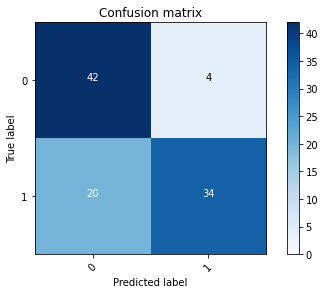

2022-07-06 19:20:14 - [Epoch Train: 53] loss: 0.0162, auc: 0.9999, acc: 0.9932, time: 21.00 s            
2022-07-06 19:20:14 - [Epoch Valid: 53] loss: 1.9619, auc: 0.8680, acc: 0.7407, time: 5.00 s


 35%|██████████████▊                           | 53/150 [24:09<44:32, 27.55s/it]

2022-07-06 19:20:14 - EPOCH: 54
2022-07-06 19:20:15 - Train Step 10/438, train_loss: 0.0002
2022-07-06 19:20:15 - Train Step 20/438, train_loss: 0.0274
2022-07-06 19:20:16 - Train Step 30/438, train_loss: 0.0486
2022-07-06 19:20:16 - Train Step 40/438, train_loss: 0.0365
2022-07-06 19:20:17 - Train Step 50/438, train_loss: 0.0292
2022-07-06 19:20:17 - Train Step 60/438, train_loss: 0.0244
2022-07-06 19:20:18 - Train Step 70/438, train_loss: 0.0210
2022-07-06 19:20:18 - Train Step 80/438, train_loss: 0.0189
2022-07-06 19:20:19 - Train Step 90/438, train_loss: 0.0169
2022-07-06 19:20:19 - Train Step 100/438, train_loss: 0.0159
2022-07-06 19:20:20 - Train Step 110/438, train_loss: 0.0145
2022-07-06 19:20:20 - Train Step 120/438, train_loss: 0.0133
2022-07-06 19:20:21 - Train Step 130/438, train_loss: 0.0123
2022-07-06 19:20:21 - Train Step 140/438, train_loss: 0.0187
2022-07-06 19:20:22 - Train Step 150/438, train_loss: 0.0257
2022-07-06 19:20:22 - Train Step 160/438, train_loss: 0.0241
2

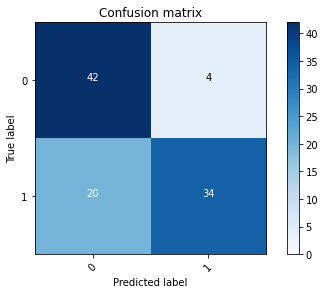

2022-07-06 19:20:41 - [Epoch Train: 54] loss: 0.0127, auc: 0.9999, acc: 0.9932, time: 21.00 s            
2022-07-06 19:20:41 - [Epoch Valid: 54] loss: 2.0382, auc: 0.8541, acc: 0.7407, time: 5.00 s


 36%|███████████████                           | 54/150 [24:36<43:44, 27.34s/it]

2022-07-06 19:20:41 - EPOCH: 55
2022-07-06 19:20:42 - Train Step 10/438, train_loss: 0.0146
2022-07-06 19:20:42 - Train Step 20/438, train_loss: 0.0074
2022-07-06 19:20:43 - Train Step 30/438, train_loss: 0.0200
2022-07-06 19:20:43 - Train Step 40/438, train_loss: 0.0157
2022-07-06 19:20:44 - Train Step 50/438, train_loss: 0.0126
2022-07-06 19:20:44 - Train Step 60/438, train_loss: 0.0107
2022-07-06 19:20:44 - Train Step 70/438, train_loss: 0.0091
2022-07-06 19:20:45 - Train Step 80/438, train_loss: 0.0081
2022-07-06 19:20:45 - Train Step 90/438, train_loss: 0.0138
2022-07-06 19:20:46 - Train Step 100/438, train_loss: 0.0125
2022-07-06 19:20:46 - Train Step 110/438, train_loss: 0.0271
2022-07-06 19:20:47 - Train Step 120/438, train_loss: 0.0249
2022-07-06 19:20:47 - Train Step 130/438, train_loss: 0.0306
2022-07-06 19:20:48 - Train Step 140/438, train_loss: 0.0290
2022-07-06 19:20:48 - Train Step 150/438, train_loss: 0.0271
2022-07-06 19:20:49 - Train Step 160/438, train_loss: 0.0254
2

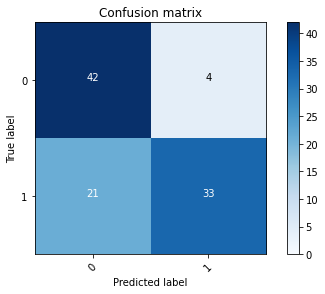

2022-07-06 19:21:08 - [Epoch Train: 55] loss: 0.0204, auc: 0.9998, acc: 0.9863, time: 21.00 s            
2022-07-06 19:21:08 - [Epoch Valid: 55] loss: 2.1636, auc: 0.8663, acc: 0.7315, time: 5.00 s


 37%|███████████████▍                          | 55/150 [25:03<43:08, 27.25s/it]

2022-07-06 19:21:08 - EPOCH: 56
2022-07-06 19:21:09 - Train Step 10/438, train_loss: 0.0005
2022-07-06 19:21:09 - Train Step 20/438, train_loss: 0.0003
2022-07-06 19:21:10 - Train Step 30/438, train_loss: 0.0179
2022-07-06 19:21:10 - Train Step 40/438, train_loss: 0.0135
2022-07-06 19:21:11 - Train Step 50/438, train_loss: 0.0108
2022-07-06 19:21:11 - Train Step 60/438, train_loss: 0.0091
2022-07-06 19:21:12 - Train Step 70/438, train_loss: 0.0081
2022-07-06 19:21:12 - Train Step 80/438, train_loss: 0.0071
2022-07-06 19:21:13 - Train Step 90/438, train_loss: 0.0064
2022-07-06 19:21:13 - Train Step 100/438, train_loss: 0.0059
2022-07-06 19:21:14 - Train Step 110/438, train_loss: 0.0053
2022-07-06 19:21:14 - Train Step 120/438, train_loss: 0.0050
2022-07-06 19:21:15 - Train Step 130/438, train_loss: 0.0046
2022-07-06 19:21:15 - Train Step 140/438, train_loss: 0.0043
2022-07-06 19:21:16 - Train Step 150/438, train_loss: 0.0040
2022-07-06 19:21:16 - Train Step 160/438, train_loss: 0.0038
2

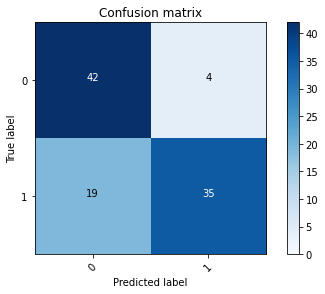

2022-07-06 19:21:36 - [Epoch Train: 56] loss: 0.0051, auc: 1.0000, acc: 1.0000, time: 22.00 s            
2022-07-06 19:21:36 - [Epoch Valid: 56] loss: 2.1540, auc: 0.8688, acc: 0.7500, time: 5.00 s


 37%|███████████████▋                          | 56/150 [25:31<43:05, 27.51s/it]

2022-07-06 19:21:36 - EPOCH: 57
2022-07-06 19:21:37 - Train Step 10/438, train_loss: 0.0000
2022-07-06 19:21:37 - Train Step 20/438, train_loss: 0.0004
2022-07-06 19:21:38 - Train Step 30/438, train_loss: 0.0004
2022-07-06 19:21:38 - Train Step 40/438, train_loss: 0.0009
2022-07-06 19:21:39 - Train Step 50/438, train_loss: 0.0007
2022-07-06 19:21:39 - Train Step 60/438, train_loss: 0.0006
2022-07-06 19:21:40 - Train Step 70/438, train_loss: 0.0005
2022-07-06 19:21:40 - Train Step 80/438, train_loss: 0.0005
2022-07-06 19:21:41 - Train Step 90/438, train_loss: 0.0005
2022-07-06 19:21:41 - Train Step 100/438, train_loss: 0.0050
2022-07-06 19:21:42 - Train Step 110/438, train_loss: 0.0045
2022-07-06 19:21:42 - Train Step 120/438, train_loss: 0.0042
2022-07-06 19:21:42 - Train Step 130/438, train_loss: 0.0039
2022-07-06 19:21:43 - Train Step 140/438, train_loss: 0.0036
2022-07-06 19:21:44 - Train Step 150/438, train_loss: 0.0034
2022-07-06 19:21:44 - Train Step 160/438, train_loss: 0.0040
2

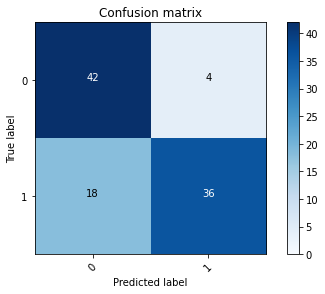

2022-07-06 19:22:03 - [Epoch Train: 57] loss: 0.0081, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-07-06 19:22:03 - [Epoch Valid: 57] loss: 2.6213, auc: 0.8756, acc: 0.7593, time: 5.00 s


 38%|███████████████▉                          | 57/150 [25:58<42:26, 27.38s/it]

2022-07-06 19:22:03 - EPOCH: 58
2022-07-06 19:22:04 - Train Step 10/438, train_loss: 0.0008
2022-07-06 19:22:04 - Train Step 20/438, train_loss: 0.0004
2022-07-06 19:22:05 - Train Step 30/438, train_loss: 0.0136
2022-07-06 19:22:05 - Train Step 40/438, train_loss: 0.0126
2022-07-06 19:22:06 - Train Step 50/438, train_loss: 0.0102
2022-07-06 19:22:06 - Train Step 60/438, train_loss: 0.0085
2022-07-06 19:22:07 - Train Step 70/438, train_loss: 0.0073
2022-07-06 19:22:07 - Train Step 80/438, train_loss: 0.0066
2022-07-06 19:22:08 - Train Step 90/438, train_loss: 0.0061
2022-07-06 19:22:08 - Train Step 100/438, train_loss: 0.0057
2022-07-06 19:22:09 - Train Step 110/438, train_loss: 0.0052
2022-07-06 19:22:09 - Train Step 120/438, train_loss: 0.0048
2022-07-06 19:22:10 - Train Step 130/438, train_loss: 0.0045
2022-07-06 19:22:10 - Train Step 140/438, train_loss: 0.0043
2022-07-06 19:22:11 - Train Step 150/438, train_loss: 0.0040
2022-07-06 19:22:11 - Train Step 160/438, train_loss: 0.0038
2

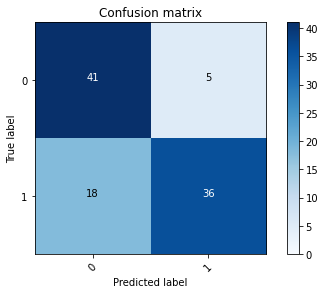

2022-07-06 19:22:30 - [Epoch Train: 58] loss: 0.0041, auc: 1.0000, acc: 1.0000, time: 20.00 s            
2022-07-06 19:22:30 - [Epoch Valid: 58] loss: 2.1984, auc: 0.8680, acc: 0.7500, time: 5.00 s


 39%|████████████████▏                         | 58/150 [26:25<41:35, 27.12s/it]

2022-07-06 19:22:30 - EPOCH: 59
2022-07-06 19:22:30 - Train Step 10/438, train_loss: 0.0001
2022-07-06 19:22:31 - Train Step 20/438, train_loss: 0.0000
2022-07-06 19:22:31 - Train Step 30/438, train_loss: 0.0000
2022-07-06 19:22:32 - Train Step 40/438, train_loss: 0.0000
2022-07-06 19:22:32 - Train Step 50/438, train_loss: 0.0079
2022-07-06 19:22:33 - Train Step 60/438, train_loss: 0.0204
2022-07-06 19:22:33 - Train Step 70/438, train_loss: 0.0176
2022-07-06 19:22:34 - Train Step 80/438, train_loss: 0.0169
2022-07-06 19:22:34 - Train Step 90/438, train_loss: 0.0154
2022-07-06 19:22:35 - Train Step 100/438, train_loss: 0.0139
2022-07-06 19:22:35 - Train Step 110/438, train_loss: 0.0127
2022-07-06 19:22:36 - Train Step 120/438, train_loss: 0.0336
2022-07-06 19:22:36 - Train Step 130/438, train_loss: 0.0316
2022-07-06 19:22:37 - Train Step 140/438, train_loss: 0.0304
2022-07-06 19:22:37 - Train Step 150/438, train_loss: 0.0283
2022-07-06 19:22:37 - Train Step 160/438, train_loss: 0.0387
2

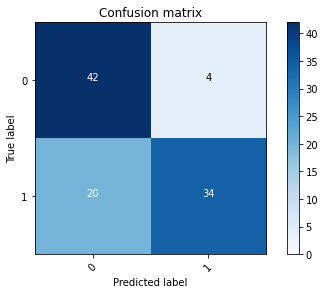

2022-07-06 19:22:57 - [Epoch Train: 59] loss: 0.0346, auc: 0.9994, acc: 0.9795, time: 21.00 s            
2022-07-06 19:22:57 - [Epoch Valid: 59] loss: 1.8854, auc: 0.8631, acc: 0.7407, time: 5.00 s


 39%|████████████████▌                         | 59/150 [26:52<40:57, 27.01s/it]

2022-07-06 19:22:57 - EPOCH: 60
2022-07-06 19:22:57 - Train Step 10/438, train_loss: 0.0000
2022-07-06 19:22:58 - Train Step 20/438, train_loss: 0.0003
2022-07-06 19:22:58 - Train Step 30/438, train_loss: 0.0331
2022-07-06 19:22:59 - Train Step 40/438, train_loss: 0.0265
2022-07-06 19:22:59 - Train Step 50/438, train_loss: 0.0213
2022-07-06 19:23:00 - Train Step 60/438, train_loss: 0.0248
2022-07-06 19:23:00 - Train Step 70/438, train_loss: 0.0214
2022-07-06 19:23:01 - Train Step 80/438, train_loss: 0.0187
2022-07-06 19:23:01 - Train Step 90/438, train_loss: 0.0176
2022-07-06 19:23:02 - Train Step 100/438, train_loss: 0.0163
2022-07-06 19:23:02 - Train Step 110/438, train_loss: 0.0150
2022-07-06 19:23:03 - Train Step 120/438, train_loss: 0.0138
2022-07-06 19:23:03 - Train Step 130/438, train_loss: 0.0140
2022-07-06 19:23:04 - Train Step 140/438, train_loss: 0.0130
2022-07-06 19:23:04 - Train Step 150/438, train_loss: 0.0123
2022-07-06 19:23:05 - Train Step 160/438, train_loss: 0.0129
2

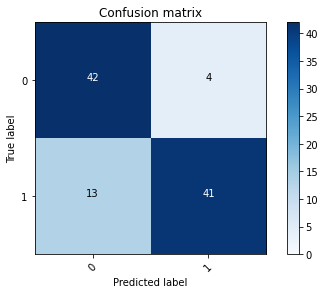

2022-07-06 19:23:25 - [Epoch Train: 60] loss: 0.0121, auc: 0.9999, acc: 0.9954, time: 22.00 s            
2022-07-06 19:23:25 - [Epoch Valid: 60] loss: 2.0425, auc: 0.8748, acc: 0.8056, time: 5.00 s


 40%|████████████████▊                         | 60/150 [27:20<41:05, 27.39s/it]

2022-07-06 19:23:25 - EPOCH: 61
2022-07-06 19:23:25 - Train Step 10/438, train_loss: 0.0000
2022-07-06 19:23:26 - Train Step 20/438, train_loss: 0.0005
2022-07-06 19:23:26 - Train Step 30/438, train_loss: 0.0003
2022-07-06 19:23:27 - Train Step 40/438, train_loss: 0.0005
2022-07-06 19:23:27 - Train Step 50/438, train_loss: 0.0005
2022-07-06 19:23:28 - Train Step 60/438, train_loss: 0.0006
2022-07-06 19:23:28 - Train Step 70/438, train_loss: 0.0005
2022-07-06 19:23:29 - Train Step 80/438, train_loss: 0.0008
2022-07-06 19:23:29 - Train Step 90/438, train_loss: 0.0007
2022-07-06 19:23:30 - Train Step 100/438, train_loss: 0.0006
2022-07-06 19:23:30 - Train Step 110/438, train_loss: 0.0012
2022-07-06 19:23:31 - Train Step 120/438, train_loss: 0.0011
2022-07-06 19:23:31 - Train Step 130/438, train_loss: 0.0010
2022-07-06 19:23:32 - Train Step 140/438, train_loss: 0.0010
2022-07-06 19:23:32 - Train Step 150/438, train_loss: 0.0009
2022-07-06 19:23:33 - Train Step 160/438, train_loss: 0.0009
2

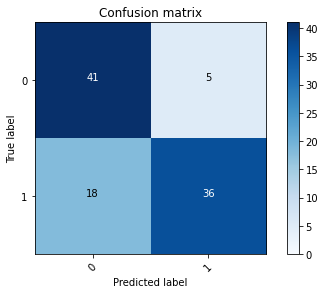

2022-07-06 19:23:52 - [Epoch Train: 61] loss: 0.0097, auc: 1.0000, acc: 0.9954, time: 21.00 s            
2022-07-06 19:23:52 - [Epoch Valid: 61] loss: 2.3575, auc: 0.8595, acc: 0.7500, time: 5.00 s


 41%|█████████████████                         | 61/150 [27:47<40:36, 27.38s/it]

2022-07-06 19:23:52 - EPOCH: 62
2022-07-06 19:23:53 - Train Step 10/438, train_loss: 0.0003
2022-07-06 19:23:53 - Train Step 20/438, train_loss: 0.0011
2022-07-06 19:23:54 - Train Step 30/438, train_loss: 0.0008
2022-07-06 19:23:54 - Train Step 40/438, train_loss: 0.0008
2022-07-06 19:23:55 - Train Step 50/438, train_loss: 0.0007
2022-07-06 19:23:55 - Train Step 60/438, train_loss: 0.0386
2022-07-06 19:23:56 - Train Step 70/438, train_loss: 0.0332
2022-07-06 19:23:56 - Train Step 80/438, train_loss: 0.0343
2022-07-06 19:23:57 - Train Step 90/438, train_loss: 0.0602
2022-07-06 19:23:57 - Train Step 100/438, train_loss: 0.0543
2022-07-06 19:23:58 - Train Step 110/438, train_loss: 0.0494
2022-07-06 19:23:58 - Train Step 120/438, train_loss: 0.0455
2022-07-06 19:23:59 - Train Step 130/438, train_loss: 0.0421
2022-07-06 19:23:59 - Train Step 140/438, train_loss: 0.0391
2022-07-06 19:24:00 - Train Step 150/438, train_loss: 0.0374
2022-07-06 19:24:00 - Train Step 160/438, train_loss: 0.0355
2

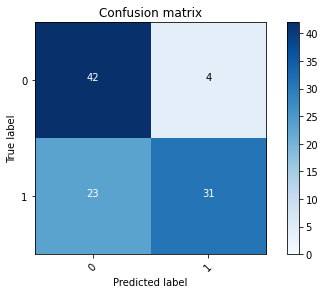

2022-07-06 19:24:19 - [Epoch Train: 62] loss: 0.0434, auc: 0.9989, acc: 0.9817, time: 21.00 s            
2022-07-06 19:24:19 - [Epoch Valid: 62] loss: 1.8633, auc: 0.8615, acc: 0.7130, time: 5.00 s


 41%|█████████████████▎                        | 62/150 [28:14<39:48, 27.14s/it]

2022-07-06 19:24:19 - EPOCH: 63
2022-07-06 19:24:19 - Train Step 10/438, train_loss: 0.0055
2022-07-06 19:24:20 - Train Step 20/438, train_loss: 0.0028
2022-07-06 19:24:20 - Train Step 30/438, train_loss: 0.0026
2022-07-06 19:24:21 - Train Step 40/438, train_loss: 0.0029
2022-07-06 19:24:21 - Train Step 50/438, train_loss: 0.0027
2022-07-06 19:24:22 - Train Step 60/438, train_loss: 0.0026
2022-07-06 19:24:22 - Train Step 70/438, train_loss: 0.0027
2022-07-06 19:24:23 - Train Step 80/438, train_loss: 0.0023
2022-07-06 19:24:23 - Train Step 90/438, train_loss: 0.0136
2022-07-06 19:24:24 - Train Step 100/438, train_loss: 0.0126
2022-07-06 19:24:24 - Train Step 110/438, train_loss: 0.0197
2022-07-06 19:24:25 - Train Step 120/438, train_loss: 0.0181
2022-07-06 19:24:25 - Train Step 130/438, train_loss: 0.0170
2022-07-06 19:24:26 - Train Step 140/438, train_loss: 0.0174
2022-07-06 19:24:26 - Train Step 150/438, train_loss: 0.0162
2022-07-06 19:24:26 - Train Step 160/438, train_loss: 0.0152
2

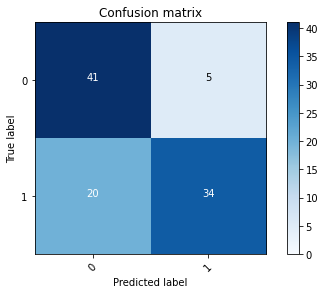

2022-07-06 19:24:45 - [Epoch Train: 63] loss: 0.0096, auc: 0.9999, acc: 0.9932, time: 20.00 s            
2022-07-06 19:24:45 - [Epoch Valid: 63] loss: 2.1888, auc: 0.8639, acc: 0.7315, time: 5.00 s


 42%|█████████████████▋                        | 63/150 [28:40<39:03, 26.94s/it]

2022-07-06 19:24:45 - EPOCH: 64
2022-07-06 19:24:46 - Train Step 10/438, train_loss: 0.0021
2022-07-06 19:24:46 - Train Step 20/438, train_loss: 0.0011
2022-07-06 19:24:47 - Train Step 30/438, train_loss: 0.0008
2022-07-06 19:24:47 - Train Step 40/438, train_loss: 0.0087
2022-07-06 19:24:48 - Train Step 50/438, train_loss: 0.0175
2022-07-06 19:24:48 - Train Step 60/438, train_loss: 0.0146
2022-07-06 19:24:49 - Train Step 70/438, train_loss: 0.0125
2022-07-06 19:24:49 - Train Step 80/438, train_loss: 0.0168
2022-07-06 19:24:50 - Train Step 90/438, train_loss: 0.0150
2022-07-06 19:24:50 - Train Step 100/438, train_loss: 0.0153
2022-07-06 19:24:51 - Train Step 110/438, train_loss: 0.0139
2022-07-06 19:24:51 - Train Step 120/438, train_loss: 0.0206
2022-07-06 19:24:52 - Train Step 130/438, train_loss: 0.0191
2022-07-06 19:24:52 - Train Step 140/438, train_loss: 0.0182
2022-07-06 19:24:52 - Train Step 150/438, train_loss: 0.0170
2022-07-06 19:24:53 - Train Step 160/438, train_loss: 0.0161
2

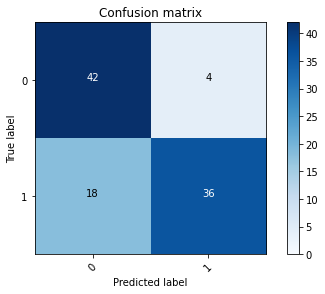

2022-07-06 19:25:12 - [Epoch Train: 64] loss: 0.0088, auc: 1.0000, acc: 0.9977, time: 21.00 s            
2022-07-06 19:25:12 - [Epoch Valid: 64] loss: 2.3038, auc: 0.8655, acc: 0.7593, time: 5.00 s


 43%|█████████████████▉                        | 64/150 [29:07<38:32, 26.89s/it]

2022-07-06 19:25:12 - EPOCH: 65
2022-07-06 19:25:13 - Train Step 10/438, train_loss: 0.0029
2022-07-06 19:25:13 - Train Step 20/438, train_loss: 0.0040
2022-07-06 19:25:14 - Train Step 30/438, train_loss: 0.0027
2022-07-06 19:25:14 - Train Step 40/438, train_loss: 0.0046
2022-07-06 19:25:15 - Train Step 50/438, train_loss: 0.0037
2022-07-06 19:25:15 - Train Step 60/438, train_loss: 0.0116
2022-07-06 19:25:15 - Train Step 70/438, train_loss: 0.0100
2022-07-06 19:25:16 - Train Step 80/438, train_loss: 0.0087
2022-07-06 19:25:16 - Train Step 90/438, train_loss: 0.0179
2022-07-06 19:25:17 - Train Step 100/438, train_loss: 0.0167
2022-07-06 19:25:17 - Train Step 110/438, train_loss: 0.0152
2022-07-06 19:25:18 - Train Step 120/438, train_loss: 0.0182
2022-07-06 19:25:18 - Train Step 130/438, train_loss: 0.0208
2022-07-06 19:25:19 - Train Step 140/438, train_loss: 0.0195
2022-07-06 19:25:19 - Train Step 150/438, train_loss: 0.0182
2022-07-06 19:25:20 - Train Step 160/438, train_loss: 0.0170
2

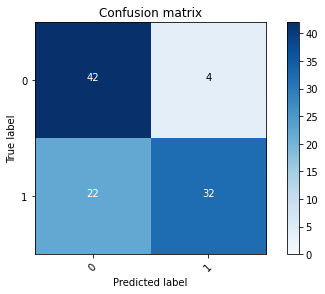

2022-07-06 19:25:39 - [Epoch Train: 65] loss: 0.0161, auc: 0.9997, acc: 0.9886, time: 21.00 s            
2022-07-06 19:25:39 - [Epoch Valid: 65] loss: 2.3734, auc: 0.8663, acc: 0.7222, time: 5.00 s


 43%|██████████████████▏                       | 65/150 [29:34<38:05, 26.89s/it]

2022-07-06 19:25:39 - EPOCH: 66
2022-07-06 19:25:39 - Train Step 10/438, train_loss: 0.0118
2022-07-06 19:25:40 - Train Step 20/438, train_loss: 0.0066
2022-07-06 19:25:40 - Train Step 30/438, train_loss: 0.0044
2022-07-06 19:25:41 - Train Step 40/438, train_loss: 0.0033
2022-07-06 19:25:41 - Train Step 50/438, train_loss: 0.0027
2022-07-06 19:25:42 - Train Step 60/438, train_loss: 0.0046
2022-07-06 19:25:42 - Train Step 70/438, train_loss: 0.0041
2022-07-06 19:25:43 - Train Step 80/438, train_loss: 0.0036
2022-07-06 19:25:43 - Train Step 90/438, train_loss: 0.0035
2022-07-06 19:25:44 - Train Step 100/438, train_loss: 0.0035
2022-07-06 19:25:44 - Train Step 110/438, train_loss: 0.0031
2022-07-06 19:25:45 - Train Step 120/438, train_loss: 0.0029
2022-07-06 19:25:45 - Train Step 130/438, train_loss: 0.0031
2022-07-06 19:25:46 - Train Step 140/438, train_loss: 0.0031
2022-07-06 19:25:46 - Train Step 150/438, train_loss: 0.0029
2022-07-06 19:25:47 - Train Step 160/438, train_loss: 0.0107
2

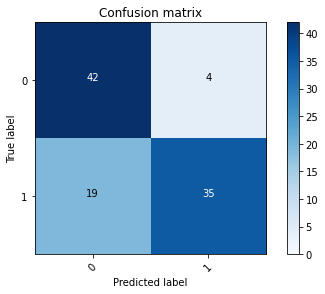

2022-07-06 19:26:06 - [Epoch Train: 66] loss: 0.0079, auc: 1.0000, acc: 0.9977, time: 21.00 s            
2022-07-06 19:26:06 - [Epoch Valid: 66] loss: 2.3200, auc: 0.8659, acc: 0.7500, time: 5.00 s


 44%|██████████████████▍                       | 66/150 [30:01<37:42, 26.94s/it]

2022-07-06 19:26:06 - EPOCH: 67
2022-07-06 19:26:07 - Train Step 10/438, train_loss: 0.0001
2022-07-06 19:26:07 - Train Step 20/438, train_loss: 0.0006
2022-07-06 19:26:07 - Train Step 30/438, train_loss: 0.0004
2022-07-06 19:26:08 - Train Step 40/438, train_loss: 0.0004
2022-07-06 19:26:08 - Train Step 50/438, train_loss: 0.0009
2022-07-06 19:26:09 - Train Step 60/438, train_loss: 0.0008
2022-07-06 19:26:09 - Train Step 70/438, train_loss: 0.0007
2022-07-06 19:26:10 - Train Step 80/438, train_loss: 0.0006
2022-07-06 19:26:10 - Train Step 90/438, train_loss: 0.0006
2022-07-06 19:26:11 - Train Step 100/438, train_loss: 0.0006
2022-07-06 19:26:11 - Train Step 110/438, train_loss: 0.0041
2022-07-06 19:26:12 - Train Step 120/438, train_loss: 0.0037
2022-07-06 19:26:12 - Train Step 130/438, train_loss: 0.0035
2022-07-06 19:26:13 - Train Step 140/438, train_loss: 0.0033
2022-07-06 19:26:13 - Train Step 150/438, train_loss: 0.0031
2022-07-06 19:26:14 - Train Step 160/438, train_loss: 0.0029
2

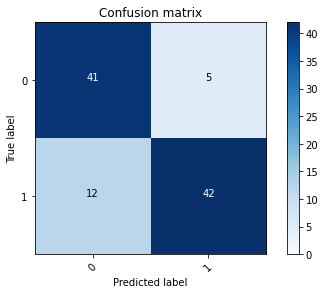

2022-07-06 19:26:33 - [Epoch Train: 67] loss: 0.0140, auc: 1.0000, acc: 0.9954, time: 21.00 s            
2022-07-06 19:26:33 - [Epoch Valid: 67] loss: 1.6628, auc: 0.8712, acc: 0.8056, time: 5.00 s


 45%|██████████████████▊                       | 67/150 [30:28<37:10, 26.87s/it]

2022-07-06 19:26:33 - EPOCH: 68
2022-07-06 19:26:33 - Train Step 10/438, train_loss: 0.0111
2022-07-06 19:26:34 - Train Step 20/438, train_loss: 0.0065
2022-07-06 19:26:34 - Train Step 30/438, train_loss: 0.0152
2022-07-06 19:26:35 - Train Step 40/438, train_loss: 0.0115
2022-07-06 19:26:35 - Train Step 50/438, train_loss: 0.0092
2022-07-06 19:26:36 - Train Step 60/438, train_loss: 0.0077
2022-07-06 19:26:36 - Train Step 70/438, train_loss: 0.0066
2022-07-06 19:26:37 - Train Step 80/438, train_loss: 0.0059
2022-07-06 19:26:37 - Train Step 90/438, train_loss: 0.0053
2022-07-06 19:26:38 - Train Step 100/438, train_loss: 0.0048
2022-07-06 19:26:38 - Train Step 110/438, train_loss: 0.0044
2022-07-06 19:26:39 - Train Step 120/438, train_loss: 0.0041
2022-07-06 19:26:39 - Train Step 130/438, train_loss: 0.0043
2022-07-06 19:26:40 - Train Step 140/438, train_loss: 0.0043
2022-07-06 19:26:40 - Train Step 150/438, train_loss: 0.0041
2022-07-06 19:26:41 - Train Step 160/438, train_loss: 0.0040
2

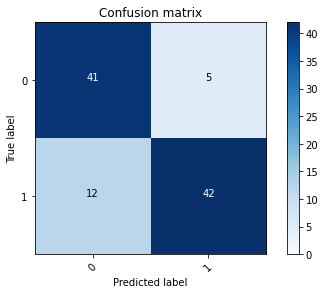

2022-07-06 19:26:59 - [Epoch Train: 68] loss: 0.0090, auc: 1.0000, acc: 0.9977, time: 21.00 s            
2022-07-06 19:26:59 - [Epoch Valid: 68] loss: 1.9397, auc: 0.8700, acc: 0.8056, time: 5.00 s


 45%|███████████████████                       | 68/150 [30:54<36:37, 26.80s/it]

2022-07-06 19:26:59 - EPOCH: 69
2022-07-06 19:27:00 - Train Step 10/438, train_loss: 0.0017
2022-07-06 19:27:00 - Train Step 20/438, train_loss: 0.0008
2022-07-06 19:27:01 - Train Step 30/438, train_loss: 0.0006
2022-07-06 19:27:01 - Train Step 40/438, train_loss: 0.0004
2022-07-06 19:27:02 - Train Step 50/438, train_loss: 0.0004
2022-07-06 19:27:02 - Train Step 60/438, train_loss: 0.0169
2022-07-06 19:27:03 - Train Step 70/438, train_loss: 0.0145
2022-07-06 19:27:03 - Train Step 80/438, train_loss: 0.0138
2022-07-06 19:27:04 - Train Step 90/438, train_loss: 0.0123
2022-07-06 19:27:04 - Train Step 100/438, train_loss: 0.0121
2022-07-06 19:27:05 - Train Step 110/438, train_loss: 0.0110
2022-07-06 19:27:05 - Train Step 120/438, train_loss: 0.0101
2022-07-06 19:27:06 - Train Step 130/438, train_loss: 0.0093
2022-07-06 19:27:06 - Train Step 140/438, train_loss: 0.0087
2022-07-06 19:27:07 - Train Step 150/438, train_loss: 0.0081
2022-07-06 19:27:07 - Train Step 160/438, train_loss: 0.0077
2

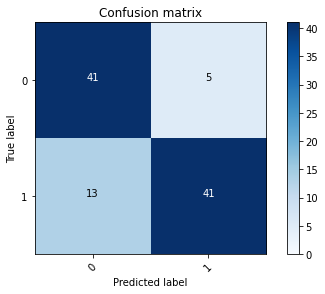

2022-07-06 19:27:26 - [Epoch Train: 69] loss: 0.0149, auc: 1.0000, acc: 0.9954, time: 21.00 s            
2022-07-06 19:27:26 - [Epoch Valid: 69] loss: 1.5555, auc: 0.8909, acc: 0.7963, time: 5.00 s


 46%|███████████████████▎                      | 69/150 [31:21<36:10, 26.80s/it]

2022-07-06 19:27:26 - EPOCH: 70
2022-07-06 19:27:27 - Train Step 10/438, train_loss: 0.0001
2022-07-06 19:27:27 - Train Step 20/438, train_loss: 0.0006
2022-07-06 19:27:28 - Train Step 30/438, train_loss: 0.0004
2022-07-06 19:27:28 - Train Step 40/438, train_loss: 0.0004
2022-07-06 19:27:29 - Train Step 50/438, train_loss: 0.0075
2022-07-06 19:27:29 - Train Step 60/438, train_loss: 0.0090
2022-07-06 19:27:30 - Train Step 70/438, train_loss: 0.0081
2022-07-06 19:27:30 - Train Step 80/438, train_loss: 0.0074
2022-07-06 19:27:31 - Train Step 90/438, train_loss: 0.0067
2022-07-06 19:27:31 - Train Step 100/438, train_loss: 0.0061
2022-07-06 19:27:32 - Train Step 110/438, train_loss: 0.0056
2022-07-06 19:27:32 - Train Step 120/438, train_loss: 0.0053
2022-07-06 19:27:32 - Train Step 130/438, train_loss: 0.0049
2022-07-06 19:27:33 - Train Step 140/438, train_loss: 0.0079
2022-07-06 19:27:34 - Train Step 150/438, train_loss: 0.0076
2022-07-06 19:27:34 - Train Step 160/438, train_loss: 0.0143
2

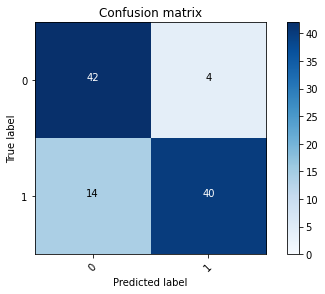

2022-07-06 19:27:53 - [Epoch Train: 70] loss: 0.0140, auc: 0.9999, acc: 0.9954, time: 21.00 s            
2022-07-06 19:27:53 - [Epoch Valid: 70] loss: 2.1048, auc: 0.8676, acc: 0.7963, time: 5.00 s


 47%|███████████████████▌                      | 70/150 [31:48<35:45, 26.82s/it]

2022-07-06 19:27:53 - EPOCH: 71
2022-07-06 19:27:54 - Train Step 10/438, train_loss: 0.0213
2022-07-06 19:27:54 - Train Step 20/438, train_loss: 0.0108
2022-07-06 19:27:55 - Train Step 30/438, train_loss: 0.0199
2022-07-06 19:27:55 - Train Step 40/438, train_loss: 0.0150
2022-07-06 19:27:56 - Train Step 50/438, train_loss: 0.0121
2022-07-06 19:27:56 - Train Step 60/438, train_loss: 0.0104
2022-07-06 19:27:57 - Train Step 70/438, train_loss: 0.0089
2022-07-06 19:27:57 - Train Step 80/438, train_loss: 0.0194
2022-07-06 19:27:58 - Train Step 90/438, train_loss: 0.0183
2022-07-06 19:27:58 - Train Step 100/438, train_loss: 0.0178
2022-07-06 19:27:59 - Train Step 110/438, train_loss: 0.0163
2022-07-06 19:27:59 - Train Step 120/438, train_loss: 0.0149
2022-07-06 19:28:00 - Train Step 130/438, train_loss: 0.0138
2022-07-06 19:28:00 - Train Step 140/438, train_loss: 0.0128
2022-07-06 19:28:01 - Train Step 150/438, train_loss: 0.0133
2022-07-06 19:28:01 - Train Step 160/438, train_loss: 0.0126
2

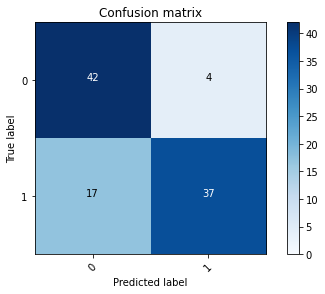

2022-07-06 19:28:21 - [Epoch Train: 71] loss: 0.0062, auc: 1.0000, acc: 1.0000, time: 21.00 s            
2022-07-06 19:28:21 - [Epoch Valid: 71] loss: 2.0885, auc: 0.8635, acc: 0.7685, time: 5.00 s


 47%|███████████████████▉                      | 71/150 [32:16<35:36, 27.04s/it]

2022-07-06 19:28:21 - EPOCH: 72
2022-07-06 19:28:21 - Train Step 10/438, train_loss: 0.0009
2022-07-06 19:28:22 - Train Step 20/438, train_loss: 0.0005
2022-07-06 19:28:22 - Train Step 30/438, train_loss: 0.0003
2022-07-06 19:28:23 - Train Step 40/438, train_loss: 0.0132
2022-07-06 19:28:23 - Train Step 50/438, train_loss: 0.0106
2022-07-06 19:28:24 - Train Step 60/438, train_loss: 0.0090
2022-07-06 19:28:24 - Train Step 70/438, train_loss: 0.0083
2022-07-06 19:28:25 - Train Step 80/438, train_loss: 0.0073
2022-07-06 19:28:25 - Train Step 90/438, train_loss: 0.0069
2022-07-06 19:28:26 - Train Step 100/438, train_loss: 0.0164
2022-07-06 19:28:26 - Train Step 110/438, train_loss: 0.0150
2022-07-06 19:28:27 - Train Step 120/438, train_loss: 0.0137
2022-07-06 19:28:27 - Train Step 130/438, train_loss: 0.0127
2022-07-06 19:28:28 - Train Step 140/438, train_loss: 0.0228
2022-07-06 19:28:28 - Train Step 150/438, train_loss: 0.0212
2022-07-06 19:28:29 - Train Step 160/438, train_loss: 0.0201
2

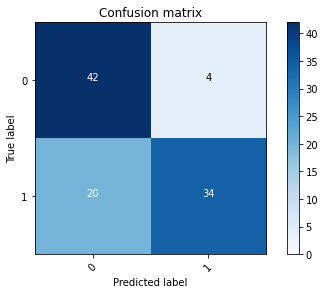

2022-07-06 19:28:48 - [Epoch Train: 72] loss: 0.0150, auc: 0.9999, acc: 0.9932, time: 21.00 s            
2022-07-06 19:28:48 - [Epoch Valid: 72] loss: 2.1613, auc: 0.8684, acc: 0.7407, time: 5.00 s


 48%|████████████████████▏                     | 72/150 [32:43<35:25, 27.24s/it]

2022-07-06 19:28:48 - EPOCH: 73
2022-07-06 19:28:49 - Train Step 10/438, train_loss: 0.0006
2022-07-06 19:28:49 - Train Step 20/438, train_loss: 0.0211
2022-07-06 19:28:50 - Train Step 30/438, train_loss: 0.0143
2022-07-06 19:28:50 - Train Step 40/438, train_loss: 0.0107
2022-07-06 19:28:51 - Train Step 50/438, train_loss: 0.0086
2022-07-06 19:28:51 - Train Step 60/438, train_loss: 0.0081
2022-07-06 19:28:52 - Train Step 70/438, train_loss: 0.0071
2022-07-06 19:28:52 - Train Step 80/438, train_loss: 0.0062
2022-07-06 19:28:53 - Train Step 90/438, train_loss: 0.0055
2022-07-06 19:28:53 - Train Step 100/438, train_loss: 0.0050
2022-07-06 19:28:54 - Train Step 110/438, train_loss: 0.0045
2022-07-06 19:28:54 - Train Step 120/438, train_loss: 0.0118
2022-07-06 19:28:55 - Train Step 130/438, train_loss: 0.0109
2022-07-06 19:28:55 - Train Step 140/438, train_loss: 0.0101
2022-07-06 19:28:56 - Train Step 150/438, train_loss: 0.0094
2022-07-06 19:28:56 - Train Step 160/438, train_loss: 0.0089
2

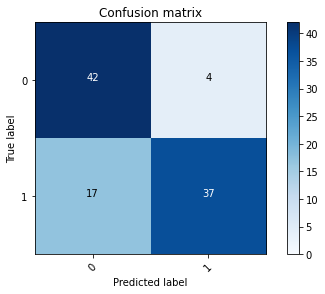

2022-07-06 19:29:15 - [Epoch Train: 73] loss: 0.0097, auc: 1.0000, acc: 0.9977, time: 21.00 s            
2022-07-06 19:29:15 - [Epoch Valid: 73] loss: 1.9767, auc: 0.8720, acc: 0.7685, time: 5.00 s


 49%|████████████████████▍                     | 73/150 [33:11<34:55, 27.22s/it]

2022-07-06 19:29:15 - EPOCH: 74
2022-07-06 19:29:16 - Train Step 10/438, train_loss: 0.0002
2022-07-06 19:29:17 - Train Step 20/438, train_loss: 0.0002
2022-07-06 19:29:17 - Train Step 30/438, train_loss: 0.0002
2022-07-06 19:29:17 - Train Step 40/438, train_loss: 0.0015
2022-07-06 19:29:18 - Train Step 50/438, train_loss: 0.0012
2022-07-06 19:29:18 - Train Step 60/438, train_loss: 0.0010
2022-07-06 19:29:19 - Train Step 70/438, train_loss: 0.0011
2022-07-06 19:29:19 - Train Step 80/438, train_loss: 0.0075
2022-07-06 19:29:20 - Train Step 90/438, train_loss: 0.0104
2022-07-06 19:29:20 - Train Step 100/438, train_loss: 0.0095
2022-07-06 19:29:21 - Train Step 110/438, train_loss: 0.0098
2022-07-06 19:29:21 - Train Step 120/438, train_loss: 0.0090
2022-07-06 19:29:22 - Train Step 130/438, train_loss: 0.0083
2022-07-06 19:29:22 - Train Step 140/438, train_loss: 0.0079
2022-07-06 19:29:23 - Train Step 150/438, train_loss: 0.0074
2022-07-06 19:29:23 - Train Step 160/438, train_loss: 0.0070
2

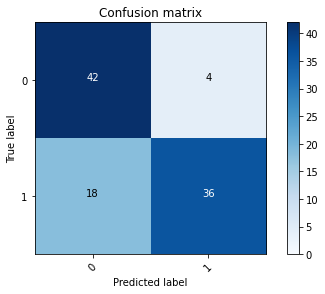

2022-07-06 19:29:42 - [Epoch Train: 74] loss: 0.0084, auc: 0.9999, acc: 0.9977, time: 21.00 s            
2022-07-06 19:29:42 - [Epoch Valid: 74] loss: 2.2049, auc: 0.8760, acc: 0.7593, time: 5.00 s


 49%|████████████████████▋                     | 74/150 [33:37<34:23, 27.15s/it]

2022-07-06 19:29:42 - EPOCH: 75
2022-07-06 19:29:43 - Train Step 10/438, train_loss: 0.0000
2022-07-06 19:29:43 - Train Step 20/438, train_loss: 0.0030
2022-07-06 19:29:44 - Train Step 30/438, train_loss: 0.0195
2022-07-06 19:29:44 - Train Step 40/438, train_loss: 0.0168
2022-07-06 19:29:45 - Train Step 50/438, train_loss: 0.0201
2022-07-06 19:29:45 - Train Step 60/438, train_loss: 0.0170
2022-07-06 19:29:46 - Train Step 70/438, train_loss: 0.0146
2022-07-06 19:29:46 - Train Step 80/438, train_loss: 0.0129
2022-07-06 19:29:47 - Train Step 90/438, train_loss: 0.0115
2022-07-06 19:29:47 - Train Step 100/438, train_loss: 0.0104
2022-07-06 19:29:48 - Train Step 110/438, train_loss: 0.0094
2022-07-06 19:29:48 - Train Step 120/438, train_loss: 0.0088
2022-07-06 19:29:49 - Train Step 130/438, train_loss: 0.0081
2022-07-06 19:29:49 - Train Step 140/438, train_loss: 0.0078
2022-07-06 19:29:50 - Train Step 150/438, train_loss: 0.0073
2022-07-06 19:29:50 - Train Step 160/438, train_loss: 0.0068
2

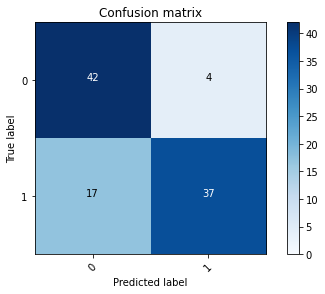

2022-07-06 19:30:09 - [Epoch Train: 75] loss: 0.0076, auc: 0.9999, acc: 0.9932, time: 20.00 s            
2022-07-06 19:30:09 - [Epoch Valid: 75] loss: 2.2517, auc: 0.8736, acc: 0.7685, time: 5.00 s
2022-07-06 19:30:09 - 
Valid acc didn't improve last 50 epochs.


 49%|████████████████████▋                     | 74/150 [34:04<34:59, 27.63s/it]

../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00048_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00078_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00084_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00089_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00134_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00144_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00154_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00171_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00187_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00192_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00194_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00199_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00240_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00245_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00261_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/1/00299_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00397_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00399_KLF.mat
../RSNA-BTC-Datasets/ec_test_mat/KLF/0/00402_K

KEY | True VAL | Array of preds VAL | Pred Avg VAL | is correct
Dataset: Labeled Test Set
   BraTS21ID  MGMT_real_value  MGMT_value
45     00048                1           1
35     00078                1           0
41     00084                0           1
36     00089                1           0
3      00134                1           0
19     00144                1           1
17     00154                0           0
47     00171                1           0
2      00187                1           1
16     00192                0           1
5      00194                0           0
0      00199                1           1
26     00240                1           1
29     00245                1           1
15     00261                0           0
32     00299                1           1
34     00397                0           0
1      00399                0           1
28     00402                0           0
31     00408                1           1
22     00414                

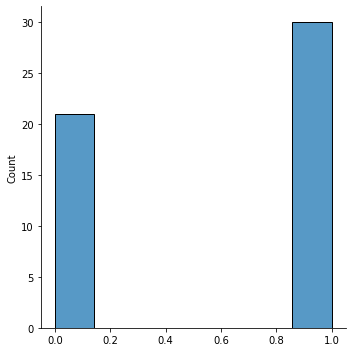

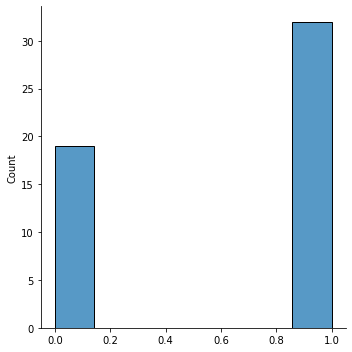

In [55]:
info = {}
info["ext"] = "mat"
#info["ext"] = "nii"
choices = [1,2,3]

ids = []
y_all = []
outputs_all = []

for i in m_test_loader:
    for j in range(2):
        print(i[0][0][j], i[2][j].numpy())
        ids.append(i[0][0][j][:5])
        y_all.append(i[2][j].numpy())
        if i[2][j].numpy() == 1 or int(i[0][0][j][:5]) in list_tumor:
            outputs_all.append(1)
        else:
            outputs_all.append(0)
        
ec_test_pred_final = pd.DataFrame({"BraTS21ID": ids, "MGMT_real_value": y_all, "MGMT_value": outputs_all}) 
ec_test_pred_final = ec_test_pred_final.sort_values(by="BraTS21ID")

# Predicted == 0 (part of final table)
ec_0_test_pred_final = ec_test_pred_final[ec_test_pred_final["MGMT_value"] == 0]
print(ec_0_test_pred_final)
# Predicted == 1
ec_1_test_pred_final = ec_test_pred_final[ec_test_pred_final["MGMT_value"] == 1]
print(ec_1_test_pred_final)

print("\nStarting trainings with the methylation model...\n")

for choice in choices:

    if choice == 3:
        chosen_net  = "alt" # Top Slice
        info["dims"] = 2
        info["batch_size"] = 1
        info["mri_types"] = ["KLF"]
        info["is_depth_wise"] = True
        info["is_transformed"] = False
        transform = None
        info["output_size"] = 1
        info["is_multistep"] = True
        info["lr"] = 0.0005
        info["is_adam"] = True
        info["momentum"] = 0.9
        info["is_10_fold"] = False
        info["val_total_ratio"] = 0.2
        info["is_internal_dataset"] = False
        size = len(info["mri_types"])
        sel_slices = 1
    elif choice == 2:
        chosen_net  = "sim" # Simple
        info["dims"] = 3
        info["batch_size"] = 2
        info["mri_types"] = ["KLF"]
        info["is_depth_wise"] = True
        info["is_transformed"] = False
        transform = None
        info["output_size"] = 1
        info["is_multistep"] = True
        info["lr"] = 0.0005
        info["is_adam"] = True
        info["momentum"] = 0.9
        info["is_10_fold"] = False
        info["val_total_ratio"] = 0.2
        info["is_internal_dataset"] = False
        size = len(info["mri_types"])
        sel_slices = None
    elif choice == 1:
        hosen_net  = "fak" # Fake 3D
        info["dims"] = 3
        info["batch_size"] = 16
        info["mri_types"] = ["KLF"]
        info["is_depth_wise"] = True
        info["is_transformed"] = False
        transform = None
        info["output_size"] = 1
        info["is_multistep"] = True
        info["lr"] = 0.0001
        info["is_adam"] = True
        info["momentum"] = 0.9
        info["is_10_fold"] = False
        info["val_total_ratio"] = 0.2
        info["is_internal_dataset"] = False
        size = len(info["mri_types"])
        sel_slices = None

    print("Iter n."+str(choice))
    print(info)
    
    mf_dataset_0 = Dataset(out_path, info["mri_types"], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

    logging.info("Train/Val datasets size: {}".format(len(mf_dataset_0)))

    mf_dataset_1 = Dataset(out_path, info["mri_types"], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

    logging.info("Train/Val datasets size: {}".format(len(mf_dataset_1)))
    
    mf_dataset_merged = Dataset().concat_datasets(mf_dataset_0, mf_dataset_1)
    mf_dataset_merged_no_tr = Dataset().concat_datasets(mf_dataset_0, mf_dataset_1, import_transform=False)

    mf_splits = get_splits(mf_dataset_0, mf_dataset_1, info["val_total_ratio"], info["is_10_fold"])
    
    g_cpu = torch.Generator()
    train_folds_idx = mf_splits[0][0]
    valid_folds_idx = mf_splits[0][1]
    test_folds_idx = mf_splits[0][2]
    idxs = train_folds_idx + test_folds_idx
    valid_idxs = valid_folds_idx
    print(len(idxs))
    print(len(valid_idxs))
    mf_sampler = SubsetRandomSampler(idxs, g_cpu)
    mf_valid_sampler = SubsetRandomSampler(valid_idxs, g_cpu)
    mf_train_loader = DataLoader(dataset=mf_dataset_merged, batch_size=info["batch_size"], sampler=mf_sampler, num_workers=2, worker_init_fn=np.random.seed(0))
    mf_val_loader = DataLoader(dataset=mf_dataset_merged, batch_size=info["batch_size"], sampler=mf_valid_sampler, num_workers=2, worker_init_fn=np.random.seed(0))
    
    m_model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])
    print(m_model)
    m_modelfile = train_mri_type(m_model, device, info, epochs=150, pat=50, 
                           train_loader=mf_train_loader, valid_loader=mf_val_loader)
    
    # Testing with Tumor Detector (if 0, it will be 0 for methylation as well, if 1, Methylation Detector is needed)
    #ec_test_pred_final = predict(t_model, device, t_modelfile, m_test_loader, size)
    #print(len(ec_test_pred_final))
    
    # Predicted == 0 (part of final table)
    #ec_0_test_pred_final = ec_test_pred_final[ec_test_pred_final["MGMT_value"] == 0]
    #print(ec_0_test_pred_final)
    # Predicted == 1
    #ec_1_test_pred_final = ec_test_pred_final[ec_test_pred_final["MGMT_value"] == 1]
    #print(ec_1_test_pred_final)
    
    out_test_path = "../RSNA-BTC-Datasets/ec_test_"+info["ext"]
    if os.path.exists(out_test_path):
        shutil.rmtree(out_test_path)
    if not os.path.exists(out_test_path):
        os.mkdir(out_test_path)
    if not os.path.exists(out_test_path+"/KLF"):
        os.mkdir(out_test_path+"/KLF")
    if not os.path.exists(out_test_path+"/KLF/0"):
        os.mkdir(out_test_path+"/KLF/0")
    if not os.path.exists(out_test_path+"/KLF/1"):
        os.mkdir(out_test_path+"/KLF/1")
    for name, c_id in zip(ec_1_test_pred_final["BraTS21ID"],ec_1_test_pred_final["MGMT_real_value"]):
        original = dir_path+"/KLF/"+str(c_id)+"/"+str(name)+"_KLF.mat"
        target = out_test_path+"/KLF/"+str(c_id)+"/"+str(name)+"_KLF.mat"
        print(target)
        shutil.copyfile(original, target)
        
    mft_dataset_0 = Dataset(out_test_path, info["mri_types"], list_classes=["0"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

    logging.info("Train/Val datasets size: {}".format(len(mft_dataset_0)))

    mft_dataset_1 = Dataset(out_test_path, info["mri_types"], list_classes=["1"], transform=transform, ext=info["ext"], dims=info["dims"], sel_slices=sel_slices)

    logging.info("Train/Val datasets size: {}".format(len(mft_dataset_1)))
    
    mft_dataset_merged = Dataset().concat_datasets(mft_dataset_0, mft_dataset_1)
    mft_dataset_merged_no_tr = Dataset().concat_datasets(mft_dataset_0, mft_dataset_1, import_transform=False)

    mft_splits = get_splits(mft_dataset_0, mft_dataset_1, info["val_total_ratio"], info["is_10_fold"])
    
    g_cpu = torch.Generator()
    test_idxs = mft_splits[0][0] + mft_splits[0][1] + mft_splits[0][2]
    print(test_idxs)
    mft_sampler = SubsetRandomSampler(test_idxs, g_cpu)
    mft_loader = DataLoader(dataset=mft_dataset_merged, batch_size=info["batch_size"], sampler=mft_sampler, num_workers=2, worker_init_fn=np.random.seed(0))
    
    # Other part of final table
    cc_test_pred_final = predict(m_model, device, m_modelfile, mft_loader, size)
    
    final_table = pd.concat([ec_0_test_pred_final,cc_test_pred_final])
    print(len(final_table))
    print(final_table)
    y = list(final_table["MGMT_real_value"].to_numpy())
    y_pred = list(final_table["MGMT_value"].to_numpy())
    acc = [1 if yy == out else 0 for (yy,out) in zip(y,y_pred)].count(1)/len(y_pred)
    total_0_count = y.count(0)
    total_1_count = y.count(1)
    total_1_pred_count = y_pred.count(1)
    true_0 = [1 if yy == out and yy == 0 else 0 for (yy,out) in zip(y,y_pred)].count(1)
    true_1 = [1 if yy == out and yy == 1 else 0 for (yy,out) in zip(y,y_pred)].count(1)
    spec = true_0/total_0_count
    sens = true_1/total_1_count
    if total_1_pred_count != 0:
        prec = true_1/total_1_pred_count
    else:
        prec = 0
    print(f"Prediction Accuracy: {acc:.4f}")
    print(f"Prediction Specificity: {spec:.4f}")
    print(f"Prediction Sensitivity: {sens:.4f}")
    print(f"Prediction Precision: {prec:.4f}")
    print("\n--------------------\n")